In [1]:
%matplotlib inline
import os
import sys
import re
import copy
import numpy as np
import pickle
from scipy.optimize import fmin
import multiprocessing as mp
import functools
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from itertools import product
from scipy.optimize import minimize

In [2]:
%load_ext autoreload
%autoreload 2

In [66]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, tpf_to_bsplines
from statmechlib.preprocessing import Trajectory, scale_configuration, pair_dist_cutoff, find_index
from statmechlib.preprocessing import universal_eos, downselect
from statmechlib.read_write import params_to_pickle
from statmechlib.forcefields import u_core, penalty_matrix, make_input_matrices, make_input_matrices_forces
from statmechlib.forcefields import f_embed, f_dens, f_spline3, energy
from statmechlib.forcefields import loss_energy_penalized, jacobian_energy_penalized
from statmechlib.forcefields import loss_sd2_penalized, jacobian_sd2_penalized
from statmechlib.forcefields import loss_sd2f_penalized

In [29]:
working = '../data/working'

In [30]:
# params_file = 'marinica_params'
# with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
#     param_list = pickle.load(fi)  

In [31]:
params_file = 'marinica_bs'
with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
    param_list = pickle.load(fi)

In [32]:
file_name = os.path.join(working, "params_final_from_marica.pickle")

with open(file_name, 'rb') as fi:
    params_store = pickle.load(fi)

In [33]:
binom = [1.0, -4.0, 6.0, -4.0, 1.0]

def make_bspline(coeffs, k, r):
    """
    Calculate energy from a cubic b-spline-based potential
    """
    
    u = 0.0
    for i, c in enumerate(coeffs):        
        for j, b in enumerate(binom):
            # truncated polynomial basis function
            tpf = (k[i+j]-r)**3 if r < k[i+j] else 0.0
            
            # contribution to potential from a b-spline basis function component
            u += c*b*tpf
            #u += c*b*tpf(r, k[i+j])
        
    return u

In [34]:
stats_file = 'stats_bs_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi, encoding='latin1')

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi, encoding='latin1')

len 50


In [39]:
targets['eos']['box'] = targets['eos']['box'][0:1]
targets['eos']['xyz'] = targets['eos']['xyz'][0:1]
targets['eos']['temp'] = targets['eos']['temp'][0:1]
targets['eos']['beta'] = targets['eos']['beta'][0:1]
targets['eos']['energy'] = targets['eos']['energy'][0:1]
stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][0:1]
stats_bspline['eos']['forces'] = stats_bspline['eos']['forces'][0:1]

In [40]:
targets['eos_bcc']['box'] = targets['eos_bcc']['box'][0:5]
targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][0:5]
targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][0:5]
targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][0:5]
targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][0:5]
stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][0:5]
stats_bspline['eos_bcc']['forces'] = stats_bspline['eos_bcc']['forces'][0:5]

In [41]:
targets['relax']['box'][1] = targets['inf']['box'][0]
targets['relax']['xyz'][1] = targets['inf']['xyz'][0]
targets['relax']['temp'][1] = targets['inf']['temp'][0]
targets['relax']['beta'][1] = targets['inf']['beta'][0]
targets['relax']['energy'][1] = targets['inf']['energy'][0]
stats_bspline['relax']['energy'][1] = stats_bspline['inf']['energy'][0]
stats_bspline['relax']['forces'][1] = stats_bspline['inf']['forces'][0]

In [42]:
edens_knots = list(np.linspace(1.05, 4.55, 36))
pair_knots = list(np.linspace(1.05, 5.25, 43))

print(edens_knots)
print(pair_knots)

stats_list = [downselect(stats_bspline, pair_knots, edens_knots, bspline=True)]

[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]


In [43]:
tkeys = ['bcc_npt_langevin_300K',
 'bcc_npt_langevin_3700K',
 'fcc_npt_langevin_300K',
 'vac_npt_langevin_2000K',
 'i110_npt_langevin_2000K',
 'i111_npt_langevin_2000K',
 'screw_111_npt_langevin_2000K',
 'liq_3700K',
 'liq_5000K',
 'eos',
 'eos_bcc',
 'eos_fcc',
 'vacint',
 'bain',
 'relax']

In [159]:
targets['eos_fcc']['weight'] = 0.0
targets['bain']['weight'] = 0.0 #0.1
targets['eos']['weight'] = 0.0 #1e-4
targets['eos_bcc']['weight'] = 0.0 #0.1
targets['relax']['weight'] = 10.0
targets['inf']['weight'] = 0.0
targets['vacint']['weight'] = 0.0
targets['fcc_npt_langevin_300K']['weight'] = 1.0
targets['bcc_npt_langevin_300K']['weight'] = 5.0
targets['bcc_npt_langevin_3700K']['weight'] = 3.0
# targets['screw_111_npt_langevin_2000K']['weight'] = 0.0
# targets['vac_npt_langevin_2000K']['weight'] = 0.0
# targets['i111_npt_langevin_2000K']['weight'] = 0.0
# targets['i110_npt_langevin_2000K']['weight'] = 0.0

targets['eos']['temp'][0] = 10000.0
targets['eos']['energy'][0] = 20000.0
#targets['eos']['energy']

#targets['liq_5000K']['weight'] = 0.1
[(key, targets[key]['weight']) for key in targets.keys()]

[('bcc_npt_langevin_3700K', 3.0),
 ('liq_5000K', 1.0),
 ('vac_npt_langevin_2000K', 1.0),
 ('relax', 10.0),
 ('screw_111_npt_langevin_2000K', 1.0),
 ('i110_npt_langevin_2000K', 1.0),
 ('bcc_npt_langevin_300K', 5.0),
 ('i111_npt_langevin_2000K', 1.0),
 ('eos', 0.0),
 ('fcc_npt_langevin_300K', 1.0),
 ('vacint', 0.0),
 ('eos_fcc', 0.0),
 ('inf', 0.0),
 ('liq_3700K', 1.0),
 ('eos_bcc', 0.0),
 ('bain', 0.0)]

In [186]:
dl_dict = {key:0.0 for key in tkeys}
dl_dict['relax'] = 0.01
dl_dict['bcc_npt_langevin_3700K'] = 0.01
dl_dict['vac_npt_langevin_2000K'] = 0.01
dl_dict['screw_111_npt_langevin_2000K'] = 0.01
dl_dict['i111_npt_langevin_2000K'] = 0.01
#dl_dict['i110_npt_langevin_2000K'] = 0.01
dl_dict['liq_5000K'] = 0.01
dl_list = [dl_dict[key] for key in tkeys]

In [187]:
[(k,d) for k, d in zip(dl_list, tkeys)]

[(0.0, 'bcc_npt_langevin_300K'),
 (0.01, 'bcc_npt_langevin_3700K'),
 (0.0, 'fcc_npt_langevin_300K'),
 (0.01, 'vac_npt_langevin_2000K'),
 (0.0, 'i110_npt_langevin_2000K'),
 (0.01, 'i111_npt_langevin_2000K'),
 (0.01, 'screw_111_npt_langevin_2000K'),
 (0.0, 'liq_3700K'),
 (0.01, 'liq_5000K'),
 (0.0, 'eos'),
 (0.0, 'eos_bcc'),
 (0.0, 'eos_fcc'),
 (0.0, 'vacint'),
 (0.0, 'bain'),
 (0.01, 'relax')]

## SD matching

**Parameters optimized only on energetics**

In [188]:
b_init = np.array([-1.77236945e-05,  4.82923750e+03,  4.22066944e+03,  3.65746164e+03,
        3.13964314e+03,  2.66710984e+03,  2.23960432e+03,  1.85663747e+03,
        1.51734030e+03,  1.22048619e+03,  9.64385734e+02,  7.46855155e+02,
        5.65250119e+02,  4.16686790e+02,  2.98530275e+02,  2.08598096e+02,
        1.43436584e+02,  9.77225071e+01,  6.77334783e+01,  4.98964693e+01,
        4.04640480e+01,  3.68202368e+01,  3.66445646e+01,  3.78780939e+01,
        3.92254100e+01,  4.00633191e+01,  3.98164560e+01,  3.81964789e+01,
        3.53574057e+01,  3.10575775e+01,  2.55451101e+01,  1.91626397e+01,
        1.25152874e+01,  7.03408097e+00,  2.98947809e+00,  7.80805866e-01,
        8.43725527e-01,  2.46224801e+00,  3.65344444e+00,  2.95514255e+00,
        1.94656632e+00, -1.36276462e+00, 0.0, -1.32595598e+04, -7.95831705e+03,
       -3.41935203e+03,  3.58089542e+02,  3.37300793e+03,  5.62582912e+03,
        7.12823078e+03,  7.91257993e+03,  8.04037243e+03,  7.61145039e+03,
        6.77397091e+03,  5.73396034e+03,  4.72029679e+03,  3.85732910e+03,
        3.07281330e+03,  2.40139500e+03,  1.97515993e+03,  1.63324389e+03,
        1.37254472e+03,  1.22121660e+03,  1.09394470e+03,  9.60335237e+02,
        8.22116530e+02,  7.14330684e+02,  6.06332051e+02,  5.22848690e+02,
        4.65625132e+02,  3.82913221e+02,  3.20184358e+02,  2.44830689e+02,
        1.65405216e+02,  1.39560438e+02,  7.26746325e+01,  2.82409129e+01,
        1.46876318e+00])

b_init = np.array([-1.74160659e-05,  4.81792298e+03,  4.21102349e+03,  3.64920898e+03,
        3.13254040e+03,  2.66100468e+03,  2.23428733e+03,  1.85180718e+03,
        1.51276064e+03,  1.21602379e+03,  9.60229740e+02,  7.43559979e+02,
        5.63390477e+02,  4.16354960e+02,  2.99236995e+02,  2.09373880e+02,
        1.43343914e+02,  9.76615818e+01,  6.80717473e+01,  5.03817395e+01,
        4.05861314e+01,  3.67367709e+01,  3.64196643e+01,  3.73899757e+01,
        3.82714780e+01,  3.86028465e+01,  3.80978840e+01,  3.65532993e+01,
        3.40365270e+01,  3.03428118e+01,  2.55388072e+01,  1.95612423e+01,
        1.28676144e+01,  6.99529687e+00,  2.98651795e+00,  1.19493929e+00,
        1.00134492e+00,  2.32280112e+00,  3.62463065e+00,  3.13709663e+00,
        1.60517579e+00, -1.36544978e+00, -1.43038749e-01, 0.0, -1.32527064e+04,
       -7.75203159e+03, -3.10032051e+03,  7.07874911e+02,  3.68329967e+03,
        5.85314658e+03,  7.25022717e+03,  7.93423633e+03,  7.99510491e+03,
        7.54647572e+03,  6.72303757e+03,  5.71138575e+03,  4.72504875e+03,
        3.87474867e+03,  3.08167614e+03,  2.40349119e+03,  1.97390024e+03,
        1.64105106e+03,  1.37218087e+03,  1.21938836e+03,  1.09298828e+03,
        9.54949279e+02,  8.16358844e+02,  7.05161783e+02,  5.92566765e+02,
        5.05256983e+02,  4.48080867e+02,  3.72965933e+02,  3.21942254e+02,
        2.47543325e+02,  1.72063654e+02,  1.40805880e+02,  7.40130332e+01,
        2.78482427e+01,  6.64486213e+00])

b_init = np.array([-1.50666230e-05,  4.77211861e+03,  4.17864469e+03,  3.62851703e+03,
        3.12178782e+03,  2.65851221e+03,  2.23854754e+03,  1.86143178e+03,
        1.52633752e+03,  1.23201441e+03,  9.76809642e+02,  7.58713215e+02,
        5.75484024e+02,  4.24642377e+02,  3.03995939e+02,  2.11646010e+02,
        1.44405117e+02,  9.76710034e+01,  6.75600243e+01,  5.02934003e+01,
        4.16371550e+01,  3.87750297e+01,  3.86174140e+01,  3.89697094e+01,
        3.86641346e+01,  3.76506198e+01,  3.61589689e+01,  3.43514762e+01,
        3.23024057e+01,  2.94312350e+01,  2.53747936e+01,  1.99563292e+01,
        1.35511064e+01,  7.36849993e+00,  2.29467608e+00, -6.29186382e-01,
       -1.00747190e+00,  4.69994778e-01,  1.74355593e+00,  1.33064011e+00,
       -3.69063893e-03, -2.28465069e+00, -1.92697636e+00, -6.41251323e-01,
       -9.97040172e+03, -5.07481467e+03, -9.41165475e+02,  2.43146094e+03,
        5.04897625e+03,  6.92832335e+03,  8.10126509e+03,  8.61647632e+03,
        8.53868754e+03,  7.96186678e+03,  7.02712833e+03,  5.92473430e+03,
        4.85594943e+03,  3.92807361e+03,  3.09577803e+03,  2.40208017e+03,
        1.94123460e+03,  1.61275212e+03,  1.34998368e+03,  1.21645401e+03,
        1.08668950e+03,  9.72822867e+02,  8.37327964e+02,  7.07406437e+02,
        5.84528832e+02,  4.84579440e+02,  4.13615572e+02,  3.34344835e+02,
        2.92636479e+02,  2.42441970e+02,  1.87260093e+02,  1.50103585e+02,
        8.96204166e+01,  2.96443994e+01,  3.11656421e-01, 0.0])

b_init = np.array([-1.38841502e-05,  4.71216488e+03,  4.14070407e+03,  3.60892798e+03,
        3.11681713e+03,  2.66428818e+03,  2.25118546e+03,  1.87740946e+03,
        1.54272075e+03,  1.24673876e+03,  9.88796697e+02,  7.67772404e+02,
        5.81950614e+02,  4.29068044e+02,  3.06798039e+02,  2.12975723e+02,
        1.44342476e+02,  9.67176289e+01,  6.65991381e+01,  4.99246727e+01,
        4.20378191e+01,  3.96997614e+01,  4.00702720e+01,  4.12202941e+01,
        4.18691399e+01,  4.15099212e+01,  4.01650735e+01,  3.79410917e+01,
        3.48716952e+01,  3.06383240e+01,  2.53493960e+01,  1.92143427e+01,
        1.27474914e+01,  6.91139991e+00,  2.12214135e+00, -5.42340157e-01,
       -1.00713500e+00, -7.56746404e-02,  8.15744454e-01,  5.05842905e-01,
       -5.96811792e-01, -2.60848750e+00, -2.46129369e+00, -7.38254686e-01,
       -6.40404946e+03, -2.15068727e+03,  1.41947955e+03,  4.30737110e+03,
        6.51553426e+03,  8.05103368e+03,  8.93478576e+03,  9.21051517e+03,
        8.94770222e+03,  8.24357232e+03,  7.22600089e+03,  6.05892229e+03,
        4.93497322e+03,  3.96874851e+03,  3.11165905e+03,  2.40019520e+03,
        1.91866228e+03,  1.59206852e+03,  1.33172446e+03,  1.21122097e+03,
        1.09363986e+03,  9.90416650e+02,  8.64372921e+02,  7.37815077e+02,
        6.25964689e+02,  5.27317321e+02,  4.46245942e+02,  3.58228763e+02,
        2.99914989e+02,  2.37442367e+02,  1.79960268e+02,  1.45444961e+02,
        9.18633955e+01,  3.21023326e+01,  8.58199837e+00,  1.47383322e+01])

b_init = np.array([-1.35800621e-05,  4.70215187e+03,  4.13378121e+03,  3.60467087e+03,
        3.11479537e+03,  2.66409569e+03,  2.25250587e+03,  1.87983814e+03,
        1.54578894e+03,  1.24990604e+03,  9.91554187e+02,  7.69728340e+02,
        5.83036503e+02,  4.29526970e+02,  3.06985057e+02,  2.13171429e+02,
        1.44684610e+02,  9.71108455e+01,  6.67703679e+01,  4.98542529e+01,
        4.18305406e+01,  3.91276347e+01,  3.89211611e+01,  3.95902654e+01,
        4.01253284e+01,  4.00739681e+01,  3.94406977e+01,  3.81445658e+01,
        3.60155791e+01,  3.25574634e+01,  2.76272824e+01,  2.12266404e+01,
        1.38860247e+01,  6.99943883e+00,  2.00550045e+00, -5.02465234e-01,
       -8.34016479e-01, -3.51102716e-02,  6.59220117e-01,  4.03842433e-01,
       -7.65093435e-01, -2.76353353e+00, -2.67881720e+00, -8.85267119e-01,
        6.39605784e+02,  3.30730541e+03,  5.50899647e+03,  7.24391832e+03,
        8.51143103e+03,  9.31370845e+03,  9.66446612e+03,  9.58651387e+03,
        9.11423267e+03,  8.30477654e+03,  7.24639063e+03,  6.06938661e+03,
        4.94191356e+03,  3.96882382e+03,  3.11049686e+03,  2.40118129e+03,
        1.91893069e+03,  1.59103337e+03,  1.32761509e+03,  1.20567502e+03,
        1.08259121e+03,  9.73127591e+02,  8.45421954e+02,  7.20457190e+02,
        6.15659530e+02,  5.22207250e+02,  4.46603970e+02,  3.73194397e+02,
        3.29523025e+02,  2.72281839e+02,  2.08397091e+02,  1.61831346e+02,
        9.46547893e+01,  3.29578379e+01,  1.11647804e+01,  2.10061331e+01])

b_init = np.array([-1.36134900e-05,  4.70180731e+03,  4.13262813e+03,  3.60289582e+03,
        3.11262961e+03,  2.66185369e+03,  2.25053206e+03,  1.87849382e+03,
        1.54537932e+03,  1.25061648e+03,  9.93337108e+02,  7.72314627e+02,
        5.85833365e+02,  4.31743229e+02,  3.08059475e+02,  2.13334776e+02,
        1.44602940e+02,  9.70917396e+01,  6.69288591e+01,  5.00768808e+01,
        4.18478572e+01,  3.92693070e+01,  3.88416604e+01,  3.89284303e+01,
        3.86783962e+01,  3.79539656e+01,  3.69761245e+01,  3.57097345e+01,
        3.39124980e+01,  3.08689594e+01,  2.64013168e+01,  2.04546226e+01,
        1.35296046e+01,  7.04487343e+00,  2.02536553e+00, -6.86515488e-01,
       -1.11830900e+00, -1.51016487e-01,  6.56943476e-01,  2.94456632e-01,
       -6.95331334e-01, -2.81432091e+00, -2.55733805e+00, -8.42214471e-01,
        5.49303024e+02,  3.36151176e+03,  5.66702445e+03,  7.46530991e+03,
        8.75784303e+03,  9.55348192e+03,  9.87500550e+03,  9.75471064e+03,
        9.23975738e+03,  8.39522425e+03,  7.31081588e+03,  6.11314129e+03,
        4.96613006e+03,  3.97885647e+03,  3.11287606e+03,  2.39951868e+03,
        1.92092614e+03,  1.59107450e+03,  1.33136526e+03,  1.20612548e+03,
        1.08657079e+03,  9.75827881e+02,  8.39592251e+02,  7.02655327e+02,
        5.90152445e+02,  4.93703056e+02,  4.18167796e+02,  3.47259462e+02,
        3.07809053e+02,  2.55678973e+02,  1.97081725e+02,  1.58537913e+02,
        9.39419318e+01,  3.35958031e+01,  9.20361613e+00,  1.63180121e+01])

In [189]:
scale = np.ones((len(pair_knots)))*0.15
len(pair_knots), len(edens_knots), len(b_init)

(43, 36, 80)

In [191]:
alpha = 1.0

# 3rd order penalty for larger distances
partitions = []
partitions.append([1, None, None, None, None]) # Embedding function - no penalty
partitions.append([len(pair_knots), 3, scale, [], []])
partitions.append([len(edens_knots), 3, np.ones((len(edens_knots)))*0.005, [], []])

Dp3, Cp3, c3 = penalty_matrix(partitions)
print(c3, Cp3, Dp3[:])

results = []
for i, stat in enumerate(stats_list[-1:]):

    
    penalty_type = 'sd2_f'  #'energy'
    if penalty_type == 'energy':
        X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)

        # assign weights to individual configurations
        weight_config = np.empty((len(y),), dtype=float)
        for i_trj, bound_slice in enumerate(bounds):
            weight_config[bound_slice] = weight[i_trj]

        loss = loss_energy_penalized
        jac = jacobian_energy_penalized
        args = (X, y, weight_config, Dp3, alpha)

    elif penalty_type == 'sd2_u':
        X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys, combined=0.35)

        loss = loss_sd2_penalized
        jac = jacobian_sd2_penalized
        alpha *= 1e-8
        # add an extra total trajectory
        #weight = np.append(weight, np.array([1.0]))
        #bounds = np.append(bounds, np.array(slice(0, len(y), 1)))
        args = (X, y, weight, bounds, beta, Dp3, alpha)
    elif penalty_type == 'sd2_f':
        X, y, weight, beta, dl, bounds = make_input_matrices_forces(targets, stat, keytrj=tkeys, combined=0.35, dl_dict=dl_dict)
        print('wdl', len(weight), len(dl))
        loss = loss_sd2f_penalized
        #jac = jacobian_sd2_penalized
        alpha *= 1e-8
        # add an extra total trajectory
        #weight = np.append(weight, np.array([1.0]))
        #bounds = np.append(bounds, np.array(slice(0, len(y), 1)))
        args = (X, y, weight, bounds, beta, dl, Dp3, alpha)
    
    #results.append(minimize(loss, b_init, args=args, jac=jac, options={'maxiter':10000}))
    #results.append(minimize(loss, b_init, args=args, options={'maxiter':10000}))
    results.append(minimize(loss, b_init, args=args, method='Nelder-Mead', options={'maxiter':1000}))


    #results.append(minimize(loss_energy_penalized, b_init, args=(X, y, weight, Dp3, alpha), jac=jacobian_energy_penalized, options={'maxiter':10000}))
    

0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] [[ 0.00e+00  0.00e+00  0.00e+00 ...  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  2.25e-02 -6.75e-02 ...  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00 -6.75e-02  2.25e-01 ...  0.00e+00  0.00e+00  0.00e+00]
 ...
 [ 0.00e+00  0.00e+00  0.00e+00 ...  4.75e-04 -3.00e-04  7.50e-05]
 [ 0.00e+00  0.00e+00  0.00e+00 ... -3.00e-04  2.50e-04 -7.50e-05]
 [ 0.00e+00  0.00e+00  0.00e+00 ...  7.50e-05 -7.50e-05  2.50e-05]]
wdl 11 11
targ [-3.835165  0.72832 ] [-3.23817804  0.71424206]
targ [-4.17561   0.675194] [-3.40910198  0.67328819]
targ [-4.139596  0.230601] [-3.32178317  0.22300223]
targ [-3.836894 -0.214603] [-3.09937162 -0.28310031]
targ [-3.478789 -0.527514] [-2.74389917 -0.73111392]
ee
targ [0.180112 0.484463] [0.28511033 0.90625011]
targ [-0.087792 

targ [0.180112 0.484463] [0.28511033 0.90625011]
targ [-0.087792  0.746048] [-0.11620789  1.25765684]
targ [-0.368386  0.992413] [-0.51304319  1.61533371]
targ [-0.710471  1.352172] [-0.86705479  2.05525673]
targ [-1.062767  1.675821] [-1.07404511  2.29879178]
ee
targ [-1.657276  1.407234] [-1.8285898   1.28728909]
targ [-1.708287  1.766843] [-1.89574147  1.64656336]
targ [-1.713121  2.056682] [-1.99972845  1.96558404]
targ [-1.737241  2.168048] [-2.12244273  2.12317754]
targ [-1.75152   2.343444] [-2.24477412  2.29702215]
ee
targ [-0.45833   1.391833] [-0.51241576  0.81231554]
targ [-0.607186  1.179616] [-0.88503707  0.70711514]
targ [-0.700223  1.003174] [-1.14600926  0.63890264]
targ [-0.686679  0.879654] [-1.21703338  0.62088225]
targ [-0.693296  0.76602 ] [-1.22704426  0.61184673]
ee
targ [1.267881 0.2172  ] [ 1.68522595 -1.65321935]
targ [1.532396 0.2647  ] [ 2.03649096 -1.93108373]
targ [1.784338 0.27934 ] [ 2.27185766 -2.16523185]
targ [2.055191 0.222411] [ 2.46915373 -2.342262

targ [2.055191 0.222411] [ 2.46915373 -2.34226267]
targ [2.29169  0.098351] [ 2.71760181 -2.51894588]
ee
targ [-0. -0.] [3.14186051e-05 3.14186051e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10604404 0.10604404]
targ [-0.000904 -0.000904] [0.62402862 0.62402862]
targ [0.000793 0.000599] [ 0.19376851 -0.04089163]
ee
9.219852201847653e-06 3.888831710325852e-07 8.830969030815068e-06
targ [-3.835165  0.72832 ] [-3.23817804  0.71424206]
targ [-4.17561   0.675194] [-3.40910198  0.67328819]
targ [-4.139596  0.230601] [-3.32178317  0.22300223]
targ [-3.836894 -0.214603] [-3.09937162 -0.28310031]
targ [-3.478789 -0.527514] [-2.74389917 -0.73111392]
ee
targ [0.180112 0.484463] [0.28511033 0.90625011]
targ [-0.087792  0.746048] [-0.11620789  1.25765684]
targ [-0.368386  0.992413] [-0.51304319  1.61533371]
targ [-0.710471  1.352172] [-0.86705479  2.05525673]
targ [-1.062767  1.675821] [-1.07404511  2.29879178]
ee
targ [-1.657276  1.407234] [-1.8285898   1.28728909]
targ [-1.708287 

targ [-1.657276  1.407234] [-1.6542376   1.29252449]
targ [-1.708287  1.766843] [-1.78146657  1.64420269]
targ [-1.713121  2.056682] [-1.89790044  2.1006425 ]
targ [-1.737241  2.168048] [-1.97977652  2.38202626]
targ [-1.75152   2.343444] [-2.05953327  2.64385307]
ee
targ [-0.45833   1.391833] [-0.94265575  0.84444297]
targ [-0.607186  1.179616] [-0.90318747  0.73910026]
targ [-0.700223  1.003174] [-0.88053648  0.69989428]
targ [-0.686679  0.879654] [-0.84414939  0.71099837]
targ [-0.693296  0.76602 ] [-0.77094084  0.72937337]
ee
targ [1.267881 0.2172  ] [ 2.05108409 -2.09162992]
targ [1.532396 0.2647  ] [ 2.31627304 -2.21348725]
targ [1.784338 0.27934 ] [ 2.26921117 -2.16510011]
targ [2.055191 0.222411] [ 2.25869423 -2.00777851]
targ [2.29169  0.098351] [ 2.44683497 -2.02339884]
ee
targ [-0. -0.] [3.14186051e-05 3.14186051e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.1266544 0.1266544]
targ [-0.000904 -0.000904] [0.72964746 0.72964746]
targ [0.000793 0.000599] [ 0.12549

targ [1.267881 0.2172  ] [ 1.65108008 -1.71757492]
targ [1.532396 0.2647  ] [ 2.0091396  -1.90304755]
targ [1.784338 0.27934 ] [ 2.23512545 -2.1065385 ]
targ [2.055191 0.222411] [ 2.46717912 -2.33812459]
targ [2.29169  0.098351] [ 2.73407471 -2.48931016]
ee
targ [-0. -0.] [2.50730454e-05 2.50730454e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.08605625 0.08605625]
targ [-0.000904 -0.000904] [0.52863439 0.52863439]
targ [0.000793 0.000599] [ 0.19085721 -0.07525958]
ee
2.766699690473622e-05 2.7627054922491822e-05 3.9941982244398594e-08
targ [-3.835165  0.72832 ] [-3.21561175  0.71945567]
targ [-4.17561   0.675194] [-3.37400009  0.6684572 ]
targ [-4.139596  0.230601] [-3.28922354  0.25712215]
targ [-3.836894 -0.214603] [-3.07041477 -0.23144797]
targ [-3.478789 -0.527514] [-2.73707429 -0.69262632]
ee
targ [0.180112 0.484463] [0.23914094 0.9016142 ]
targ [-0.087792  0.746048] [-0.20629562  1.18363802]
targ [-0.368386  0.992413] [-0.66103946  1.50263215]
targ [-0.710471  1.3521

targ [0.180112 0.484463] [0.28511033 0.90625011]
targ [-0.087792  0.746048] [-0.11620789  1.25765684]
targ [-0.368386  0.992413] [-0.51304319  1.61533371]
targ [-0.710471  1.352172] [-0.86705479  2.05525673]
targ [-1.062767  1.675821] [-1.07404511  2.29879178]
ee
targ [-1.657276  1.407234] [-1.8285898   1.28728909]
targ [-1.708287  1.766843] [-1.89574147  1.64656336]
targ [-1.713121  2.056682] [-1.99972845  1.96558404]
targ [-1.737241  2.168048] [-2.12244273  2.12317754]
targ [-1.75152   2.343444] [-2.24477412  2.29702215]
ee
targ [-0.45833   1.391833] [-0.51241576  0.81231554]
targ [-0.607186  1.179616] [-0.88503707  0.70711514]
targ [-0.700223  1.003174] [-1.14600926  0.63890264]
targ [-0.686679  0.879654] [-1.21703338  0.62088225]
targ [-0.693296  0.76602 ] [-1.22704426  0.61184673]
ee
targ [1.267881 0.2172  ] [ 1.70378481 -1.63110485]
targ [1.532396 0.2647  ] [ 2.0810197  -1.89155096]
targ [1.784338 0.27934 ] [ 2.31500346 -2.12836831]
targ [2.055191 0.222411] [ 2.49003943 -2.324702

targ [-0.700223  1.003174] [-1.16711205  0.61698612]
targ [-0.686679  0.879654] [-1.25114534  0.58860897]
targ [-0.693296  0.76602 ] [-1.26872766  0.56984211]
ee
targ [1.267881 0.2172  ] [ 1.73662021 -1.65650998]
targ [1.532396 0.2647  ] [ 2.1026126  -1.93812557]
targ [1.784338 0.27934 ] [ 2.25087008 -2.17974407]
targ [2.055191 0.222411] [ 2.43808884 -2.35521898]
targ [2.29169  0.098351] [ 2.71328798 -2.52677559]
ee
targ [-0. -0.] [3.14186051e-05 3.14186051e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.11084232 0.11084232]
targ [-0.000904 -0.000904] [0.6252088 0.6252088]
targ [0.000793 0.000599] [ 0.19355111 -0.04119088]
ee
4.4775046514887336e-07 4.1273958190553814e-07 3.501088324333523e-08
targ [-3.835165  0.72832 ] [-3.22751491  0.6942728 ]
targ [-4.17561   0.675194] [-3.39213286  0.6530399 ]
targ [-4.139596  0.230601] [-3.31146985  0.22044787]
targ [-3.836894 -0.214603] [-3.09019461 -0.26340233]
targ [-3.478789 -0.527514] [-2.74002577 -0.68833479]
ee
targ [0.180112 0.4

targ [0.000793 0.000599] [ 0.19380319 -0.04099209]
ee
4.2165094452107556e-07 3.893584433416137e-07 3.22925011794619e-08
targ [-3.835165  0.72832 ] [-3.2377764   0.71405299]
targ [-4.17561   0.675194] [-3.40906784  0.67302435]
targ [-4.139596  0.230601] [-3.32196614  0.22276134]
targ [-3.836894 -0.214603] [-3.0993554  -0.28330301]
targ [-3.478789 -0.527514] [-2.74380872 -0.73121115]
ee
targ [0.180112 0.484463] [0.28502877 0.90616775]
targ [-0.087792  0.746048] [-0.11627801  1.25758219]
targ [-0.368386  0.992413] [-0.5130981   1.61527393]
targ [-0.710471  1.352172] [-0.86709931  2.0552072 ]
targ [-1.062767  1.675821] [-1.0740842   2.29874736]
ee
targ [-1.657276  1.407234] [-1.82848171  1.28724039]
targ [-1.708287  1.766843] [-1.89560286  1.64643652]
targ [-1.713121  2.056682] [-1.99953318  1.96538382]
targ [-1.737241  2.168048] [-2.12214096  2.12295796]
targ [-1.75152   2.343444] [-2.24433616  2.29679009]
ee
targ [-0.45833   1.391833] [-0.51212048  0.81241948]
targ [-0.607186  1.179616] 

targ [-0.686679  0.879654] [-1.22706055  0.62092363]
targ [-0.693296  0.76602 ] [-1.2384151   0.61241805]
ee
targ [1.267881 0.2172  ] [ 1.68869857 -1.6594611 ]
targ [1.532396 0.2647  ] [ 2.03971485 -1.93620578]
targ [1.784338 0.27934 ] [ 2.27425655 -2.16860882]
targ [2.055191 0.222411] [ 2.46758953 -2.34370331]
targ [2.29169  0.098351] [ 2.71131611 -2.51972039]
ee
targ [-0. -0.] [3.12561583e-05 3.12561583e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.09727731 0.09727731]
targ [-0.000904 -0.000904] [0.60875396 0.60875396]
targ [0.000793 0.000599] [ 0.21446365 -0.04985535]
ee
1.027011211664508e-06 9.949006071244746e-07 3.2110604540033275e-08
targ [-3.835165  0.72832 ] [-3.23871531  0.71503052]
targ [-4.17561   0.675194] [-3.40901718  0.67324612]
targ [-4.139596  0.230601] [-3.32150656  0.22100382]
targ [-3.836894 -0.214603] [-3.09755235 -0.28571179]
targ [-3.478789 -0.527514] [-2.74157988 -0.73255318]
ee
targ [0.180112 0.484463] [0.28758537 0.91055575]
targ [-0.087792  0.74

targ [-0.710471  1.352172] [-0.86705479  2.05525673]
targ [-1.062767  1.675821] [-1.07404511  2.29879178]
ee
targ [-1.657276  1.407234] [-1.8285898   1.28728909]
targ [-1.708287  1.766843] [-1.89574147  1.64656336]
targ [-1.713121  2.056682] [-1.99972845  1.96558404]
targ [-1.737241  2.168048] [-2.12244273  2.12317754]
targ [-1.75152   2.343444] [-2.24477412  2.29702215]
ee
targ [-0.45833   1.391833] [-0.51241576  0.81231554]
targ [-0.607186  1.179616] [-0.88503707  0.70711514]
targ [-0.700223  1.003174] [-1.14600926  0.63890264]
targ [-0.686679  0.879654] [-1.21703338  0.62088225]
targ [-0.693296  0.76602 ] [-1.22704426  0.61184673]
ee
targ [1.267881 0.2172  ] [ 1.68522595 -1.65321935]
targ [1.532396 0.2647  ] [ 2.03649096 -1.93108373]
targ [1.784338 0.27934 ] [ 2.27185766 -2.16523185]
targ [2.055191 0.222411] [ 2.46915373 -2.34226267]
targ [2.29169  0.098351] [ 2.71760181 -2.51894588]
ee
targ [-0. -0.] [3.14186051e-05 3.14186051e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994

targ [-4.17561   0.675194] [-3.25268195  0.56578064]
targ [-4.139596  0.230601] [-3.18120764  0.33531299]
targ [-3.836894 -0.214603] [-2.93391467 -0.04947284]
targ [-3.478789 -0.527514] [-2.57409981 -0.49520345]
ee
targ [0.180112 0.484463] [0.28511033 0.90625011]
targ [-0.087792  0.746048] [-0.11620789  1.25765684]
targ [-0.368386  0.992413] [-0.51304319  1.61533371]
targ [-0.710471  1.352172] [-0.86705479  2.05525673]
targ [-1.062767  1.675821] [-1.07404511  2.29879178]
ee
targ [-1.657276  1.407234] [-1.8285898   1.28728909]
targ [-1.708287  1.766843] [-1.89574147  1.64656336]
targ [-1.713121  2.056682] [-1.99972845  1.96558404]
targ [-1.737241  2.168048] [-2.12244273  2.12317754]
targ [-1.75152   2.343444] [-2.24477412  2.29702215]
ee
targ [-0.45833   1.391833] [-0.51241576  0.81231554]
targ [-0.607186  1.179616] [-0.88503707  0.70711514]
targ [-0.700223  1.003174] [-1.14600926  0.63890264]
targ [-0.686679  0.879654] [-1.21703338  0.62088225]
targ [-0.693296  0.76602 ] [-1.22704426  

targ [-0.45833   1.391833] [-0.6220858   0.78560149]
targ [-0.607186  1.179616] [-0.66532365  0.54748943]
targ [-0.700223  1.003174] [-0.85825603  0.44927094]
targ [-0.686679  0.879654] [-0.96480487  0.4857134 ]
targ [-0.693296  0.76602 ] [-0.98532817  0.51409121]
ee
targ [1.267881 0.2172  ] [ 1.67260661 -2.10056453]
targ [1.532396 0.2647  ] [ 2.13067965 -2.51172326]
targ [1.784338 0.27934 ] [ 2.24586933 -2.70890945]
targ [2.055191 0.222411] [ 2.33005292 -2.71786907]
targ [2.29169  0.098351] [ 2.48481499 -2.7807563 ]
ee
targ [-0. -0.] [3.15323379e-05 3.15323379e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.12500032 0.12500032]
targ [-0.000904 -0.000904] [0.8544588 0.8544588]
targ [0.000793 0.000599] [ 0.06579214 -0.02714747]
ee
0.0015419592166510422 0.0015419027935091735 5.642314186879986e-08
targ [-3.835165  0.72832 ] [-2.65299448  0.9680188 ]
targ [-4.17561   0.675194] [-2.82465096  0.88786752]
targ [-4.139596  0.230601] [-2.79333838  0.45739799]
targ [-3.836894 -0.2146

targ [1.267881 0.2172  ] [ 1.86986177 -1.70548183]
targ [1.532396 0.2647  ] [ 2.30074687 -1.79574918]
targ [1.784338 0.27934 ] [ 2.45130184 -2.25737941]
targ [2.055191 0.222411] [ 2.59438465 -2.72355117]
targ [2.29169  0.098351] [ 2.73216761 -2.72213191]
ee
targ [-0. -0.] [3.28122923e-05 3.28122922e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.08981591 0.08981591]
targ [-0.000904 -0.000904] [0.54477916 0.54477916]
targ [0.000793 0.000599] [ 0.30192376 -0.14503865]
ee
5.9351463016165015e-05 5.931542284128139e-05 3.604017488362601e-08
targ [-3.835165  0.72832 ] [-3.20404068  0.78308343]
targ [-4.17561   0.675194] [-3.38913149  0.7411661 ]
targ [-4.139596  0.230601] [-3.30732827  0.32167741]
targ [-3.836894 -0.214603] [-3.05566086 -0.19956026]
targ [-3.478789 -0.527514] [-2.69440113 -0.74218151]
ee
targ [0.180112 0.484463] [0.44294235 0.82480539]
targ [-0.087792  0.746048] [-0.05935183  1.0958247 ]
targ [-0.368386  0.992413] [-0.62163746  1.45359654]
targ [-0.710471  1.35217

targ [-0.087792  0.746048] [-0.11620789  1.25765684]
targ [-0.368386  0.992413] [-0.51304319  1.61533371]
targ [-0.710471  1.352172] [-0.86705479  2.05525673]
targ [-1.062767  1.675821] [-1.07404511  2.29879178]
ee
targ [-1.657276  1.407234] [-1.8285898   1.28728909]
targ [-1.708287  1.766843] [-1.89574147  1.64656336]
targ [-1.713121  2.056682] [-1.99972845  1.96558404]
targ [-1.737241  2.168048] [-2.12244273  2.12317754]
targ [-1.75152   2.343444] [-2.24477412  2.29702215]
ee
targ [-0.45833   1.391833] [-0.51241576  0.81231554]
targ [-0.607186  1.179616] [-0.88503707  0.70711514]
targ [-0.700223  1.003174] [-1.14600926  0.63890264]
targ [-0.686679  0.879654] [-1.21703338  0.62088225]
targ [-0.693296  0.76602 ] [-1.22704426  0.61184673]
ee
targ [1.267881 0.2172  ] [ 1.68866539 -1.65407046]
targ [1.532396 0.2647  ] [ 2.050148   -1.93035975]
targ [1.784338 0.27934 ] [ 2.26573899 -2.17503581]
targ [2.055191 0.222411] [ 2.44099228 -2.36656594]
targ [2.29169  0.098351] [ 2.64801972 -2.5586

targ [-0.700223  1.003174] [-1.11482277  0.65397761]
targ [-0.686679  0.879654] [-1.19813231  0.62837006]
targ [-0.693296  0.76602 ] [-1.22045226  0.60613311]
ee
targ [1.267881 0.2172  ] [ 1.67450389 -1.64293661]
targ [1.532396 0.2647  ] [ 2.09893944 -1.91886296]
targ [1.784338 0.27934 ] [ 2.31579473 -2.15486682]
targ [2.055191 0.222411] [ 2.48833992 -2.33064011]
targ [2.29169  0.098351] [ 2.72533192 -2.50202593]
ee
targ [-0. -0.] [2.93989047e-05 2.93989047e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.06743775 0.06743775]
targ [-0.000904 -0.000904] [0.58594557 0.58594557]
targ [0.000793 0.000599] [ 0.19829087 -0.03217179]
ee
7.76364949315575e-07 7.434916028045328e-07 3.2873346511042245e-08
targ [-3.835165  0.72832 ] [-3.25154152  0.71885523]
targ [-4.17561   0.675194] [-3.42768964  0.67743056]
targ [-4.139596  0.230601] [-3.35021393  0.23221812]
targ [-3.836894 -0.214603] [-3.12860392 -0.26652961]
targ [-3.478789 -0.527514] [-2.76846006 -0.70800045]
ee
targ [0.180112 0.4

targ [1.784338 0.27934 ] [ 2.30340697 -1.61036851]
targ [2.055191 0.222411] [ 2.61740198 -1.96105577]
targ [2.29169  0.098351] [ 2.96257781 -2.25508046]
ee
targ [-0. -0.] [3.13403955e-05 3.13403955e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.08646929 0.08646929]
targ [-0.000904 -0.000904] [0.38546272 0.38546272]
targ [0.000793 0.000599] [ 0.327271  -0.0552494]
ee
0.0016288735031902114 0.0016287911971314866 8.23060587248751e-08
targ [-3.835165  0.72832 ] [-3.36084496  0.5370408 ]
targ [-4.17561   0.675194] [-3.49429071  0.54972433]
targ [-4.139596  0.230601] [-3.30537009  0.14557877]
targ [-3.836894 -0.214603] [-3.04242137 -0.34016623]
targ [-3.478789 -0.527514] [-2.67953434 -0.79151452]
ee
targ [0.180112 0.484463] [0.21164943 0.79258281]
targ [-0.087792  0.746048] [-0.13497507  1.1034862 ]
targ [-0.368386  0.992413] [-0.46703732  1.42467108]
targ [-0.710471  1.352172] [-0.82295524  1.88091509]
targ [-1.062767  1.675821] [-1.15609128  2.31800265]
ee
targ [-1.657276  1.40

targ [-0.087792  0.746048] [-0.12490379  1.12448359]
targ [-0.368386  0.992413] [-0.28662439  1.22205588]
targ [-0.710471  1.352172] [-0.52760058  1.56631491]
targ [-1.062767  1.675821] [-0.93263665  2.06101874]
ee
targ [-1.657276  1.407234] [-1.5818381   1.28535843]
targ [-1.708287  1.766843] [-1.72985591  1.63733441]
targ [-1.713121  2.056682] [-1.85551222  2.13669144]
targ [-1.737241  2.168048] [-1.9286105   2.45534673]
targ [-1.75152   2.343444] [-1.99753022  2.74146317]
ee
targ [-0.45833   1.391833] [-1.06627061  0.85012107]
targ [-0.607186  1.179616] [-0.91015563  0.74945773]
targ [-0.700223  1.003174] [-0.79820097  0.72187936]
targ [-0.686679  0.879654] [-0.72378286  0.7426215 ]
targ [-0.693296  0.76602 ] [-0.61980406  0.77049926]
ee
targ [1.267881 0.2172  ] [ 2.22638558 -2.29005243]
targ [1.532396 0.2647  ] [ 2.43924108 -2.32319648]
targ [1.784338 0.27934 ] [ 2.25183595 -2.13309917]
targ [2.055191 0.222411] [ 2.14478951 -1.81952477]
targ [2.29169  0.098351] [ 2.31261983 -1.7692

targ [-1.657276  1.407234] [-1.74032489  1.29004304]
targ [-1.708287  1.766843] [-1.83727028  1.64625022]
targ [-1.713121  2.056682] [-1.9481566   2.03319116]
targ [-1.737241  2.168048] [-2.05137731  2.25144939]
targ [-1.75152   2.343444] [-2.15317686  2.46822044]
ee
targ [-0.45833   1.391833] [-0.72627898  0.82875322]
targ [-0.607186  1.179616] [-0.89544849  0.72406549]
targ [-0.700223  1.003174] [-1.01564415  0.67040448]
targ [-0.686679  0.879654] [-1.03305153  0.66661311]
targ [-0.693296  0.76602 ] [-1.00158943  0.67103804]
ee
targ [1.267881 0.2172  ] [ 1.86851246 -1.87036275]
targ [1.532396 0.2647  ] [ 2.17648574 -2.06992415]
targ [1.784338 0.27934 ] [ 2.27182291 -2.1635509 ]
targ [2.055191 0.222411] [ 2.36622699 -2.17491257]
targ [2.29169  0.098351] [ 2.58520927 -2.27200362]
ee
targ [-0. -0.] [3.14288472e-05 3.14288472e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.11625288 0.11625288]
targ [-0.000904 -0.000904] [0.67574221 0.67574221]
targ [0.000793 0.000599] [ 0.160

targ [-0.45833   1.391833] [-0.53368302  0.80643369]
targ [-0.607186  1.179616] [-0.82297511  0.66575547]
targ [-0.700223  1.003174] [-1.06858128  0.58915946]
targ [-0.686679  0.879654] [-1.15116281  0.58530216]
targ [-0.693296  0.76602 ] [-1.16673393  0.58650821]
ee
targ [1.267881 0.2172  ] [ 1.68102027 -1.77109318]
targ [1.532396 0.2647  ] [ 2.05836553 -2.07974492]
targ [1.784338 0.27934 ] [ 2.26194745 -2.30326708]
targ [2.055191 0.222411] [ 2.43188147 -2.43853527]
targ [2.29169  0.098351] [ 2.65813942 -2.58374157]
ee
targ [-0. -0.] [3.12591114e-05 3.12591114e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.11027399 0.11027399]
targ [-0.000904 -0.000904] [0.67996854 0.67996854]
targ [0.000793 0.000599] [ 0.16132508 -0.03863773]
ee
9.768090106489804e-05 9.764915595622864e-05 3.1745108669400734e-08
targ [-3.835165  0.72832 ] [-3.20884044  0.76198716]
targ [-4.17561   0.675194] [-3.3903947   0.70679288]
targ [-4.139596  0.230601] [-3.33019375  0.24345639]
targ [-3.836894 -0.2

targ [-3.478789 -0.527514] [-2.73266233 -0.64261478]
ee
targ [0.180112 0.484463] [0.17182357 0.89288818]
targ [-0.087792  0.746048] [-0.33914569  1.07380608]
targ [-0.368386  0.992413] [-0.87854255  1.33526163]
targ [-0.710471  1.352172] [-1.15741236  1.82371809]
targ [-1.062767  1.675821] [-1.05725937  2.17825876]
ee
targ [-1.657276  1.407234] [-1.76933242  1.07938765]
targ [-1.708287  1.766843] [-1.641354   1.4648321]
targ [-1.713121  2.056682] [-1.6404083   1.88377456]
targ [-1.737241  2.168048] [-1.77303067  2.08805335]
targ [-1.75152   2.343444] [-2.00290501  2.2978961 ]
ee
targ [-0.45833   1.391833] [-0.31736588  0.65530297]
targ [-0.607186  1.179616] [-0.72555155  0.63624312]
targ [-0.700223  1.003174] [-1.01606852  0.61601132]
targ [-0.686679  0.879654] [-1.09725348  0.58937455]
targ [-0.693296  0.76602 ] [-1.06572691  0.5542576 ]
ee
targ [1.267881 0.2172  ] [ 1.50009615 -1.60570758]
targ [1.532396 0.2647  ] [ 1.76722402 -2.070833  ]
targ [1.784338 0.27934 ] [ 2.0872992  -2.068

targ [-0.710471  1.352172] [-0.86748006  2.05417399]
targ [-1.062767  1.675821] [-1.07337443  2.29749334]
ee
targ [-1.657276  1.407234] [-1.82720843  1.28658695]
targ [-1.708287  1.766843] [-1.89480707  1.64533477]
targ [-1.713121  2.056682] [-1.99924853  1.96406058]
targ [-1.737241  2.168048] [-2.12201998  2.12155223]
targ [-1.75152   2.343444] [-2.24451264  2.29539218]
ee
targ [-0.45833   1.391833] [-0.51086489  0.8123874 ]
targ [-0.607186  1.179616] [-0.8837077   0.70729537]
targ [-0.700223  1.003174] [-1.14490417  0.63914057]
targ [-0.686679  0.879654] [-1.21631902  0.62109873]
targ [-0.693296  0.76602 ] [-1.22674961  0.61213321]
ee
targ [1.267881 0.2172  ] [ 1.68582127 -1.65462992]
targ [1.532396 0.2647  ] [ 2.03619776 -1.93170864]
targ [1.784338 0.27934 ] [ 2.27123148 -2.16433244]
targ [2.055191 0.222411] [ 2.46891361 -2.34039819]
targ [2.29169  0.098351] [ 2.71828677 -2.51695029]
ee
targ [-0. -0.] [3.13719931e-05 3.13719931e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994

targ [-0.700223  1.003174] [-1.27580201  0.60795518]
targ [-0.686679  0.879654] [-1.40208365  0.57499775]
targ [-0.693296  0.76602 ] [-1.45562861  0.55214078]
ee
targ [1.267881 0.2172  ] [ 1.50129533 -1.43640155]
targ [1.532396 0.2647  ] [ 1.89358538 -1.7904516 ]
targ [1.784338 0.27934 ] [ 2.27109529 -2.16178001]
targ [2.055191 0.222411] [ 2.57510831 -2.50467561]
targ [2.29169  0.098351] [ 2.857186   -2.76312857]
ee
targ [-0. -0.] [3.12179361e-05 3.12179361e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.0952675 0.0952675]
targ [-0.000904 -0.000904] [0.56826196 0.56826196]
targ [0.000793 0.000599] [ 0.22748136 -0.04811106]
ee
4.70775046028138e-05 4.6971292167155223e-05 1.0621243565858037e-07
targ [-3.835165  0.72832 ] [-3.13914122  0.71231455]
targ [-4.17561   0.675194] [-3.2974752   0.68578165]
targ [-4.139596  0.230601] [-3.1880449   0.24664084]
targ [-3.836894 -0.214603] [-2.96187575 -0.26618533]
targ [-3.478789 -0.527514] [-2.61539249 -0.7463203 ]
ee
targ [0.180112 0.48

targ [-3.835165  0.72832 ] [-3.53349679  0.58955389]
targ [-4.17561   0.675194] [-3.70651662  0.56800075]
targ [-4.139596  0.230601] [-3.59259642  0.10639279]
targ [-3.836894 -0.214603] [-3.37885948 -0.40617811]
targ [-3.478789 -0.527514] [-3.03150646 -0.85383354]
ee
targ [0.180112 0.484463] [0.28103845 0.7924817 ]
targ [-0.087792  0.746048] [-0.10976224  1.12203575]
targ [-0.368386  0.992413] [-0.49922538  1.48648468]
targ [-0.710471  1.352172] [-0.84930921  1.90428082]
targ [-1.062767  1.675821] [-1.06528705  2.20796033]
ee
targ [-1.657276  1.407234] [-1.83860432  1.09700083]
targ [-1.708287  1.766843] [-1.98738893  1.32352537]
targ [-1.713121  2.056682] [-2.09393323  1.64390124]
targ [-1.737241  2.168048] [-2.18961533  1.87097264]
targ [-1.75152   2.343444] [-2.31521565  2.10850557]
ee
targ [-0.45833   1.391833] [-0.32265987  0.83682442]
targ [-0.607186  1.179616] [-0.69128064  0.66951973]
targ [-0.700223  1.003174] [-1.04881923  0.58157456]
targ [-0.686679  0.879654] [-1.21683383  

targ [-0.710471  1.352172] [-0.85218233  2.0261474 ]
targ [-1.062767  1.675821] [-1.07300679  2.2657996 ]
ee
targ [-1.657276  1.407234] [-1.85210761  1.34360193]
targ [-1.708287  1.766843] [-1.94701526  1.67910888]
targ [-1.713121  2.056682] [-2.05869238  1.95940612]
targ [-1.737241  2.168048] [-2.15681648  2.10159576]
targ [-1.75152   2.343444] [-2.24060558  2.27228078]
ee
targ [-0.45833   1.391833] [-0.46128507  0.80485383]
targ [-0.607186  1.179616] [-0.82759607  0.68408542]
targ [-0.700223  1.003174] [-1.08914644  0.60725185]
targ [-0.686679  0.879654] [-1.17284228  0.58800598]
targ [-0.693296  0.76602 ] [-1.21489938  0.5822234 ]
ee
targ [1.267881 0.2172  ] [ 1.66820413 -1.68623505]
targ [1.532396 0.2647  ] [ 2.02211973 -1.91754466]
targ [1.784338 0.27934 ] [ 2.25286894 -2.13525707]
targ [2.055191 0.222411] [ 2.46817191 -2.33891945]
targ [2.29169  0.098351] [ 2.7268285  -2.50297667]
ee
targ [-0. -0.] [2.82108831e-05 2.82108831e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994

targ [0.000793 0.000599] [ 0.19326013 -0.04103265]
ee
2.1003592282629946e-05 4.0751168634517117e-07 2.0596080596284774e-05
targ [-3.835165  0.72832 ] [-3.23882053  0.71523357]
targ [-4.17561   0.675194] [-3.41042031  0.67410655]
targ [-4.139596  0.230601] [-3.32362699  0.22337839]
targ [-3.836894 -0.214603] [-3.10142437 -0.28318748]
targ [-3.478789 -0.527514] [-2.74605782 -0.73173772]
ee
targ [0.180112 0.484463] [0.28468827 0.9055433 ]
targ [-0.087792  0.746048] [-0.11710969  1.25678468]
targ [-0.368386  0.992413] [-0.51422385  1.61448961]
targ [-0.710471  1.352172] [-0.86783384  2.05439883]
targ [-1.062767  1.675821] [-1.07367457  2.29773377]
ee
targ [-1.657276  1.407234] [-1.82792458  1.28685048]
targ [-1.708287  1.766843] [-1.89547379  1.64549388]
targ [-1.713121  2.056682] [-1.99978435  1.96403854]
targ [-1.737241  2.168048] [-2.12241967  2.12147038]
targ [-1.75152   2.343444] [-2.24478092  2.29533192]
ee
targ [-0.45833   1.391833] [-0.51020946  0.81228474]
targ [-0.607186  1.17961

targ [-3.835165  0.72832 ] [-3.24516732  0.72547887]
targ [-4.17561   0.675194] [-3.40732479  0.68436768]
targ [-4.139596  0.230601] [-3.31781841  0.23292791]
targ [-3.836894 -0.214603] [-3.09549661 -0.27630346]
targ [-3.478789 -0.527514] [-2.74046145 -0.72886711]
ee
targ [0.180112 0.484463] [0.29471954 0.91431804]
targ [-0.087792  0.746048] [-0.11002802  1.26353284]
targ [-0.368386  0.992413] [-0.51060173  1.61936775]
targ [-0.710471  1.352172] [-0.86622618  2.05922223]
targ [-1.062767  1.675821] [-1.07245794  2.30356681]
ee
targ [-1.657276  1.407234] [-1.82419047  1.28565957]
targ [-1.708287  1.766843] [-1.89105939  1.64583329]
targ [-1.713121  2.056682] [-1.99644926  1.96918315]
targ [-1.737241  2.168048] [-2.12321869  2.12853791]
targ [-1.75152   2.343444] [-2.25019914  2.3009167 ]
ee
targ [-0.45833   1.391833] [-0.50968377  0.80539682]
targ [-0.607186  1.179616] [-0.88719183  0.70017062]
targ [-0.700223  1.003174] [-1.1523509  0.6326393]
targ [-0.686679  0.879654] [-1.22500969  0.

targ [-1.708287  1.766843] [-1.89373406  1.64534265]
targ [-1.713121  2.056682] [-1.99832326  1.96524826]
targ [-1.737241  2.168048] [-2.12213508  2.12318373]
targ [-1.75152   2.343444] [-2.2458666   2.29663568]
ee
targ [-0.45833   1.391833] [-0.51022212  0.81048331]
targ [-0.607186  1.179616] [-0.88447809  0.70542188]
targ [-0.700223  1.003174] [-1.14684184  0.63744564]
targ [-0.686679  0.879654] [-1.21862996  0.6200936 ]
targ [-0.693296  0.76602 ] [-1.22824695  0.61225261]
ee
targ [1.267881 0.2172  ] [ 1.68518748 -1.65481073]
targ [1.532396 0.2647  ] [ 2.03481046 -1.93112885]
targ [1.784338 0.27934 ] [ 2.27075402 -2.16330358]
targ [2.055191 0.222411] [ 2.46910714 -2.33776425]
targ [2.29169  0.098351] [ 2.71954486 -2.51368604]
ee
targ [-0. -0.] [3.14555864e-05 3.14555864e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10621749 0.10621749]
targ [-0.000904 -0.000904] [0.62452387 0.62452387]
targ [0.000793 0.000599] [ 0.19382323 -0.04055194]
ee
3.727686146346317e-06 3.9016259

targ [-3.835165  0.72832 ] [-3.15388073  0.76183541]
targ [-4.17561   0.675194] [-3.31776661  0.71483335]
targ [-4.139596  0.230601] [-3.237594    0.26689641]
targ [-3.836894 -0.214603] [-3.01307357 -0.24007489]
targ [-3.478789 -0.527514] [-2.65594402 -0.69240612]
ee
targ [0.180112 0.484463] [0.29275792 0.94491444]
targ [-0.087792  0.746048] [-0.11504715  1.30034474]
targ [-0.368386  0.992413] [-0.51763113  1.65442414]
targ [-0.710471  1.352172] [-0.87320746  2.10064058]
targ [-1.062767  1.675821] [-1.07430128  2.3265915 ]
ee
targ [-1.657276  1.407234] [-1.82076224  1.33984375]
targ [-1.708287  1.766843] [-1.86409772  1.73756302]
targ [-1.713121  2.056682] [-1.96877821  2.05873374]
targ [-1.737241  2.168048] [-2.10244648  2.19684401]
targ [-1.75152   2.343444] [-2.22765328  2.35079071]
ee
targ [-0.45833   1.391833] [-0.56240579  0.79865881]
targ [-0.607186  1.179616] [-0.9406722   0.71201808]
targ [-0.700223  1.003174] [-1.17721591  0.65014963]
targ [-0.686679  0.879654] [-1.22202426  

targ [-0.087792  0.746048] [-0.10889932  1.29153297]
targ [-0.368386  0.992413] [-0.55581301  1.69760503]
targ [-0.710471  1.352172] [-0.93308072  2.15634058]
targ [-1.062767  1.675821] [-1.09957723  2.35065671]
ee
targ [-1.657276  1.407234] [-1.86928032  1.2878238 ]
targ [-1.708287  1.766843] [-1.91927617  1.65163768]
targ [-1.713121  2.056682] [-2.02087331  1.9403386 ]
targ [-1.737241  2.168048] [-2.15787359  2.06760269]
targ [-1.75152   2.343444] [-2.29521487  2.21700601]
ee
targ [-0.45833   1.391833] [-0.40248471  0.795443  ]
targ [-0.607186  1.179616] [-0.88399972  0.6910233 ]
targ [-0.700223  1.003174] [-1.21958176  0.61645271]
targ [-0.686679  0.879654] [-1.31821452  0.59364347]
targ [-0.693296  0.76602 ] [-1.34583806  0.58218146]
ee
targ [1.267881 0.2172  ] [ 1.59203232 -1.54529256]
targ [1.532396 0.2647  ] [ 1.96132549 -1.85662946]
targ [1.784338 0.27934 ] [ 2.27114868 -2.15746918]
targ [2.055191 0.222411] [ 2.52384692 -2.41139066]
targ [2.29169  0.098351] [ 2.79253349 -2.6264

targ [-1.657276  1.407234] [-1.82710494  1.28824888]
targ [-1.708287  1.766843] [-1.89413439  1.64805721]
targ [-1.713121  2.056682] [-1.99883064  1.96742456]
targ [-1.737241  2.168048] [-2.12266017  2.12461862]
targ [-1.75152   2.343444] [-2.24599494  2.29748775]
ee
targ [-0.45833   1.391833] [-0.51071614  0.8102373 ]
targ [-0.607186  1.179616] [-0.88544509  0.70532547]
targ [-0.700223  1.003174] [-1.1475533   0.63731278]
targ [-0.686679  0.879654] [-1.21895777  0.61979804]
targ [-0.693296  0.76602 ] [-1.22861599  0.61187188]
ee
targ [1.267881 0.2172  ] [ 1.68540957 -1.65431723]
targ [1.532396 0.2647  ] [ 2.03530256 -1.9296795 ]
targ [1.784338 0.27934 ] [ 2.27163898 -2.16204912]
targ [2.055191 0.222411] [ 2.47035555 -2.33755258]
targ [2.29169  0.098351] [ 2.72080369 -2.51377573]
ee
targ [-0. -0.] [3.14365168e-05 3.14365168e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10609979 0.10609979]
targ [-0.000904 -0.000904] [0.62373146 0.62373146]
targ [0.000793 0.000599] [ 0.194

targ [-4.17561   0.675194] [-3.40948471  0.67717754]
targ [-4.139596  0.230601] [-3.32213053  0.22606884]
targ [-3.836894 -0.214603] [-3.09990993 -0.28129974]
targ [-3.478789 -0.527514] [-2.74455164 -0.73086274]
ee
targ [0.180112 0.484463] [0.28743688 0.9078083 ]
targ [-0.087792  0.746048] [-0.11510521  1.25875339]
targ [-0.368386  0.992413] [-0.51314497  1.61625721]
targ [-0.710471  1.352172] [-0.86739409  2.05620272]
targ [-1.062767  1.675821] [-1.07341346  2.29943785]
ee
targ [-1.657276  1.407234] [-1.82715409  1.2870998 ]
targ [-1.708287  1.766843] [-1.89466253  1.64613099]
targ [-1.713121  2.056682] [-1.99937722  1.96555313]
targ [-1.737241  2.168048] [-2.12308075  2.12318406]
targ [-1.75152   2.343444] [-2.24647484  2.29642393]
ee
targ [-0.45833   1.391833] [-0.50959747  0.81032845]
targ [-0.607186  1.179616] [-0.88433849  0.70504092]
targ [-0.700223  1.003174] [-1.14705729  0.63691442]
targ [-0.686679  0.879654] [-1.21904836  0.61958493]
targ [-0.693296  0.76602 ] [-1.22898429  

targ [-0.607186  1.179616] [-0.89114872  0.70163535]
targ [-0.700223  1.003174] [-1.15761867  0.63319816]
targ [-0.686679  0.879654] [-1.2305544   0.61761848]
targ [-0.693296  0.76602 ] [-1.23785492  0.61330688]
ee
targ [1.267881 0.2172  ] [ 1.68901221 -1.66201485]
targ [1.532396 0.2647  ] [ 2.03762846 -1.93586265]
targ [1.784338 0.27934 ] [ 2.27746319 -2.16833036]
targ [2.055191 0.222411] [ 2.47877455 -2.33973378]
targ [2.29169  0.098351] [ 2.73291682 -2.51320412]
ee
targ [-0. -0.] [3.17837201e-05 3.17837201e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10728354 0.10728354]
targ [-0.000904 -0.000904] [0.62890896 0.62890896]
targ [0.000793 0.000599] [ 0.19461333 -0.03978479]
ee
6.519341328629383e-06 6.4858257484175775e-06 3.3515580211805584e-08
targ [-3.835165  0.72832 ] [-3.23763329  0.71767236]
targ [-4.17561   0.675194] [-3.40635245  0.67653524]
targ [-4.139596  0.230601] [-3.31912855  0.22566748]
targ [-3.836894 -0.214603] [-3.0974288  -0.28140559]
targ [-3.478789 -0.

targ [-4.139596  0.230601] [-3.31797393  0.23417374]
targ [-3.836894 -0.214603] [-3.09555035 -0.27538639]
targ [-3.478789 -0.527514] [-2.74026218 -0.72799678]
ee
targ [0.180112 0.484463] [0.29654702 0.9158952 ]
targ [-0.087792  0.746048] [-0.10853337  1.2654365 ]
targ [-0.368386  0.992413] [-0.50991613  1.62188528]
targ [-0.710471  1.352172] [-0.86635596  2.0620174 ]
targ [-1.062767  1.675821] [-1.07291491  2.30569846]
ee
targ [-1.657276  1.407234] [-1.82495747  1.28667809]
targ [-1.708287  1.766843] [-1.89166464  1.64733564]
targ [-1.713121  2.056682] [-1.99721464  1.97074124]
targ [-1.737241  2.168048] [-2.12461495  2.12976761]
targ [-1.75152   2.343444] [-2.25203461  2.3014963 ]
ee
targ [-0.45833   1.391833] [-0.50903516  0.80437764]
targ [-0.607186  1.179616] [-0.88837223  0.69901284]
targ [-0.700223  1.003174] [-1.15472759  0.63138721]
targ [-0.686679  0.879654] [-1.22768552  0.61645652]
targ [-0.693296  0.76602 ] [-1.23466276  0.612674  ]
ee
targ [1.267881 0.2172  ] [ 1.68321441 

targ [-3.478789 -0.527514] [-2.78359016 -0.72608972]
ee
targ [0.180112 0.484463] [0.293613   0.91178211]
targ [-0.087792  0.746048] [-0.11361491  1.26828105]
targ [-0.368386  0.992413] [-0.52601891  1.64098162]
targ [-0.710471  1.352172] [-0.8871952   2.08646181]
targ [-1.062767  1.675821] [-1.08138546  2.31434794]
ee
targ [-1.657276  1.407234] [-1.8404034   1.28694183]
targ [-1.708287  1.766843] [-1.90315269  1.64690016]
targ [-1.713121  2.056682] [-2.00707573  1.95619147]
targ [-1.737241  2.168048] [-2.13454488  2.10427446]
targ [-1.75152   2.343444] [-2.26190535  2.27047236]
ee
targ [-0.45833   1.391833] [-0.47760096  0.8078875 ]
targ [-0.607186  1.179616] [-0.8841909   0.70257765]
targ [-0.700223  1.003174] [-1.16911071  0.63220177]
targ [-0.686679  0.879654] [-1.24955745  0.61278872]
targ [-0.693296  0.76602 ] [-1.26566181  0.60328736]
ee
targ [1.267881 0.2172  ] [ 1.6537191  -1.61717328]
targ [1.532396 0.2647  ] [ 2.01121196 -1.90681215]
targ [1.784338 0.27934 ] [ 2.27253605 -2.1

targ [-0.710471  1.352172] [-0.95415271  2.21777221]
targ [-1.062767  1.675821] [-1.18983587  2.50152457]
ee
targ [-1.657276  1.407234] [-1.86910218  1.41453333]
targ [-1.708287  1.766843] [-1.85010154  1.89606545]
targ [-1.713121  2.056682] [-1.90377397  2.1894909 ]
targ [-1.737241  2.168048] [-1.97719335  2.28403659]
targ [-1.75152   2.343444] [-2.03337515  2.4455383 ]
ee
targ [-0.45833   1.391833] [-0.88334246  0.8384136 ]
targ [-0.607186  1.179616] [-1.09035547  0.82160324]
targ [-0.700223  1.003174] [-1.1417858   0.79801176]
targ [-0.686679  0.879654] [-1.06118127  0.72202908]
targ [-0.693296  0.76602 ] [-1.0281497   0.58391557]
ee
targ [1.267881 0.2172  ] [ 1.46451916 -1.25664599]
targ [1.532396 0.2647  ] [ 1.96399874 -1.68248544]
targ [1.784338 0.27934 ] [ 2.20562743 -1.97615927]
targ [2.055191 0.222411] [ 2.36021897 -2.29655012]
targ [2.29169  0.098351] [ 2.52795649 -2.72252185]
ee
targ [-0. -0.] [3.16274449e-05 3.16274449e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994

targ [-0.000904 -0.000904] [0.61526721 0.61526721]
targ [0.000793 0.000599] [ 0.20715475 -0.05320794]
ee
1.2818264598815098e-06 1.2494165775304353e-06 3.2409882351074655e-08
targ [-3.835165  0.72832 ] [-3.14764597  0.61922766]
targ [-4.17561   0.675194] [-3.43534156  0.57940132]
targ [-4.139596  0.230601] [-3.38695374  0.13511314]
targ [-3.836894 -0.214603] [-3.17336929 -0.34841986]
targ [-3.478789 -0.527514] [-2.82348819 -0.77039986]
ee
targ [0.180112 0.484463] [0.15519155 0.78778759]
targ [-0.087792  0.746048] [-0.22702378  1.14653415]
targ [-0.368386  0.992413] [-0.58862797  1.51099313]
targ [-0.710471  1.352172] [-0.90286909  1.95095443]
targ [-1.062767  1.675821] [-1.07375312  2.19724303]
ee
targ [-1.657276  1.407234] [-1.84463439  1.28497488]
targ [-1.708287  1.766843] [-1.92424976  1.6123096 ]
targ [-1.713121  2.056682] [-2.01986132  1.87923054]
targ [-1.737241  2.168048] [-2.09263453  2.0210708 ]
targ [-1.75152   2.343444] [-2.16635585  2.21710737]
ee
targ [-0.45833   1.391833]

targ [-3.835165  0.72832 ] [-3.23676311  0.71668039]
targ [-4.17561   0.675194] [-3.40479337  0.67643053]
targ [-4.139596  0.230601] [-3.31714636  0.2265579 ]
targ [-3.836894 -0.214603] [-3.09570176 -0.27944344]
targ [-3.478789 -0.527514] [-2.74121947 -0.72810795]
ee
targ [0.180112 0.484463] [0.287612   0.90850587]
targ [-0.087792  0.746048] [-0.11513255  1.25920865]
targ [-0.368386  0.992413] [-0.513468    1.61634662]
targ [-0.710471  1.352172] [-0.86776261  2.05652355]
targ [-1.062767  1.675821] [-1.07362832  2.30039086]
ee
targ [-1.657276  1.407234] [-1.82693201  1.28688722]
targ [-1.708287  1.766843] [-1.89369499  1.64659575]
targ [-1.713121  2.056682] [-1.99804519  1.9668221 ]
targ [-1.737241  2.168048] [-2.12193869  2.12472462]
targ [-1.75152   2.343444] [-2.24573201  2.29802996]
ee
targ [-0.45833   1.391833] [-0.51128562  0.80980051]
targ [-0.607186  1.179616] [-0.88543     0.70495378]
targ [-0.700223  1.003174] [-1.14750163  0.63714249]
targ [-0.686679  0.879654] [-1.21891522  

targ [-0.607186  1.179616] [-0.88622411  0.70385726]
targ [-0.700223  1.003174] [-1.14795248  0.6365824 ]
targ [-0.686679  0.879654] [-1.21898285  0.6195398 ]
targ [-0.693296  0.76602 ] [-1.22764829  0.61175312]
ee
targ [1.267881 0.2172  ] [ 1.68006418 -1.65199507]
targ [1.532396 0.2647  ] [ 2.03063184 -1.92882446]
targ [1.784338 0.27934 ] [ 2.26800372 -2.16023183]
targ [2.055191 0.222411] [ 2.4674206  -2.33369549]
targ [2.29169  0.098351] [ 2.71903808 -2.51150379]
ee
targ [-0. -0.] [3.15100865e-05 3.15100865e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.1063462 0.1063462]
targ [-0.000904 -0.000904] [0.62562336 0.62562336]
targ [0.000793 0.000599] [ 0.19373799 -0.03990486]
ee
3.466117662241471e-06 3.8891890349598105e-07 3.0771987587454897e-06
targ [-3.835165  0.72832 ] [-3.23694816  0.71680874]
targ [-4.17561   0.675194] [-3.40509225  0.67655308]
targ [-4.139596  0.230601] [-3.3175147   0.22656494]
targ [-3.836894 -0.214603] [-3.09615461 -0.27956935]
targ [-3.478789 -0.52

targ [1.267881 0.2172  ] [ 1.71057047 -1.74230209]
targ [1.532396 0.2647  ] [ 2.1412683  -2.10497938]
targ [1.784338 0.27934 ] [ 2.49658106 -2.44425415]
targ [2.055191 0.222411] [ 2.73676851 -2.70798781]
targ [2.29169  0.098351] [ 2.91543411 -2.86305659]
ee
targ [-0. -0.] [3.14677086e-05 3.14677086e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10228968 0.10228968]
targ [-0.000904 -0.000904] [0.6333207 0.6333207]
targ [0.000793 0.000599] [ 0.19107082 -0.04159225]
ee
1.0737061780250075e-06 9.134703074067846e-07 1.6023587061822297e-07
targ [-3.835165  0.72832 ] [-3.2452241   0.69183314]
targ [-4.17561   0.675194] [-3.40490972  0.66109359]
targ [-4.139596  0.230601] [-3.30755692  0.21993043]
targ [-3.836894 -0.214603] [-3.08774025 -0.27830715]
targ [-3.478789 -0.527514] [-2.73664099 -0.72373182]
ee
targ [0.180112 0.484463] [0.2783548  0.90077838]
targ [-0.087792  0.746048] [-0.12066507  1.25089322]
targ [-0.368386  0.992413] [-0.51134211  1.6042612 ]
targ [-0.710471  1.352172

3.1108439535073838e-06 3.078810317231215e-06 3.2033636276168525e-08
targ [-3.835165  0.72832 ] [-3.25121629  0.71199795]
targ [-4.17561   0.675194] [-3.41112395  0.67046737]
targ [-4.139596  0.230601] [-3.32071076  0.22486772]
targ [-3.836894 -0.214603] [-3.09942426 -0.27776964]
targ [-3.478789 -0.527514] [-2.74593033 -0.72409306]
ee
targ [0.180112 0.484463] [0.29549538 0.92479088]
targ [-0.087792  0.746048] [-0.11089038  1.27197154]
targ [-0.368386  0.992413] [-0.5159477   1.62560691]
targ [-0.710471  1.352172] [-0.87224677  2.06543764]
targ [-1.062767  1.675821] [-1.07372429  2.30971006]
ee
targ [-1.657276  1.407234] [-1.81950289  1.26955087]
targ [-1.708287  1.766843] [-1.8779583   1.63669992]
targ [-1.713121  2.056682] [-1.98019917  1.968713  ]
targ [-1.737241  2.168048] [-2.11164924  2.13123401]
targ [-1.75152   2.343444] [-2.24719503  2.30542872]
ee
targ [-0.45833   1.391833] [-0.52631866  0.81252688]
targ [-0.607186  1.179616] [-0.90277962  0.71254817]
targ [-0.700223  1.003174]

targ [-0.45833   1.391833] [-0.51303026  0.81057685]
targ [-0.607186  1.179616] [-0.88604019  0.70542036]
targ [-0.700223  1.003174] [-1.14786867  0.63747208]
targ [-0.686679  0.879654] [-1.21916816  0.62044888]
targ [-0.693296  0.76602 ] [-1.22799605  0.61267811]
ee
targ [1.267881 0.2172  ] [ 1.68330804 -1.64989147]
targ [1.532396 0.2647  ] [ 2.03431    -1.92724485]
targ [1.784338 0.27934 ] [ 2.2687858  -2.16295775]
targ [2.055191 0.222411] [ 2.46554957 -2.33900854]
targ [2.29169  0.098351] [ 2.71436903 -2.51373647]
ee
targ [-0. -0.] [3.15821556e-05 3.15821556e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10640074 0.10640074]
targ [-0.000904 -0.000904] [0.62645314 0.62645314]
targ [0.000793 0.000599] [ 0.19445374 -0.04052488]
ee
2.912008812672035e-06 3.9136437537131e-07 2.5206444373007253e-06
targ [-3.835165  0.72832 ] [-3.23617681  0.71696979]
targ [-4.17561   0.675194] [-3.40438386  0.67673027]
targ [-4.139596  0.230601] [-3.3168782   0.22648598]
targ [-3.836894 -0.214

targ [0.180112 0.484463] [0.28105312 0.93187585]
targ [-0.087792  0.746048] [-0.12200244  1.28970086]
targ [-0.368386  0.992413] [-0.51863024  1.64601586]
targ [-0.710471  1.352172] [-0.87214413  2.09044843]
targ [-1.062767  1.675821] [-1.07653723  2.31823838]
ee
targ [-1.657276  1.407234] [-1.8262997   1.33200697]
targ [-1.708287  1.766843] [-1.8740923   1.72351388]
targ [-1.713121  2.056682] [-1.97753021  2.04147324]
targ [-1.737241  2.168048] [-2.10555074  2.18193401]
targ [-1.75152   2.343444] [-2.22558354  2.34099238]
ee
targ [-0.45833   1.391833] [-0.55918211  0.80810907]
targ [-0.607186  1.179616] [-0.93079624  0.71850645]
targ [-0.700223  1.003174] [-1.16643416  0.65514662]
targ [-0.686679  0.879654] [-1.2131688   0.62981776]
targ [-0.693296  0.76602 ] [-1.21126879  0.61265272]
ee
targ [1.267881 0.2172  ] [ 1.71830608 -1.63599024]
targ [1.532396 0.2647  ] [ 2.07142818 -1.89263525]
targ [1.784338 0.27934 ] [ 2.30736916 -2.11692816]
targ [2.055191 0.222411] [ 2.50034387 -2.301687

targ [-1.713121  2.056682] [-2.18978509  2.16853417]
targ [-1.737241  2.168048] [-2.31845563  2.33367023]
targ [-1.75152   2.343444] [-2.44520352  2.512321  ]
ee
targ [-0.45833   1.391833] [-0.51224018  0.81131307]
targ [-0.607186  1.179616] [-0.88546195  0.70615113]
targ [-0.700223  1.003174] [-1.14685042  0.63801567]
targ [-0.686679  0.879654] [-1.21796512  0.62032974]
targ [-0.693296  0.76602 ] [-1.2282881   0.61164393]
ee
targ [1.267881 0.2172  ] [ 1.68497351 -1.65260206]
targ [1.532396 0.2647  ] [ 2.03578118 -1.92958788]
targ [1.784338 0.27934 ] [ 2.27273884 -2.16464068]
targ [2.055191 0.222411] [ 2.50969211 -2.37065675]
targ [2.29169  0.098351] [ 2.84840348 -2.62284645]
ee
targ [-0. -0.] [3.14533805e-05 3.14533805e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10601705 0.10601705]
targ [-0.000904 -0.000904] [0.62426443 0.62426443]
targ [0.000793 0.000599] [ 0.19411768 -0.04088071]
ee
8.991020807984257e-07 6.02124880274659e-07 2.969772005237667e-07
targ [-3.835165  0.

targ [-4.17561   0.675194] [-3.40687878  0.67688094]
targ [-4.139596  0.230601] [-3.31905865  0.22561222]
targ [-3.836894 -0.214603] [-3.09644953 -0.28196013]
targ [-3.478789 -0.527514] [-2.74100289 -0.73127369]
ee
targ [0.180112 0.484463] [0.28781706 0.9083745 ]
targ [-0.087792  0.746048] [-0.11387819  1.25876559]
targ [-0.368386  0.992413] [-0.5113615  1.615759 ]
targ [-0.710471  1.352172] [-0.86562789  2.05527894]
targ [-1.062767  1.675821] [-1.07237663  2.2984532 ]
ee
targ [-1.657276  1.407234] [-1.82670856  1.28582845]
targ [-1.708287  1.766843] [-1.89349653  1.64523778]
targ [-1.713121  2.056682] [-1.99769522  1.96517427]
targ [-1.737241  2.168048] [-2.12155133  2.12310399]
targ [-1.75152   2.343444] [-2.24512996  2.29642221]
ee
targ [-0.45833   1.391833] [-0.51162864  0.81035719]
targ [-0.607186  1.179616] [-0.88577138  0.705214  ]
targ [-0.700223  1.003174] [-1.14788385  0.63716449]
targ [-0.686679  0.879654] [-1.21927983  0.61984501]
targ [-0.693296  0.76602 ] [-1.22850851  0.

targ [-0.45833   1.391833] [-0.51357285  0.81035092]
targ [-0.607186  1.179616] [-0.88677029  0.70545073]
targ [-0.700223  1.003174] [-1.14786588  0.63745851]
targ [-0.686679  0.879654] [-1.21849832  0.62001725]
targ [-0.693296  0.76602 ] [-1.22711373  0.61204829]
ee
targ [1.267881 0.2172  ] [ 1.68487074 -1.64956694]
targ [1.532396 0.2647  ] [ 2.03540654 -1.92560328]
targ [1.784338 0.27934 ] [ 2.26982788 -2.16028808]
targ [2.055191 0.222411] [ 2.46556326 -2.3356489 ]
targ [2.29169  0.098351] [ 2.71218358 -2.50910785]
ee
targ [-0. -0.] [3.15097306e-05 3.15097305e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10577775 0.10577775]
targ [-0.000904 -0.000904] [0.62449543 0.62449543]
targ [0.000793 0.000599] [ 0.19492167 -0.04097597]
ee
1.8361929260345402e-06 3.9059051432606673e-07 1.4456024117084735e-06
targ [-3.835165  0.72832 ] [-3.24100574  0.71892047]
targ [-4.17561   0.675194] [-3.41030817  0.67669118]
targ [-4.139596  0.230601] [-3.322401    0.22557152]
targ [-3.836894 -0

targ [-0.686679  0.879654] [-1.21915123  0.61978076]
targ [-0.693296  0.76602 ] [-1.22851471  0.61202152]
ee
targ [1.267881 0.2172  ] [ 1.68474599 -1.65328288]
targ [1.532396 0.2647  ] [ 2.03485483 -1.92950721]
targ [1.784338 0.27934 ] [ 2.27066653 -2.1628536 ]
targ [2.055191 0.222411] [ 2.46850406 -2.33801213]
targ [2.29169  0.098351] [ 2.71790155 -2.51318233]
ee
targ [-0. -0.] [3.14806322e-05 3.14806322e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10610589 0.10610589]
targ [-0.000904 -0.000904] [0.62458639 0.62458639]
targ [0.000793 0.000599] [ 0.19422784 -0.04075057]
ee
7.155966101889664e-07 3.8912126721945085e-07 3.2647534296951565e-07
targ [-3.835165  0.72832 ] [-3.19456163  0.6633139 ]
targ [-4.17561   0.675194] [-3.43756106  0.61708364]
targ [-4.139596  0.230601] [-3.37109052  0.16789232]
targ [-3.836894 -0.214603] [-3.14652078 -0.3307001 ]
targ [-3.478789 -0.527514] [-2.78882275 -0.76749672]
ee
targ [0.180112 0.484463] [0.20737756 0.8351249 ]
targ [-0.087792  0.7

targ [-0.368386  0.992413] [-0.5180447   1.62742968]
targ [-0.710471  1.352172] [-0.87555683  2.06968817]
targ [-1.062767  1.675821] [-1.07624002  2.30526728]
ee
targ [-1.657276  1.407234] [-1.83318233  1.2857643 ]
targ [-1.708287  1.766843] [-1.8978032   1.64534819]
targ [-1.713121  2.056682] [-2.0016815   1.95995641]
targ [-1.737241  2.168048] [-2.12720329  2.11306712]
targ [-1.75152   2.343444] [-2.25252856  2.28296003]
ee
targ [-0.45833   1.391833] [-0.49514551  0.80926503]
targ [-0.607186  1.179616] [-0.88498819  0.70406719]
targ [-0.700223  1.003174] [-1.15809366  0.63486424]
targ [-0.686679  0.879654] [-1.23381919  0.61643991]
targ [-0.693296  0.76602 ] [-1.2464193   0.60768468]
ee
targ [1.267881 0.2172  ] [ 1.66948184 -1.63479   ]
targ [1.532396 0.2647  ] [ 2.02340463 -1.91772786]
targ [1.784338 0.27934 ] [ 2.27148519 -2.16327379]
targ [2.055191 0.222411] [ 2.47822436 -2.35264521]
targ [2.29169  0.098351] [ 2.7301386  -2.53432416]
ee
targ [-0. -0.] [3.14864908e-05 3.14864908e-0

targ [-3.835165  0.72832 ] [-3.24240914  0.78991196]
targ [-4.17561   0.675194] [-3.37431256  0.75080846]
targ [-4.139596  0.230601] [-3.28623505  0.28341438]
targ [-3.836894 -0.214603] [-3.07462886 -0.24721186]
targ [-3.478789 -0.527514] [-2.73021763 -0.7184833 ]
ee
targ [0.180112 0.484463] [0.32215866 0.92068301]
targ [-0.087792  0.746048] [-0.08932906  1.25018388]
targ [-0.368386  0.992413] [-0.49385153  1.59638269]
targ [-0.710471  1.352172] [-0.84620417  2.01843885]
targ [-1.062767  1.675821] [-1.04584945  2.25244958]
ee
targ [-1.657276  1.407234] [-1.81671985  1.25597527]
targ [-1.708287  1.766843] [-1.90439578  1.58659854]
targ [-1.713121  2.056682] [-2.02118386  1.91369745]
targ [-1.737241  2.168048] [-2.15747074  2.08704517]
targ [-1.75152   2.343444] [-2.29760388  2.26313066]
ee
targ [-0.45833   1.391833] [-0.42240444  0.8027196 ]
targ [-0.607186  1.179616] [-0.83678873  0.67652955]
targ [-0.700223  1.003174] [-1.14952578  0.59800676]
targ [-0.686679  0.879654] [-1.2574085   

targ [-0.45833   1.391833] [-0.49064342  0.79209556]
targ [-0.607186  1.179616] [-0.86712032  0.69740507]
targ [-0.700223  1.003174] [-1.13121717  0.63504006]
targ [-0.686679  0.879654] [-1.20282062  0.61628228]
targ [-0.693296  0.76602 ] [-1.20652382  0.60463262]
ee
targ [1.267881 0.2172  ] [ 1.66251265 -1.64326126]
targ [1.532396 0.2647  ] [ 2.0037003  -1.94331974]
targ [1.784338 0.27934 ] [ 2.24795762 -2.15028748]
targ [2.055191 0.222411] [ 2.45079281 -2.29126035]
targ [2.29169  0.098351] [ 2.71265637 -2.48889717]
ee
targ [-0. -0.] [3.12980546e-05 3.12980546e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10765435 0.10765435]
targ [-0.000904 -0.000904] [0.63405743 0.63405743]
targ [0.000793 0.000599] [ 0.18126296 -0.02817444]
ee
1.2634006354656614e-06 1.230203696382417e-06 3.319693908324453e-08
targ [-3.835165  0.72832 ] [-3.23045821  0.71471066]
targ [-4.17561   0.675194] [-3.39605231  0.67332743]
targ [-4.139596  0.230601] [-3.30868097  0.23161496]
targ [-3.836894 -0.2

targ [-3.835165  0.72832 ] [-3.2323363   0.71277127]
targ [-4.17561   0.675194] [-3.40002778  0.6728601 ]
targ [-4.139596  0.230601] [-3.31247692  0.22662519]
targ [-3.836894 -0.214603] [-3.09134309 -0.27667353]
targ [-3.478789 -0.527514] [-2.73746668 -0.72372687]
ee
targ [0.180112 0.484463] [0.28403213 0.90794893]
targ [-0.087792  0.746048] [-0.11738053  1.25871193]
targ [-0.368386  0.992413] [-0.51356057  1.61525425]
targ [-0.710471  1.352172] [-0.86699019  2.05399506]
targ [-1.062767  1.675821] [-1.07400846  2.29715197]
ee
targ [-1.657276  1.407234] [-1.82759047  1.28393534]
targ [-1.708287  1.766843] [-1.89413237  1.64390965]
targ [-1.713121  2.056682] [-1.99798574  1.96475755]
targ [-1.737241  2.168048] [-2.1211386   2.12334335]
targ [-1.75152   2.343444] [-2.24421061  2.29757339]
ee
targ [-0.45833   1.391833] [-0.51280069  0.81119764]
targ [-0.607186  1.179616] [-0.88494136  0.70628293]
targ [-0.700223  1.003174] [-1.14549631  0.63819201]
targ [-0.686679  0.879654] [-1.21613806  

targ [-1.657276  1.407234] [-1.82545647  1.29912488]
targ [-1.708287  1.766843] [-1.88640455  1.66825192]
targ [-1.713121  2.056682] [-1.99071457  1.98892715]
targ [-1.737241  2.168048] [-2.1168292   2.14216511]
targ [-1.75152   2.343444] [-2.24080864  2.31094578]
ee
targ [-0.45833   1.391833] [-0.52417825  0.80727942]
targ [-0.607186  1.179616] [-0.89882735  0.70696942]
targ [-0.700223  1.003174] [-1.15425299  0.64059734]
targ [-0.686679  0.879654] [-1.21895077  0.62160622]
targ [-0.693296  0.76602 ] [-1.2242892   0.61218938]
ee
targ [1.267881 0.2172  ] [ 1.69176746 -1.64911645]
targ [1.532396 0.2647  ] [ 2.04180961 -1.91973252]
targ [1.784338 0.27934 ] [ 2.27887707 -2.14920599]
targ [2.055191 0.222411] [ 2.476673   -2.32455278]
targ [2.29169  0.098351] [ 2.72656526 -2.50518792]
ee
targ [-0. -0.] [3.15058317e-05 3.15058317e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10610668 0.10610668]
targ [-0.000904 -0.000904] [0.62182978 0.62182978]
targ [0.000793 0.000599] [ 0.195

targ [-1.737241  2.168048] [-2.11689125  2.11562842]
targ [-1.75152   2.343444] [-2.24235262  2.28540122]
ee
targ [-0.45833   1.391833] [-0.50782385  0.81291281]
targ [-0.607186  1.179616] [-0.88994893  0.71011608]
targ [-0.700223  1.003174] [-1.15406298  0.64186633]
targ [-0.686679  0.879654] [-1.22479822  0.62232652]
targ [-0.693296  0.76602 ] [-1.23463733  0.61255631]
ee
targ [1.267881 0.2172  ] [ 1.68828611 -1.64522805]
targ [1.532396 0.2647  ] [ 2.03829714 -1.92121456]
targ [1.784338 0.27934 ] [ 2.27683216 -2.15792086]
targ [2.055191 0.222411] [ 2.47605687 -2.3390645 ]
targ [2.29169  0.098351] [ 2.72471566 -2.51670395]
ee
targ [-0. -0.] [3.14013256e-05 3.14013256e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10500698 0.10500698]
targ [-0.000904 -0.000904] [0.61834167 0.61834167]
targ [0.000793 0.000599] [ 0.19705515 -0.04133831]
ee
1.1442536770795764e-06 1.1114580487956065e-06 3.279562828396983e-08
targ [-3.835165  0.72832 ] [-3.23778124  0.70854965]
targ [-4.17561  

targ [-0.700223  1.003174] [-1.155192    0.64282605]
targ [-0.686679  0.879654] [-1.22438422  0.62554318]
targ [-0.693296  0.76602 ] [-1.22872247  0.61696958]
ee
targ [1.267881 0.2172  ] [ 1.68817317 -1.64643099]
targ [1.532396 0.2647  ] [ 2.03753078 -1.9305158 ]
targ [1.784338 0.27934 ] [ 2.27288623 -2.1661135 ]
targ [2.055191 0.222411] [ 2.46718597 -2.33656773]
targ [2.29169  0.098351] [ 2.71543626 -2.51466944]
ee
targ [-0. -0.] [3.19527919e-05 3.19527919e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10756587 0.10756587]
targ [-0.000904 -0.000904] [0.63156478 0.63156478]
targ [0.000793 0.000599] [ 0.19441464 -0.03805724]
ee
5.727048625664611e-07 5.397764253993677e-07 3.292843716709342e-08
targ [-3.835165  0.72832 ] [-3.03079569  0.85376719]
targ [-4.17561   0.675194] [-3.28383769  0.73578287]
targ [-4.139596  0.230601] [-3.19185232  0.18512039]
targ [-3.836894 -0.214603] [-2.8755435  -0.42122978]
targ [-3.478789 -0.527514] [-2.46483731 -0.86073802]
ee
targ [0.180112 0.4

targ [2.29169  0.098351] [ 2.71692587 -2.51674677]
ee
targ [-0. -0.] [3.14430898e-05 3.14430898e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10594826 0.10594826]
targ [-0.000904 -0.000904] [0.62414769 0.62414769]
targ [0.000793 0.000599] [ 0.19409425 -0.04084255]
ee
5.699852596460149e-07 3.888670040303892e-07 1.8111825561562568e-07
targ [-3.835165  0.72832 ] [-3.23645922  0.71287565]
targ [-4.17561   0.675194] [-3.39724404  0.66945525]
targ [-4.139596  0.230601] [-3.31075027  0.21915499]
targ [-3.836894 -0.214603] [-3.09059526 -0.28377213]
targ [-3.478789 -0.527514] [-2.73911692 -0.72686036]
ee
targ [0.180112 0.484463] [0.28424995 0.90301343]
targ [-0.087792  0.746048] [-0.11593028  1.25492612]
targ [-0.368386  0.992413] [-0.51303775  1.61112512]
targ [-0.710471  1.352172] [-0.86629     2.04721263]
targ [-1.062767  1.675821] [-1.07048077  2.28531944]
ee
targ [-1.657276  1.407234] [-1.81983765  1.28931877]
targ [-1.708287  1.766843] [-1.88496445  1.65231972]
targ [-1.7131

targ [-1.708287  1.766843] [-1.89502342  1.64550846]
targ [-1.713121  2.056682] [-1.99909265  1.96523617]
targ [-1.737241  2.168048] [-2.12220751  2.12315548]
targ [-1.75152   2.343444] [-2.24503017  2.2969912 ]
ee
targ [-0.45833   1.391833] [-0.51202873  0.81166007]
targ [-0.607186  1.179616] [-0.88509276  0.70657319]
targ [-0.700223  1.003174] [-1.14638247  0.63840844]
targ [-0.686679  0.879654] [-1.21746644  0.62056649]
targ [-0.693296  0.76602 ] [-1.22712353  0.61188018]
ee
targ [1.267881 0.2172  ] [ 1.68506599 -1.65188625]
targ [1.532396 0.2647  ] [ 2.03599183 -1.92933439]
targ [1.784338 0.27934 ] [ 2.27103164 -2.16370441]
targ [2.055191 0.222411] [ 2.468197   -2.34038196]
targ [2.29169  0.098351] [ 2.71689617 -2.51661995]
ee
targ [-0. -0.] [3.144395e-05 3.144395e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10597994 0.10597994]
targ [-0.000904 -0.000904] [0.62421845 0.62421845]
targ [0.000793 0.000599] [ 0.19401879 -0.04080997]
ee
5.674977769731881e-07 3.88901867031

targ [-0.686679  0.879654] [-1.22844395  0.62315045]
targ [-0.693296  0.76602 ] [-1.24224754  0.61713176]
ee
targ [1.267881 0.2172  ] [ 1.69981264 -1.65350347]
targ [1.532396 0.2647  ] [ 2.05817772 -1.91455395]
targ [1.784338 0.27934 ] [ 2.2851816  -2.16987406]
targ [2.055191 0.222411] [ 2.47746314 -2.37299079]
targ [2.29169  0.098351] [ 2.71614847 -2.53319988]
ee
targ [-0. -0.] [3.15611922e-05 3.15611922e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10384099 0.10384099]
targ [-0.000904 -0.000904] [0.61549016 0.61549016]
targ [0.000793 0.000599] [ 0.20527734 -0.05143798]
ee
9.887653541323862e-07 9.558981099797283e-07 3.2867244152657874e-08
targ [-3.835165  0.72832 ] [-3.23165471  0.71490185]
targ [-4.17561   0.675194] [-3.39663069  0.67561179]
targ [-4.139596  0.230601] [-3.30891432  0.22937945]
targ [-3.836894 -0.214603] [-3.08874857 -0.27386723]
targ [-3.478789 -0.527514] [-2.73561484 -0.72095697]
ee
targ [0.180112 0.484463] [0.28698899 0.90990924]
targ [-0.087792  0.74

targ [0.180112 0.484463] [0.28555166 0.90716911]
targ [-0.087792  0.746048] [-0.11599876  1.25839582]
targ [-0.368386  0.992413] [-0.51294968  1.61585746]
targ [-0.710471  1.352172] [-0.86697218  2.05547373]
targ [-1.062767  1.675821] [-1.07388665  2.29870995]
ee
targ [-1.657276  1.407234] [-1.82807675  1.28638308]
targ [-1.708287  1.766843] [-1.89514298  1.64585843]
targ [-1.713121  2.056682] [-1.99925503  1.9654478 ]
targ [-1.737241  2.168048] [-2.12235703  2.12328195]
targ [-1.75152   2.343444] [-2.24512479  2.29704392]
ee
targ [-0.45833   1.391833] [-0.51197394  0.81154353]
targ [-0.607186  1.179616] [-0.88509104  0.70640929]
targ [-0.700223  1.003174] [-1.14644158  0.63824347]
targ [-0.686679  0.879654] [-1.21758253  0.62043629]
targ [-0.693296  0.76602 ] [-1.22731267  0.61180175]
ee
targ [1.267881 0.2172  ] [ 1.68481542 -1.65219708]
targ [1.532396 0.2647  ] [ 2.03583061 -1.92954605]
targ [1.784338 0.27934 ] [ 2.27110375 -2.16381448]
targ [2.055191 0.222411] [ 2.46847817 -2.340525

targ [-1.657276  1.407234] [-1.82771205  1.2838326 ]
targ [-1.708287  1.766843] [-1.8945848   1.64332563]
targ [-1.713121  2.056682] [-1.99855036  1.96355469]
targ [-1.737241  2.168048] [-2.12172001  2.12188177]
targ [-1.75152   2.343444] [-2.24473378  2.29598046]
ee
targ [-0.45833   1.391833] [-0.51130187  0.81119114]
targ [-0.607186  1.179616] [-0.88436675  0.70602069]
targ [-0.700223  1.003174] [-1.14584383  0.63776405]
targ [-0.686679  0.879654] [-1.21705492  0.61992518]
targ [-0.693296  0.76602 ] [-1.22665494  0.61133604]
ee
targ [1.267881 0.2172  ] [ 1.68406971 -1.64934031]
targ [1.532396 0.2647  ] [ 2.03521314 -1.9268834 ]
targ [1.784338 0.27934 ] [ 2.26966388 -2.16212007]
targ [2.055191 0.222411] [ 2.46650841 -2.33921339]
targ [2.29169  0.098351] [ 2.71508066 -2.51519822]
ee
targ [-0. -0.] [3.14245225e-05 3.14245225e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10551739 0.10551739]
targ [-0.000904 -0.000904] [0.6237099 0.6237099]
targ [0.000793 0.000599] [ 0.19436

targ [-1.713121  2.056682] [-1.99643181  1.96408789]
targ [-1.737241  2.168048] [-2.12074436  2.12198287]
targ [-1.75152   2.343444] [-2.24519703  2.29492803]
ee
targ [-0.45833   1.391833] [-0.51020544  0.81010838]
targ [-0.607186  1.179616] [-0.88326249  0.7036549 ]
targ [-0.700223  1.003174] [-1.14481925  0.63439354]
targ [-0.686679  0.879654] [-1.21620961  0.61621884]
targ [-0.693296  0.76602 ] [-1.22561125  0.60858024]
ee
targ [1.267881 0.2172  ] [ 1.68437304 -1.65158661]
targ [1.532396 0.2647  ] [ 2.03540362 -1.92656574]
targ [1.784338 0.27934 ] [ 2.2713451  -2.16030739]
targ [2.055191 0.222411] [ 2.46820236 -2.33662321]
targ [2.29169  0.098351] [ 2.71643537 -2.51269301]
ee
targ [-0. -0.] [3.11228163e-05 3.11228163e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10182701 0.10182701]
targ [-0.000904 -0.000904] [0.61599506 0.61599506]
targ [0.000793 0.000599] [ 0.19665703 -0.04262244]
ee
5.399007793366034e-07 5.071798193401152e-07 3.272095999648812e-08
targ [-3.835165  0

targ [-0.693296  0.76602 ] [-1.22803287  0.61164516]
ee
targ [1.267881 0.2172  ] [ 1.6839409  -1.64886365]
targ [1.532396 0.2647  ] [ 2.03407214 -1.92458074]
targ [1.784338 0.27934 ] [ 2.26893906 -2.15916489]
targ [2.055191 0.222411] [ 2.46600243 -2.33455603]
targ [2.29169  0.098351] [ 2.7148127  -2.50877392]
ee
targ [-0. -0.] [3.15093273e-05 3.15093273e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10581712 0.10581712]
targ [-0.000904 -0.000904] [0.62459708 0.62459708]
targ [0.000793 0.000599] [ 0.19477802 -0.04077178]
ee
8.782381173801626e-07 3.9475104774372515e-07 4.834870696364374e-07
targ [-3.835165  0.72832 ] [-3.2372966   0.71568362]
targ [-4.17561   0.675194] [-3.40746555  0.67452519]
targ [-4.139596  0.230601] [-3.31998126  0.22400807]
targ [-3.836894 -0.214603] [-3.09756101 -0.28253935]
targ [-3.478789 -0.527514] [-2.74221201 -0.73087823]
ee
targ [0.180112 0.484463] [0.28569079 0.90701154]
targ [-0.087792  0.746048] [-0.1155795   1.25794117]
targ [-0.368386  0.99

targ [-3.835165  0.72832 ] [-3.23504073  0.71580193]
targ [-4.17561   0.675194] [-3.4048366   0.67448102]
targ [-4.139596  0.230601] [-3.31733465  0.2243371 ]
targ [-3.836894 -0.214603] [-3.0950938  -0.28199391]
targ [-3.478789 -0.527514] [-2.74010648 -0.72994041]
ee
targ [0.180112 0.484463] [0.28472382 0.90729389]
targ [-0.087792  0.746048] [-0.1160403   1.25778393]
targ [-0.368386  0.992413] [-0.51224381  1.61470862]
targ [-0.710471  1.352172] [-0.86576497  2.05347712]
targ [-1.062767  1.675821] [-1.07253519  2.2959229 ]
ee
targ [-1.657276  1.407234] [-1.82725372  1.28378641]
targ [-1.708287  1.766843] [-1.89357457  1.64338674]
targ [-1.713121  2.056682] [-1.99723929  1.96329233]
targ [-1.737241  2.168048] [-2.12038346  2.1213739 ]
targ [-1.75152   2.343444] [-2.24326224  2.29531172]
ee
targ [-0.45833   1.391833] [-0.51193451  0.81117719]
targ [-0.607186  1.179616] [-0.88502463  0.70629072]
targ [-0.700223  1.003174] [-1.14619622  0.63816313]
targ [-0.686679  0.879654] [-1.2170955   

targ [-0.700223  1.003174] [-1.18021905  0.62087273]
targ [-0.686679  0.879654] [-1.23888541  0.61149543]
targ [-0.693296  0.76602 ] [-1.23486367  0.61753237]
ee
targ [1.267881 0.2172  ] [ 1.69489682 -1.65881293]
targ [1.532396 0.2647  ] [ 1.97026847 -1.93698032]
targ [1.784338 0.27934 ] [ 2.224019   -2.16984518]
targ [2.055191 0.222411] [ 2.44616397 -2.3462955 ]
targ [2.29169  0.098351] [ 2.70660229 -2.52586109]
ee
targ [-0. -0.] [3.35652417e-05 3.35652417e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.14528354 0.14528354]
targ [-0.000904 -0.000904] [0.66360607 0.66360607]
targ [0.000793 0.000599] [ 0.19009889 -0.04984139]
ee
7.95302241867977e-07 7.630104605529943e-07 3.2291781314982657e-08
targ [-3.835165  0.72832 ] [-3.2426959   0.72550742]
targ [-4.17561   0.675194] [-3.4158767   0.68441082]
targ [-4.139596  0.230601] [-3.32511264  0.22525967]
targ [-3.836894 -0.214603] [-3.10210584 -0.29213194]
targ [-3.478789 -0.527514] [-2.744124   -0.75175938]
ee
targ [0.180112 0.4

targ [1.532396 0.2647  ] [ 2.03821273 -1.92796102]
targ [1.784338 0.27934 ] [ 2.27249561 -2.1636143 ]
targ [2.055191 0.222411] [ 2.46857751 -2.34068976]
targ [2.29169  0.098351] [ 2.71630111 -2.51631382]
ee
targ [-0. -0.] [3.14180321e-05 3.14180321e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10525066 0.10525066]
targ [-0.000904 -0.000904] [0.6238904 0.6238904]
targ [0.000793 0.000599] [ 0.19418924 -0.04088321]
ee
7.688556581180714e-07 7.363273093318498e-07 3.252834878622153e-08
targ [-3.835165  0.72832 ] [-3.23431355  0.71992802]
targ [-4.17561   0.675194] [-3.40213306  0.67815336]
targ [-4.139596  0.230601] [-3.31419705  0.22700896]
targ [-3.836894 -0.214603] [-3.09175143 -0.28086249]
targ [-3.478789 -0.527514] [-2.73670852 -0.73016513]
ee
targ [0.180112 0.484463] [0.28757857 0.9094158 ]
targ [-0.087792  0.746048] [-0.11361688  1.25884783]
targ [-0.368386  0.992413] [-0.51055045  1.61502932]
targ [-0.710471  1.352172] [-0.8644366   2.05330834]
targ [-1.062767  1.675821

targ [-3.478789 -0.527514] [-2.61140121 -0.62690164]
ee
targ [0.180112 0.484463] [0.28641142 0.9075568 ]
targ [-0.087792  0.746048] [-0.11480016  1.25807915]
targ [-0.368386  0.992413] [-0.51145311  1.61484049]
targ [-0.710471  1.352172] [-0.86330252  2.05166958]
targ [-1.062767  1.675821] [-1.06700025  2.2909411 ]
ee
targ [-1.657276  1.407234] [-1.8269759   1.28528558]
targ [-1.708287  1.766843] [-1.89362654  1.64466423]
targ [-1.713121  2.056682] [-1.99698122  1.96373556]
targ [-1.737241  2.168048] [-2.11995396  2.12116865]
targ [-1.75152   2.343444] [-2.24264149  2.29432777]
ee
targ [-0.45833   1.391833] [-0.51206852  0.81098961]
targ [-0.607186  1.179616] [-0.88551317  0.70590901]
targ [-0.700223  1.003174] [-1.14704507  0.63782909]
targ [-0.686679  0.879654] [-1.21816203  0.62019684]
targ [-0.693296  0.76602 ] [-1.22756621  0.61185275]
ee
targ [1.267881 0.2172  ] [ 1.68477915 -1.65161955]
targ [1.532396 0.2647  ] [ 2.03556157 -1.92865302]
targ [1.784338 0.27934 ] [ 2.27078535 -2.1

targ [1.267881 0.2172  ] [ 1.68434471 -1.64812591]
targ [1.532396 0.2647  ] [ 2.03580524 -1.92599297]
targ [1.784338 0.27934 ] [ 2.27009421 -2.16160414]
targ [2.055191 0.222411] [ 2.46631064 -2.33862411]
targ [2.29169  0.098351] [ 2.71403165 -2.51424685]
ee
targ [-0. -0.] [3.14328632e-05 3.14328632e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10563494 0.10563494]
targ [-0.000904 -0.000904] [0.6240399 0.6240399]
targ [0.000793 0.000599] [ 0.19425814 -0.04104984]
ee
7.266113664748561e-07 3.8943916561565644e-07 3.371722008591996e-07
targ [-3.835165  0.72832 ] [-3.24021965  0.71837636]
targ [-4.17561   0.675194] [-3.40980818  0.67616277]
targ [-4.139596  0.230601] [-3.32205823  0.2252827 ]
targ [-3.836894 -0.214603] [-3.09863139 -0.28253889]
targ [-3.478789 -0.527514] [-2.74251328 -0.73238902]
ee
targ [0.180112 0.484463] [0.28701124 0.90799446]
targ [-0.087792  0.746048] [-0.11449814  1.25835851]
targ [-0.368386  0.992413] [-0.51169269  1.6153074 ]
targ [-0.710471  1.352172]

targ [-3.478789 -0.527514] [-2.74084751 -0.73117305]
ee
targ [0.180112 0.484463] [0.28403938 0.90675248]
targ [-0.087792  0.746048] [-0.11648042  1.25728161]
targ [-0.368386  0.992413] [-0.51243556  1.61415492]
targ [-0.710471  1.352172] [-0.8659613   2.05286937]
targ [-1.062767  1.675821] [-1.07307084  2.29542882]
ee
targ [-1.657276  1.407234] [-1.82704913  1.28343013]
targ [-1.708287  1.766843] [-1.89315077  1.64295258]
targ [-1.713121  2.056682] [-1.99661109  1.96274549]
targ [-1.737241  2.168048] [-2.11956118  2.12090425]
targ [-1.75152   2.343444] [-2.24227522  2.2951559 ]
ee
targ [-0.45833   1.391833] [-0.51256931  0.81136569]
targ [-0.607186  1.179616] [-0.88511508  0.70650204]
targ [-0.700223  1.003174] [-1.14585485  0.63846804]
targ [-0.686679  0.879654] [-1.2164908   0.62043155]
targ [-0.693296  0.76602 ] [-1.22590337  0.61135328]
ee
targ [1.267881 0.2172  ] [ 1.68438975 -1.64815815]
targ [1.532396 0.2647  ] [ 2.03600101 -1.92635434]
targ [1.784338 0.27934 ] [ 2.27003415 -2.1

targ [-0.087792  0.746048] [-0.11561409  1.25916694]
targ [-0.368386  0.992413] [-0.51283733  1.61634269]
targ [-0.710471  1.352172] [-0.86697867  2.05581429]
targ [-1.062767  1.675821] [-1.07389162  2.29903331]
ee
targ [-1.657276  1.407234] [-1.82737405  1.28585222]
targ [-1.708287  1.766843] [-1.89436478  1.64549419]
targ [-1.713121  2.056682] [-1.99866403  1.96566139]
targ [-1.737241  2.168048] [-2.12223682  2.1237493 ]
targ [-1.75152   2.343444] [-2.24553834  2.29742639]
ee
targ [-0.45833   1.391833] [-0.51183383  0.81070137]
targ [-0.607186  1.179616] [-0.88536611  0.70560731]
targ [-0.700223  1.003174] [-1.14702087  0.63755631]
targ [-0.686679  0.879654] [-1.21823405  0.6200383 ]
targ [-0.693296  0.76602 ] [-1.22758641  0.61188773]
ee
targ [1.267881 0.2172  ] [ 1.68483882 -1.652058  ]
targ [1.532396 0.2647  ] [ 2.03537604 -1.92879172]
targ [1.784338 0.27934 ] [ 2.270572   -2.16267845]
targ [2.055191 0.222411] [ 2.46806003 -2.33853806]
targ [2.29169  0.098351] [ 2.71745706 -2.5143

targ [-0.693296  0.76602 ] [-1.27425665  0.61811042]
ee
targ [1.267881 0.2172  ] [ 1.72844993 -1.73040844]
targ [1.532396 0.2647  ] [ 2.04770858 -1.97593289]
targ [1.784338 0.27934 ] [ 2.28117171 -2.19726087]
targ [2.055191 0.222411] [ 2.48775058 -2.34205817]
targ [2.29169  0.098351] [ 2.75562484 -2.4651462 ]
ee
targ [-0. -0.] [3.14420206e-05 3.14420206e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10567454 0.10567454]
targ [-0.000904 -0.000904] [0.62320349 0.62320349]
targ [0.000793 0.000599] [ 0.19587119 -0.04256381]
ee
6.496187614898992e-07 6.097957799461477e-07 3.982298154375151e-08
targ [-3.835165  0.72832 ] [-3.23485202  0.6780615 ]
targ [-4.17561   0.675194] [-3.42221533  0.63638033]
targ [-4.139596  0.230601] [-3.33500904  0.19640467]
targ [-3.836894 -0.214603] [-3.10775838 -0.29654127]
targ [-3.478789 -0.527514] [-2.7474078  -0.73320114]
ee
targ [0.180112 0.484463] [0.26848963 0.90168792]
targ [-0.087792  0.746048] [-0.12859975  1.26339503]
targ [-0.368386  0.992

targ [-3.835165  0.72832 ] [-3.23602766  0.71402189]
targ [-4.17561   0.675194] [-3.4054765   0.67327666]
targ [-4.139596  0.230601] [-3.31814466  0.22420519]
targ [-3.836894 -0.214603] [-3.09630282 -0.28104272]
targ [-3.478789 -0.527514] [-2.74132632 -0.72830265]
ee
targ [0.180112 0.484463] [0.28421853 0.90723267]
targ [-0.087792  0.746048] [-0.11658841  1.25882255]
targ [-0.368386  0.992413] [-0.51246462  1.61631913]
targ [-0.710471  1.352172] [-0.86638277  2.05495575]
targ [-1.062767  1.675821] [-1.07435197  2.29704032]
ee
targ [-1.657276  1.407234] [-1.82785926  1.2844676 ]
targ [-1.708287  1.766843] [-1.8949566   1.64401122]
targ [-1.713121  2.056682] [-1.99908229  1.96372375]
targ [-1.737241  2.168048] [-2.12212511  2.12181447]
targ [-1.75152   2.343444] [-2.24464635  2.2959774 ]
ee
targ [-0.45833   1.391833] [-0.51230387  0.81181326]
targ [-0.607186  1.179616] [-0.88522495  0.70654913]
targ [-0.700223  1.003174] [-1.14635705  0.63828381]
targ [-0.686679  0.879654] [-1.21726089  

targ [-1.657276  1.407234] [-1.82798419  1.28626557]
targ [-1.708287  1.766843] [-1.89502403  1.64571789]
targ [-1.713121  2.056682] [-1.99912089  1.96524821]
targ [-1.737241  2.168048] [-2.12217153  2.1230855 ]
targ [-1.75152   2.343444] [-2.24488008  2.29693246]
ee
targ [-0.45833   1.391833] [-0.5121485   0.81164313]
targ [-0.607186  1.179616] [-0.88511154  0.70651498]
targ [-0.700223  1.003174] [-1.14631377  0.63837465]
targ [-0.686679  0.879654] [-1.21736962  0.62052147]
targ [-0.693296  0.76602 ] [-1.22710184  0.61178746]
ee
targ [1.267881 0.2172  ] [ 1.68496335 -1.6519561 ]
targ [1.532396 0.2647  ] [ 2.03604112 -1.92942994]
targ [1.784338 0.27934 ] [ 2.27111114 -2.16374443]
targ [2.055191 0.222411] [ 2.46833005 -2.34051018]
targ [2.29169  0.098351] [ 2.71707027 -2.51683687]
ee
targ [-0. -0.] [3.14283133e-05 3.14283133e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10592563 0.10592563]
targ [-0.000904 -0.000904] [0.62405701 0.62405701]
targ [0.000793 0.000599] [ 0.193

targ [0.000793 0.000599] [ 0.19307591 -0.04181536]
ee
5.972951635275284e-07 5.643749926429095e-07 3.29201708846189e-08
targ [-3.835165  0.72832 ] [-3.22533183  0.72065832]
targ [-4.17561   0.675194] [-3.39304617  0.67963207]
targ [-4.139596  0.230601] [-3.30638949  0.23095498]
targ [-3.836894 -0.214603] [-3.08464963 -0.27437273]
targ [-3.478789 -0.527514] [-2.729964  -0.7227761]
ee
targ [0.180112 0.484463] [0.28672706 0.91249858]
targ [-0.087792  0.746048] [-0.11593175  1.26397693]
targ [-0.368386  0.992413] [-0.51377847  1.62070563]
targ [-0.710471  1.352172] [-0.86793263  2.06097012]
targ [-1.062767  1.675821] [-1.07386438  2.30210192]
ee
targ [-1.657276  1.407234] [-1.82644319  1.29210232]
targ [-1.708287  1.766843] [-1.89042234  1.65643256]
targ [-1.713121  2.056682] [-1.99467878  1.97679565]
targ [-1.737241  2.168048] [-2.11940638  2.13248649]
targ [-1.75152   2.343444] [-2.24292322  2.30382794]
ee
targ [-0.45833   1.391833] [-0.51794464  0.8091584 ]
targ [-0.607186  1.179616] [-0

targ [-1.657276  1.407234] [-1.73290491  1.25136464]
targ [-1.708287  1.766843] [-1.84988549  1.62143817]
targ [-1.713121  2.056682] [-2.00279323  1.96934328]
targ [-1.737241  2.168048] [-2.1398826   2.13405246]
targ [-1.75152   2.343444] [-2.273131    2.30459613]
ee
targ [-0.45833   1.391833] [-0.56723705  0.8051203 ]
targ [-0.607186  1.179616] [-0.87944931  0.71639111]
targ [-0.700223  1.003174] [-1.08905201  0.66269068]
targ [-0.686679  0.879654] [-1.13900699  0.65071096]
targ [-0.693296  0.76602 ] [-1.13170651  0.64619008]
ee
targ [1.267881 0.2172  ] [ 1.67204518 -1.603354  ]
targ [1.532396 0.2647  ] [ 1.98283121 -1.83713764]
targ [1.784338 0.27934 ] [ 2.15606776 -2.01967393]
targ [2.055191 0.222411] [ 2.33100716 -2.15306684]
targ [2.29169  0.098351] [ 2.6151122  -2.33919221]
ee
targ [-0. -0.] [3.14217886e-05 3.14217886e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.1075212 0.1075212]
targ [-0.000904 -0.000904] [0.61923332 0.61923332]
targ [0.000793 0.000599] [ 0.19598

targ [-0.693296  0.76602 ] [-1.22499704  0.6121289 ]
ee
targ [1.267881 0.2172  ] [ 1.68466057 -1.65179217]
targ [1.532396 0.2647  ] [ 2.03514461 -1.92897821]
targ [1.784338 0.27934 ] [ 2.26844012 -2.16258607]
targ [2.055191 0.222411] [ 2.4644004  -2.33733886]
targ [2.29169  0.098351] [ 2.71327591 -2.51270864]
ee
targ [-0. -0.] [3.14771519e-05 3.14771519e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10608753 0.10608753]
targ [-0.000904 -0.000904] [0.62578847 0.62578847]
targ [0.000793 0.000599] [ 0.1936538  -0.04072516]
ee
4.589316446401089e-07 4.2645402309747877e-07 3.247762154263015e-08
targ [-3.835165  0.72832 ] [-3.13488377  0.7840286 ]
targ [-4.17561   0.675194] [-3.34763392  0.70413004]
targ [-4.139596  0.230601] [-3.25871968  0.20297735]
targ [-3.836894 -0.214603] [-2.98937364 -0.35338244]
targ [-3.478789 -0.527514] [-2.60560627 -0.79695793]
ee
targ [0.180112 0.484463] [0.31876308 0.87195289]
targ [-0.087792  0.746048] [-0.04022293  1.17454215]
targ [-0.368386  0.99

targ [-4.17561   0.675194] [-3.4052954   0.67389466]
targ [-4.139596  0.230601] [-3.31800649  0.22465404]
targ [-3.836894 -0.214603] [-3.09626153 -0.2806524 ]
targ [-3.478789 -0.527514] [-2.74136695 -0.72829053]
ee
targ [0.180112 0.484463] [0.2856624  0.90755866]
targ [-0.087792  0.746048] [-0.1158374   1.25878213]
targ [-0.368386  0.992413] [-0.51277534  1.61620542]
targ [-0.710471  1.352172] [-0.86686078  2.05566534]
targ [-1.062767  1.675821] [-1.0739053   2.29863524]
ee
targ [-1.657276  1.407234] [-1.82788726  1.2858509 ]
targ [-1.708287  1.766843] [-1.89493476  1.6452856 ]
targ [-1.713121  2.056682] [-1.99910255  1.96488601]
targ [-1.737241  2.168048] [-2.12236768  2.12271983]
targ [-1.75152   2.343444] [-2.2453085   2.29644225]
ee
targ [-0.45833   1.391833] [-0.51206183  0.81157439]
targ [-0.607186  1.179616] [-0.88534912  0.70643055]
targ [-0.700223  1.003174] [-1.1468081   0.63826823]
targ [-0.686679  0.879654] [-1.2179506   0.62049429]
targ [-0.693296  0.76602 ] [-1.22757235  

targ [-0.368386  0.992413] [-0.53659042  1.5796276 ]
targ [-0.710471  1.352172] [-0.89694861  2.05061916]
targ [-1.062767  1.675821] [-1.06895588  2.32911893]
ee
targ [-1.657276  1.407234] [-1.82510072  1.32957463]
targ [-1.708287  1.766843] [-1.87889715  1.68181588]
targ [-1.713121  2.056682] [-1.9746284   1.99164761]
targ [-1.737241  2.168048] [-2.09719358  2.14101645]
targ [-1.75152   2.343444] [-2.22640925  2.30713635]
ee
targ [-0.45833   1.391833] [-0.47663201  0.77012494]
targ [-0.607186  1.179616] [-0.86406156  0.67007733]
targ [-0.700223  1.003174] [-1.13956279  0.60902981]
targ [-0.686679  0.879654] [-1.22120861  0.59568674]
targ [-0.693296  0.76602 ] [-1.23682902  0.59156004]
ee
targ [1.267881 0.2172  ] [ 1.6234954  -1.69979961]
targ [1.532396 0.2647  ] [ 1.9776063  -1.98598775]
targ [1.784338 0.27934 ] [ 2.26323707 -2.17201081]
targ [2.055191 0.222411] [ 2.50112387 -2.31430808]
targ [2.29169  0.098351] [ 2.7831141  -2.52259992]
ee
targ [-0. -0.] [3.02586787e-05 3.02586787e-0

targ [-1.708287  1.766843] [-1.89680315  1.64299496]
targ [-1.713121  2.056682] [-2.00086808  1.96269031]
targ [-1.737241  2.168048] [-2.12395269  2.12087485]
targ [-1.75152   2.343444] [-2.24733619  2.2944095 ]
ee
targ [-0.45833   1.391833] [-0.51230579  0.81281004]
targ [-0.607186  1.179616] [-0.88654147  0.70683517]
targ [-0.700223  1.003174] [-1.1488419   0.63825775]
targ [-0.686679  0.879654] [-1.22037816  0.62043562]
targ [-0.693296  0.76602 ] [-1.23033803  0.61201781]
ee
targ [1.267881 0.2172  ] [ 1.68595938 -1.65267644]
targ [1.532396 0.2647  ] [ 2.03675933 -1.92988742]
targ [1.784338 0.27934 ] [ 2.27166834 -2.16391699]
targ [2.055191 0.222411] [ 2.46767188 -2.34005017]
targ [2.29169  0.098351] [ 2.71509852 -2.51600484]
ee
targ [-0. -0.] [3.13995766e-05 3.13995766e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.1037242 0.1037242]
targ [-0.000904 -0.000904] [0.62036187 0.62036187]
targ [0.000793 0.000599] [ 0.19921201 -0.04309982]
ee
4.5493469989273107e-07 4.22580276

targ [-3.835165  0.72832 ] [-3.23598478  0.71475721]
targ [-4.17561   0.675194] [-3.4054085   0.67415739]
targ [-4.139596  0.230601] [-3.31809192  0.22458412]
targ [-3.836894 -0.214603] [-3.09633967 -0.28094795]
targ [-3.478789 -0.527514] [-2.74143076 -0.72872212]
ee
targ [0.180112 0.484463] [0.2859399 0.9074324]
targ [-0.087792  0.746048] [-0.11563781  1.25860724]
targ [-0.368386  0.992413] [-0.51271554  1.61603327]
targ [-0.710471  1.352172] [-0.8668584   2.05564097]
targ [-1.062767  1.675821] [-1.07384959  2.29879904]
ee
targ [-1.657276  1.407234] [-1.82782958  1.28621957]
targ [-1.708287  1.766843] [-1.89489155  1.64560099]
targ [-1.713121  2.056682] [-1.99906042  1.96511958]
targ [-1.737241  2.168048] [-2.12231638  2.12289851]
targ [-1.75152   2.343444] [-2.24524009  2.29657507]
ee
targ [-0.45833   1.391833] [-0.51200466  0.81137349]
targ [-0.607186  1.179616] [-0.88527847  0.7062322 ]
targ [-0.700223  1.003174] [-1.14675128  0.63810386]
targ [-0.686679  0.879654] [-1.217931    0.

targ [-1.062767  1.675821] [-1.07394922  2.29882008]
ee
targ [-1.657276  1.407234] [-1.82788766  1.28618797]
targ [-1.708287  1.766843] [-1.89490296  1.645562  ]
targ [-1.713121  2.056682] [-1.99904744  1.96507527]
targ [-1.737241  2.168048] [-2.12231291  2.1228507 ]
targ [-1.75152   2.343444] [-2.24527192  2.2965321 ]
ee
targ [-0.45833   1.391833] [-0.51200183  0.81133741]
targ [-0.607186  1.179616] [-0.8852799   0.70615843]
targ [-0.700223  1.003174] [-1.14675545  0.63802585]
targ [-0.686679  0.879654] [-1.21792686  0.62029472]
targ [-0.693296  0.76602 ] [-1.22755736  0.61178685]
ee
targ [1.267881 0.2172  ] [ 1.685116   -1.65127497]
targ [1.532396 0.2647  ] [ 2.03591465 -1.92874392]
targ [1.784338 0.27934 ] [ 2.27108623 -2.1630859 ]
targ [2.055191 0.222411] [ 2.46812679 -2.33961205]
targ [2.29169  0.098351] [ 2.71679004 -2.51575625]
ee
targ [-0. -0.] [3.14391799e-05 3.14391799e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10591007 0.10591007]
targ [-0.000904 -0.000904] 

targ [-0.45833   1.391833] [-0.51126588  0.81063384]
targ [-0.607186  1.179616] [-0.88450482  0.70486933]
targ [-0.700223  1.003174] [-1.14600103  0.63621456]
targ [-0.686679  0.879654] [-1.21722443  0.61827308]
targ [-0.693296  0.76602 ] [-1.22666931  0.61021827]
ee
targ [1.267881 0.2172  ] [ 1.68496475 -1.65091528]
targ [1.532396 0.2647  ] [ 2.03581385 -1.92716373]
targ [1.784338 0.27934 ] [ 2.27133192 -2.16122356]
targ [2.055191 0.222411] [ 2.46809846 -2.33759486]
targ [2.29169  0.098351] [ 2.71643816 -2.51369625]
ee
targ [-0. -0.] [3.12814289e-05 3.12814289e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10385455 0.10385455]
targ [-0.000904 -0.000904] [0.62008895 0.62008895]
targ [0.000793 0.000599] [ 0.19537954 -0.0417977 ]
ee
4.5026103500960504e-07 4.1780882692311486e-07 3.245220808649016e-08
targ [-3.835165  0.72832 ] [-3.25453886  0.70966204]
targ [-4.17561   0.675194] [-3.42150233  0.67069079]
targ [-4.139596  0.230601] [-3.33188049  0.22012474]
targ [-3.836894 -0.

targ [-3.835165  0.72832 ] [-3.19109807  0.6445006 ]
targ [-4.17561   0.675194] [-3.31669505  0.65327846]
targ [-4.139596  0.230601] [-3.23242867  0.25012752]
targ [-3.836894 -0.214603] [-3.06153229 -0.19272416]
targ [-3.478789 -0.527514] [-2.74467044 -0.59746094]
ee
targ [0.180112 0.484463] [0.27242387 0.92376537]
targ [-0.087792  0.746048] [-0.15105825  1.29981807]
targ [-0.368386  0.992413] [-0.55772209  1.66826404]
targ [-0.710471  1.352172] [-0.91757085  2.11444009]
targ [-1.062767  1.675821] [-1.12679065  2.36032422]
ee
targ [-1.657276  1.407234] [-1.85214605  1.31231582]
targ [-1.708287  1.766843] [-1.93057689  1.68389011]
targ [-1.713121  2.056682] [-2.04531133  2.01477452]
targ [-1.737241  2.168048] [-2.17003713  2.17433428]
targ [-1.75152   2.343444] [-2.29405401  2.3491468 ]
ee
targ [-0.45833   1.391833] [-0.51210698  0.81109212]
targ [-0.607186  1.179616] [-0.88552952  0.70598776]
targ [-0.700223  1.003174] [-1.1470286   0.63789799]
targ [-0.686679  0.879654] [-1.21814819  

targ [-3.478789 -0.527514] [-2.74124299 -0.73047458]
ee
targ [0.180112 0.484463] [0.28733702 0.90760815]
targ [-0.087792  0.746048] [-0.11440215  1.25879903]
targ [-0.368386  0.992413] [-0.51219316  1.61633903]
targ [-0.710471  1.352172] [-0.86689782  2.05653391]
targ [-1.062767  1.675821] [-1.07408999  2.29995524]
ee
targ [-1.657276  1.407234] [-1.82758652  1.28752851]
targ [-1.708287  1.766843] [-1.89463452  1.64648385]
targ [-1.713121  2.056682] [-1.99891997  1.96508517]
targ [-1.737241  2.168048] [-2.12243374  2.1222441 ]
targ [-1.75152   2.343444] [-2.24557546  2.29549888]
ee
targ [-0.45833   1.391833] [-0.51265442  0.81133732]
targ [-0.607186  1.179616] [-0.88615181  0.70607134]
targ [-0.700223  1.003174] [-1.14769854  0.63805943]
targ [-0.686679  0.879654] [-1.21886379  0.62042183]
targ [-0.693296  0.76602 ] [-1.22846357  0.61202494]
ee
targ [1.267881 0.2172  ] [ 1.68650485 -1.65049847]
targ [1.532396 0.2647  ] [ 2.03688841 -1.92844129]
targ [1.784338 0.27934 ] [ 2.27233282 -2.1

targ [-1.062767  1.675821] [-1.07469253  2.29675045]
ee
targ [-1.657276  1.407234] [-1.82296226  1.28333792]
targ [-1.708287  1.766843] [-1.88947726  1.64164812]
targ [-1.713121  2.056682] [-1.99386578  1.9607674 ]
targ [-1.737241  2.168048] [-2.11813634  2.11880526]
targ [-1.75152   2.343444] [-2.24228046  2.29297613]
ee
targ [-0.45833   1.391833] [-0.51204736  0.80968713]
targ [-0.607186  1.179616] [-0.88606375  0.70446103]
targ [-0.700223  1.003174] [-1.14812568  0.63708871]
targ [-0.686679  0.879654] [-1.21931659  0.61982062]
targ [-0.693296  0.76602 ] [-1.22832792  0.61155572]
ee
targ [1.267881 0.2172  ] [ 1.68417682 -1.64852775]
targ [1.532396 0.2647  ] [ 2.03624747 -1.92742457]
targ [1.784338 0.27934 ] [ 2.27103565 -2.16196986]
targ [2.055191 0.222411] [ 2.46676176 -2.33660979]
targ [2.29169  0.098351] [ 2.71506859 -2.5113873 ]
ee
targ [-0. -0.] [3.12989938e-05 3.12989938e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10507157 0.10507157]
targ [-0.000904 -0.000904] 

targ [-1.713121  2.056682] [-1.99827795  1.96482377]
targ [-1.737241  2.168048] [-2.12151211  2.12248401]
targ [-1.75152   2.343444] [-2.24445132  2.29607318]
ee
targ [-0.45833   1.391833] [-0.51251097  0.81136654]
targ [-0.607186  1.179616] [-0.8857441   0.70617152]
targ [-0.700223  1.003174] [-1.14709072  0.63803958]
targ [-0.686679  0.879654] [-1.21809765  0.62033716]
targ [-0.693296  0.76602 ] [-1.22758558  0.61187291]
ee
targ [1.267881 0.2172  ] [ 1.68530986 -1.65112859]
targ [1.532396 0.2647  ] [ 2.03566849 -1.92864851]
targ [1.784338 0.27934 ] [ 2.27094474 -2.16298723]
targ [2.055191 0.222411] [ 2.4679404  -2.33942717]
targ [2.29169  0.098351] [ 2.71633891 -2.5154289 ]
ee
targ [-0. -0.] [3.14526627e-05 3.14526627e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10615598 0.10615598]
targ [-0.000904 -0.000904] [0.62442032 0.62442032]
targ [0.000793 0.000599] [ 0.1940361  -0.04098465]
ee
4.423007315647222e-07 3.888932054053611e-07 5.3407526159361115e-08
targ [-3.835165  

targ [1.784338 0.27934 ] [ 2.2930765  -2.15850623]
targ [2.055191 0.222411] [ 2.47787425 -2.33443896]
targ [2.29169  0.098351] [ 2.72065703 -2.5078443 ]
ee
targ [-0. -0.] [3.04289378e-05 3.04289377e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.0866711 0.0866711]
targ [-0.000904 -0.000904] [0.60513754 0.60513754]
targ [0.000793 0.000599] [ 0.19627023 -0.03654257]
ee
5.085522547690685e-07 4.759550692380029e-07 3.259718553106563e-08
targ [-3.835165  0.72832 ] [-3.23285898  0.71134351]
targ [-4.17561   0.675194] [-3.40141379  0.66965295]
targ [-4.139596  0.230601] [-3.31613163  0.22379416]
targ [-3.836894 -0.214603] [-3.09392306 -0.27704792]
targ [-3.478789 -0.527514] [-2.73953521 -0.71962809]
ee
targ [0.180112 0.484463] [0.28550746 0.90985519]
targ [-0.087792  0.746048] [-0.11447258  1.26136572]
targ [-0.368386  0.992413] [-0.50998918  1.61619269]
targ [-0.710471  1.352172] [-0.8636629   2.05038745]
targ [-1.062767  1.675821] [-1.07215426  2.29110381]
ee
targ [-1.657276  1.4

targ [-3.478789 -0.527514] [-2.79563029 -0.72036646]
ee
targ [0.180112 0.484463] [0.30562244 0.9098312 ]
targ [-0.087792  0.746048] [-0.11249263  1.2594626 ]
targ [-0.368386  0.992413] [-0.51105791  1.61608921]
targ [-0.710471  1.352172] [-0.86548239  2.05510321]
targ [-1.062767  1.675821] [-1.0722877   2.31150065]
ee
targ [-1.657276  1.407234] [-1.83013667  1.31186288]
targ [-1.708287  1.766843] [-1.89952647  1.69732085]
targ [-1.713121  2.056682] [-2.00810798  2.056284  ]
targ [-1.737241  2.168048] [-2.13455005  2.23640912]
targ [-1.75152   2.343444] [-2.25895285  2.42013309]
ee
targ [-0.45833   1.391833] [-0.51287067  0.81009571]
targ [-0.607186  1.179616] [-0.8869724   0.70490188]
targ [-0.700223  1.003174] [-1.14882528  0.63691233]
targ [-0.686679  0.879654] [-1.21980322  0.61964185]
targ [-0.693296  0.76602 ] [-1.22857768  0.61196053]
ee
targ [1.267881 0.2172  ] [ 1.55010745 -1.95549436]
targ [1.532396 0.2647  ] [ 1.98842049 -2.14833289]
targ [1.784338 0.27934 ] [ 2.30146806 -2.3

targ [-1.062767  1.675821] [-1.07347275  2.30279464]
ee
targ [-1.657276  1.407234] [-1.84315396  1.26849011]
targ [-1.708287  1.766843] [-1.90669772  1.63197023]
targ [-1.713121  2.056682] [-2.00641656  1.95645576]
targ [-1.737241  2.168048] [-2.12801141  2.1170549 ]
targ [-1.75152   2.343444] [-2.25027768  2.29473662]
ee
targ [-0.45833   1.391833] [-0.49777417  0.83071772]
targ [-0.607186  1.179616] [-0.86802556  0.72707869]
targ [-0.700223  1.003174] [-1.12890227  0.65709844]
targ [-0.686679  0.879654] [-1.19811717  0.63932258]
targ [-0.693296  0.76602 ] [-1.20831549  0.63006908]
ee
targ [1.267881 0.2172  ] [ 1.68515135 -1.65263693]
targ [1.532396 0.2647  ] [ 2.04942045 -1.92890747]
targ [1.784338 0.27934 ] [ 2.30474276 -2.16182435]
targ [2.055191 0.222411] [ 2.46844925 -2.34123082]
targ [2.29169  0.098351] [ 2.70137454 -2.51735008]
ee
targ [-0. -0.] [3.14369925e-05 3.14369925e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.09090249 0.09090249]
targ [-0.000904 -0.000904] 

targ [-1.75152   2.343444] [-2.24450442  2.296271  ]
ee
targ [-0.45833   1.391833] [-0.5123034   0.81080285]
targ [-0.607186  1.179616] [-0.8857721   0.70563717]
targ [-0.700223  1.003174] [-1.14732097  0.6375779 ]
targ [-0.686679  0.879654] [-1.21846238  0.6200219 ]
targ [-0.693296  0.76602 ] [-1.2278282   0.61182034]
ee
targ [1.267881 0.2172  ] [ 1.6849365  -1.65226254]
targ [1.532396 0.2647  ] [ 2.03535883 -1.92905905]
targ [1.784338 0.27934 ] [ 2.27064048 -2.16286506]
targ [2.055191 0.222411] [ 2.46813671 -2.33864248]
targ [2.29169  0.098351] [ 2.71689133 -2.51426856]
ee
targ [-0. -0.] [3.14578572e-05 3.14578572e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10615517 0.10615517]
targ [-0.000904 -0.000904] [0.62443805 0.62443805]
targ [0.000793 0.000599] [ 0.19412627 -0.04093926]
ee
4.361737278686447e-07 3.888839591571431e-07 4.728976871150167e-08
targ [-3.835165  0.72832 ] [-3.2472365   0.71857863]
targ [-4.17561   0.675194] [-3.41804793  0.67526243]
targ [-4.139596  0

targ [1.532396 0.2647  ] [ 2.03523671 -1.92993935]
targ [1.784338 0.27934 ] [ 2.27171367 -2.16406336]
targ [2.055191 0.222411] [ 2.49267072 -2.35703317]
targ [2.29169  0.098351] [ 2.79222073 -2.57670847]
ee
targ [-0. -0.] [3.14516712e-05 3.14516712e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10672964 0.10672964]
targ [-0.000904 -0.000904] [0.6246346 0.6246346]
targ [0.000793 0.000599] [ 0.19392965 -0.04118457]
ee
4.813768948759846e-07 4.3468152231098745e-07 4.669537256499723e-08
targ [-3.835165  0.72832 ] [-3.28255566  0.78560931]
targ [-4.17561   0.675194] [-3.49452026  0.6956194 ]
targ [-4.139596  0.230601] [-3.40367735  0.20022414]
targ [-3.836894 -0.214603] [-3.13147074 -0.36744997]
targ [-3.478789 -0.527514] [-2.73873666 -0.85837064]
ee
targ [0.180112 0.484463] [0.29991788 0.89152093]
targ [-0.087792  0.746048] [-0.07950255  1.2172509 ]
targ [-0.368386  0.992413] [-0.46680764  1.56311118]
targ [-0.710471  1.352172] [-0.81504432  1.99573276]
targ [-1.062767  1.67582

targ [-1.657276  1.407234] [-1.82807737  1.28790298]
targ [-1.708287  1.766843] [-1.89491566  1.64709798]
targ [-1.713121  2.056682] [-1.99862969  1.96568295]
targ [-1.737241  2.168048] [-2.12158952  2.12278706]
targ [-1.75152   2.343444] [-2.24420677  2.29594365]
ee
targ [-0.45833   1.391833] [-0.51368048  0.81138655]
targ [-0.607186  1.179616] [-0.88674511  0.70589795]
targ [-0.700223  1.003174] [-1.14790366  0.63773586]
targ [-0.686679  0.879654] [-1.21884444  0.61999536]
targ [-0.693296  0.76602 ] [-1.22836162  0.61153168]
ee
targ [1.267881 0.2172  ] [ 1.68548725 -1.65309091]
targ [1.532396 0.2647  ] [ 2.03566126 -1.93034927]
targ [1.784338 0.27934 ] [ 2.27107397 -2.16407062]
targ [2.055191 0.222411] [ 2.469235   -2.34033663]
targ [2.29169  0.098351] [ 2.71762476 -2.5168292 ]
ee
targ [-0. -0.] [3.14384219e-05 3.14384219e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10670217 0.10670217]
targ [-0.000904 -0.000904] [0.62447179 0.62447179]
targ [0.000793 0.000599] [ 0.193

targ [-1.713121  2.056682] [-1.99320021  1.96460397]
targ [-1.737241  2.168048] [-2.11673945  2.12336041]
targ [-1.75152   2.343444] [-2.24143461  2.29765341]
ee
targ [-0.45833   1.391833] [-0.50985762  0.8085529 ]
targ [-0.607186  1.179616] [-0.88346908  0.70471576]
targ [-0.700223  1.003174] [-1.14511499  0.63735892]
targ [-0.686679  0.879654] [-1.21617518  0.61958034]
targ [-0.693296  0.76602 ] [-1.22481344  0.61082331]
ee
targ [1.267881 0.2172  ] [ 1.68201117 -1.65075143]
targ [1.532396 0.2647  ] [ 2.03146852 -1.93050465]
targ [1.784338 0.27934 ] [ 2.26764042 -2.16121522]
targ [2.055191 0.222411] [ 2.4659193  -2.33307503]
targ [2.29169  0.098351] [ 2.71658536 -2.51186385]
ee
targ [-0. -0.] [3.14340236e-05 3.14340236e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10633064 0.10633064]
targ [-0.000904 -0.000904] [0.62558839 0.62558839]
targ [0.000793 0.000599] [ 0.19253487 -0.03940006]
ee
4.334547038360704e-07 4.009739444968847e-07 3.248075933918571e-08
targ [-3.835165  0

targ [-0.693296  0.76602 ] [-1.21717547  0.60978848]
ee
targ [1.267881 0.2172  ] [ 1.68695651 -1.65696206]
targ [1.532396 0.2647  ] [ 2.03885381 -1.93706751]
targ [1.784338 0.27934 ] [ 2.269358   -2.16766378]
targ [2.055191 0.222411] [ 2.46634676 -2.34779842]
targ [2.29169  0.098351] [ 2.71307472 -2.52800708]
ee
targ [-0. -0.] [3.07856238e-05 3.07856238e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10510006 0.10510006]
targ [-0.000904 -0.000904] [0.61702746 0.61702746]
targ [0.000793 0.000599] [ 0.19135271 -0.04243131]
ee
4.763336181975403e-07 4.440532061878159e-07 3.2280412009724416e-08
targ [-3.835165  0.72832 ] [-3.24095653  0.72073883]
targ [-4.17561   0.675194] [-3.40233254  0.6804639 ]
targ [-4.139596  0.230601] [-3.31244398  0.23118658]
targ [-3.836894 -0.214603] [-3.09042169 -0.27539313]
targ [-3.478789 -0.527514] [-2.73560825 -0.72486495]
ee
targ [0.180112 0.484463] [0.29387333 0.91518381]
targ [-0.087792  0.746048] [-0.10922235  1.26575709]
targ [-0.368386  0.99

targ [-1.75152   2.343444] [-2.24355881  2.2957034 ]
ee
targ [-0.45833   1.391833] [-0.51266468  0.81076869]
targ [-0.607186  1.179616] [-0.88582855  0.70548839]
targ [-0.700223  1.003174] [-1.14721524  0.63781813]
targ [-0.686679  0.879654] [-1.21822831  0.62021856]
targ [-0.693296  0.76602 ] [-1.22765859  0.61155592]
ee
targ [1.267881 0.2172  ] [ 1.68440791 -1.65135451]
targ [1.532396 0.2647  ] [ 2.03616259 -1.92961832]
targ [1.784338 0.27934 ] [ 2.27113024 -2.16382058]
targ [2.055191 0.222411] [ 2.46811698 -2.33959174]
targ [2.29169  0.098351] [ 2.71690421 -2.51554145]
ee
targ [-0. -0.] [3.13262212e-05 3.13262212e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10558323 0.10558323]
targ [-0.000904 -0.000904] [0.62335073 0.62335073]
targ [0.000793 0.000599] [ 0.19371965 -0.0417776 ]
ee
4.3200406893673023e-07 3.9964160823175733e-07 3.236246070497291e-08
targ [-3.835165  0.72832 ] [-3.23713887  0.71549872]
targ [-4.17561   0.675194] [-3.40633898  0.67514204]
targ [-4.139596 

targ [-3.835165  0.72832 ] [-3.23786232  0.71375893]
targ [-4.17561   0.675194] [-3.40774839  0.67313563]
targ [-4.139596  0.230601] [-3.32011869  0.22385342]
targ [-3.836894 -0.214603] [-3.09769556 -0.281778  ]
targ [-3.478789 -0.527514] [-2.74243987 -0.72956861]
ee
targ [0.180112 0.484463] [0.2852135  0.90712242]
targ [-0.087792  0.746048] [-0.11582572  1.25855949]
targ [-0.368386  0.992413] [-0.51215748  1.61586441]
targ [-0.710471  1.352172] [-0.86623457  2.05486037]
targ [-1.062767  1.675821] [-1.07403368  2.29766776]
ee
targ [-1.657276  1.407234] [-1.82860206  1.28703157]
targ [-1.708287  1.766843] [-1.89548125  1.64656061]
targ [-1.713121  2.056682] [-1.9993863   1.96592806]
targ [-1.737241  2.168048] [-2.1222874   2.12365663]
targ [-1.75152   2.343444] [-2.24472503  2.29748793]
ee
targ [-0.45833   1.391833] [-0.51383354  0.81202022]
targ [-0.607186  1.179616] [-0.88631756  0.70653538]
targ [-0.700223  1.003174] [-1.14705945  0.63826079]
targ [-0.686679  0.879654] [-1.21774225  

targ [-0.607186  1.179616] [-0.87976506  0.69677812]
targ [-0.700223  1.003174] [-1.14462449  0.63046006]
targ [-0.686679  0.879654] [-1.21839029  0.61383715]
targ [-0.693296  0.76602 ] [-1.22948139  0.60644206]
ee
targ [1.267881 0.2172  ] [ 1.66641192 -1.66746344]
targ [1.532396 0.2647  ] [ 2.01828428 -1.94743552]
targ [1.784338 0.27934 ] [ 2.26854851 -2.16714397]
targ [2.055191 0.222411] [ 2.47838035 -2.33334234]
targ [2.29169  0.098351] [ 2.7372534  -2.51887861]
ee
targ [-0. -0.] [3.11401705e-05 3.11401705e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10584489 0.10584489]
targ [-0.000904 -0.000904] [0.62332086 0.62332086]
targ [0.000793 0.000599] [ 0.1900904  -0.03859682]
ee
4.3114836161458167e-07 3.9860256808726756e-07 3.254579352731412e-08
targ [-3.835165  0.72832 ] [-3.22480602  0.72115344]
targ [-4.17561   0.675194] [-3.39265559  0.67990827]
targ [-4.139596  0.230601] [-3.30627058  0.2309424 ]
targ [-3.836894 -0.214603] [-3.08468049 -0.27446878]
targ [-3.478789 -0.

targ [-0.087792  0.746048] [-0.13171436  1.27754452]
targ [-0.368386  0.992413] [-0.52557024  1.63138635]
targ [-0.710471  1.352172] [-0.87676668  2.0673927 ]
targ [-1.062767  1.675821] [-1.08546529  2.31208588]
ee
targ [-1.657276  1.407234] [-1.80459267  1.27908054]
targ [-1.708287  1.766843] [-1.88396752  1.64109853]
targ [-1.713121  2.056682] [-2.00017239  1.96733461]
targ [-1.737241  2.168048] [-2.12681633  2.12654172]
targ [-1.75152   2.343444] [-2.25223894  2.29925939]
ee
targ [-0.45833   1.391833] [-0.52723892  0.81008768]
targ [-0.607186  1.179616] [-0.88492162  0.70883515]
targ [-0.700223  1.003174] [-1.13308671  0.64429442]
targ [-0.686679  0.879654] [-1.19870634  0.62803854]
targ [-0.693296  0.76602 ] [-1.20399631  0.62058393]
ee
targ [1.267881 0.2172  ] [ 1.68214049 -1.64119794]
targ [1.532396 0.2647  ] [ 2.02209736 -1.90813335]
targ [1.784338 0.27934 ] [ 2.24230834 -2.1291491 ]
targ [2.055191 0.222411] [ 2.43438784 -2.29461406]
targ [2.29169  0.098351] [ 2.69201737 -2.4734

targ [-0.693296  0.76602 ] [-1.22657757  0.61239974]
ee
targ [1.267881 0.2172  ] [ 1.68519146 -1.65267971]
targ [1.532396 0.2647  ] [ 2.03445066 -1.92976908]
targ [1.784338 0.27934 ] [ 2.26909752 -2.16333597]
targ [2.055191 0.222411] [ 2.46664466 -2.33911255]
targ [2.29169  0.098351] [ 2.71609214 -2.51526848]
ee
targ [-0. -0.] [3.14552129e-05 3.14552129e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10654914 0.10654914]
targ [-0.000904 -0.000904] [0.62467125 0.62467125]
targ [0.000793 0.000599] [ 0.19397149 -0.04123963]
ee
4.593294706715318e-07 3.888782447953264e-07 7.04512258762054e-08
targ [-3.835165  0.72832 ] [-3.23638332  0.71444253]
targ [-4.17561   0.675194] [-3.40565221  0.67389598]
targ [-4.139596  0.230601] [-3.31836727  0.22473358]
targ [-3.836894 -0.214603] [-3.09665305 -0.28053907]
targ [-3.478789 -0.527514] [-2.74177486 -0.7282912 ]
ee
targ [0.180112 0.484463] [0.28574212 0.9077011 ]
targ [-0.087792  0.746048] [-0.11586464  1.25905241]
targ [-0.368386  0.9924

targ [2.29169  0.098351] [ 2.71610461 -2.51521359]
ee
targ [-0. -0.] [3.15692994e-05 3.15692994e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10643379 0.10643379]
targ [-0.000904 -0.000904] [0.62605164 0.62605164]
targ [0.000793 0.000599] [ 0.19420997 -0.04031881]
ee
4.2992825599040053e-07 3.974412013188821e-07 3.248705467151844e-08
targ [-3.835165  0.72832 ] [-3.23764504  0.71431835]
targ [-4.17561   0.675194] [-3.40681559  0.67399845]
targ [-4.139596  0.230601] [-3.3195749   0.22510552]
targ [-3.836894 -0.214603] [-3.09790747 -0.28009161]
targ [-3.478789 -0.527514] [-2.74305434 -0.72831701]
ee
targ [0.180112 0.484463] [0.2861839  0.90797378]
targ [-0.087792  0.746048] [-0.11588917  1.25962819]
targ [-0.368386  0.992413] [-0.51289383  1.61664373]
targ [-0.710471  1.352172] [-0.8670472   2.05593724]
targ [-1.062767  1.675821] [-1.07437834  2.29929333]
ee
targ [-1.657276  1.407234] [-1.82699177  1.28733135]
targ [-1.708287  1.766843] [-1.89435113  1.64692253]
targ [-1.7131

targ [0.180112 0.484463] [0.29097973 0.90722364]
targ [-0.087792  0.746048] [-0.1156899   1.25844763]
targ [-0.368386  0.992413] [-0.51292802  1.61586977]
targ [-0.710471  1.352172] [-0.86699036  2.0555119 ]
targ [-1.062767  1.675821] [-1.07400502  2.30307379]
ee
targ [-1.657276  1.407234] [-1.82905701  1.29503048]
targ [-1.708287  1.766843] [-1.89724375  1.66228885]
targ [-1.713121  2.056682] [-2.00285431  1.99347292]
targ [-1.737241  2.168048] [-2.12659492  2.15786381]
targ [-1.75152   2.343444] [-2.24941852  2.33480426]
ee
targ [-0.45833   1.391833] [-0.51281021  0.81183297]
targ [-0.607186  1.179616] [-0.88547124  0.70665267]
targ [-0.700223  1.003174] [-1.14642035  0.63852588]
targ [-0.686679  0.879654] [-1.21735992  0.62069012]
targ [-0.693296  0.76602 ] [-1.22706524  0.61196953]
ee
targ [1.267881 0.2172  ] [ 1.64970362 -1.73504013]
targ [1.532396 0.2647  ] [ 2.02399132 -1.99039491]
targ [1.784338 0.27934 ] [ 2.2800228  -2.20665443]
targ [2.055191 0.222411] [ 2.50612995 -2.378079

targ [-1.062767  1.675821] [-1.07440627  2.29896934]
ee
targ [-1.657276  1.407234] [-1.82690736  1.28681249]
targ [-1.708287  1.766843] [-1.89428684  1.64625626]
targ [-1.713121  2.056682] [-1.99886541  1.9657659 ]
targ [-1.737241  2.168048] [-2.12224921  2.1233436 ]
targ [-1.75152   2.343444] [-2.24524893  2.29684493]
ee
targ [-0.45833   1.391833] [-0.51456126  0.81135786]
targ [-0.607186  1.179616] [-0.88658344  0.70616421]
targ [-0.700223  1.003174] [-1.14688333  0.63821241]
targ [-0.686679  0.879654] [-1.21738039  0.62065422]
targ [-0.693296  0.76602 ] [-1.22650888  0.61237397]
ee
targ [1.267881 0.2172  ] [ 1.68604205 -1.65067304]
targ [1.532396 0.2647  ] [ 2.03459262 -1.92832225]
targ [1.784338 0.27934 ] [ 2.26870267 -2.1622232 ]
targ [2.055191 0.222411] [ 2.46556514 -2.33804116]
targ [2.29169  0.098351] [ 2.71483834 -2.5140746 ]
ee
targ [-0. -0.] [3.14519308e-05 3.14519308e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10655201 0.10655201]
targ [-0.000904 -0.000904] 

targ [-0.686679  0.879654] [-1.21899572  0.62047267]
targ [-0.693296  0.76602 ] [-1.22866633  0.61206331]
ee
targ [1.267881 0.2172  ] [ 1.68573501 -1.65182567]
targ [1.532396 0.2647  ] [ 2.03598655 -1.92920768]
targ [1.784338 0.27934 ] [ 2.27077094 -2.16328567]
targ [2.055191 0.222411] [ 2.4672624 -2.3394448]
targ [2.29169  0.098351] [ 2.71546888 -2.51546937]
ee
targ [-0. -0.] [3.14221936e-05 3.14221936e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10498581 0.10498581]
targ [-0.000904 -0.000904] [0.62238998 0.62238998]
targ [0.000793 0.000599] [ 0.19659301 -0.04207668]
ee
4.2919150993354324e-07 3.9683303993200846e-07 3.235847000153477e-08
targ [-3.835165  0.72832 ] [-3.23635442  0.71553734]
targ [-4.17561   0.675194] [-3.4061283   0.67400673]
targ [-4.139596  0.230601] [-3.31949497  0.22554189]
targ [-3.836894 -0.214603] [-3.09798587 -0.27953935]
targ [-3.478789 -0.527514] [-2.74402067 -0.72846828]
ee
targ [0.180112 0.484463] [0.28304698 0.90752998]
targ [-0.087792  0.746

targ [2.055191 0.222411] [ 2.46549909 -2.337958  ]
targ [2.29169  0.098351] [ 2.71483151 -2.51405295]
ee
targ [-0. -0.] [3.14495029e-05 3.14495029e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10657649 0.10657649]
targ [-0.000904 -0.000904] [0.62465485 0.62465485]
targ [0.000793 0.000599] [ 0.1939067  -0.04116398]
ee
4.548707500177166e-07 3.8898214777033807e-07 6.588860224737857e-08
targ [-3.835165  0.72832 ] [-3.23617719  0.71481885]
targ [-4.17561   0.675194] [-3.40572535  0.67418772]
targ [-4.139596  0.230601] [-3.31855547  0.22447938]
targ [-3.836894 -0.214603] [-3.09689421 -0.28106397]
targ [-3.478789 -0.527514] [-2.74197013 -0.72885282]
ee
targ [0.180112 0.484463] [0.28586806 0.90760409]
targ [-0.087792  0.746048] [-0.11580027  1.2589003 ]
targ [-0.368386  0.992413] [-0.51283318  1.61618377]
targ [-0.710471  1.352172] [-0.86695705  2.05566521]
targ [-1.062767  1.675821] [-1.07403842  2.29883148]
ee
targ [-1.657276  1.407234] [-1.82761066  1.28634299]
targ [-1.708287

targ [-0.368386  0.992413] [-0.51264273  1.61736372]
targ [-0.710471  1.352172] [-0.86680811  2.05612458]
targ [-1.062767  1.675821] [-1.07417262  2.2988798 ]
ee
targ [-1.657276  1.407234] [-1.82547918  1.28631796]
targ [-1.708287  1.766843] [-1.89322029  1.64526266]
targ [-1.713121  2.056682] [-1.99796215  1.96533965]
targ [-1.737241  2.168048] [-2.12191172  2.12310645]
targ [-1.75152   2.343444] [-2.24555479  2.29640008]
ee
targ [-0.45833   1.391833] [-0.52200736  0.80011623]
targ [-0.607186  1.179616] [-0.88958042  0.7016453 ]
targ [-0.700223  1.003174] [-1.14805283  0.63677916]
targ [-0.686679  0.879654] [-1.21867511  0.61952513]
targ [-0.693296  0.76602 ] [-1.22743548  0.61171764]
ee
targ [1.267881 0.2172  ] [ 1.68548137 -1.6488502 ]
targ [1.532396 0.2647  ] [ 2.03068813 -1.92619241]
targ [1.784338 0.27934 ] [ 2.23543786 -2.16343611]
targ [2.055191 0.222411] [ 2.40455067 -2.33981273]
targ [2.29169  0.098351] [ 2.71702497 -2.50652574]
ee
targ [-0. -0.] [3.14700167e-05 3.14700167e-0

targ [-1.713121  2.056682] [-1.9989183   1.96535564]
targ [-1.737241  2.168048] [-2.12222073  2.12306359]
targ [-1.75152   2.343444] [-2.24518678  2.29667328]
ee
targ [-0.45833   1.391833] [-0.51278799  0.81122596]
targ [-0.607186  1.179616] [-0.88568661  0.70615935]
targ [-0.700223  1.003174] [-1.14680086  0.6381232 ]
targ [-0.686679  0.879654] [-1.21776825  0.62043126]
targ [-0.693296  0.76602 ] [-1.22725223  0.61196716]
ee
targ [1.267881 0.2172  ] [ 1.68527284 -1.65111896]
targ [1.532396 0.2647  ] [ 2.03558948 -1.9284857 ]
targ [1.784338 0.27934 ] [ 2.27029664 -2.16262632]
targ [2.055191 0.222411] [ 2.46702969 -2.33895594]
targ [2.29169  0.098351] [ 2.71633909 -2.51507124]
ee
targ [-0. -0.] [3.14423202e-05 3.14423202e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10608762 0.10608762]
targ [-0.000904 -0.000904] [0.62391784 0.62391784]
targ [0.000793 0.000599] [ 0.19402873 -0.04098558]
ee
4.284551886553827e-07 3.888626529997841e-07 3.959253565559863e-08
targ [-3.835165  0

targ [-3.478789 -0.527514] [-2.74420902 -0.72847563]
ee
targ [0.180112 0.484463] [0.28574473 0.90807387]
targ [-0.087792  0.746048] [-0.11615421  1.25978763]
targ [-0.368386  0.992413] [-0.51292207  1.61666569]
targ [-0.710471  1.352172] [-0.86693426  2.05570719]
targ [-1.062767  1.675821] [-1.0743296   2.29890313]
ee
targ [-1.657276  1.407234] [-1.82669544  1.28666632]
targ [-1.708287  1.766843] [-1.89419151  1.64598794]
targ [-1.713121  2.056682] [-1.99881179  1.96559334]
targ [-1.737241  2.168048] [-2.1221849   2.12326105]
targ [-1.75152   2.343444] [-2.2452013   2.29678963]
ee
targ [-0.45833   1.391833] [-0.51485714  0.81089437]
targ [-0.607186  1.179616] [-0.88656914  0.70601226]
targ [-0.700223  1.003174] [-1.14678518  0.63823595]
targ [-0.686679  0.879654] [-1.21733383  0.62075469]
targ [-0.693296  0.76602 ] [-1.22644946  0.61252717]
ee
targ [1.267881 0.2172  ] [ 1.68538381 -1.65088899]
targ [1.532396 0.2647  ] [ 2.03409232 -1.92811163]
targ [1.784338 0.27934 ] [ 2.26750974 -2.1

targ [-3.835165  0.72832 ] [-3.23738773  0.7122218 ]
targ [-4.17561   0.675194] [-3.40685306  0.67183721]
targ [-4.139596  0.230601] [-3.32001307  0.22341214]
targ [-3.836894 -0.214603] [-3.09881693 -0.28091703]
targ [-3.478789 -0.527514] [-2.74423201 -0.72820687]
ee
targ [0.180112 0.484463] [0.28511007 0.90759132]
targ [-0.087792  0.746048] [-0.11664432  1.25947278]
targ [-0.368386  0.992413] [-0.51317954  1.61632844]
targ [-0.710471  1.352172] [-0.86708328  2.05519321]
targ [-1.062767  1.675821] [-1.07457221  2.29843253]
ee
targ [-1.657276  1.407234] [-1.82719918  1.28674285]
targ [-1.708287  1.766843] [-1.89447914  1.64615919]
targ [-1.713121  2.056682] [-1.99875694  1.96570104]
targ [-1.737241  2.168048] [-2.12176371  2.12332924]
targ [-1.75152   2.343444] [-2.2444519   2.29702741]
ee
targ [-0.45833   1.391833] [-0.51512681  0.81171624]
targ [-0.607186  1.179616] [-0.88633334  0.70680955]
targ [-0.700223  1.003174] [-1.146172    0.63895354]
targ [-0.686679  0.879654] [-1.2164115   

targ [-4.139596  0.230601] [-3.31900298  0.22419283]
targ [-3.836894 -0.214603] [-3.09669504 -0.28210729]
targ [-3.478789 -0.527514] [-2.74102771 -0.730385  ]
ee
targ [0.180112 0.484463] [0.28685527 0.90756047]
targ [-0.087792  0.746048] [-0.11470548  1.25857915]
targ [-0.368386  0.992413] [-0.5121815   1.61598098]
targ [-0.710471  1.352172] [-0.86663797  2.05588139]
targ [-1.062767  1.675821] [-1.07372423  2.29912255]
ee
targ [-1.657276  1.407234] [-1.82742728  1.28664441]
targ [-1.708287  1.766843] [-1.89433551  1.64576149]
targ [-1.713121  2.056682] [-1.99849186  1.96471516]
targ [-1.737241  2.168048] [-2.12194543  2.12212131]
targ [-1.75152   2.343444] [-2.24507603  2.29551076]
ee
targ [-0.45833   1.391833] [-0.51249002  0.8112634 ]
targ [-0.607186  1.179616] [-0.88597362  0.70606603]
targ [-0.700223  1.003174] [-1.14749292  0.63802398]
targ [-0.686679  0.879654] [-1.21861245  0.6203551 ]
targ [-0.693296  0.76602 ] [-1.22813957  0.611933  ]
ee
targ [1.267881 0.2172  ] [ 1.68601159 

targ [-0.45833   1.391833] [-0.51484555  0.81034151]
targ [-0.607186  1.179616] [-0.88700542  0.70558168]
targ [-0.700223  1.003174] [-1.14747292  0.63786989]
targ [-0.686679  0.879654] [-1.21781802  0.62079466]
targ [-0.693296  0.76602 ] [-1.2262743   0.61319804]
ee
targ [1.267881 0.2172  ] [ 1.66571447 -1.67142343]
targ [1.532396 0.2647  ] [ 1.9869288  -1.96606405]
targ [1.784338 0.27934 ] [ 2.22263431 -2.19692312]
targ [2.055191 0.222411] [ 2.44064222 -2.35212338]
targ [2.29169  0.098351] [ 2.71954463 -2.50382895]
ee
targ [-0. -0.] [3.14971414e-05 3.14971414e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10661169 0.10661169]
targ [-0.000904 -0.000904] [0.62375466 0.62375466]
targ [0.000793 0.000599] [ 0.19421319 -0.04110549]
ee
4.4594882819892535e-07 4.0562639458666244e-07 4.032243361226293e-08
targ [-3.835165  0.72832 ] [-3.25136607  0.71474843]
targ [-4.17561   0.675194] [-3.42589059  0.67276235]
targ [-4.139596  0.230601] [-3.33237934  0.22311394]
targ [-3.836894 -0.

targ [-0.693296  0.76602 ] [-1.22623743  0.61485696]
ee
targ [1.267881 0.2172  ] [ 1.68583278 -1.64891402]
targ [1.532396 0.2647  ] [ 2.03434771 -1.92928861]
targ [1.784338 0.27934 ] [ 2.26900978 -2.1638282 ]
targ [2.055191 0.222411] [ 2.46347464 -2.33819331]
targ [2.29169  0.098351] [ 2.71348488 -2.5152581 ]
ee
targ [-0. -0.] [3.16398247e-05 3.16398246e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10724462 0.10724462]
targ [-0.000904 -0.000904] [0.62626839 0.62626839]
targ [0.000793 0.000599] [ 0.19387564 -0.0401361 ]
ee
4.4230472495047395e-07 4.098090491811709e-07 3.249567576930307e-08
targ [-3.835165  0.72832 ] [-3.23495065  0.71620077]
targ [-4.17561   0.675194] [-3.40529561  0.67524065]
targ [-4.139596  0.230601] [-3.31845003  0.22467832]
targ [-3.836894 -0.214603] [-3.09655037 -0.28185503]
targ [-3.478789 -0.527514] [-2.74135869 -0.73036647]
ee
targ [0.180112 0.484463] [0.28540736 0.90616937]
targ [-0.087792  0.746048] [-0.11572971  1.25750714]
targ [-0.368386  0.99

targ [-1.657276  1.407234] [-1.82722616  1.28572065]
targ [-1.708287  1.766843] [-1.89403819  1.64515663]
targ [-1.713121  2.056682] [-1.99810059  1.96479922]
targ [-1.737241  2.168048] [-2.12142961  2.12261842]
targ [-1.75152   2.343444] [-2.24446086  2.29630545]
ee
targ [-0.45833   1.391833] [-0.51287736  0.81124902]
targ [-0.607186  1.179616] [-0.88576723  0.70624439]
targ [-0.700223  1.003174] [-1.14685768  0.63822701]
targ [-0.686679  0.879654] [-1.21774261  0.62056654]
targ [-0.693296  0.76602 ] [-1.22710193  0.6121308 ]
ee
targ [1.267881 0.2172  ] [ 1.68506918 -1.65073069]
targ [1.532396 0.2647  ] [ 2.03537199 -1.92819354]
targ [1.784338 0.27934 ] [ 2.27022018 -2.16246157]
targ [2.055191 0.222411] [ 2.46668095 -2.33863415]
targ [2.29169  0.098351] [ 2.71567245 -2.51439811]
ee
targ [-0. -0.] [3.14454749e-05 3.14454749e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10599111 0.10599111]
targ [-0.000904 -0.000904] [0.62395393 0.62395393]
targ [0.000793 0.000599] [ 0.194

targ [0.180112 0.484463] [0.28555113 0.9076711 ]
targ [-0.087792  0.746048] [-0.11624515  1.25925033]
targ [-0.368386  0.992413] [-0.51304862  1.61627699]
targ [-0.710471  1.352172] [-0.86752862  2.05602795]
targ [-1.062767  1.675821] [-1.07556107  2.30022154]
ee
targ [-1.657276  1.407234] [-1.82695946  1.28626932]
targ [-1.708287  1.766843] [-1.89428846  1.64568166]
targ [-1.713121  2.056682] [-1.99881926  1.96549134]
targ [-1.737241  2.168048] [-2.12213015  2.12334311]
targ [-1.75152   2.343444] [-2.24511774  2.29710574]
ee
targ [-0.45833   1.391833] [-0.51396046  0.81140502]
targ [-0.607186  1.179616] [-0.88586103  0.70654733]
targ [-0.700223  1.003174] [-1.14623854  0.63866488]
targ [-0.686679  0.879654] [-1.21681424  0.62112657]
targ [-0.693296  0.76602 ] [-1.22607844  0.61277358]
ee
targ [1.267881 0.2172  ] [ 1.68458957 -1.65127886]
targ [1.532396 0.2647  ] [ 2.03375089 -1.92868512]
targ [1.784338 0.27934 ] [ 2.26830555 -2.16227333]
targ [2.055191 0.222411] [ 2.46436822 -2.338020

targ [-1.708287  1.766843] [-1.89541331  1.65842193]
targ [-1.713121  2.056682] [-2.00099165  1.98815418]
targ [-1.737241  2.168048] [-2.12498172  2.15163421]
targ [-1.75152   2.343444] [-2.2482145  2.3278873]
ee
targ [-0.45833   1.391833] [-0.51397262  0.81103896]
targ [-0.607186  1.179616] [-0.88600643  0.7062294 ]
targ [-0.700223  1.003174] [-1.14647304  0.63839799]
targ [-0.686679  0.879654] [-1.2170439   0.62098101]
targ [-0.693296  0.76602 ] [-1.22612212  0.61283077]
ee
targ [1.267881 0.2172  ] [ 1.65136872 -1.72670904]
targ [1.532396 0.2647  ] [ 2.02393439 -1.98189764]
targ [1.784338 0.27934 ] [ 2.27777903 -2.19866698]
targ [2.055191 0.222411] [ 2.49899576 -2.36966344]
targ [2.29169  0.098351] [ 2.756405   -2.55154249]
ee
targ [-0. -0.] [3.14544009e-05 3.14544009e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10626762 0.10626762]
targ [-0.000904 -0.000904] [0.62340378 0.62340378]
targ [0.000793 0.000599] [ 0.19404041 -0.04100845]
ee
4.2570968885314635e-07 3.92900181

targ [-3.835165  0.72832 ] [-3.20521893  0.71666128]
targ [-4.17561   0.675194] [-3.37832569  0.67564288]
targ [-4.139596  0.230601] [-3.28321546  0.22811306]
targ [-3.836894 -0.214603] [-3.06547    -0.27813115]
targ [-3.478789 -0.527514] [-2.73613227 -0.72924925]
ee
targ [0.180112 0.484463] [0.28699172 0.90934599]
targ [-0.087792  0.746048] [-0.11535611  1.26057118]
targ [-0.368386  0.992413] [-0.51224808  1.61692046]
targ [-0.710471  1.352172] [-0.86630164  2.05554317]
targ [-1.062767  1.675821] [-1.07370276  2.29868721]
ee
targ [-1.657276  1.407234] [-1.8253488   1.28538654]
targ [-1.708287  1.766843] [-1.89267982  1.64537105]
targ [-1.713121  2.056682] [-1.99753984  1.96633656]
targ [-1.737241  2.168048] [-2.12157835  2.12466649]
targ [-1.75152   2.343444] [-2.24530897  2.298199  ]
ee
targ [-0.45833   1.391833] [-0.51446039  0.81030021]
targ [-0.607186  1.179616] [-0.88678647  0.70538381]
targ [-0.700223  1.003174] [-1.14733387  0.63765463]
targ [-0.686679  0.879654] [-1.21785003  

targ [-0.087792  0.746048] [-0.11540623  1.26024243]
targ [-0.368386  0.992413] [-0.51222317  1.61656932]
targ [-0.710471  1.352172] [-0.86621716  2.05508783]
targ [-1.062767  1.675821] [-1.0735607   2.29795625]
ee
targ [-1.657276  1.407234] [-1.82553488  1.284897  ]
targ [-1.708287  1.766843] [-1.89261024  1.64438293]
targ [-1.713121  2.056682] [-1.9971097   1.96456559]
targ [-1.737241  2.168048] [-2.12091988  2.12244818]
targ [-1.75152   2.343444] [-2.24449076  2.29584045]
ee
targ [-0.45833   1.391833] [-0.51458813  0.8101834 ]
targ [-0.607186  1.179616] [-0.88664522  0.70555913]
targ [-0.700223  1.003174] [-1.14708755  0.63790841]
targ [-0.686679  0.879654] [-1.21751915  0.62079277]
targ [-0.693296  0.76602 ] [-1.22611856  0.61312698]
ee
targ [1.267881 0.2172  ] [ 1.70926538 -1.61824535]
targ [1.532396 0.2647  ] [ 2.09227394 -1.87134403]
targ [1.784338 0.27934 ] [ 2.32332514 -2.10801728]
targ [2.055191 0.222411] [ 2.48754972 -2.30874559]
targ [2.29169  0.098351] [ 2.70235569 -2.5145

targ [-3.835165  0.72832 ] [-3.24300446  0.71230253]
targ [-4.17561   0.675194] [-3.411854    0.67223342]
targ [-4.139596  0.230601] [-3.32384255  0.22456993]
targ [-3.836894 -0.214603] [-3.10168737 -0.28031175]
targ [-3.478789 -0.527514] [-2.74671373 -0.72909187]
ee
targ [0.180112 0.484463] [0.28525065 0.90765512]
targ [-0.087792  0.746048] [-0.11695821  1.2597356 ]
targ [-0.368386  0.992413] [-0.51357078  1.61680931]
targ [-0.710471  1.352172] [-0.86750206  2.05602238]
targ [-1.062767  1.675821] [-1.0749358   2.29958538]
ee
targ [-1.657276  1.407234] [-1.82685106  1.28713569]
targ [-1.708287  1.766843] [-1.89468771  1.64698436]
targ [-1.713121  2.056682] [-1.9995232   1.96718333]
targ [-1.737241  2.168048] [-2.12271408  2.12520151]
targ [-1.75152   2.343444] [-2.24548113  2.29902034]
ee
targ [-0.45833   1.391833] [-0.51480624  0.81160411]
targ [-0.607186  1.179616] [-0.88618647  0.70669239]
targ [-0.700223  1.003174] [-1.14607975  0.6388484 ]
targ [-0.686679  0.879654] [-1.21650263  

targ [-0.45833   1.391833] [-0.51408944  0.8113634 ]
targ [-0.607186  1.179616] [-0.88607391  0.7063873 ]
targ [-0.700223  1.003174] [-1.14644566  0.63849067]
targ [-0.686679  0.879654] [-1.21708117  0.62085928]
targ [-0.693296  0.76602 ] [-1.22639293  0.61240403]
ee
targ [1.267881 0.2172  ] [ 1.68348417 -1.65468977]
targ [1.532396 0.2647  ] [ 2.03424009 -1.93080568]
targ [1.784338 0.27934 ] [ 2.26944439 -2.1635861 ]
targ [2.055191 0.222411] [ 2.46739987 -2.33924978]
targ [2.29169  0.098351] [ 2.71677531 -2.51579822]
ee
targ [-0. -0.] [3.1441995e-05 3.1441995e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10641563 0.10641563]
targ [-0.000904 -0.000904] [0.62408217 0.62408217]
targ [0.000793 0.000599] [ 0.19394372 -0.04103207]
ee
4.2475644394114965e-07 3.8910448113373106e-07 3.565196280741859e-08
targ [-3.835165  0.72832 ] [-3.19821077  0.64166816]
targ [-4.17561   0.675194] [-3.32359883  0.65103141]
targ [-4.139596  0.230601] [-3.23893767  0.25018902]
targ [-3.836894 -0.21

targ [1.267881 0.2172  ] [ 1.66989887 -1.63180446]
targ [1.532396 0.2647  ] [ 2.02980064 -1.91673051]
targ [1.784338 0.27934 ] [ 2.26519986 -2.15290476]
targ [2.055191 0.222411] [ 2.46063    -2.33742921]
targ [2.29169  0.098351] [ 2.70519054 -2.52932426]
ee
targ [-0. -0.] [3.14407495e-05 3.14407495e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10654384 0.10654384]
targ [-0.000904 -0.000904] [0.62424415 0.62424415]
targ [0.000793 0.000599] [ 0.19350033 -0.04065914]
ee
4.3495206652295776e-07 4.030780923207123e-07 3.187397420224549e-08
targ [-3.835165  0.72832 ] [-3.23942503  0.72354138]
targ [-4.17561   0.675194] [-3.40395642  0.68307167]
targ [-4.139596  0.230601] [-3.31626524  0.23211902]
targ [-3.836894 -0.214603] [-3.09531973 -0.27638058]
targ [-3.478789 -0.527514] [-2.74147373 -0.72759519]
ee
targ [0.180112 0.484463] [0.29029888 0.90937082]
targ [-0.087792  0.746048] [-0.11271453  1.25808939]
targ [-0.368386  0.992413] [-0.51061396  1.61393918]
targ [-0.710471  1.35217

targ [-0.087792  0.746048] [-0.15114327  1.25810793]
targ [-0.368386  0.992413] [-0.52839721  1.60780294]
targ [-0.710471  1.352172] [-0.86857764  2.02782851]
targ [-1.062767  1.675821] [-1.07509618  2.26007383]
ee
targ [-1.657276  1.407234] [-1.81884157  1.25028535]
targ [-1.708287  1.766843] [-1.88330732  1.62124608]
targ [-1.713121  2.056682] [-1.98698909  1.9641156 ]
targ [-1.737241  2.168048] [-2.10773388  2.1374725 ]
targ [-1.75152   2.343444] [-2.2280613   2.32290613]
ee
targ [-0.45833   1.391833] [-0.50340711  0.80307037]
targ [-0.607186  1.179616] [-0.8692501   0.70109644]
targ [-0.700223  1.003174] [-1.12419987  0.63303059]
targ [-0.686679  0.879654] [-1.19156729  0.6145782 ]
targ [-0.693296  0.76602 ] [-1.19813235  0.60553536]
ee
targ [1.267881 0.2172  ] [ 1.66599179 -1.66106446]
targ [1.532396 0.2647  ] [ 2.02339621 -1.92049397]
targ [1.784338 0.27934 ] [ 2.24342956 -2.15957186]
targ [2.055191 0.222411] [ 2.45325373 -2.3419649 ]
targ [2.29169  0.098351] [ 2.71831817 -2.5121

targ [-1.713121  2.056682] [-1.99610558  1.9654096 ]
targ [-1.737241  2.168048] [-2.1195684   2.12382725]
targ [-1.75152   2.343444] [-2.24342416  2.29785247]
ee
targ [-0.45833   1.391833] [-0.51158064  0.80984871]
targ [-0.607186  1.179616] [-0.88462841  0.70538968]
targ [-0.700223  1.003174] [-1.14585878  0.63772678]
targ [-0.686679  0.879654] [-1.21681888  0.62005791]
targ [-0.693296  0.76602 ] [-1.22580995  0.61153532]
ee
targ [1.267881 0.2172  ] [ 1.6829846  -1.65250695]
targ [1.532396 0.2647  ] [ 2.0330573  -1.93043015]
targ [1.784338 0.27934 ] [ 2.26864217 -2.16237686]
targ [2.055191 0.222411] [ 2.46672842 -2.33623429]
targ [2.29169  0.098351] [ 2.71672975 -2.51380602]
ee
targ [-0. -0.] [3.14412451e-05 3.14412451e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10634231 0.10634231]
targ [-0.000904 -0.000904] [0.62498378 0.62498378]
targ [0.000793 0.000599] [ 0.19327792 -0.04021418]
ee
4.2418929441999607e-07 3.917542716120802e-07 3.2435022807915886e-08
targ [-3.835165 

targ [1.267881 0.2172  ] [ 1.68408342 -1.65851162]
targ [1.532396 0.2647  ] [ 2.03553707 -1.9354231 ]
targ [1.784338 0.27934 ] [ 2.26816575 -2.1660652 ]
targ [2.055191 0.222411] [ 2.46556353 -2.3432614 ]
targ [2.29169  0.098351] [ 2.71416017 -2.52170747]
ee
targ [-0. -0.] [3.11183541e-05 3.11183540e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10576111 0.10576111]
targ [-0.000904 -0.000904] [0.62067892 0.62067892]
targ [0.000793 0.000599] [ 0.19264454 -0.04164584]
ee
4.3449827642650843e-07 4.021849038210021e-07 3.231337260550632e-08
targ [-3.835165  0.72832 ] [-3.24075523  0.7174662 ]
targ [-4.17561   0.675194] [-3.4058465   0.67709119]
targ [-4.139596  0.230601] [-3.31690895  0.22824662]
targ [-3.836894 -0.214603] [-3.09472554 -0.27777974]
targ [-3.478789 -0.527514] [-2.73984007 -0.72691726]
ee
targ [0.180112 0.484463] [0.28976713 0.91147492]
targ [-0.087792  0.746048] [-0.11277019  1.26251012]
targ [-0.368386  0.992413] [-0.51082827  1.61938793]
targ [-0.710471  1.35217

targ [0.000793 0.000599] [ 0.19386299 -0.04139582]
ee
4.23799394056085e-07 3.914208432378943e-07 3.2378550818190665e-08
targ [-3.835165  0.72832 ] [-3.24499648  0.71421093]
targ [-4.17561   0.675194] [-3.41345785  0.67380148]
targ [-4.139596  0.230601] [-3.32562304  0.22656518]
targ [-3.836894 -0.214603] [-3.10312127 -0.27831785]
targ [-3.478789 -0.527514] [-2.74796896 -0.72761613]
ee
targ [0.180112 0.484463] [0.28532199 0.90818732]
targ [-0.087792  0.746048] [-0.11740051  1.26043305]
targ [-0.368386  0.992413] [-0.51445049  1.61743104]
targ [-0.710471  1.352172] [-0.86866472  2.05648896]
targ [-1.062767  1.675821] [-1.07635985  2.30028058]
ee
targ [-1.657276  1.407234] [-1.82745648  1.28594896]
targ [-1.708287  1.766843] [-1.89528453  1.6455018 ]
targ [-1.713121  2.056682] [-2.00023254  1.9659432 ]
targ [-1.737241  2.168048] [-2.12384854  2.12421357]
targ [-1.75152   2.343444] [-2.24734373  2.298124  ]
ee
targ [-0.45833   1.391833] [-0.51363897  0.81101073]
targ [-0.607186  1.179616] 

targ [-0.710471  1.352172] [-0.86700465  2.05562735]
targ [-1.062767  1.675821] [-1.07437874  2.29895065]
ee
targ [-1.657276  1.407234] [-1.82678534  1.28644743]
targ [-1.708287  1.766843] [-1.89453038  1.64617502]
targ [-1.713121  2.056682] [-1.99932278  1.96648219]
targ [-1.737241  2.168048] [-2.12268382  2.12463139]
targ [-1.75152   2.343444] [-2.24563827  2.29844885]
ee
targ [-0.45833   1.391833] [-0.51376142  0.81145962]
targ [-0.607186  1.179616] [-0.88576257  0.70641305]
targ [-0.700223  1.003174] [-1.14621777  0.63847593]
targ [-0.686679  0.879654] [-1.21692075  0.62094278]
targ [-0.693296  0.76602 ] [-1.22622977  0.61266289]
ee
targ [1.267881 0.2172  ] [ 1.6836237  -1.65548656]
targ [1.532396 0.2647  ] [ 2.03445624 -1.9311169 ]
targ [1.784338 0.27934 ] [ 2.26952182 -2.16385735]
targ [2.055191 0.222411] [ 2.46718313 -2.339595  ]
targ [2.29169  0.098351] [ 2.71645795 -2.51608697]
ee
targ [-0. -0.] [3.14473759e-05 3.14473759e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994

targ [1.267881 0.2172  ] [ 1.67542045 -1.66073793]
targ [1.532396 0.2647  ] [ 2.02647278 -1.93911292]
targ [1.784338 0.27934 ] [ 2.26901717 -2.16585251]
targ [2.055191 0.222411] [ 2.47244079 -2.33697371]
targ [2.29169  0.098351] [ 2.72665928 -2.5177248 ]
ee
targ [-0. -0.] [3.12961905e-05 3.12961905e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10594841 0.10594841]
targ [-0.000904 -0.000904] [0.62386059 0.62386059]
targ [0.000793 0.000599] [ 0.19207364 -0.03982701]
ee
4.236553031865314e-07 3.911977002610167e-07 3.24576029255147e-08
targ [-3.835165  0.72832 ] [-3.22019233  0.70794773]
targ [-4.17561   0.675194] [-3.40641462  0.66071517]
targ [-4.139596  0.230601] [-3.32955772  0.20934141]
targ [-3.836894 -0.214603] [-3.10238101 -0.29319994]
targ [-3.478789 -0.527514] [-2.73545567 -0.74070061]
ee
targ [0.180112 0.484463] [0.32155519 0.90980914]
targ [-0.087792  0.746048] [-0.08410289  1.2623032 ]
targ [-0.368386  0.992413] [-0.49896986  1.62555253]
targ [-0.710471  1.352172]

targ [-4.139596  0.230601] [-3.32712528  0.22730312]
targ [-3.836894 -0.214603] [-3.11023622 -0.27252351]
targ [-3.478789 -0.527514] [-2.75824718 -0.72139409]
ee
targ [0.180112 0.484463] [0.28252122 0.91165277]
targ [-0.087792  0.746048] [-0.12382491  1.26840197]
targ [-0.368386  0.992413] [-0.51917776  1.62387275]
targ [-0.710471  1.352172] [-0.8717962   2.06148627]
targ [-1.062767  1.675821] [-1.07976451  2.30547881]
ee
targ [-1.657276  1.407234] [-1.81601056  1.28269685]
targ [-1.708287  1.766843] [-1.88937138  1.64353675]
targ [-1.713121  2.056682] [-1.99969946  1.96670761]
targ [-1.737241  2.168048] [-2.1246973   2.12534878]
targ [-1.75152   2.343444] [-2.24891155  2.29863113]
ee
targ [-0.45833   1.391833] [-0.52015773  0.81083112]
targ [-0.607186  1.179616] [-0.88527581  0.70765396]
targ [-0.700223  1.003174] [-1.13981109  0.64136752]
targ [-0.686679  0.879654] [-1.20805422  0.62445677]
targ [-0.693296  0.76602 ] [-1.2153926   0.61658104]
ee
targ [1.267881 0.2172  ] [ 1.68329657 

targ [-0.693296  0.76602 ] [-1.22761306  0.6129937 ]
ee
targ [1.267881 0.2172  ] [ 1.68381145 -1.65685401]
targ [1.532396 0.2647  ] [ 2.03440397 -1.93332179]
targ [1.784338 0.27934 ] [ 2.27080289 -2.16684601]
targ [2.055191 0.222411] [ 2.46877339 -2.34344426]
targ [2.29169  0.098351] [ 2.71853618 -2.51991015]
ee
targ [-0. -0.] [3.1437074e-05 3.1437074e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10609839 0.10609839]
targ [-0.000904 -0.000904] [0.62371598 0.62371598]
targ [0.000793 0.000599] [ 0.19417889 -0.0411808 ]
ee
4.2981201820770473e-07 3.974198121410371e-07 3.239220606666764e-08
targ [-3.835165  0.72832 ] [-3.24205283  0.7192709 ]
targ [-4.17561   0.675194] [-3.41173696  0.67813286]
targ [-4.139596  0.230601] [-3.32376619  0.23170735]
targ [-3.836894 -0.214603] [-3.09875383 -0.27532524]
targ [-3.478789 -0.527514] [-2.74307823 -0.73089654]
ee
targ [0.180112 0.484463] [0.29518039 0.90333519]
targ [-0.087792  0.746048] [-0.11274069  1.25029381]
targ [-0.368386  0.9924

targ [0.180112 0.484463] [0.28598089 0.90769809]
targ [-0.087792  0.746048] [-0.11584669  1.25902812]
targ [-0.368386  0.992413] [-0.51282997  1.6162261 ]
targ [-0.710471  1.352172] [-0.86691091  2.05561092]
targ [-1.062767  1.675821] [-1.07400912  2.29887564]
ee
targ [-1.657276  1.407234] [-1.82752649  1.2863916 ]
targ [-1.708287  1.766843] [-1.89472994  1.64594944]
targ [-1.713121  2.056682] [-1.99907058  1.96579663]
targ [-1.737241  2.168048] [-2.12239223  2.12371074]
targ [-1.75152   2.343444] [-2.24538365  2.29744885]
ee
targ [-0.45833   1.391833] [-0.51278827  0.81143371]
targ [-0.607186  1.179616] [-0.88558486  0.70632124]
targ [-0.700223  1.003174] [-1.14665632  0.63827116]
targ [-0.686679  0.879654] [-1.21760797  0.62064182]
targ [-0.693296  0.76602 ] [-1.22707124  0.61226094]
ee
targ [1.267881 0.2172  ] [ 1.68461562 -1.65311679]
targ [1.532396 0.2647  ] [ 2.03506642 -1.93023038]
targ [1.784338 0.27934 ] [ 2.27028524 -2.16407902]
targ [2.055191 0.222411] [ 2.4675756  -2.340236

targ [-1.75152   2.343444] [-2.24537068  2.29825353]
ee
targ [-0.45833   1.391833] [-0.51128307  0.81130902]
targ [-0.607186  1.179616] [-0.88324907  0.70562827]
targ [-0.700223  1.003174] [-1.14401564  0.63732128]
targ [-0.686679  0.879654] [-1.2153233   0.61980936]
targ [-0.693296  0.76602 ] [-1.22599277  0.61173262]
ee
targ [1.267881 0.2172  ] [ 1.68208817 -1.65945596]
targ [1.532396 0.2647  ] [ 2.0329304  -1.93409967]
targ [1.784338 0.27934 ] [ 2.26889641 -2.16635708]
targ [2.055191 0.222411] [ 2.4675121  -2.34323703]
targ [2.29169  0.098351] [ 2.71793521 -2.51917092]
ee
targ [-0. -0.] [3.13173624e-05 3.13173624e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10579975 0.10579975]
targ [-0.000904 -0.000904] [0.62266399 0.62266399]
targ [0.000793 0.000599] [ 0.19369717 -0.0417133 ]
ee
4.299731110779531e-07 3.9762790732433836e-07 3.234520375361477e-08
targ [-3.835165  0.72832 ] [-3.23920263  0.71453287]
targ [-4.17561   0.675194] [-3.40767152  0.67384081]
targ [-4.139596  

targ [1.267881 0.2172  ] [ 1.66707626 -1.69440239]
targ [1.532396 0.2647  ] [ 2.02929761 -1.96063467]
targ [1.784338 0.27934 ] [ 2.27493205 -2.18558267]
targ [2.055191 0.222411] [ 2.48655491 -2.3592635 ]
targ [2.29169  0.098351] [ 2.7404266  -2.53876089]
ee
targ [-0. -0.] [3.14378605e-05 3.14378605e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10612223 0.10612223]
targ [-0.000904 -0.000904] [0.62428285 0.62428285]
targ [0.000793 0.000599] [ 0.19393125 -0.0409977 ]
ee
4.232147185501872e-07 3.90333630149354e-07 3.288108840083318e-08
targ [-3.835165  0.72832 ] [-3.25589381  0.72761048]
targ [-4.17561   0.675194] [-3.43242456  0.68752476]
targ [-4.139596  0.230601] [-3.34226469  0.21223225]
targ [-3.836894 -0.214603] [-3.1219518  -0.30892402]
targ [-3.478789 -0.527514] [-2.76707692 -0.75943749]
ee
targ [0.180112 0.484463] [0.28640515 0.90788104]
targ [-0.087792  0.746048] [-0.11594021  1.25926933]
targ [-0.368386  0.992413] [-0.51297942  1.61616469]
targ [-0.710471  1.352172]

targ [-4.139596  0.230601] [-3.32003429  0.22494523]
targ [-3.836894 -0.214603] [-3.09792042 -0.28070393]
targ [-3.478789 -0.527514] [-2.74287454 -0.72911928]
ee
targ [0.180112 0.484463] [0.28602333 0.90767275]
targ [-0.087792  0.746048] [-0.11580266  1.25899432]
targ [-0.368386  0.992413] [-0.51281618  1.61618502]
targ [-0.710471  1.352172] [-0.86691006  2.05560123]
targ [-1.062767  1.675821] [-1.07400102  2.29889703]
ee
targ [-1.657276  1.407234] [-1.82750008  1.28643814]
targ [-1.708287  1.766843] [-1.89470978  1.64593447]
targ [-1.713121  2.056682] [-1.999048    1.96569926]
targ [-1.737241  2.168048] [-2.12236341  2.12356528]
targ [-1.75152   2.343444] [-2.24535055  2.29727495]
ee
targ [-0.45833   1.391833] [-0.51278617  0.81137855]
targ [-0.607186  1.179616] [-0.88556568  0.70626469]
targ [-0.700223  1.003174] [-1.14663304  0.63822495]
targ [-0.686679  0.879654] [-1.21759163  0.62061208]
targ [-0.693296  0.76602 ] [-1.2270606   0.61225252]
ee
targ [1.267881 0.2172  ] [ 1.68474643 

targ [-1.75152   2.343444] [-2.24505002  2.2991058 ]
ee
targ [-0.45833   1.391833] [-0.51300292  0.81104302]
targ [-0.607186  1.179616] [-0.88516953  0.70621795]
targ [-0.700223  1.003174] [-1.14579919  0.6383787 ]
targ [-0.686679  0.879654] [-1.21656609  0.62094493]
targ [-0.693296  0.76602 ] [-1.22585204  0.61276161]
ee
targ [1.267881 0.2172  ] [ 1.68344784 -1.65566986]
targ [1.532396 0.2647  ] [ 2.03377384 -1.93240731]
targ [1.784338 0.27934 ] [ 2.26943839 -2.16560602]
targ [2.055191 0.222411] [ 2.46718178 -2.34134625]
targ [2.29169  0.098351] [ 2.71735119 -2.51764563]
ee
targ [-0. -0.] [3.14556818e-05 3.14556818e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10671081 0.10671081]
targ [-0.000904 -0.000904] [0.6254138 0.6254138]
targ [0.000793 0.000599] [ 0.19257505 -0.04045734]
ee
4.231820533600233e-07 3.907822975330264e-07 3.239975582699692e-08
targ [-3.835165  0.72832 ] [-3.24441792  0.71542327]
targ [-4.17561   0.675194] [-3.41327492  0.67416085]
targ [-4.139596  0.2

targ [-1.062767  1.675821] [-1.0740542   2.29945017]
ee
targ [-1.657276  1.407234] [-1.82771581  1.28743282]
targ [-1.708287  1.766843] [-1.89607996  1.6467829 ]
targ [-1.713121  2.056682] [-2.00105386  1.9660398 ]
targ [-1.737241  2.168048] [-2.12434115  2.12367744]
targ [-1.75152   2.343444] [-2.24674122  2.29717971]
ee
targ [-0.45833   1.391833] [-0.51385482  0.81223567]
targ [-0.607186  1.179616] [-0.88642869  0.70661841]
targ [-0.700223  1.003174] [-1.14733854  0.63830018]
targ [-0.686679  0.879654] [-1.21824942  0.62075578]
targ [-0.693296  0.76602 ] [-1.22793835  0.61258405]
ee
targ [1.267881 0.2172  ] [ 1.68549922 -1.65291931]
targ [1.532396 0.2647  ] [ 2.03639893 -1.9289092 ]
targ [1.784338 0.27934 ] [ 2.27116579 -2.16388816]
targ [2.055191 0.222411] [ 2.46802609 -2.34154743]
targ [2.29169  0.098351] [ 2.71646288 -2.51679573]
ee
targ [-0. -0.] [3.14513451e-05 3.14513451e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10596904 0.10596904]
targ [-0.000904 -0.000904] 

targ [-1.75152   2.343444] [-2.24458237  2.30027639]
ee
targ [-0.45833   1.391833] [-0.51268906  0.81167215]
targ [-0.607186  1.179616] [-0.88491101  0.7075003 ]
targ [-0.700223  1.003174] [-1.14564669  0.6397643 ]
targ [-0.686679  0.879654] [-1.21660263  0.62232536]
targ [-0.693296  0.76602 ] [-1.22621309  0.61404476]
ee
targ [1.267881 0.2172  ] [ 1.68051354 -1.65924888]
targ [1.532396 0.2647  ] [ 2.03291326 -1.93447488]
targ [1.784338 0.27934 ] [ 2.27010187 -2.16671926]
targ [2.055191 0.222411] [ 2.4685186  -2.34240852]
targ [2.29169  0.098351] [ 2.71787255 -2.51918902]
ee
targ [-0. -0.] [3.14064983e-05 3.14064983e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10574742 0.10574742]
targ [-0.000904 -0.000904] [0.6238414 0.6238414]
targ [0.000793 0.000599] [ 0.19405755 -0.04011108]
ee
4.2890081684329873e-07 3.964591871831981e-07 3.244162966010062e-08
targ [-3.835165  0.72832 ] [-3.23870267  0.71495274]
targ [-4.17561   0.675194] [-3.40820681  0.67413491]
targ [-4.139596  0.

targ [-3.835165  0.72832 ] [-3.26822216  0.75058103]
targ [-4.17561   0.675194] [-3.45910579  0.68450201]
targ [-4.139596  0.230601] [-3.36887406  0.213262  ]
targ [-3.836894 -0.214603] [-3.11928886 -0.32463301]
targ [-3.478789 -0.527514] [-2.74441705 -0.79694835]
ee
targ [0.180112 0.484463] [0.29331345 0.89958214]
targ [-0.087792  0.746048] [-0.09803274  1.23833188]
targ [-0.368386  0.992413] [-0.4902406   1.58957354]
targ [-0.710471  1.352172] [-0.8413406   2.02545021]
targ [-1.062767  1.675821] [-1.04720956  2.26787005]
ee
targ [-1.657276  1.407234] [-1.81485973  1.27346272]
targ [-1.708287  1.766843] [-1.87655251  1.62713691]
targ [-1.713121  2.056682] [-1.9757711   1.94200175]
targ [-1.737241  2.168048] [-2.09843292  2.0994291 ]
targ [-1.75152   2.343444] [-2.22099955  2.27278228]
ee
targ [-0.45833   1.391833] [-0.51296295  0.81171813]
targ [-0.607186  1.179616] [-0.88515899  0.70661057]
targ [-0.700223  1.003174] [-1.14590726  0.63864075]
targ [-0.686679  0.879654] [-1.21675581  

targ [-0.693296  0.76602 ] [-1.23703369  0.60206179]
ee
targ [1.267881 0.2172  ] [ 1.69707739 -1.65430385]
targ [1.532396 0.2647  ] [ 2.05126893 -1.93224546]
targ [1.784338 0.27934 ] [ 2.26535641 -2.16762575]
targ [2.055191 0.222411] [ 2.45995906 -2.34338021]
targ [2.29169  0.098351] [ 2.71545389 -2.51846033]
ee
targ [-0. -0.] [3.14394572e-05 3.14394572e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10733263 0.10733263]
targ [-0.000904 -0.000904] [0.62458307 0.62458307]
targ [0.000793 0.000599] [ 0.19381871 -0.04104221]
ee
4.2271377855604393e-07 3.901342793008519e-07 3.257949925519206e-08
targ [-3.835165  0.72832 ] [-3.24578331  0.71400896]
targ [-4.17561   0.675194] [-3.41437422  0.67315196]
targ [-4.139596  0.230601] [-3.32571879  0.2259414 ]
targ [-3.836894 -0.214603] [-3.10195947 -0.2796947 ]
targ [-3.478789 -0.527514] [-2.74629525 -0.72990108]
ee
targ [0.180112 0.484463] [0.28615443 0.90764295]
targ [-0.087792  0.746048] [-0.11629216  1.25916537]
targ [-0.368386  0.99

targ [-0.710471  1.352172] [-0.86690451  2.05518767]
targ [-1.062767  1.675821] [-1.07391214  2.29868404]
ee
targ [-1.657276  1.407234] [-1.82793189  1.28682348]
targ [-1.708287  1.766843] [-1.8951077   1.64626242]
targ [-1.713121  2.056682] [-1.9992662   1.96581595]
targ [-1.737241  2.168048] [-2.12228626  2.12363365]
targ [-1.75152   2.343444] [-2.24496678  2.29744882]
ee
targ [-0.45833   1.391833] [-0.51263107  0.8118989 ]
targ [-0.607186  1.179616] [-0.88522086  0.70675597]
targ [-0.700223  1.003174] [-1.14617737  0.63864813]
targ [-0.686679  0.879654] [-1.21712416  0.62090131]
targ [-0.693296  0.76602 ] [-1.22681629  0.61228894]
ee
targ [1.267881 0.2172  ] [ 1.68613526 -1.65449477]
targ [1.532396 0.2647  ] [ 2.0421388  -1.93086251]
targ [1.784338 0.27934 ] [ 2.26811454 -2.16965387]
targ [2.055191 0.222411] [ 2.45457605 -2.35319102]
targ [2.29169  0.098351] [ 2.68273436 -2.5373344 ]
ee
targ [-0. -0.] [3.14315802e-05 3.14315802e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994

targ [1.267881 0.2172  ] [ 1.68181849 -1.6577607 ]
targ [1.532396 0.2647  ] [ 2.03473522 -1.93406426]
targ [1.784338 0.27934 ] [ 2.27241892 -2.16643816]
targ [2.055191 0.222411] [ 2.47101276 -2.34097748]
targ [2.29169  0.098351] [ 2.71878693 -2.51694244]
ee
targ [-0. -0.] [3.13523541e-05 3.13523541e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10527088 0.10527088]
targ [-0.000904 -0.000904] [0.62465432 0.62465432]
targ [0.000793 0.000599] [ 0.19373525 -0.04151079]
ee
4.2756423581156636e-07 3.9512197470778737e-07 3.244226110377898e-08
targ [-3.835165  0.72832 ] [-3.24000147  0.71416837]
targ [-4.17561   0.675194] [-3.40919637  0.67334177]
targ [-4.139596  0.230601] [-3.32163663  0.22456659]
targ [-3.836894 -0.214603] [-3.09950202 -0.28079812]
targ [-3.478789 -0.527514] [-2.74453194 -0.72919527]
ee
targ [0.180112 0.484463] [0.28563538 0.90779099]
targ [-0.087792  0.746048] [-0.11610117  1.25920097]
targ [-0.368386  0.992413] [-0.51278328  1.61618319]
targ [-0.710471  1.3521

targ [-1.657276  1.407234] [-1.82322637  1.28232933]
targ [-1.708287  1.766843] [-1.89278065  1.64196559]
targ [-1.713121  2.056682] [-1.99939454  1.96327234]
targ [-1.737241  2.168048] [-2.1238742   2.12259428]
targ [-1.75152   2.343444] [-2.24769441  2.29741565]
ee
targ [-0.45833   1.391833] [-0.50678674  0.81094622]
targ [-0.607186  1.179616] [-0.88016206  0.70765495]
targ [-0.700223  1.003174] [-1.14205922  0.64048159]
targ [-0.686679  0.879654] [-1.21442108  0.62226432]
targ [-0.693296  0.76602 ] [-1.22521811  0.61270932]
ee
targ [1.267881 0.2172  ] [ 1.68070983 -1.65806021]
targ [1.532396 0.2647  ] [ 2.03993486 -1.93321719]
targ [1.784338 0.27934 ] [ 2.27567764 -2.16517473]
targ [2.055191 0.222411] [ 2.47154422 -2.34001841]
targ [2.29169  0.098351] [ 2.71920366 -2.51619026]
ee
targ [-0. -0.] [3.11945958e-05 3.11945958e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10124542 0.10124542]
targ [-0.000904 -0.000904] [0.6202302 0.6202302]
targ [0.000793 0.000599] [ 0.19429

targ [-3.478789 -0.527514] [-2.74392686 -0.7301026 ]
ee
targ [0.180112 0.484463] [0.28588321 0.90735258]
targ [-0.087792  0.746048] [-0.11587806  1.25863829]
targ [-0.368386  0.992413] [-0.51281085  1.61577876]
targ [-0.710471  1.352172] [-0.86682225  2.05517442]
targ [-1.062767  1.675821] [-1.07385481  2.29859632]
ee
targ [-1.657276  1.407234] [-1.82753965  1.28650299]
targ [-1.708287  1.766843] [-1.89469229  1.64599809]
targ [-1.713121  2.056682] [-1.99891096  1.9657477 ]
targ [-1.737241  2.168048] [-2.12208247  2.12362702]
targ [-1.75152   2.343444] [-2.24494676  2.297395  ]
ee
targ [-0.45833   1.391833] [-0.51292637  0.81166803]
targ [-0.607186  1.179616] [-0.88545756  0.70658706]
targ [-0.700223  1.003174] [-1.14635297  0.63854818]
targ [-0.686679  0.879654] [-1.21721528  0.62092321]
targ [-0.693296  0.76602 ] [-1.22670491  0.61249175]
ee
targ [1.267881 0.2172  ] [ 1.6888166  -1.64831773]
targ [1.532396 0.2647  ] [ 2.04571268 -1.92105784]
targ [1.784338 0.27934 ] [ 2.28111084 -2.1

targ [1.267881 0.2172  ] [ 1.68174933 -1.66065176]
targ [1.532396 0.2647  ] [ 2.03348255 -1.93650497]
targ [1.784338 0.27934 ] [ 2.27098239 -2.168135  ]
targ [2.055191 0.222411] [ 2.46941389 -2.34283968]
targ [2.29169  0.098351] [ 2.71809645 -2.51944841]
ee
targ [-0. -0.] [3.14314769e-05 3.14314769e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.1060184 0.1060184]
targ [-0.000904 -0.000904] [0.62539184 0.62539184]
targ [0.000793 0.000599] [ 0.19342772 -0.04092405]
ee
4.262655278872605e-07 3.938905876024095e-07 3.2374940284851004e-08
targ [-3.835165  0.72832 ] [-3.23992262  0.71579269]
targ [-4.17561   0.675194] [-3.4093381   0.67442019]
targ [-4.139596  0.230601] [-3.32196757  0.22505418]
targ [-3.836894 -0.214603] [-3.09934947 -0.28120369]
targ [-3.478789 -0.527514] [-2.743807   -0.73030277]
ee
targ [0.180112 0.484463] [0.28641695 0.90793993]
targ [-0.087792  0.746048] [-0.11548939  1.25911678]
targ [-0.368386  0.992413] [-0.51263148  1.61619458]
targ [-0.710471  1.352172]

targ [-3.835165  0.72832 ] [-3.19797152  0.72373984]
targ [-4.17561   0.675194] [-3.38174614  0.67043272]
targ [-4.139596  0.230601] [-3.30930991  0.2126606 ]
targ [-3.836894 -0.214603] [-3.08985018 -0.29152429]
targ [-3.478789 -0.527514] [-2.72931276 -0.73209697]
ee
targ [0.180112 0.484463] [0.28211319 0.90713743]
targ [-0.087792  0.746048] [-0.11591412  1.258379  ]
targ [-0.368386  0.992413] [-0.51294722  1.61557562]
targ [-0.710471  1.352172] [-0.86704469  2.05518525]
targ [-1.062767  1.675821] [-1.07385848  2.29551266]
ee
targ [-1.657276  1.407234] [-1.8270497   1.27998097]
targ [-1.708287  1.766843] [-1.89345988  1.63311318]
targ [-1.713121  2.056682] [-1.99659072  1.94349466]
targ [-1.737241  2.168048] [-2.11928595  2.09609239]
targ [-1.75152   2.343444] [-2.24217928  2.26743054]
ee
targ [-0.45833   1.391833] [-0.51154918  0.81199315]
targ [-0.607186  1.179616] [-0.8846519   0.70666446]
targ [-0.700223  1.003174] [-1.1461053   0.63851456]
targ [-0.686679  0.879654] [-1.21731187  

targ [-4.139596  0.230601] [-3.32271079  0.2250697 ]
targ [-3.836894 -0.214603] [-3.10427721 -0.28090788]
targ [-3.478789 -0.527514] [-2.75566677 -0.73015262]
ee
targ [0.180112 0.484463] [0.28606255 0.90691062]
targ [-0.087792  0.746048] [-0.11596464  1.25811626]
targ [-0.368386  0.992413] [-0.51318744  1.61539298]
targ [-0.710471  1.352172] [-0.86721554  2.05506212]
targ [-1.062767  1.675821] [-1.07392642  2.29883795]
ee
targ [-1.657276  1.407234] [-1.82792221  1.28691084]
targ [-1.708287  1.766843] [-1.89543953  1.64600321]
targ [-1.713121  2.056682] [-1.99964578  1.96577386]
targ [-1.737241  2.168048] [-2.12271737  2.12378646]
targ [-1.75152   2.343444] [-2.24553944  2.29777573]
ee
targ [-0.45833   1.391833] [-0.51492616  0.80779744]
targ [-0.607186  1.179616] [-0.88557515  0.70540347]
targ [-0.700223  1.003174] [-1.14589413  0.63854718]
targ [-0.686679  0.879654] [-1.21708042  0.6209623 ]
targ [-0.693296  0.76602 ] [-1.22692042  0.61255977]
ee
targ [1.267881 0.2172  ] [ 1.68434295 

targ [-1.657276  1.407234] [-1.83100456  1.28202316]
targ [-1.708287  1.766843] [-1.89745212  1.64254735]
targ [-1.713121  2.056682] [-2.00081184  1.96368078]
targ [-1.737241  2.168048] [-2.12379765  2.12234541]
targ [-1.75152   2.343444] [-2.24669934  2.29705613]
ee
targ [-0.45833   1.391833] [-0.50933532  0.81597257]
targ [-0.607186  1.179616] [-0.88133735  0.71128134]
targ [-0.700223  1.003174] [-1.14224753  0.64283932]
targ [-0.686679  0.879654] [-1.2127698   0.62521704]
targ [-0.693296  0.76602 ] [-1.22236315  0.61668371]
ee
targ [1.267881 0.2172  ] [ 1.68458104 -1.65394897]
targ [1.532396 0.2647  ] [ 2.03879572 -1.93025013]
targ [1.784338 0.27934 ] [ 2.27880114 -2.16332158]
targ [2.055191 0.222411] [ 2.46791674 -2.33997857]
targ [2.29169  0.098351] [ 2.71328599 -2.5163048 ]
ee
targ [-0. -0.] [3.14428415e-05 3.14428415e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10242393 0.10242393]
targ [-0.000904 -0.000904] [0.62428194 0.62428194]
targ [0.000793 0.000599] [ 0.193

targ [0.180112 0.484463] [0.28652258 0.90801344]
targ [-0.087792  0.746048] [-0.11567105  1.25918219]
targ [-0.368386  0.992413] [-0.51280175  1.61598259]
targ [-0.710471  1.352172] [-0.86683003  2.05512999]
targ [-1.062767  1.675821] [-1.07377683  2.29860392]
ee
targ [-1.657276  1.407234] [-1.82687766  1.28589405]
targ [-1.708287  1.766843] [-1.89415855  1.64541683]
targ [-1.713121  2.056682] [-1.9986091   1.96564045]
targ [-1.737241  2.168048] [-2.12211073  2.12375246]
targ [-1.75152   2.343444] [-2.24537563  2.29752951]
ee
targ [-0.45833   1.391833] [-0.51277284  0.81119822]
targ [-0.607186  1.179616] [-0.88531385  0.70622964]
targ [-0.700223  1.003174] [-1.14631026  0.63832916]
targ [-0.686679  0.879654] [-1.21721952  0.62101411]
targ [-0.693296  0.76602 ] [-1.2264737   0.61305891]
ee
targ [1.267881 0.2172  ] [ 1.69007642 -1.64656361]
targ [1.532396 0.2647  ] [ 2.0488041  -1.91729191]
targ [1.784338 0.27934 ] [ 2.28390812 -2.15108276]
targ [2.055191 0.222411] [ 2.47295281 -2.332825

targ [-0. -0.] [3.14352824e-05 3.14352824e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10573379 0.10573379]
targ [-0.000904 -0.000904] [0.62363033 0.62363033]
targ [0.000793 0.000599] [ 0.19408596 -0.04093386]
ee
4.2506997781714603e-07 3.92577541860466e-07 3.249243595668002e-08
targ [-3.835165  0.72832 ] [-3.23924282  0.71486456]
targ [-4.17561   0.675194] [-3.40851268  0.67404744]
targ [-4.139596  0.230601] [-3.32053386  0.2252113 ]
targ [-3.836894 -0.214603] [-3.09781417 -0.28078566]
targ [-3.478789 -0.527514] [-2.74254857 -0.73007071]
ee
targ [0.180112 0.484463] [0.28603539 0.90758601]
targ [-0.087792  0.746048] [-0.11568101  1.25865418]
targ [-0.368386  0.992413] [-0.51228069  1.61528719]
targ [-0.710471  1.352172] [-0.8661795   2.05453303]
targ [-1.062767  1.675821] [-1.07364423  2.29838289]
ee
targ [-1.657276  1.407234] [-1.82683326  1.28664901]
targ [-1.708287  1.766843] [-1.89417945  1.64615038]
targ [-1.713121  2.056682] [-1.99858759  1.96629776]
targ [-1.737241

targ [-4.139596  0.230601] [-3.32316669  0.22755857]
targ [-3.836894 -0.214603] [-3.09980865 -0.27843109]
targ [-3.478789 -0.527514] [-2.74446851 -0.72890349]
ee
targ [0.180112 0.484463] [0.28737163 0.9083495 ]
targ [-0.087792  0.746048] [-0.11535062  1.26042123]
targ [-0.368386  0.992413] [-0.51301834  1.61834286]
targ [-0.710471  1.352172] [-0.86719368  2.05843604]
targ [-1.062767  1.675821] [-1.07376163  2.30226773]
ee
targ [-1.657276  1.407234] [-1.82533361  1.28699341]
targ [-1.708287  1.766843] [-1.89304159  1.64650346]
targ [-1.713121  2.056682] [-1.99822511  1.9667895 ]
targ [-1.737241  2.168048] [-2.12237344  2.1248895 ]
targ [-1.75152   2.343444] [-2.24610271  2.29848301]
ee
targ [-0.45833   1.391833] [-0.51306738  0.80987407]
targ [-0.607186  1.179616] [-0.88655274  0.70556897]
targ [-0.700223  1.003174] [-1.14811699  0.63877212]
targ [-0.686679  0.879654] [-1.21942776  0.62249395]
targ [-0.693296  0.76602 ] [-1.22877841  0.61509804]
ee
targ [1.267881 0.2172  ] [ 1.68424271 

targ [-0.700223  1.003174] [-1.14590538  0.63885604]
targ [-0.686679  0.879654] [-1.21672194  0.62128443]
targ [-0.693296  0.76602 ] [-1.22618662  0.61288795]
ee
targ [1.267881 0.2172  ] [ 1.68389911 -1.65602872]
targ [1.532396 0.2647  ] [ 2.03547837 -1.93233989]
targ [1.784338 0.27934 ] [ 2.27056791 -2.16504908]
targ [2.055191 0.222411] [ 2.46738371 -2.34087258]
targ [2.29169  0.098351] [ 2.71716458 -2.51793468]
ee
targ [-0. -0.] [3.14310507e-05 3.14310507e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.1059818 0.1059818]
targ [-0.000904 -0.000904] [0.62417733 0.62417733]
targ [0.000793 0.000599] [ 0.19366489 -0.0409385 ]
ee
4.243953674459885e-07 3.902227426632625e-07 3.4172624782726044e-08
targ [-3.835165  0.72832 ] [-3.25631033  0.71789475]
targ [-4.17561   0.675194] [-3.42733905  0.6728607 ]
targ [-4.139596  0.230601] [-3.33929604  0.22504994]
targ [-3.836894 -0.214603] [-3.11194835 -0.28317261]
targ [-3.478789 -0.527514] [-2.75265406 -0.73628806]
ee
targ [0.180112 0.48

targ [-3.835165  0.72832 ] [-3.2396494  0.7146987]
targ [-4.17561   0.675194] [-3.4086316   0.67410552]
targ [-4.139596  0.230601] [-3.32063303  0.22549267]
targ [-3.836894 -0.214603] [-3.09818321 -0.28009012]
targ [-3.478789 -0.527514] [-2.74328476 -0.72892278]
ee
targ [0.180112 0.484463] [0.28600659 0.90782297]
targ [-0.087792  0.746048] [-0.11603032  1.25916918]
targ [-0.368386  0.992413] [-0.5130643   1.61627728]
targ [-0.710471  1.352172] [-0.86710793  2.05566559]
targ [-1.062767  1.675821] [-1.07412286  2.2990553 ]
ee
targ [-1.657276  1.407234] [-1.82718434  1.28642317]
targ [-1.708287  1.766843] [-1.89446905  1.64608546]
targ [-1.713121  2.056682] [-1.99895102  1.96617831]
targ [-1.737241  2.168048] [-2.12236433  2.12421047]
targ [-1.75152   2.343444] [-2.24545818  2.29796425]
ee
targ [-0.45833   1.391833] [-0.51297568  0.81109518]
targ [-0.607186  1.179616] [-0.88565283  0.70607682]
targ [-0.700223  1.003174] [-1.14661515  0.63813067]
targ [-0.686679  0.879654] [-1.21753978  0.

targ [0.180112 0.484463] [0.28630889 0.90765174]
targ [-0.087792  0.746048] [-0.11610111  1.259247  ]
targ [-0.368386  0.992413] [-0.51326605  1.61635553]
targ [-0.710471  1.352172] [-0.86736702  2.05599471]
targ [-1.062767  1.675821] [-1.07438726  2.29993952]
ee
targ [-1.657276  1.407234] [-1.82715096  1.28671588]
targ [-1.708287  1.766843] [-1.8948461   1.64645923]
targ [-1.713121  2.056682] [-1.99961581  1.96673601]
targ [-1.737241  2.168048] [-2.12303104  2.12488559]
targ [-1.75152   2.343444] [-2.24610625  2.29880417]
ee
targ [-0.45833   1.391833] [-0.51340825  0.81147252]
targ [-0.607186  1.179616] [-0.88542148  0.70664725]
targ [-0.700223  1.003174] [-1.14595687  0.63885225]
targ [-0.686679  0.879654] [-1.21678264  0.6212994 ]
targ [-0.693296  0.76602 ] [-1.22624328  0.61293567]
ee
targ [1.267881 0.2172  ] [ 1.68400856 -1.65614474]
targ [1.532396 0.2647  ] [ 2.03582255 -1.93238138]
targ [1.784338 0.27934 ] [ 2.27053528 -2.16534005]
targ [2.055191 0.222411] [ 2.4668623  -2.341472

targ [-0.686679  0.879654] [-1.21732703  0.62086397]
targ [-0.693296  0.76602 ] [-1.22659855  0.612663  ]
ee
targ [1.267881 0.2172  ] [ 1.68443562 -1.6548865 ]
targ [1.532396 0.2647  ] [ 2.03792739 -1.93080704]
targ [1.784338 0.27934 ] [ 2.26879154 -2.16610194]
targ [2.055191 0.222411] [ 2.46102574 -2.34492917]
targ [2.29169  0.098351] [ 2.70150941 -2.52507052]
ee
targ [-0. -0.] [3.14455009e-05 3.14455009e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10607314 0.10607314]
targ [-0.000904 -0.000904] [0.63164451 0.63164451]
targ [0.000793 0.000599] [ 0.19384314 -0.04096084]
ee
4.2183685326706794e-07 3.887807785356454e-07 3.3056074731422524e-08
targ [-3.835165  0.72832 ] [-3.24143492  0.71196963]
targ [-4.17561   0.675194] [-3.4147844   0.67087671]
targ [-4.139596  0.230601] [-3.32732889  0.22280431]
targ [-3.836894 -0.214603] [-3.10387074 -0.28262661]
targ [-3.478789 -0.527514] [-2.74881646 -0.73204152]
ee
targ [0.180112 0.484463] [0.28228006 0.90396122]
targ [-0.087792  0.7

targ [1.267881 0.2172  ] [ 1.68469064 -1.65384932]
targ [1.532396 0.2647  ] [ 2.03624829 -1.93097961]
targ [1.784338 0.27934 ] [ 2.2710644  -2.16461596]
targ [2.055191 0.222411] [ 2.46764075 -2.34086727]
targ [2.29169  0.098351] [ 2.71684444 -2.51792131]
ee
targ [-0. -0.] [3.14341283e-05 3.14341283e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10585334 0.10585334]
targ [-0.000904 -0.000904] [0.62465981 0.62465981]
targ [0.000793 0.000599] [ 0.19372954 -0.04082243]
ee
4.2393823489934604e-07 3.88831023301217e-07 3.510721159812903e-08
targ [-3.835165  0.72832 ] [-3.24198475  0.71432256]
targ [-4.17561   0.675194] [-3.41095423  0.67369517]
targ [-4.139596  0.230601] [-3.32273124  0.22545218]
targ [-3.836894 -0.214603] [-3.09997582 -0.28016565]
targ [-3.478789 -0.527514] [-2.7449426  -0.72944114]
ee
targ [0.180112 0.484463] [0.28584891 0.90780627]
targ [-0.087792  0.746048] [-0.11628424  1.25939586]
targ [-0.368386  0.992413] [-0.5131217   1.61644191]
targ [-0.710471  1.352172

targ [-3.478789 -0.527514] [-2.74123485 -0.72881435]
ee
targ [0.180112 0.484463] [0.29034997 0.90535609]
targ [-0.087792  0.746048] [-0.11447448  1.25429216]
targ [-0.368386  0.992413] [-0.51621327  1.61140867]
targ [-0.710471  1.352172] [-0.87094323  2.05468835]
targ [-1.062767  1.675821] [-1.07344066  2.30245272]
ee
targ [-1.657276  1.407234] [-1.82693043  1.29212258]
targ [-1.708287  1.766843] [-1.89240589  1.65084916]
targ [-1.713121  2.056682] [-1.9956767   1.96965043]
targ [-1.737241  2.168048] [-2.11886741  2.12662241]
targ [-1.75152   2.343444] [-2.24265748  2.29945539]
ee
targ [-0.45833   1.391833] [-0.50846858  0.80575556]
targ [-0.607186  1.179616] [-0.88298765  0.70127379]
targ [-0.700223  1.003174] [-1.14577625  0.63414496]
targ [-0.686679  0.879654] [-1.21808224  0.61704147]
targ [-0.693296  0.76602 ] [-1.2282854   0.60919136]
ee
targ [1.267881 0.2172  ] [ 1.67546886 -1.66072531]
targ [1.532396 0.2647  ] [ 2.02623406 -1.93915811]
targ [1.784338 0.27934 ] [ 2.26828485 -2.1

targ [-1.75152   2.343444] [-2.24862203  2.29707297]
ee
targ [-0.45833   1.391833] [-0.50743515  0.81925239]
targ [-0.607186  1.179616] [-0.87865814  0.71492417]
targ [-0.700223  1.003174] [-1.13930025  0.64632759]
targ [-0.686679  0.879654] [-1.20935174  0.62901791]
targ [-0.693296  0.76602 ] [-1.21876739  0.62077459]
ee
targ [1.267881 0.2172  ] [ 1.68402124 -1.65507453]
targ [1.532396 0.2647  ] [ 2.04068892 -1.93070951]
targ [1.784338 0.27934 ] [ 2.28549846 -2.16256789]
targ [2.055191 0.222411] [ 2.46646034 -2.33905201]
targ [2.29169  0.098351] [ 2.70837536 -2.51532497]
ee
targ [-0. -0.] [3.14551119e-05 3.14551119e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.09989973 0.09989973]
targ [-0.000904 -0.000904] [0.62458606 0.62458606]
targ [0.000793 0.000599] [ 0.19402747 -0.04104877]
ee
4.237923430414752e-07 3.9137763155033995e-07 3.241471149113527e-08
targ [-3.835165  0.72832 ] [-3.24055617  0.71462516]
targ [-4.17561   0.675194] [-3.4103537   0.67379855]
targ [-4.139596  

targ [-3.835165  0.72832 ] [-3.24117849  0.71404195]
targ [-4.17561   0.675194] [-3.41049109  0.67340566]
targ [-4.139596  0.230601] [-3.32244078  0.224627  ]
targ [-3.836894 -0.214603] [-3.09991203 -0.28107012]
targ [-3.478789 -0.527514] [-2.74493413 -0.72984236]
ee
targ [0.180112 0.484463] [0.28571173 0.90714364]
targ [-0.087792  0.746048] [-0.11606259  1.25848899]
targ [-0.368386  0.992413] [-0.51281874  1.61566702]
targ [-0.710471  1.352172] [-0.86681915  2.05483494]
targ [-1.062767  1.675821] [-1.07410439  2.29836489]
ee
targ [-1.657276  1.407234] [-1.82750849  1.28571646]
targ [-1.708287  1.766843] [-1.89515404  1.64480864]
targ [-1.713121  2.056682] [-1.99958264  1.96480766]
targ [-1.737241  2.168048] [-2.12274909  2.12312807]
targ [-1.75152   2.343444] [-2.24567614  2.29724338]
ee
targ [-0.45833   1.391833] [-0.51247974  0.81152823]
targ [-0.607186  1.179616] [-0.88495552  0.70616466]
targ [-0.700223  1.003174] [-1.14618289  0.63807197]
targ [-0.686679  0.879654] [-1.21743803  

targ [-0.087792  0.746048] [-0.1175718  1.2636873]
targ [-0.368386  0.992413] [-0.51000084  1.62097665]
targ [-0.710471  1.352172] [-0.86343645  2.05678308]
targ [-1.062767  1.675821] [-1.07488085  2.29584738]
ee
targ [-1.657276  1.407234] [-1.82740843  1.2814698 ]
targ [-1.708287  1.766843] [-1.89652081  1.64185465]
targ [-1.713121  2.056682] [-2.00222856  1.96281283]
targ [-1.737241  2.168048] [-2.12580624  2.12171605]
targ [-1.75152   2.343444] [-2.24813794  2.29628731]
ee
targ [-0.45833   1.391833] [-0.51784272  0.81597047]
targ [-0.607186  1.179616] [-0.88877712  0.71037785]
targ [-0.700223  1.003174] [-1.14797222  0.64165373]
targ [-0.686679  0.879654] [-1.21768294  0.62342106]
targ [-0.693296  0.76602 ] [-1.22642099  0.61438915]
ee
targ [1.267881 0.2172  ] [ 1.69277743 -1.64696296]
targ [1.532396 0.2647  ] [ 2.04442202 -1.92198915]
targ [1.784338 0.27934 ] [ 2.27214574 -2.16146721]
targ [2.055191 0.222411] [ 2.46396786 -2.34218803]
targ [2.29169  0.098351] [ 2.70812109 -2.515438

targ [-0.45833   1.391833] [-0.51304652  0.81132753]
targ [-0.607186  1.179616] [-0.88570085  0.70626599]
targ [-0.700223  1.003174] [-1.14665999  0.63828046]
targ [-0.686679  0.879654] [-1.21759507  0.62066124]
targ [-0.693296  0.76602 ] [-1.22705136  0.61228401]
ee
targ [1.267881 0.2172  ] [ 1.68452548 -1.65389329]
targ [1.532396 0.2647  ] [ 2.03540545 -1.93060108]
targ [1.784338 0.27934 ] [ 2.27037921 -2.16418929]
targ [2.055191 0.222411] [ 2.46764773 -2.34035353]
targ [2.29169  0.098351] [ 2.71673501 -2.51683191]
ee
targ [-0. -0.] [3.14432515e-05 3.14432515e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10615803 0.10615803]
targ [-0.000904 -0.000904] [0.62442339 0.62442339]
targ [0.000793 0.000599] [ 0.19395431 -0.04099732]
ee
4.2172713088330827e-07 3.888140273410124e-07 3.2913103542295905e-08
targ [-3.835165  0.72832 ] [-3.24409993  0.71450838]
targ [-4.17561   0.675194] [-3.41382104  0.67355504]
targ [-4.139596  0.230601] [-3.32482284  0.22537336]
targ [-3.836894 -0.

targ [-0.087792  0.746048] [-0.11559231  1.25997067]
targ [-0.368386  0.992413] [-0.51305681  1.61689752]
targ [-0.710471  1.352172] [-0.86726186  2.05626702]
targ [-1.062767  1.675821] [-1.07404051  2.29961483]
ee
targ [-1.657276  1.407234] [-1.82686431  1.2853202 ]
targ [-1.708287  1.766843] [-1.89361033  1.64537546]
targ [-1.713121  2.056682] [-1.99791079  1.96606719]
targ [-1.737241  2.168048] [-2.12177891  2.12430738]
targ [-1.75152   2.343444] [-2.24558339  2.29807447]
ee
targ [-0.45833   1.391833] [-0.51374707  0.81142859]
targ [-0.607186  1.179616] [-0.88667765  0.70665549]
targ [-0.700223  1.003174] [-1.14773348  0.63881384]
targ [-0.686679  0.879654] [-1.21845252  0.62125556]
targ [-0.693296  0.76602 ] [-1.22726546  0.61289093]
ee
targ [1.267881 0.2172  ] [ 1.68494441 -1.65264413]
targ [1.532396 0.2647  ] [ 2.03529203 -1.93048374]
targ [1.784338 0.27934 ] [ 2.27052215 -2.16443102]
targ [2.055191 0.222411] [ 2.46747473 -2.33983177]
targ [2.29169  0.098351] [ 2.71657266 -2.5162

targ [1.267881 0.2172  ] [ 1.684173   -1.65525819]
targ [1.532396 0.2647  ] [ 2.0351039  -1.93172559]
targ [1.784338 0.27934 ] [ 2.27042991 -2.16511744]
targ [2.055191 0.222411] [ 2.46791722 -2.34131793]
targ [2.29169  0.098351] [ 2.71725053 -2.51789644]
ee
targ [-0. -0.] [3.14417053e-05 3.14417053e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10617419 0.10617419]
targ [-0.000904 -0.000904] [0.62430048 0.62430048]
targ [0.000793 0.000599] [ 0.19396819 -0.0410418 ]
ee
4.2171219791775105e-07 3.8932935219113927e-07 3.238284572661179e-08
targ [-3.835165  0.72832 ] [-3.24350288  0.71494412]
targ [-4.17561   0.675194] [-3.41309567  0.67433438]
targ [-4.139596  0.230601] [-3.32353899  0.22560217]
targ [-3.836894 -0.214603] [-3.09956386 -0.28112269]
targ [-3.478789 -0.527514] [-2.74454173 -0.73189089]
ee
targ [0.180112 0.484463] [0.28609548 0.90751676]
targ [-0.087792  0.746048] [-0.11600536  1.25881917]
targ [-0.368386  0.992413] [-0.51244898  1.61525807]
targ [-0.710471  1.3521

targ [-1.657276  1.407234] [-1.82621724  1.28269125]
targ [-1.708287  1.766843] [-1.8933971  1.6384691]
targ [-1.713121  2.056682] [-1.99756585  1.9528477 ]
targ [-1.737241  2.168048] [-2.12081699  2.10764947]
targ [-1.75152   2.343444] [-2.24396071  2.27981906]
ee
targ [-0.45833   1.391833] [-0.51385348  0.8108014 ]
targ [-0.607186  1.179616] [-0.88617763  0.70592635]
targ [-0.700223  1.003174] [-1.14686756  0.63816906]
targ [-0.686679  0.879654] [-1.21776467  0.62064531]
targ [-0.693296  0.76602 ] [-1.22708183  0.61239547]
ee
targ [1.267881 0.2172  ] [ 1.70221051 -1.61416887]
targ [1.532396 0.2647  ] [ 2.04243519 -1.9006949 ]
targ [1.784338 0.27934 ] [ 2.2659263  -2.14253508]
targ [2.055191 0.222411] [ 2.44843172 -2.32122916]
targ [2.29169  0.098351] [ 2.69246829 -2.49528435]
ee
targ [-0. -0.] [3.14477646e-05 3.14477646e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10636782 0.10636782]
targ [-0.000904 -0.000904] [0.62484481 0.62484481]
targ [0.000793 0.000599] [ 0.19379

targ [1.267881 0.2172  ] [ 1.6843289  -1.65563531]
targ [1.532396 0.2647  ] [ 2.0361719  -1.93144794]
targ [1.784338 0.27934 ] [ 2.27061471 -2.16447981]
targ [2.055191 0.222411] [ 2.46784934 -2.34065667]
targ [2.29169  0.098351] [ 2.71677725 -2.51777734]
ee
targ [-0. -0.] [3.14429015e-05 3.14429015e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10631972 0.10631972]
targ [-0.000904 -0.000904] [0.62468229 0.62468229]
targ [0.000793 0.000599] [ 0.19380104 -0.04098329]
ee
4.216799907011654e-07 3.8879532061600805e-07 3.2884670085157384e-08
targ [-3.835165  0.72832 ] [-3.23163141  0.72336573]
targ [-4.17561   0.675194] [-3.40473965  0.6793341 ]
targ [-4.139596  0.230601] [-3.32068368  0.22592043]
targ [-3.836894 -0.214603] [-3.09917817 -0.28174983]
targ [-3.478789 -0.527514] [-2.74419841 -0.73063382]
ee
targ [0.180112 0.484463] [0.28564467 0.9073425 ]
targ [-0.087792  0.746048] [-0.11615181  1.25892179]
targ [-0.368386  0.992413] [-0.51308688  1.61634287]
targ [-0.710471  1.3521

targ [-1.062767  1.675821] [-1.07400783  2.29897295]
ee
targ [-1.657276  1.407234] [-1.82742787  1.28643431]
targ [-1.708287  1.766843] [-1.89461785  1.64597369]
targ [-1.713121  2.056682] [-1.99898339  1.96581286]
targ [-1.737241  2.168048] [-2.12237043  2.12369564]
targ [-1.75152   2.343444] [-2.24543323  2.29737746]
ee
targ [-0.45833   1.391833] [-0.51275644  0.81123324]
targ [-0.607186  1.179616] [-0.88560963  0.70613163]
targ [-0.700223  1.003174] [-1.14672271  0.63811188]
targ [-0.686679  0.879654] [-1.2176889   0.62054324]
targ [-0.693296  0.76602 ] [-1.22710067  0.61225812]
ee
targ [1.267881 0.2172  ] [ 1.684722   -1.65279646]
targ [1.532396 0.2647  ] [ 2.03494509 -1.92991501]
targ [1.784338 0.27934 ] [ 2.27011587 -2.16371913]
targ [2.055191 0.222411] [ 2.46733455 -2.33974042]
targ [2.29169  0.098351] [ 2.71659878 -2.51586573]
ee
targ [-0. -0.] [3.14478446e-05 3.14478446e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10612743 0.10612743]
targ [-0.000904 -0.000904] 

targ [-0.45833   1.391833] [-0.51136824  0.81385804]
targ [-0.607186  1.179616] [-0.88500623  0.70727235]
targ [-0.700223  1.003174] [-1.14634528  0.63866624]
targ [-0.686679  0.879654] [-1.21735609  0.62093392]
targ [-0.693296  0.76602 ] [-1.22699514  0.61235737]
ee
targ [1.267881 0.2172  ] [ 1.6843996  -1.65691783]
targ [1.532396 0.2647  ] [ 2.03785488 -1.93269415]
targ [1.784338 0.27934 ] [ 2.27944795 -2.16497373]
targ [2.055191 0.222411] [ 2.48377913 -2.34126192]
targ [2.29169  0.098351] [ 2.71653951 -2.52107085]
ee
targ [-0. -0.] [3.14357874e-05 3.14357874e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10624123 0.10624123]
targ [-0.000904 -0.000904] [0.6349842 0.6349842]
targ [0.000793 0.000599] [ 0.19370949 -0.0408962 ]
ee
4.2322361900893133e-07 3.906204796254419e-07 3.2603139383489434e-08
targ [-3.835165  0.72832 ] [-3.23981847  0.71480181]
targ [-4.17561   0.675194] [-3.40896522  0.67406504]
targ [-4.139596  0.230601] [-3.32126263  0.22524622]
targ [-3.836894 -0.21

targ [-3.478789 -0.527514] [-2.7441503  -0.73010101]
ee
targ [0.180112 0.484463] [0.28590898 0.90768431]
targ [-0.087792  0.746048] [-0.11606519  1.25915599]
targ [-0.368386  0.992413] [-0.51309     1.61640368]
targ [-0.710471  1.352172] [-0.86719632  2.05599395]
targ [-1.062767  1.675821] [-1.07431526  2.29944548]
ee
targ [-1.657276  1.407234] [-1.82719796  1.28678975]
targ [-1.708287  1.766843] [-1.8946801   1.64636923]
targ [-1.713121  2.056682] [-1.99931891  1.96624404]
targ [-1.737241  2.168048] [-2.12273575  2.1241876 ]
targ [-1.75152   2.343444] [-2.2457822  2.2979328]
ee
targ [-0.45833   1.391833] [-0.5135374   0.81102834]
targ [-0.607186  1.179616] [-0.8860433   0.70607334]
targ [-0.700223  1.003174] [-1.14683962  0.63820108]
targ [-0.686679  0.879654] [-1.21777305  0.62050477]
targ [-0.693296  0.76602 ] [-1.22724681  0.61200729]
ee
targ [1.267881 0.2172  ] [ 1.68519801 -1.65361499]
targ [1.532396 0.2647  ] [ 2.03668436 -1.93010473]
targ [1.784338 0.27934 ] [ 2.27044795 -2.163

targ [-1.657276  1.407234] [-1.82090221  1.28049512]
targ [-1.708287  1.766843] [-1.88576506  1.63718424]
targ [-1.713121  2.056682] [-1.98797531  1.95458358]
targ [-1.737241  2.168048] [-2.11109438  2.11229834]
targ [-1.75152   2.343444] [-2.23393309  2.28587431]
ee
targ [-0.45833   1.391833] [-0.51386031  0.81110673]
targ [-0.607186  1.179616] [-0.88604476  0.70616922]
targ [-0.700223  1.003174] [-1.14662946  0.6383632 ]
targ [-0.686679  0.879654] [-1.21752153  0.62072274]
targ [-0.693296  0.76602 ] [-1.22694069  0.61229763]
ee
targ [1.267881 0.2172  ] [ 1.68459049 -1.65625521]
targ [1.532396 0.2647  ] [ 2.03671276 -1.93206277]
targ [1.784338 0.27934 ] [ 2.27048463 -2.16508277]
targ [2.055191 0.222411] [ 2.46542578 -2.33962123]
targ [2.29169  0.098351] [ 2.70866576 -2.51246294]
ee
targ [-0. -0.] [3.14401423e-05 3.14401423e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10638509 0.10638509]
targ [-0.000904 -0.000904] [0.62499528 0.62499528]
targ [0.000793 0.000599] [ 0.193

targ [-1.75152   2.343444] [-2.24527132  2.2975278 ]
ee
targ [-0.45833   1.391833] [-0.51304385  0.81123046]
targ [-0.607186  1.179616] [-0.88568429  0.70619493]
targ [-0.700223  1.003174] [-1.14663701  0.63823669]
targ [-0.686679  0.879654] [-1.21755946  0.62066861]
targ [-0.693296  0.76602 ] [-1.22697378  0.61235903]
ee
targ [1.267881 0.2172  ] [ 1.68445522 -1.65381363]
targ [1.532396 0.2647  ] [ 2.03529854 -1.93037671]
targ [1.784338 0.27934 ] [ 2.27036109 -2.16380993]
targ [2.055191 0.222411] [ 2.46747288 -2.3398432 ]
targ [2.29169  0.098351] [ 2.7163882  -2.51630059]
ee
targ [-0. -0.] [3.1445204e-05 3.1445204e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10618661 0.10618661]
targ [-0.000904 -0.000904] [0.62449479 0.62449479]
targ [0.000793 0.000599] [ 0.19391593 -0.04097498]
ee
4.2158064875324794e-07 3.888302627541172e-07 3.275038599913074e-08
targ [-3.835165  0.72832 ] [-3.25501088  0.71496867]
targ [-4.17561   0.675194] [-3.42313075  0.67395565]
targ [-4.139596  0.

targ [1.784338 0.27934 ] [ 2.27287442 -2.15875774]
targ [2.055191 0.222411] [ 2.48103652 -2.32737917]
targ [2.29169  0.098351] [ 2.75102366 -2.49675006]
ee
targ [-0. -0.] [3.14553739e-05 3.14553739e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10642375 0.10642375]
targ [-0.000904 -0.000904] [0.61047296 0.61047296]
targ [0.000793 0.000599] [ 0.1938869  -0.04101632]
ee
4.227522992480652e-07 3.905130756239527e-07 3.2239223624112514e-08
targ [-3.835165  0.72832 ] [-3.2361234   0.71492685]
targ [-4.17561   0.675194] [-3.40900016  0.67388088]
targ [-4.139596  0.230601] [-3.31579117  0.22491613]
targ [-3.836894 -0.214603] [-3.08764393 -0.28095447]
targ [-3.478789 -0.527514] [-2.73418744 -0.73010526]
ee
targ [0.180112 0.484463] [0.28587004 0.90732951]
targ [-0.087792  0.746048] [-0.11596863  1.25868303]
targ [-0.368386  0.992413] [-0.51292638  1.61590109]
targ [-0.710471  1.352172] [-0.86696368  2.05541401]
targ [-1.062767  1.675821] [-1.07401294  2.29891335]
ee
targ [-1.657276  

targ [-0.368386  0.992413] [-0.51307076  1.61636193]
targ [-0.710471  1.352172] [-0.86722003  2.05602826]
targ [-1.062767  1.675821] [-1.07430467  2.29965719]
ee
targ [-1.657276  1.407234] [-1.8271996   1.28692947]
targ [-1.708287  1.766843] [-1.89476249  1.64657907]
targ [-1.713121  2.056682] [-1.99947793  1.96663731]
targ [-1.737241  2.168048] [-2.12294886  2.12470395]
targ [-1.75152   2.343444] [-2.24605022  2.29851235]
ee
targ [-0.45833   1.391833] [-0.51332511  0.81111945]
targ [-0.607186  1.179616] [-0.88589794  0.70612393]
targ [-0.700223  1.003174] [-1.14677545  0.63824967]
targ [-0.686679  0.879654] [-1.217772    0.62059907]
targ [-0.693296  0.76602 ] [-1.22727791  0.61216917]
ee
targ [1.267881 0.2172  ] [ 1.68468918 -1.65540019]
targ [1.532396 0.2647  ] [ 2.0366524  -1.93149749]
targ [1.784338 0.27934 ] [ 2.27105345 -2.16475901]
targ [2.055191 0.222411] [ 2.46847897 -2.34104743]
targ [2.29169  0.098351] [ 2.71705358 -2.51821347]
ee
targ [-0. -0.] [3.14390449e-05 3.14390449e-0

targ [1.267881 0.2172  ] [ 1.68440034 -1.65372849]
targ [1.532396 0.2647  ] [ 2.03532358 -1.93031778]
targ [1.784338 0.27934 ] [ 2.27043136 -2.16375406]
targ [2.055191 0.222411] [ 2.46768582 -2.33999393]
targ [2.29169  0.098351] [ 2.71684465 -2.51664553]
ee
targ [-0. -0.] [3.1422059e-05 3.1422059e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10633094 0.10633094]
targ [-0.000904 -0.000904] [0.62452767 0.62452767]
targ [0.000793 0.000599] [ 0.19343683 -0.0409027 ]
ee
4.21489004930004e-07 3.8912622527354686e-07 3.236277965645712e-08
targ [-3.835165  0.72832 ] [-3.23912054  0.71501509]
targ [-4.17561   0.675194] [-3.40850187  0.67399619]
targ [-4.139596  0.230601] [-3.3209838   0.22473428]
targ [-3.836894 -0.214603] [-3.09855109 -0.28121124]
targ [-3.478789 -0.527514] [-2.74322634 -0.72992153]
ee
targ [0.180112 0.484463] [0.28609874 0.90760818]
targ [-0.087792  0.746048] [-0.11563901  1.2587664 ]
targ [-0.368386  0.992413] [-0.51259622  1.61580136]
targ [-0.710471  1.352172] 

targ [0.000793 0.000599] [ 0.19382816 -0.04096674]
ee
4.214735231288087e-07 3.890884969211503e-07 3.238502620765843e-08
targ [-3.835165  0.72832 ] [-3.24363556  0.71584197]
targ [-4.17561   0.675194] [-3.41355002  0.67479343]
targ [-4.139596  0.230601] [-3.32437948  0.22588839]
targ [-3.836894 -0.214603] [-3.10016749 -0.2809793 ]
targ [-3.478789 -0.527514] [-2.74473468 -0.73155951]
ee
targ [0.180112 0.484463] [0.2864983  0.90756152]
targ [-0.087792  0.746048] [-0.11588386  1.25895157]
targ [-0.368386  0.992413] [-0.51325098  1.61625036]
targ [-0.710471  1.352172] [-0.86761077  2.0560533 ]
targ [-1.062767  1.675821] [-1.07483153  2.29972113]
ee
targ [-1.657276  1.407234] [-1.82596606  1.28631178]
targ [-1.708287  1.766843] [-1.8936936   1.64577299]
targ [-1.713121  2.056682] [-1.99873168  1.96590513]
targ [-1.737241  2.168048] [-2.12252444  2.12419957]
targ [-1.75152   2.343444] [-2.24594855  2.29824997]
ee
targ [-0.45833   1.391833] [-0.51297835  0.81051102]
targ [-0.607186  1.179616] 

targ [-4.139596  0.230601] [-3.32139883  0.22472889]
targ [-3.836894 -0.214603] [-3.09823586 -0.28172988]
targ [-3.478789 -0.527514] [-2.74355194 -0.73086868]
ee
targ [0.180112 0.484463] [0.28584258 0.9076536 ]
targ [-0.087792  0.746048] [-0.11599489  1.25910548]
targ [-0.368386  0.992413] [-0.5130126   1.61650238]
targ [-0.710471  1.352172] [-0.86716575  2.05633974]
targ [-1.062767  1.675821] [-1.07433561  2.29974325]
ee
targ [-1.657276  1.407234] [-1.82686868  1.2867182 ]
targ [-1.708287  1.766843] [-1.89451799  1.64619389]
targ [-1.713121  2.056682] [-1.99935669  1.96587251]
targ [-1.737241  2.168048] [-2.12289376  2.12375043]
targ [-1.75152   2.343444] [-2.24599313  2.29743779]
ee
targ [-0.45833   1.391833] [-0.5136926  0.810548 ]
targ [-0.607186  1.179616] [-0.88629376  0.70572449]
targ [-0.700223  1.003174] [-1.14710033  0.63795401]
targ [-0.686679  0.879654] [-1.21814812  0.62012407]
targ [-0.693296  0.76602 ] [-1.22771167  0.61145436]
ee
targ [1.267881 0.2172  ] [ 1.68626991 -1

targ [-0.368386  0.992413] [-0.51359234  1.61667255]
targ [-0.710471  1.352172] [-0.86768854  2.05648727]
targ [-1.062767  1.675821] [-1.07482686  2.30026699]
ee
targ [-1.657276  1.407234] [-1.82694703  1.28709158]
targ [-1.708287  1.766843] [-1.89496988  1.64678921]
targ [-1.713121  2.056682] [-2.00006351  1.96696052]
targ [-1.737241  2.168048] [-2.1235573   2.12513339]
targ [-1.75152   2.343444] [-2.24662128  2.29906131]
ee
targ [-0.45833   1.391833] [-0.51372968  0.81094639]
targ [-0.607186  1.179616] [-0.88588966  0.70610833]
targ [-0.700223  1.003174] [-1.14644786  0.63836824]
targ [-0.686679  0.879654] [-1.21744074  0.62061788]
targ [-0.693296  0.76602 ] [-1.22705212  0.61201428]
ee
targ [1.267881 0.2172  ] [ 1.68475621 -1.65621848]
targ [1.532396 0.2647  ] [ 2.0371237  -1.93229182]
targ [1.784338 0.27934 ] [ 2.27019813 -2.16553182]
targ [2.055191 0.222411] [ 2.46764164 -2.34185913]
targ [2.29169  0.098351] [ 2.71668901 -2.51921685]
ee
targ [-0. -0.] [3.14244321e-05 3.14244321e-0

targ [1.532396 0.2647  ] [ 2.03859182 -1.93133978]
targ [1.784338 0.27934 ] [ 2.2720445  -2.16456043]
targ [2.055191 0.222411] [ 2.46866111 -2.34084232]
targ [2.29169  0.098351] [ 2.71717531 -2.5179375 ]
ee
targ [-0. -0.] [3.13724044e-05 3.13724044e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10501912 0.10501912]
targ [-0.000904 -0.000904] [0.62353458 0.62353458]
targ [0.000793 0.000599] [ 0.19394901 -0.04067337]
ee
4.214577488930176e-07 3.890394419148233e-07 3.241830697819434e-08
targ [-3.835165  0.72832 ] [-3.21934584  0.71934491]
targ [-4.17561   0.675194] [-3.39677658  0.67265298]
targ [-4.139596  0.230601] [-3.31548842  0.21892542]
targ [-3.836894 -0.214603] [-3.09396093 -0.28639219]
targ [-3.478789 -0.527514] [-2.73692128 -0.73147221]
ee
targ [0.180112 0.484463] [0.28377375 0.90736228]
targ [-0.087792  0.746048] [-0.11634327  1.25896954]
targ [-0.368386  0.992413] [-0.51337745  1.61644224]
targ [-0.710471  1.352172] [-0.86753822  2.05641635]
targ [-1.062767  1.6758

targ [-0.710471  1.352172] [-0.86763873  2.05639956]
targ [-1.062767  1.675821] [-1.07465664  2.30006097]
ee
targ [-1.657276  1.407234] [-1.82723583  1.28727416]
targ [-1.708287  1.766843] [-1.89521407  1.64650769]
targ [-1.713121  2.056682] [-2.00010731  1.96608198]
targ [-1.737241  2.168048] [-2.12347783  2.1239746 ]
targ [-1.75152   2.343444] [-2.24642932  2.29781233]
ee
targ [-0.45833   1.391833] [-0.51488411  0.80883916]
targ [-0.607186  1.179616] [-0.8863332   0.70531104]
targ [-0.700223  1.003174] [-1.14669423  0.63811821]
targ [-0.686679  0.879654] [-1.21787004  0.62025502]
targ [-0.693296  0.76602 ] [-1.22769381  0.61149922]
ee
targ [1.267881 0.2172  ] [ 1.68602019 -1.65402113]
targ [1.532396 0.2647  ] [ 2.03683054 -1.93148442]
targ [1.784338 0.27934 ] [ 2.26218084 -2.16662474]
targ [2.055191 0.222411] [ 2.45298443 -2.34396453]
targ [2.29169  0.098351] [ 2.71730903 -2.51866829]
ee
targ [-0. -0.] [3.1420981e-05 3.1420981e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] 

targ [1.267881 0.2172  ] [ 1.68484899 -1.65519767]
targ [1.532396 0.2647  ] [ 2.03698917 -1.93122766]
targ [1.784338 0.27934 ] [ 2.27100191 -2.16461172]
targ [2.055191 0.222411] [ 2.46834196 -2.34102167]
targ [2.29169  0.098351] [ 2.71686583 -2.51822702]
ee
targ [-0. -0.] [3.14376111e-05 3.14376111e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10620144 0.10620144]
targ [-0.000904 -0.000904] [0.6248614 0.6248614]
targ [0.000793 0.000599] [ 0.19384185 -0.04094937]
ee
4.2142814533754594e-07 3.8898992630270886e-07 3.24382190348371e-08
targ [-3.835165  0.72832 ] [-3.24951986  0.71445272]
targ [-4.17561   0.675194] [-3.41894514  0.67367431]
targ [-4.139596  0.230601] [-3.33213023  0.22375691]
targ [-3.836894 -0.214603] [-3.10769382 -0.28243439]
targ [-3.478789 -0.527514] [-2.74619059 -0.73107771]
ee
targ [0.180112 0.484463] [0.28537205 0.90722723]
targ [-0.087792  0.746048] [-0.11640798  1.25889114]
targ [-0.368386  0.992413] [-0.513311    1.61643164]
targ [-0.710471  1.352172]

targ [0.180112 0.484463] [0.28668317 0.90851734]
targ [-0.087792  0.746048] [-0.11583622  1.26036441]
targ [-0.368386  0.992413] [-0.51358237  1.61862616]
targ [-0.710471  1.352172] [-0.86830808  2.06013912]
targ [-1.062767  1.675821] [-1.07562594  2.30421426]
ee
targ [-1.657276  1.407234] [-1.82651496  1.28816743]
targ [-1.708287  1.766843] [-1.89606242  1.64722604]
targ [-1.713121  2.056682] [-2.00288508  1.96678721]
targ [-1.737241  2.168048] [-2.12744078  2.12482703]
targ [-1.75152   2.343444] [-2.25126335  2.2982978 ]
ee
targ [-0.45833   1.391833] [-0.51405818  0.80828029]
targ [-0.607186  1.179616] [-0.88730608  0.70344833]
targ [-0.700223  1.003174] [-1.14867322  0.63593136]
targ [-0.686679  0.879654] [-1.22100902  0.61734423]
targ [-0.693296  0.76602 ] [-1.23119158  0.60811032]
ee
targ [1.267881 0.2172  ] [ 1.69040667 -1.65515628]
targ [1.532396 0.2647  ] [ 2.04308288 -1.93172915]
targ [1.784338 0.27934 ] [ 2.26761844 -2.16570043]
targ [2.055191 0.222411] [ 2.46373221 -2.341346

targ [-0.45833   1.391833] [-0.51375612  0.81092641]
targ [-0.607186  1.179616] [-0.88623652  0.70602665]
targ [-0.700223  1.003174] [-1.14692465  0.63819149]
targ [-0.686679  0.879654] [-1.21776958  0.62046165]
targ [-0.693296  0.76602 ] [-1.2272383   0.61187119]
ee
targ [1.267881 0.2172  ] [ 1.68499142 -1.65289243]
targ [1.532396 0.2647  ] [ 2.03631387 -1.92972507]
targ [1.784338 0.27934 ] [ 2.2698864  -2.16374326]
targ [2.055191 0.222411] [ 2.46696684 -2.34032433]
targ [2.29169  0.098351] [ 2.71517518 -2.51719179]
ee
targ [-0. -0.] [3.14386541e-05 3.14386541e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10631206 0.10631206]
targ [-0.000904 -0.000904] [0.62490735 0.62490735]
targ [0.000793 0.000599] [ 0.19394101 -0.04095222]
ee
4.2209148030649036e-07 3.8883035572381976e-07 3.326112458267062e-08
targ [-3.835165  0.72832 ] [-3.24006927  0.71498811]
targ [-4.17561   0.675194] [-3.41004204  0.67407632]
targ [-4.139596  0.230601] [-3.32174826  0.22467353]
targ [-3.836894 -0.

targ [1.267881 0.2172  ] [ 1.68491628 -1.65465712]
targ [1.532396 0.2647  ] [ 2.03658902 -1.93119072]
targ [1.784338 0.27934 ] [ 2.27010541 -2.16483856]
targ [2.055191 0.222411] [ 2.46959555 -2.34334059]
targ [2.29169  0.098351] [ 2.72446524 -2.52576506]
ee
targ [-0. -0.] [3.14327865e-05 3.14327865e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10623294 0.10623294]
targ [-0.000904 -0.000904] [0.62493759 0.62493759]
targ [0.000793 0.000599] [ 0.19376653 -0.04093554]
ee
4.220802569618637e-07 3.8898070691937274e-07 3.309955004249094e-08
targ [-3.835165  0.72832 ] [-3.24594147  0.72346018]
targ [-4.17561   0.675194] [-3.42051185  0.67665814]
targ [-4.139596  0.230601] [-3.33209186  0.22217318]
targ [-3.836894 -0.214603] [-3.10330887 -0.29126152]
targ [-3.478789 -0.527514] [-2.74364129 -0.745565  ]
ee
targ [0.180112 0.484463] [0.2877326  0.90572627]
targ [-0.087792  0.746048] [-0.11156605  1.25401281]
targ [-0.368386  0.992413] [-0.50741078  1.60977885]
targ [-0.710471  1.35217

targ [-0.087792  0.746048] [-0.1163241   1.25935748]
targ [-0.368386  0.992413] [-0.51357647  1.61683719]
targ [-0.710471  1.352172] [-0.86773534  2.0565356 ]
targ [-1.062767  1.675821] [-1.07461251  2.299881  ]
ee
targ [-1.657276  1.407234] [-1.82719794  1.28664914]
targ [-1.708287  1.766843] [-1.8948262   1.64626294]
targ [-1.713121  2.056682] [-1.99961273  1.9661374 ]
targ [-1.737241  2.168048] [-2.12310284  2.12404815]
targ [-1.75152   2.343444] [-2.24622544  2.29778656]
ee
targ [-0.45833   1.391833] [-0.5128709   0.81101615]
targ [-0.607186  1.179616] [-0.88571303  0.70615516]
targ [-0.700223  1.003174] [-1.14677822  0.63832533]
targ [-0.686679  0.879654] [-1.21785753  0.62067451]
targ [-0.693296  0.76602 ] [-1.22747466  0.61220619]
ee
targ [1.267881 0.2172  ] [ 1.68428547 -1.65385473]
targ [1.532396 0.2647  ] [ 2.03588584 -1.93057346]
targ [1.784338 0.27934 ] [ 2.27009661 -2.16447973]
targ [2.055191 0.222411] [ 2.46727426 -2.34122482]
targ [2.29169  0.098351] [ 2.71627902 -2.5183

targ [-0.45833   1.391833] [-0.51602115  0.81129649]
targ [-0.607186  1.179616] [-0.88728299  0.70703175]
targ [-0.700223  1.003174] [-1.14656631  0.63950575]
targ [-0.686679  0.879654] [-1.21644344  0.62140547]
targ [-0.693296  0.76602 ] [-1.22569935  0.61197024]
ee
targ [1.267881 0.2172  ] [ 1.68366476 -1.65141201]
targ [1.532396 0.2647  ] [ 2.03610804 -1.92912634]
targ [1.784338 0.27934 ] [ 2.26997831 -2.16331802]
targ [2.055191 0.222411] [ 2.46650671 -2.34073625]
targ [2.29169  0.098351] [ 2.71460945 -2.51927271]
ee
targ [-0. -0.] [3.14347398e-05 3.14347398e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10615053 0.10615053]
targ [-0.000904 -0.000904] [0.62481633 0.62481633]
targ [0.000793 0.000599] [ 0.19378666 -0.04088628]
ee
4.213874141011377e-07 3.89025588689319e-07 3.236182541181876e-08
targ [-3.835165  0.72832 ] [-3.24146917  0.71476689]
targ [-4.17561   0.675194] [-3.41178255  0.67385277]
targ [-4.139596  0.230601] [-3.3233027   0.22456849]
targ [-3.836894 -0.214

targ [-3.835165  0.72832 ] [-3.24124073  0.71479321]
targ [-4.17561   0.675194] [-3.41129586  0.67400269]
targ [-4.139596  0.230601] [-3.32290532  0.2246507 ]
targ [-3.836894 -0.214603] [-3.09985949 -0.2815734 ]
targ [-3.478789 -0.527514] [-2.74480518 -0.73088523]
ee
targ [0.180112 0.484463] [0.28604156 0.90753453]
targ [-0.087792  0.746048] [-0.11583701  1.25942937]
targ [-0.368386  0.992413] [-0.51259702  1.61687797]
targ [-0.710471  1.352172] [-0.86680856  2.05644901]
targ [-1.062767  1.675821] [-1.07445456  2.29982494]
ee
targ [-1.657276  1.407234] [-1.82711864  1.28719335]
targ [-1.708287  1.766843] [-1.8951303   1.64672204]
targ [-1.713121  2.056682] [-2.00007746  1.96642349]
targ [-1.737241  2.168048] [-2.12345353  2.12430554]
targ [-1.75152   2.343444] [-2.24626412  2.29805283]
ee
targ [-0.45833   1.391833] [-0.51395025  0.81139407]
targ [-0.607186  1.179616] [-0.88617905  0.70638318]
targ [-0.700223  1.003174] [-1.14676543  0.63850678]
targ [-0.686679  0.879654] [-1.21764311  

targ [0.180112 0.484463] [0.28612852 0.90799236]
targ [-0.087792  0.746048] [-0.11591402  1.25933918]
targ [-0.368386  0.992413] [-0.51290996  1.61641807]
targ [-0.710471  1.352172] [-0.86695641  2.05575502]
targ [-1.062767  1.675821] [-1.07400724  2.29912308]
ee
targ [-1.657276  1.407234] [-1.82721639  1.28644811]
targ [-1.708287  1.766843] [-1.89452903  1.64613859]
targ [-1.713121  2.056682] [-1.99904912  1.96632355]
targ [-1.737241  2.168048] [-2.12246835  2.12439977]
targ [-1.75152   2.343444] [-2.24552531  2.29815014]
ee
targ [-0.45833   1.391833] [-0.51284505  0.81121715]
targ [-0.607186  1.179616] [-0.88555728  0.70614729]
targ [-0.700223  1.003174] [-1.14654877  0.6381508 ]
targ [-0.686679  0.879654] [-1.21748324  0.62051146]
targ [-0.693296  0.76602 ] [-1.22681883  0.61213766]
ee
targ [1.267881 0.2172  ] [ 1.68427882 -1.65388173]
targ [1.532396 0.2647  ] [ 2.03518191 -1.93025253]
targ [1.784338 0.27934 ] [ 2.27002271 -2.16361213]
targ [2.055191 0.222411] [ 2.46749957 -2.339556

targ [-0.45833   1.391833] [-0.51266885  0.81251223]
targ [-0.607186  1.179616] [-0.88528748  0.70719768]
targ [-0.700223  1.003174] [-1.1460882   0.63892191]
targ [-0.686679  0.879654] [-1.21691043  0.62059955]
targ [-0.693296  0.76602 ] [-1.22591693  0.61141538]
ee
targ [1.267881 0.2172  ] [ 1.68471963 -1.65334636]
targ [1.532396 0.2647  ] [ 2.03618862 -1.92950831]
targ [1.784338 0.27934 ] [ 2.26895133 -2.16315424]
targ [2.055191 0.222411] [ 2.46628279 -2.33939259]
targ [2.29169  0.098351] [ 2.71636796 -2.51648651]
ee
targ [-0. -0.] [3.14473012e-05 3.14473012e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10627543 0.10627543]
targ [-0.000904 -0.000904] [0.62489467 0.62489467]
targ [0.000793 0.000599] [ 0.19388452 -0.04092697]
ee
4.213516367365156e-07 3.8889648533803174e-07 3.2455151398483864e-08
targ [-3.835165  0.72832 ] [-3.24432895  0.71453151]
targ [-4.17561   0.675194] [-3.41152905  0.6739029 ]
targ [-4.139596  0.230601] [-3.32879814  0.22382315]
targ [-3.836894 -0.

targ [-0.087792  0.746048] [-0.11618281  1.25939824]
targ [-0.368386  0.992413] [-0.51310402  1.61668308]
targ [-0.710471  1.352172] [-0.86708657  2.05642357]
targ [-1.062767  1.675821] [-1.07408595  2.30006814]
ee
targ [-1.657276  1.407234] [-1.82753312  1.28715401]
targ [-1.708287  1.766843] [-1.89531927  1.64691276]
targ [-1.713121  2.056682] [-2.00015036  1.96694458]
targ [-1.737241  2.168048] [-2.12351178  2.12490885]
targ [-1.75152   2.343444] [-2.24642107  2.29860335]
ee
targ [-0.45833   1.391833] [-0.51370987  0.81122381]
targ [-0.607186  1.179616] [-0.88591916  0.70643125]
targ [-0.700223  1.003174] [-1.14645766  0.63856853]
targ [-0.686679  0.879654] [-1.21735902  0.62081385]
targ [-0.693296  0.76602 ] [-1.22690546  0.61225592]
ee
targ [1.267881 0.2172  ] [ 1.68518812 -1.65455244]
targ [1.532396 0.2647  ] [ 2.03663449 -1.93087931]
targ [1.784338 0.27934 ] [ 2.26992169 -2.16451226]
targ [2.055191 0.222411] [ 2.4668948  -2.34113199]
targ [2.29169  0.098351] [ 2.71585797 -2.5183

targ [-1.708287  1.766843] [-1.89476176  1.64639868]
targ [-1.713121  2.056682] [-1.99936733  1.96620843]
targ [-1.737241  2.168048] [-2.12274771  2.1241529 ]
targ [-1.75152   2.343444] [-2.24573704  2.29794932]
ee
targ [-0.45833   1.391833] [-0.51325944  0.8110779 ]
targ [-0.607186  1.179616] [-0.88586354  0.70615969]
targ [-0.700223  1.003174] [-1.14674129  0.63830503]
targ [-0.686679  0.879654] [-1.21773496  0.62057295]
targ [-0.693296  0.76602 ] [-1.2272926   0.61199492]
ee
targ [1.267881 0.2172  ] [ 1.68506464 -1.6538026 ]
targ [1.532396 0.2647  ] [ 2.03662597 -1.93068174]
targ [1.784338 0.27934 ] [ 2.27042446 -2.1645691 ]
targ [2.055191 0.222411] [ 2.46746412 -2.34109133]
targ [2.29169  0.098351] [ 2.71636301 -2.51799777]
ee
targ [-0. -0.] [3.14336189e-05 3.14336189e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10617851 0.10617851]
targ [-0.000904 -0.000904] [0.62462934 0.62462934]
targ [0.000793 0.000599] [ 0.19382497 -0.04092156]
ee
4.2133456018934823e-07 3.888102

targ [-0. -0.] [3.14413454e-05 3.14413454e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10618373 0.10618373]
targ [-0.000904 -0.000904] [0.62501544 0.62501544]
targ [0.000793 0.000599] [ 0.1936269  -0.04108323]
ee
4.21770706653454e-07 3.893895167523469e-07 3.23811899011071e-08
targ [-3.835165  0.72832 ] [-3.24035829  0.71542212]
targ [-4.17561   0.675194] [-3.41026346  0.67450967]
targ [-4.139596  0.230601] [-3.32192603  0.22498774]
targ [-3.836894 -0.214603] [-3.09899764 -0.28147779]
targ [-3.478789 -0.527514] [-2.74427327 -0.73098166]
ee
targ [0.180112 0.484463] [0.2859608  0.90757822]
targ [-0.087792  0.746048] [-0.11595287  1.25892793]
targ [-0.368386  0.992413] [-0.51294134  1.61619752]
targ [-0.710471  1.352172] [-0.86702697  2.05593078]
targ [-1.062767  1.675821] [-1.07409498  2.30016022]
ee
targ [-1.657276  1.407234] [-1.83063627  1.28274879]
targ [-1.708287  1.766843] [-1.89733286  1.64320138]
targ [-1.713121  2.056682] [-2.00096372  1.96424537]
targ [-1.737241  

targ [-0.368386  0.992413] [-0.51306633  1.61603428]
targ [-0.710471  1.352172] [-0.86726601  2.05607773]
targ [-1.062767  1.675821] [-1.07423789  2.29974199]
ee
targ [-1.657276  1.407234] [-1.82757431  1.28736646]
targ [-1.708287  1.766843] [-1.89500323  1.64677014]
targ [-1.713121  2.056682] [-1.99953536  1.96621725]
targ [-1.737241  2.168048] [-2.12278383  2.12381868]
targ [-1.75152   2.343444] [-2.24557338  2.29697044]
ee
targ [-0.45833   1.391833] [-0.51324627  0.81104981]
targ [-0.607186  1.179616] [-0.88591924  0.70613084]
targ [-0.700223  1.003174] [-1.14683916  0.63828884]
targ [-0.686679  0.879654] [-1.2179146   0.62043406]
targ [-0.693296  0.76602 ] [-1.2276462   0.61165592]
ee
targ [1.267881 0.2172  ] [ 1.68208965 -1.65654121]
targ [1.532396 0.2647  ] [ 2.04157091 -1.9249656 ]
targ [1.784338 0.27934 ] [ 2.27949393 -2.15301011]
targ [2.055191 0.222411] [ 2.47561277 -2.32894944]
targ [2.29169  0.098351] [ 2.71740423 -2.50929642]
ee
targ [-0. -0.] [3.14226572e-05 3.14226572e-0

targ [-4.17561   0.675194] [-3.41040387  0.67304487]
targ [-4.139596  0.230601] [-3.32178581  0.22293335]
targ [-3.836894 -0.214603] [-3.09912829 -0.28313664]
targ [-3.478789 -0.527514] [-2.74436232 -0.73076745]
ee
targ [0.180112 0.484463] [0.28365479 0.90849347]
targ [-0.087792  0.746048] [-0.11675664  1.26102659]
targ [-0.368386  0.992413] [-0.51155492  1.6184813 ]
targ [-0.710471  1.352172] [-0.86537104  2.05648652]
targ [-1.062767  1.675821] [-1.07457744  2.29787373]
ee
targ [-1.657276  1.407234] [-1.82757223  1.28433529]
targ [-1.708287  1.766843] [-1.89586402  1.64420362]
targ [-1.713121  2.056682] [-2.00098962  1.96436566]
targ [-1.737241  2.168048] [-2.12439123  2.12271238]
targ [-1.75152   2.343444] [-2.24694505  2.29690319]
ee
targ [-0.45833   1.391833] [-0.51543149  0.81352105]
targ [-0.607186  1.179616] [-0.88724622  0.7083062 ]
targ [-0.700223  1.003174] [-1.1473117   0.64004431]
targ [-0.686679  0.879654] [-1.21773392  0.62195508]
targ [-0.693296  0.76602 ] [-1.2270234   

targ [-1.657276  1.407234] [-1.82747056  1.28709415]
targ [-1.708287  1.766843] [-1.89490322  1.64658345]
targ [-1.713121  2.056682] [-1.99945155  1.9662447 ]
targ [-1.737241  2.168048] [-2.12275747  2.12402876]
targ [-1.75152   2.343444] [-2.24564415  2.2974994 ]
ee
targ [-0.45833   1.391833] [-0.51324403  0.81112312]
targ [-0.607186  1.179616] [-0.88586402  0.70618189]
targ [-0.700223  1.003174] [-1.14676021  0.63831504]
targ [-0.686679  0.879654] [-1.21777964  0.62054361]
targ [-0.693296  0.76602 ] [-1.22740939  0.61190068]
ee
targ [1.267881 0.2172  ] [ 1.68340172 -1.65542935]
targ [1.532396 0.2647  ] [ 2.03893596 -1.92792692]
targ [1.784338 0.27934 ] [ 2.27506773 -2.15873726]
targ [2.055191 0.222411] [ 2.4716718  -2.33489048]
targ [2.29169  0.098351] [ 2.71697343 -2.51350302]
ee
targ [-0. -0.] [3.14296606e-05 3.14296606e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.1061921 0.1061921]
targ [-0.000904 -0.000904] [0.62462226 0.62462226]
targ [0.000793 0.000599] [ 0.19377

targ [1.532396 0.2647  ] [ 2.03678897 -1.93047299]
targ [1.784338 0.27934 ] [ 2.27097381 -2.16456205]
targ [2.055191 0.222411] [ 2.46771972 -2.3407664 ]
targ [2.29169  0.098351] [ 2.7162342 -2.5176518]
ee
targ [-0. -0.] [3.14613713e-05 3.14613713e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.1061356 0.1061356]
targ [-0.000904 -0.000904] [0.62499208 0.62499208]
targ [0.000793 0.000599] [ 0.19389564 -0.04074955]
ee
4.21813616802059e-07 3.8941541452556885e-07 3.2398202276490164e-08
targ [-3.835165  0.72832 ] [-3.24137985  0.71486052]
targ [-4.17561   0.675194] [-3.41121883  0.67403665]
targ [-4.139596  0.230601] [-3.32277791  0.22513701]
targ [-3.836894 -0.214603] [-3.09955521 -0.28099417]
targ [-3.478789 -0.527514] [-2.74448035 -0.73044483]
ee
targ [0.180112 0.484463] [0.28593714 0.90736521]
targ [-0.087792  0.746048] [-0.11602577  1.25886874]
targ [-0.368386  0.992413] [-0.51295492  1.61614725]
targ [-0.710471  1.352172] [-0.86703442  2.05573037]
targ [-1.062767  1.675821]

targ [0.180112 0.484463] [0.28615778 0.90758875]
targ [-0.087792  0.746048] [-0.11584498  1.25891089]
targ [-0.368386  0.992413] [-0.51298635  1.61619112]
targ [-0.710471  1.352172] [-0.86712611  2.05591269]
targ [-1.062767  1.675821] [-1.0741316   2.29951585]
ee
targ [-1.657276  1.407234] [-1.82743582  1.28676818]
targ [-1.708287  1.766843] [-1.89482932  1.64635367]
targ [-1.713121  2.056682] [-1.99936878  1.96627875]
targ [-1.737241  2.168048] [-2.12275165  2.12429406]
targ [-1.75152   2.343444] [-2.24576376  2.29812813]
ee
targ [-0.45833   1.391833] [-0.5130147   0.81113193]
targ [-0.607186  1.179616] [-0.88567776  0.70621736]
targ [-0.700223  1.003174] [-1.14663641  0.63835646]
targ [-0.686679  0.879654] [-1.21764838  0.62067702]
targ [-0.693296  0.76602 ] [-1.22719893  0.61216903]
ee
targ [1.267881 0.2172  ] [ 1.6844618  -1.65473154]
targ [1.532396 0.2647  ] [ 2.03610838 -1.93149792]
targ [1.784338 0.27934 ] [ 2.27050017 -2.16512707]
targ [2.055191 0.222411] [ 2.46760241 -2.341411

targ [-1.737241  2.168048] [-2.12263899  2.12365566]
targ [-1.75152   2.343444] [-2.24553775  2.29743299]
ee
targ [-0.45833   1.391833] [-0.5129142   0.81124646]
targ [-0.607186  1.179616] [-0.88566451  0.70628794]
targ [-0.700223  1.003174] [-1.1466665  0.6383731]
targ [-0.686679  0.879654] [-1.21770243  0.62058434]
targ [-0.693296  0.76602 ] [-1.22734006  0.61191502]
ee
targ [1.267881 0.2172  ] [ 1.68514844 -1.65307714]
targ [1.532396 0.2647  ] [ 2.03669158 -1.93030599]
targ [1.784338 0.27934 ] [ 2.27084067 -2.16435081]
targ [2.055191 0.222411] [ 2.46771493 -2.34091034]
targ [2.29169  0.098351] [ 2.71625425 -2.51763719]
ee
targ [-0. -0.] [3.14290385e-05 3.14290385e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10602687 0.10602687]
targ [-0.000904 -0.000904] [0.62453958 0.62453958]
targ [0.000793 0.000599] [ 0.19385818 -0.04091032]
ee
4.2161803316661487e-07 3.888236003942366e-07 3.279443277237828e-08
targ [-3.835165  0.72832 ] [-3.22753229  0.71767642]
targ [-4.17561   0.

targ [-3.835165  0.72832 ] [-3.24157938  0.71481963]
targ [-4.17561   0.675194] [-3.41136038  0.67395295]
targ [-4.139596  0.230601] [-3.32287352  0.22509551]
targ [-3.836894 -0.214603] [-3.09963318 -0.28100181]
targ [-3.478789 -0.527514] [-2.74457675 -0.73044107]
ee
targ [0.180112 0.484463] [0.28602756 0.9076132 ]
targ [-0.087792  0.746048] [-0.11599269  1.25907077]
targ [-0.368386  0.992413] [-0.51300968  1.61628889]
targ [-0.710471  1.352172] [-0.86711008  2.05587388]
targ [-1.062767  1.675821] [-1.07423509  2.29943553]
ee
targ [-1.657276  1.407234] [-1.8272522   1.28686521]
targ [-1.708287  1.766843] [-1.89477061  1.64646555]
targ [-1.713121  2.056682] [-1.99940566  1.96642583]
targ [-1.737241  2.168048] [-2.12278476  2.12443817]
targ [-1.75152   2.343444] [-2.24578264  2.29824231]
ee
targ [-0.45833   1.391833] [-0.51346597  0.81119283]
targ [-0.607186  1.179616] [-0.88589077  0.70623928]
targ [-0.700223  1.003174] [-1.14666062  0.63837021]
targ [-0.686679  0.879654] [-1.21758687  

targ [-0.45833   1.391833] [-0.5133443   0.81109793]
targ [-0.607186  1.179616] [-0.8858552   0.70619126]
targ [-0.700223  1.003174] [-1.14667292  0.63835406]
targ [-0.686679  0.879654] [-1.21765371  0.62062503]
targ [-0.693296  0.76602 ] [-1.22722526  0.6120417 ]
ee
targ [1.267881 0.2172  ] [ 1.68483483 -1.65452494]
targ [1.532396 0.2647  ] [ 2.03687619 -1.93094643]
targ [1.784338 0.27934 ] [ 2.2708579  -2.16446161]
targ [2.055191 0.222411] [ 2.46781177 -2.34093525]
targ [2.29169  0.098351] [ 2.71638762 -2.51807394]
ee
targ [-0. -0.] [3.14332936e-05 3.14332936e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10618328 0.10618328]
targ [-0.000904 -0.000904] [0.62469899 0.62469899]
targ [0.000793 0.000599] [ 0.1937739  -0.04092364]
ee
4.2130268630293297e-07 3.888048154651552e-07 3.249787083777775e-08
targ [-3.835165  0.72832 ] [-3.23498117  0.71913053]
targ [-4.17561   0.675194] [-3.40700362  0.67671586]
targ [-4.139596  0.230601] [-3.32071043  0.22504035]
targ [-3.836894 -0.2

targ [-0.087792  0.746048] [-0.11716385  1.257588  ]
targ [-0.368386  0.992413] [-0.51422906  1.6150025 ]
targ [-0.710471  1.352172] [-0.86815747  2.05473245]
targ [-1.062767  1.675821] [-1.07503699  2.29823365]
ee
targ [-1.657276  1.407234] [-1.82706818  1.28610705]
targ [-1.708287  1.766843] [-1.89441818  1.64542876]
targ [-1.713121  2.056682] [-1.99874108  1.9648185 ]
targ [-1.737241  2.168048] [-2.12203587  2.12267297]
targ [-1.75152   2.343444] [-2.24526918  2.29664032]
ee
targ [-0.45833   1.391833] [-0.51376848  0.81019278]
targ [-0.607186  1.179616] [-0.88611001  0.70553709]
targ [-0.700223  1.003174] [-1.14688771  0.63795787]
targ [-0.686679  0.879654] [-1.21789336  0.62076001]
targ [-0.693296  0.76602 ] [-1.22780517  0.61275232]
ee
targ [1.267881 0.2172  ] [ 1.68473376 -1.65457336]
targ [1.532396 0.2647  ] [ 2.03610065 -1.93158597]
targ [1.784338 0.27934 ] [ 2.27143276 -2.16516436]
targ [2.055191 0.222411] [ 2.46837503 -2.3416303 ]
targ [2.29169  0.098351] [ 2.71641281 -2.5183

targ [-3.835165  0.72832 ] [-3.23812929  0.71474991]
targ [-4.17561   0.675194] [-3.40825571  0.67409693]
targ [-4.139596  0.230601] [-3.32027732  0.22440401]
targ [-3.836894 -0.214603] [-3.09764409 -0.28165973]
targ [-3.478789 -0.527514] [-2.74260415 -0.73019545]
ee
targ [0.180112 0.484463] [0.28627628 0.90745642]
targ [-0.087792  0.746048] [-0.11513476  1.25927742]
targ [-0.368386  0.992413] [-0.51178541  1.6169724 ]
targ [-0.710471  1.352172] [-0.86616251  2.05661465]
targ [-1.062767  1.675821] [-1.07412099  2.29973224]
ee
targ [-1.657276  1.407234] [-1.82780813  1.28728121]
targ [-1.708287  1.766843] [-1.8957024   1.64664939]
targ [-1.713121  2.056682] [-2.00044108  1.96595079]
targ [-1.737241  2.168048] [-2.12370232  2.12365665]
targ [-1.75152   2.343444] [-2.24627944  2.29730802]
ee
targ [-0.45833   1.391833] [-0.51334992  0.81172996]
targ [-0.607186  1.179616] [-0.88604935  0.70648358]
targ [-0.700223  1.003174] [-1.14700783  0.63839678]
targ [-0.686679  0.879654] [-1.21803102  

targ [-1.062767  1.675821] [-1.07442208  2.29999445]
ee
targ [-1.657276  1.407234] [-1.82749903  1.28710646]
targ [-1.708287  1.766843] [-1.89511636  1.64666932]
targ [-1.713121  2.056682] [-1.99982276  1.96648988]
targ [-1.737241  2.168048] [-2.12318066  2.12447621]
targ [-1.75152   2.343444] [-2.24611054  2.29832068]
ee
targ [-0.45833   1.391833] [-0.51332981  0.81112675]
targ [-0.607186  1.179616] [-0.88584833  0.70622328]
targ [-0.700223  1.003174] [-1.14666747  0.63839615]
targ [-0.686679  0.879654] [-1.21769662  0.62058996]
targ [-0.693296  0.76602 ] [-1.2273378   0.61188923]
ee
targ [1.267881 0.2172  ] [ 1.68505171 -1.65470106]
targ [1.532396 0.2647  ] [ 2.03749336 -1.93118892]
targ [1.784338 0.27934 ] [ 2.27101847 -2.16490476]
targ [2.055191 0.222411] [ 2.4679864  -2.34162022]
targ [2.29169  0.098351] [ 2.71635123 -2.51895295]
ee
targ [-0. -0.] [3.14302399e-05 3.14302399e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10614234 0.10614234]
targ [-0.000904 -0.000904] 

targ [-3.835165  0.72832 ] [-3.24630859  0.71487575]
targ [-4.17561   0.675194] [-3.4158811   0.67403759]
targ [-4.139596  0.230601] [-3.32801159  0.22478777]
targ [-3.836894 -0.214603] [-3.10369465 -0.28151078]
targ [-3.478789 -0.527514] [-2.74507959 -0.73087   ]
ee
targ [0.180112 0.484463] [0.2860668  0.90755132]
targ [-0.087792  0.746048] [-0.11590576  1.25897508]
targ [-0.368386  0.992413] [-0.51303166  1.6163744 ]
targ [-0.710471  1.352172] [-0.86721875  2.05626852]
targ [-1.062767  1.675821] [-1.0743149   2.29992208]
ee
targ [-1.657276  1.407234] [-1.82737102  1.28695778]
targ [-1.708287  1.766843] [-1.89495314  1.64651496]
targ [-1.713121  2.056682] [-1.99966686  1.96635836]
targ [-1.737241  2.168048] [-2.12309004  2.12435489]
targ [-1.75152   2.343444] [-2.24608731  2.29817571]
ee
targ [-0.45833   1.391833] [-0.51331207  0.810998  ]
targ [-0.607186  1.179616] [-0.88590788  0.70611072]
targ [-0.700223  1.003174] [-1.14677413  0.63830267]
targ [-0.686679  0.879654] [-1.21781794  

targ [-1.062767  1.675821] [-1.07427398  2.29965754]
ee
targ [-1.657276  1.407234] [-1.82744263  1.28693666]
targ [-1.708287  1.766843] [-1.89495351  1.64649835]
targ [-1.713121  2.056682] [-1.99956513  1.96633899]
targ [-1.737241  2.168048] [-2.12290842  2.12431596]
targ [-1.75152   2.343444] [-2.24584999  2.29813953]
ee
targ [-0.45833   1.391833] [-0.51326288  0.8111943 ]
targ [-0.607186  1.179616] [-0.88579124  0.70626166]
targ [-0.700223  1.003174] [-1.14662782  0.63840031]
targ [-0.686679  0.879654] [-1.21761429  0.62065519]
targ [-0.693296  0.76602 ] [-1.22719895  0.61204514]
ee
targ [1.267881 0.2172  ] [ 1.68485706 -1.65448378]
targ [1.532396 0.2647  ] [ 2.03692767 -1.93099885]
targ [1.784338 0.27934 ] [ 2.27090148 -2.16465083]
targ [2.055191 0.222411] [ 2.46790334 -2.34122643]
targ [2.29169  0.098351] [ 2.71635012 -2.51837436]
ee
targ [-0. -0.] [3.14332847e-05 3.14332847e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10614586 0.10614586]
targ [-0.000904 -0.000904] 

targ [-0.45833   1.391833] [-0.51341807  0.81092285]
targ [-0.607186  1.179616] [-0.88597967  0.70607349]
targ [-0.700223  1.003174] [-1.14681198  0.63829619]
targ [-0.686679  0.879654] [-1.21779734  0.6205833 ]
targ [-0.693296  0.76602 ] [-1.2273042   0.61201752]
ee
targ [1.267881 0.2172  ] [ 1.68408819 -1.65396678]
targ [1.532396 0.2647  ] [ 2.03383286 -1.93071801]
targ [1.784338 0.27934 ] [ 2.27226588 -2.16181795]
targ [2.055191 0.222411] [ 2.47456591 -2.33479014]
targ [2.29169  0.098351] [ 2.73330113 -2.50816506]
ee
targ [-0. -0.] [3.14351859e-05 3.14351859e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10613795 0.10613795]
targ [-0.000904 -0.000904] [0.6176864 0.6176864]
targ [0.000793 0.000599] [ 0.19382033 -0.04091439]
ee
4.2155499884217313e-07 3.8932889740378386e-07 3.222610143838924e-08
targ [-3.835165  0.72832 ] [-3.24281659  0.71482977]
targ [-4.17561   0.675194] [-3.41121582  0.67405103]
targ [-4.139596  0.230601] [-3.32533952  0.2248464 ]
targ [-3.836894 -0.21

targ [-0. -0.] [3.14282632e-05 3.14282632e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10609537 0.10609537]
targ [-0.000904 -0.000904] [0.62458074 0.62458074]
targ [0.000793 0.000599] [ 0.19383213 -0.04081471]
ee
4.2127252362838e-07 3.888930219520001e-07 3.237950167637987e-08
targ [-3.835165  0.72832 ] [-3.23844868  0.71450083]
targ [-4.17561   0.675194] [-3.40844352  0.67376859]
targ [-4.139596  0.230601] [-3.32055695  0.22431587]
targ [-3.836894 -0.214603] [-3.0980745  -0.28164284]
targ [-3.478789 -0.527514] [-2.74324181 -0.73027189]
ee
targ [0.180112 0.484463] [0.28581015 0.90735898]
targ [-0.087792  0.746048] [-0.1158941   1.25868739]
targ [-0.368386  0.992413] [-0.51283824  1.61597239]
targ [-0.710471  1.352172] [-0.86690078  2.05559169]
targ [-1.062767  1.675821] [-1.07396906  2.29905112]
ee
targ [-1.657276  1.407234] [-1.8275657   1.28662661]
targ [-1.708287  1.766843] [-1.89483105  1.64609437]
targ [-1.713121  2.056682] [-1.99917567  1.96574585]
targ [-1.737241  

targ [-3.835165  0.72832 ] [-3.24201175  0.7152371 ]
targ [-4.17561   0.675194] [-3.41134924  0.67419996]
targ [-4.139596  0.230601] [-3.32236074  0.22542948]
targ [-3.836894 -0.214603] [-3.09899428 -0.28062373]
targ [-3.478789 -0.527514] [-2.74420154 -0.73021012]
ee
targ [0.180112 0.484463] [0.28499138 0.90758842]
targ [-0.087792  0.746048] [-0.11716247  1.25901473]
targ [-0.368386  0.992413] [-0.51420359  1.61624014]
targ [-0.710471  1.352172] [-0.86809635  2.05595161]
targ [-1.062767  1.675821] [-1.07497508  2.29963381]
ee
targ [-1.657276  1.407234] [-1.82761864  1.2859625 ]
targ [-1.708287  1.766843] [-1.89513131  1.64584724]
targ [-1.713121  2.056682] [-1.99976939  1.96607797]
targ [-1.737241  2.168048] [-2.12330859  2.12410181]
targ [-1.75152   2.343444] [-2.24663901  2.29771123]
ee
targ [-0.45833   1.391833] [-0.51259051  0.81007427]
targ [-0.607186  1.179616] [-0.88506052  0.70506193]
targ [-0.700223  1.003174] [-1.14576445  0.6370727 ]
targ [-0.686679  0.879654] [-1.21667095  

targ [-0.45833   1.391833] [-0.51301754  0.8113182 ]
targ [-0.607186  1.179616] [-0.8856666   0.70635518]
targ [-0.700223  1.003174] [-1.1465975   0.63843732]
targ [-0.686679  0.879654] [-1.21756662  0.62070223]
targ [-0.693296  0.76602 ] [-1.22713939  0.61210197]
ee
targ [1.267881 0.2172  ] [ 1.68477294 -1.6535915 ]
targ [1.532396 0.2647  ] [ 2.03637365 -1.93045639]
targ [1.784338 0.27934 ] [ 2.27091224 -2.1642139 ]
targ [2.055191 0.222411] [ 2.46793359 -2.34065161]
targ [2.29169  0.098351] [ 2.71659392 -2.51738732]
ee
targ [-0. -0.] [3.14331694e-05 3.14331694e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.1060675 0.1060675]
targ [-0.000904 -0.000904] [0.62443731 0.62443731]
targ [0.000793 0.000599] [ 0.19384552 -0.0409196 ]
ee
4.2126256113431563e-07 3.888267525840553e-07 3.24358085502603e-08
targ [-3.835165  0.72832 ] [-3.24035134  0.71480953]
targ [-4.17561   0.675194] [-3.41061383  0.67413383]
targ [-4.139596  0.230601] [-3.32200297  0.22515064]
targ [-3.836894 -0.2146

targ [-0.686679  0.879654] [-1.21789562  0.62042143]
targ [-0.693296  0.76602 ] [-1.22757143  0.61157006]
ee
targ [1.267881 0.2172  ] [ 1.685798   -1.65235322]
targ [1.532396 0.2647  ] [ 2.03805353 -1.92940827]
targ [1.784338 0.27934 ] [ 2.27101372 -2.16379266]
targ [2.055191 0.222411] [ 2.46756086 -2.34085194]
targ [2.29169  0.098351] [ 2.71604874 -2.51791151]
ee
targ [-0. -0.] [3.14279472e-05 3.14279472e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10609438 0.10609438]
targ [-0.000904 -0.000904] [0.62441648 0.62441648]
targ [0.000793 0.000599] [ 0.19384361 -0.04090718]
ee
4.2152472635132044e-07 3.8915749472942373e-07 3.236723162189669e-08
targ [-3.835165  0.72832 ] [-3.2415762   0.71480133]
targ [-4.17561   0.675194] [-3.41104855  0.67395294]
targ [-4.139596  0.230601] [-3.3227676   0.22518104]
targ [-3.836894 -0.214603] [-3.09969775 -0.28085522]
targ [-3.478789 -0.527514] [-2.7445086  -0.73026684]
ee
targ [0.180112 0.484463] [0.2861204  0.90760709]
targ [-0.087792  0.7

targ [0.180112 0.484463] [0.28580343 0.90731487]
targ [-0.087792  0.746048] [-0.11606034  1.25881909]
targ [-0.368386  0.992413] [-0.51312191  1.61629121]
targ [-0.710471  1.352172] [-0.86728667  2.05620178]
targ [-1.062767  1.675821] [-1.07439764  2.29983861]
ee
targ [-1.657276  1.407234] [-1.82768541  1.28718514]
targ [-1.708287  1.766843] [-1.89520547  1.64669995]
targ [-1.713121  2.056682] [-1.99979504  1.96634521]
targ [-1.737241  2.168048] [-2.12305519  2.12422893]
targ [-1.75152   2.343444] [-2.24588052  2.29805453]
ee
targ [-0.45833   1.391833] [-0.51336439  0.81124556]
targ [-0.607186  1.179616] [-0.88586075  0.70632844]
targ [-0.700223  1.003174] [-1.14664312  0.63847893]
targ [-0.686679  0.879654] [-1.21762467  0.62064405]
targ [-0.693296  0.76602 ] [-1.22729109  0.61188242]
ee
targ [1.267881 0.2172  ] [ 1.68524975 -1.65397858]
targ [1.532396 0.2647  ] [ 2.03752997 -1.93072543]
targ [1.784338 0.27934 ] [ 2.27114081 -2.16461665]
targ [2.055191 0.222411] [ 2.46808103 -2.341473

targ [1.267881 0.2172  ] [ 1.68471698 -1.65287685]
targ [1.532396 0.2647  ] [ 2.03597016 -1.92989423]
targ [1.784338 0.27934 ] [ 2.27099905 -2.16379659]
targ [2.055191 0.222411] [ 2.46812288 -2.34033672]
targ [2.29169  0.098351] [ 2.71681466 -2.5169488 ]
ee
targ [-0. -0.] [3.1439938e-05 3.1439938e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10610963 0.10610963]
targ [-0.000904 -0.000904] [0.62430995 0.62430995]
targ [0.000793 0.000599] [ 0.19392257 -0.04093793]
ee
4.215249315777358e-07 3.891710668508375e-07 3.235386472689829e-08
targ [-3.835165  0.72832 ] [-3.24095907  0.71467198]
targ [-4.17561   0.675194] [-3.4107324   0.67400606]
targ [-4.139596  0.230601] [-3.32217485  0.22506282]
targ [-3.836894 -0.214603] [-3.09909395 -0.28096624]
targ [-3.478789 -0.527514] [-2.74420683 -0.7302777 ]
ee
targ [0.180112 0.484463] [0.285926   0.90750879]
targ [-0.087792  0.746048] [-0.1160959   1.25895988]
targ [-0.368386  0.992413] [-0.51310631  1.61620373]
targ [-0.710471  1.352172] 

targ [-1.657276  1.407234] [-1.82782558  1.28854152]
targ [-1.708287  1.766843] [-1.89517854  1.64966853]
targ [-1.713121  2.056682] [-1.99973424  1.97176936]
targ [-1.737241  2.168048] [-2.12308252  2.13100307]
targ [-1.75152   2.343444] [-2.24593158  2.30539613]
ee
targ [-0.45833   1.391833] [-0.51326788  0.81132644]
targ [-0.607186  1.179616] [-0.88585529  0.70635253]
targ [-0.700223  1.003174] [-1.1467129   0.63842765]
targ [-0.686679  0.879654] [-1.21756988  0.62072734]
targ [-0.693296  0.76602 ] [-1.22705421  0.6121517 ]
ee
targ [1.267881 0.2172  ] [ 1.67600814 -1.67248493]
targ [1.532396 0.2647  ] [ 2.0329877  -1.94401622]
targ [1.784338 0.27934 ] [ 2.27275272 -2.17350906]
targ [2.055191 0.222411] [ 2.47640317 -2.34863677]
targ [2.29169  0.098351] [ 2.72723967 -2.52669983]
ee
targ [-0. -0.] [3.14395024e-05 3.14395024e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10622292 0.10622292]
targ [-0.000904 -0.000904] [0.62426624 0.62426624]
targ [0.000793 0.000599] [ 0.193

targ [1.267881 0.2172  ] [ 1.68473476 -1.65477219]
targ [1.532396 0.2647  ] [ 2.03662896 -1.93111023]
targ [1.784338 0.27934 ] [ 2.27077989 -2.16460272]
targ [2.055191 0.222411] [ 2.4680535  -2.34100084]
targ [2.29169  0.098351] [ 2.71677473 -2.51802546]
ee
targ [-0. -0.] [3.14364003e-05 3.14364003e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10619891 0.10619891]
targ [-0.000904 -0.000904] [0.62468292 0.62468292]
targ [0.000793 0.000599] [ 0.19383507 -0.04094273]
ee
4.212419334710336e-07 3.8885258361010533e-07 3.238934986092829e-08
targ [-3.835165  0.72832 ] [-3.23832058  0.71413982]
targ [-4.17561   0.675194] [-3.40836268  0.6732408 ]
targ [-4.139596  0.230601] [-3.32073581  0.22407237]
targ [-3.836894 -0.214603] [-3.09807732 -0.28148408]
targ [-3.478789 -0.527514] [-2.74313087 -0.72947813]
ee
targ [0.180112 0.484463] [0.28579786 0.9074697 ]
targ [-0.087792  0.746048] [-0.11562173  1.2587937 ]
targ [-0.368386  0.992413] [-0.51244835  1.61593299]
targ [-0.710471  1.35217

targ [-0.45833   1.391833] [-0.51247447  0.81237192]
targ [-0.607186  1.179616] [-0.88537683  0.7067201 ]
targ [-0.700223  1.003174] [-1.14636479  0.63850114]
targ [-0.686679  0.879654] [-1.21713293  0.62101968]
targ [-0.693296  0.76602 ] [-1.2264292   0.61279106]
ee
targ [1.267881 0.2172  ] [ 1.68401647 -1.6540286 ]
targ [1.532396 0.2647  ] [ 2.03540921 -1.93013377]
targ [1.784338 0.27934 ] [ 2.27429433 -2.16279235]
targ [2.055191 0.222411] [ 2.47452015 -2.33843207]
targ [2.29169  0.098351] [ 2.71600586 -2.51620891]
ee
targ [-0. -0.] [3.14429494e-05 3.14429494e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10614917 0.10614917]
targ [-0.000904 -0.000904] [0.62841933 0.62841933]
targ [0.000793 0.000599] [ 0.19391435 -0.040981  ]
ee
4.2142058879253113e-07 3.89091855459142e-07 3.232873333338912e-08
targ [-3.835165  0.72832 ] [-3.24004692  0.71470816]
targ [-4.17561   0.675194] [-3.41029943  0.67389904]
targ [-4.139596  0.230601] [-3.32204778  0.22450878]
targ [-3.836894 -0.21

targ [-3.835165  0.72832 ] [-3.24021827  0.7150201 ]
targ [-4.17561   0.675194] [-3.41025179  0.67411644]
targ [-4.139596  0.230601] [-3.32196579  0.22456682]
targ [-3.836894 -0.214603] [-3.09894294 -0.28170089]
targ [-3.478789 -0.527514] [-2.7437888  -0.73079588]
ee
targ [0.180112 0.484463] [0.28581264 0.90754189]
targ [-0.087792  0.746048] [-0.11605062  1.25895731]
targ [-0.368386  0.992413] [-0.51299637  1.61618687]
targ [-0.710471  1.352172] [-0.86706077  2.05575824]
targ [-1.062767  1.675821] [-1.07418765  2.29917692]
ee
targ [-1.657276  1.407234] [-1.82703964  1.28667029]
targ [-1.708287  1.766843] [-1.89448236  1.64621532]
targ [-1.713121  2.056682] [-1.99907095  1.96601448]
targ [-1.737241  2.168048] [-2.12244642  2.12393412]
targ [-1.75152   2.343444] [-2.24544135  2.29768726]
ee
targ [-0.45833   1.391833] [-0.51353464  0.8110287 ]
targ [-0.607186  1.179616] [-0.88601009  0.70610334]
targ [-0.700223  1.003174] [-1.14675543  0.6382494 ]
targ [-0.686679  0.879654] [-1.21764747  

targ [-1.062767  1.675821] [-1.07415055  2.29935439]
ee
targ [-1.657276  1.407234] [-1.82771628  1.28707612]
targ [-1.708287  1.766843] [-1.8950128   1.64661819]
targ [-1.713121  2.056682] [-1.99940187  1.96630483]
targ [-1.737241  2.168048] [-2.12261487  2.12419641]
targ [-1.75152   2.343444] [-2.24542979  2.2980149 ]
ee
targ [-0.45833   1.391833] [-0.51316863  0.81128595]
targ [-0.607186  1.179616] [-0.88578261  0.70633898]
targ [-0.700223  1.003174] [-1.1466654   0.63844546]
targ [-0.686679  0.879654] [-1.21761449  0.62068611]
targ [-0.693296  0.76602 ] [-1.22722775  0.6120246 ]
ee
targ [1.267881 0.2172  ] [ 1.68457554 -1.65428718]
targ [1.532396 0.2647  ] [ 2.03652024 -1.93107554]
targ [1.784338 0.27934 ] [ 2.27096853 -2.16486477]
targ [2.055191 0.222411] [ 2.46818822 -2.34154562]
targ [2.29169  0.098351] [ 2.71679    -2.51859089]
ee
targ [-0. -0.] [3.14313639e-05 3.14313639e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10616847 0.10616847]
targ [-0.000904 -0.000904] 

targ [1.267881 0.2172  ] [ 1.68698412 -1.65083193]
targ [1.532396 0.2647  ] [ 2.04202936 -1.92445318]
targ [1.784338 0.27934 ] [ 2.27723173 -2.15802256]
targ [2.055191 0.222411] [ 2.47035107 -2.33705743]
targ [2.29169  0.098351] [ 2.71517993 -2.51726622]
ee
targ [-0. -0.] [3.14362682e-05 3.14362682e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10608039 0.10608039]
targ [-0.000904 -0.000904] [0.62420779 0.62420779]
targ [0.000793 0.000599] [ 0.19383518 -0.04096008]
ee
4.214090847001477e-07 3.889285239292804e-07 3.248056077086734e-08
targ [-3.835165  0.72832 ] [-3.23815747  0.71458685]
targ [-4.17561   0.675194] [-3.40786827  0.67397134]
targ [-4.139596  0.230601] [-3.32031797  0.22449173]
targ [-3.836894 -0.214603] [-3.09842134 -0.28180006]
targ [-3.478789 -0.527514] [-2.74388889 -0.73086356]
ee
targ [0.180112 0.484463] [0.28582624 0.90728804]
targ [-0.087792  0.746048] [-0.11595766  1.25870326]
targ [-0.368386  0.992413] [-0.51297125  1.61613367]
targ [-0.710471  1.352172

targ [-1.062767  1.675821] [-1.07378986  2.29859944]
ee
targ [-1.657276  1.407234] [-1.82792792  1.28662168]
targ [-1.708287  1.766843] [-1.89463465  1.64616174]
targ [-1.713121  2.056682] [-1.99858754  1.96604188]
targ [-1.737241  2.168048] [-2.12173732  2.12404222]
targ [-1.75152   2.343444] [-2.24469703  2.2979131 ]
ee
targ [-0.45833   1.391833] [-0.51235336  0.81115804]
targ [-0.607186  1.179616] [-0.88526132  0.70620514]
targ [-0.700223  1.003174] [-1.1464311   0.63825324]
targ [-0.686679  0.879654] [-1.21745546  0.62047974]
targ [-0.693296  0.76602 ] [-1.2269665   0.61182855]
ee
targ [1.267881 0.2172  ] [ 1.68388777 -1.65436149]
targ [1.532396 0.2647  ] [ 2.03556835 -1.93133738]
targ [1.784338 0.27934 ] [ 2.27105474 -2.16451381]
targ [2.055191 0.222411] [ 2.4687515  -2.34047841]
targ [2.29169  0.098351] [ 2.71764636 -2.51760084]
ee
targ [-0. -0.] [3.14298214e-05 3.14298214e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10618192 0.10618192]
targ [-0.000904 -0.000904] 

targ [-0.45833   1.391833] [-0.51246908  0.81083924]
targ [-0.607186  1.179616] [-0.88468318  0.70604164]
targ [-0.700223  1.003174] [-1.14524164  0.63811115]
targ [-0.686679  0.879654] [-1.21600768  0.62029492]
targ [-0.693296  0.76602 ] [-1.22546812  0.61160396]
ee
targ [1.267881 0.2172  ] [ 1.68347973 -1.65491266]
targ [1.532396 0.2647  ] [ 2.0358599  -1.93058135]
targ [1.784338 0.27934 ] [ 2.26948582 -2.16466238]
targ [2.055191 0.222411] [ 2.46748168 -2.34171406]
targ [2.29169  0.098351] [ 2.71705032 -2.5183293 ]
ee
targ [-0. -0.] [3.14297888e-05 3.14297888e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10617746 0.10617746]
targ [-0.000904 -0.000904] [0.62447927 0.62447927]
targ [0.000793 0.000599] [ 0.19377992 -0.04092369]
ee
4.2122509970140615e-07 3.888670793028002e-07 3.235802039860595e-08
targ [-3.835165  0.72832 ] [-3.23946748  0.71458363]
targ [-4.17561   0.675194] [-3.40924142  0.67388021]
targ [-4.139596  0.230601] [-3.32101213  0.22460532]
targ [-3.836894 -0.2

targ [0.180112 0.484463] [0.2858799  0.90739707]
targ [-0.087792  0.746048] [-0.11598364  1.25879018]
targ [-0.368386  0.992413] [-0.51300591  1.61612904]
targ [-0.710471  1.352172] [-0.86711808  2.05580087]
targ [-1.062767  1.675821] [-1.07420326  2.29913737]
ee
targ [-1.657276  1.407234] [-1.82664033  1.2880683 ]
targ [-1.708287  1.766843] [-1.89423878  1.64737853]
targ [-1.713121  2.056682] [-1.99898986  1.96685413]
targ [-1.737241  2.168048] [-2.1223497  2.1246271]
targ [-1.75152   2.343444] [-2.2452475   2.29821509]
ee
targ [-0.45833   1.391833] [-0.51411646  0.81007426]
targ [-0.607186  1.179616] [-0.88683844  0.70503861]
targ [-0.700223  1.003174] [-1.1477041   0.63727118]
targ [-0.686679  0.879654] [-1.21876748  0.61952459]
targ [-0.693296  0.76602 ] [-1.22832091  0.61093636]
ee
targ [1.267881 0.2172  ] [ 1.68465079 -1.6543722 ]
targ [1.532396 0.2647  ] [ 2.03584042 -1.93102156]
targ [1.784338 0.27934 ] [ 2.26891578 -2.16477576]
targ [2.055191 0.222411] [ 2.4681255 -2.3412194]


targ [1.267881 0.2172  ] [ 1.68451753 -1.65488662]
targ [1.532396 0.2647  ] [ 2.03678    -1.93150695]
targ [1.784338 0.27934 ] [ 2.27125064 -2.16520479]
targ [2.055191 0.222411] [ 2.46855891 -2.34191053]
targ [2.29169  0.098351] [ 2.71716866 -2.5189485 ]
ee
targ [-0. -0.] [3.14270204e-05 3.14270204e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10616648 0.10616648]
targ [-0.000904 -0.000904] [0.62446034 0.62446034]
targ [0.000793 0.000599] [ 0.19372971 -0.04090017]
ee
4.213433715920641e-07 3.8883557352792045e-07 3.250779806414368e-08
targ [-3.835165  0.72832 ] [-3.24122244  0.71611119]
targ [-4.17561   0.675194] [-3.40947725  0.67530763]
targ [-4.139596  0.230601] [-3.32100096  0.22612451]
targ [-3.836894 -0.214603] [-3.09824952 -0.28021593]
targ [-3.478789 -0.527514] [-2.7432326  -0.72966294]
ee
targ [0.180112 0.484463] [0.28719186 0.90874821]
targ [-0.087792  0.746048] [-0.11496711  1.25990875]
targ [-0.368386  0.992413] [-0.51227699  1.61692135]
targ [-0.710471  1.35217

targ [-1.062767  1.675821] [-1.07311854  2.29742217]
ee
targ [-1.657276  1.407234] [-1.82758761  1.28610578]
targ [-1.708287  1.766843] [-1.89537118  1.64471588]
targ [-1.713121  2.056682] [-1.99998468  1.9645243 ]
targ [-1.737241  2.168048] [-2.12348607  2.12288386]
targ [-1.75152   2.343444] [-2.24670098  2.29680308]
ee
targ [-0.45833   1.391833] [-0.51029074  0.81102295]
targ [-0.607186  1.179616] [-0.88429003  0.70537179]
targ [-0.700223  1.003174] [-1.14683659  0.63708599]
targ [-0.686679  0.879654] [-1.21895287  0.61968552]
targ [-0.693296  0.76602 ] [-1.22892229  0.61190511]
ee
targ [1.267881 0.2172  ] [ 1.68617985 -1.65705838]
targ [1.532396 0.2647  ] [ 2.03723067 -1.9326583 ]
targ [1.784338 0.27934 ] [ 2.27163594 -2.16615984]
targ [2.055191 0.222411] [ 2.4695081  -2.34193796]
targ [2.29169  0.098351] [ 2.71855765 -2.51703764]
ee
targ [-0. -0.] [3.14304102e-05 3.14304102e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10623193 0.10623193]
targ [-0.000904 -0.000904] 

targ [-1.737241  2.168048] [-2.12241767  2.12336652]
targ [-1.75152   2.343444] [-2.24481306  2.29741966]
ee
targ [-0.45833   1.391833] [-0.51279862  0.81177722]
targ [-0.607186  1.179616] [-0.88499927  0.70682983]
targ [-0.700223  1.003174] [-1.14563106  0.6389071 ]
targ [-0.686679  0.879654] [-1.21664208  0.62092629]
targ [-0.693296  0.76602 ] [-1.22670024  0.61190089]
ee
targ [1.267881 0.2172  ] [ 1.68468849 -1.65523651]
targ [1.532396 0.2647  ] [ 2.03713736 -1.93199886]
targ [1.784338 0.27934 ] [ 2.2712606 -2.1655037]
targ [2.055191 0.222411] [ 2.46842911 -2.34246262]
targ [2.29169  0.098351] [ 2.71682399 -2.51976868]
ee
targ [-0. -0.] [3.1387175e-05 3.1387175e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10607462 0.10607462]
targ [-0.000904 -0.000904] [0.6240538 0.6240538]
targ [0.000793 0.000599] [ 0.1935673  -0.04096961]
ee
4.2135803692648086e-07 3.890327013513463e-07 3.232533557513456e-08
targ [-3.835165  0.72832 ] [-3.24061227  0.71509477]
targ [-4.17561   0.6751

targ [1.267881 0.2172  ] [ 1.68490107 -1.65592921]
targ [1.532396 0.2647  ] [ 2.03619774 -1.93198985]
targ [1.784338 0.27934 ] [ 2.27108484 -2.165267  ]
targ [2.055191 0.222411] [ 2.46875563 -2.3412082 ]
targ [2.29169  0.098351] [ 2.71794096 -2.51727475]
ee
targ [-0. -0.] [3.14326266e-05 3.14326266e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10619645 0.10619645]
targ [-0.000904 -0.000904] [0.62432404 0.62432404]
targ [0.000793 0.000599] [ 0.19382891 -0.0409614 ]
ee
4.2121701250494183e-07 3.88845586717433e-07 3.2371425787508844e-08
targ [-3.835165  0.72832 ] [-3.23783252  0.71370163]
targ [-4.17561   0.675194] [-3.41019058  0.6722185 ]
targ [-4.139596  0.230601] [-3.32297109  0.2223374 ]
targ [-3.836894 -0.214603] [-3.09927355 -0.28365994]
targ [-3.478789 -0.527514] [-2.74296616 -0.73262761]
ee
targ [0.180112 0.484463] [0.29011517 0.90735359]
targ [-0.087792  0.746048] [-0.11212304  1.25878497]
targ [-0.368386  0.992413] [-0.51133513  1.61691023]
targ [-0.710471  1.35217

targ [0.180112 0.484463] [0.28590213 0.90720551]
targ [-0.087792  0.746048] [-0.11593189  1.25849828]
targ [-0.368386  0.992413] [-0.51296168  1.615818  ]
targ [-0.710471  1.352172] [-0.86703724  2.0555905 ]
targ [-1.062767  1.675821] [-1.07402545  2.29955179]
ee
targ [-1.657276  1.407234] [-1.82912019  1.28501587]
targ [-1.708287  1.766843] [-1.89610425  1.64493661]
targ [-1.713121  2.056682] [-2.00005647  1.96521814]
targ [-1.737241  2.168048] [-2.12312055  2.12346625]
targ [-1.75152   2.343444] [-2.24590419  2.29771577]
ee
targ [-0.45833   1.391833] [-0.51146869  0.81314397]
targ [-0.607186  1.179616] [-0.883765    0.70838308]
targ [-0.700223  1.003174] [-1.14461664  0.64034454]
targ [-0.686679  0.879654] [-1.21539011  0.62267323]
targ [-0.693296  0.76602 ] [-1.22505056  0.61404044]
ee
targ [1.267881 0.2172  ] [ 1.6841887  -1.65477842]
targ [1.532396 0.2647  ] [ 2.03781093 -1.93106306]
targ [1.784338 0.27934 ] [ 2.27491805 -2.16424344]
targ [2.055191 0.222411] [ 2.46832062 -2.340936

targ [1.267881 0.2172  ] [ 1.68257091 -1.65631155]
targ [1.532396 0.2647  ] [ 2.03375301 -1.93325499]
targ [1.784338 0.27934 ] [ 2.26997359 -2.16532368]
targ [2.055191 0.222411] [ 2.4684907  -2.34046861]
targ [2.29169  0.098351] [ 2.71874616 -2.51806893]
ee
targ [-0. -0.] [3.14063402e-05 3.14063402e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10615817 0.10615817]
targ [-0.000904 -0.000904] [0.62441519 0.62441519]
targ [0.000793 0.000599] [ 0.1934202  -0.04071706]
ee
4.213242511277213e-07 3.8893103496532837e-07 3.2393216162392945e-08
targ [-3.835165  0.72832 ] [-3.23999775  0.71439387]
targ [-4.17561   0.675194] [-3.41011357  0.67364975]
targ [-4.139596  0.230601] [-3.32176647  0.22406549]
targ [-3.836894 -0.214603] [-3.09890085 -0.28212394]
targ [-3.478789 -0.527514] [-2.74401762 -0.73084164]
ee
targ [0.180112 0.484463] [0.28538271 0.90750382]
targ [-0.087792  0.746048] [-0.11609497  1.25909952]
targ [-0.368386  0.992413] [-0.51259949  1.61645626]
targ [-0.710471  1.3521

targ [-1.062767  1.675821] [-1.07440942  2.29846665]
ee
targ [-1.657276  1.407234] [-1.82726621  1.28519076]
targ [-1.708287  1.766843] [-1.89522957  1.64507713]
targ [-1.713121  2.056682] [-2.0001603   1.96546073]
targ [-1.737241  2.168048] [-2.123593    2.12378831]
targ [-1.75152   2.343444] [-2.2464232   2.29787464]
ee
targ [-0.45833   1.391833] [-0.51444963  0.81260155]
targ [-0.607186  1.179616] [-0.8863813   0.70752237]
targ [-0.700223  1.003174] [-1.14667349  0.63943383]
targ [-0.686679  0.879654] [-1.21721774  0.62167606]
targ [-0.693296  0.76602 ] [-1.22647523  0.61311517]
ee
targ [1.267881 0.2172  ] [ 1.68677787 -1.65279646]
targ [1.532396 0.2647  ] [ 2.03800034 -1.92897849]
targ [1.784338 0.27934 ] [ 2.2705573  -2.16422324]
targ [2.055191 0.222411] [ 2.46597601 -2.34171047]
targ [2.29169  0.098351] [ 2.71389333 -2.51737065]
ee
targ [-0. -0.] [3.14766927e-05 3.14766927e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10614823 0.10614823]
targ [-0.000904 -0.000904] 

targ [1.267881 0.2172  ] [ 1.68448131 -1.65481985]
targ [1.532396 0.2647  ] [ 2.03659226 -1.93152435]
targ [1.784338 0.27934 ] [ 2.27106742 -2.16510892]
targ [2.055191 0.222411] [ 2.46824714 -2.34166288]
targ [2.29169  0.098351] [ 2.71702901 -2.51871347]
ee
targ [-0. -0.] [3.14265147e-05 3.14265147e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.1061091 0.1061091]
targ [-0.000904 -0.000904] [0.62440517 0.62440517]
targ [0.000793 0.000599] [ 0.19372128 -0.04088027]
ee
4.2129755237156176e-07 3.888288308991476e-07 3.2468721472414155e-08
targ [-3.835165  0.72832 ] [-3.24293658  0.71212219]
targ [-4.17561   0.675194] [-3.4123395   0.67233514]
targ [-4.139596  0.230601] [-3.32258915  0.22409776]
targ [-3.836894 -0.214603] [-3.09900115 -0.28167406]
targ [-3.478789 -0.527514] [-2.7440211  -0.73083677]
ee
targ [0.180112 0.484463] [0.28598832 0.90737901]
targ [-0.087792  0.746048] [-0.11592453  1.2587866 ]
targ [-0.368386  0.992413] [-0.51305393  1.61617161]
targ [-0.710471  1.352172

targ [-1.062767  1.675821] [-1.07417309  2.29934368]
ee
targ [-1.657276  1.407234] [-1.82767131  1.28699937]
targ [-1.708287  1.766843] [-1.89503886  1.64642967]
targ [-1.713121  2.056682] [-1.99942062  1.96610226]
targ [-1.737241  2.168048] [-2.12258885  2.12405318]
targ [-1.75152   2.343444] [-2.24537466  2.29793679]
ee
targ [-0.45833   1.391833] [-0.51313028  0.81118032]
targ [-0.607186  1.179616] [-0.8855925   0.70625446]
targ [-0.700223  1.003174] [-1.14641903  0.63842161]
targ [-0.686679  0.879654] [-1.21739506  0.62070014]
targ [-0.693296  0.76602 ] [-1.22703427  0.61202993]
ee
targ [1.267881 0.2172  ] [ 1.68464788 -1.6541244 ]
targ [1.532396 0.2647  ] [ 2.0367657  -1.93093624]
targ [1.784338 0.27934 ] [ 2.27106156 -2.16460476]
targ [2.055191 0.222411] [ 2.46817271 -2.34113632]
targ [2.29169  0.098351] [ 2.71681127 -2.51815798]
ee
targ [-0. -0.] [3.14274539e-05 3.14274539e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10611736 0.10611736]
targ [-0.000904 -0.000904] 

targ [1.267881 0.2172  ] [ 1.68282913 -1.65452674]
targ [1.532396 0.2647  ] [ 2.03485378 -1.92958737]
targ [1.784338 0.27934 ] [ 2.26751924 -2.16434373]
targ [2.055191 0.222411] [ 2.4658819  -2.34168106]
targ [2.29169  0.098351] [ 2.71676574 -2.51750708]
ee
targ [-0. -0.] [3.14396991e-05 3.14396991e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10607581 0.10607581]
targ [-0.000904 -0.000904] [0.62448426 0.62448426]
targ [0.000793 0.000599] [ 0.19388572 -0.04095358]
ee
4.2135144984740655e-07 3.889784983541064e-07 3.2372951493300165e-08
targ [-3.835165  0.72832 ] [-3.23897352  0.71423721]
targ [-4.17561   0.675194] [-3.41013868  0.67309032]
targ [-4.139596  0.230601] [-3.32239628  0.22350451]
targ [-3.836894 -0.214603] [-3.09907542 -0.28257419]
targ [-3.478789 -0.527514] [-2.74345732 -0.73161363]
ee
targ [0.180112 0.484463] [0.28801448 0.9073768 ]
targ [-0.087792  0.746048] [-0.1140431   1.25877102]
targ [-0.368386  0.992413] [-0.51216089  1.61647447]
targ [-0.710471  1.3521

targ [-1.062767  1.675821] [-1.07400471  2.29904861]
ee
targ [-1.657276  1.407234] [-1.82765679  1.28680284]
targ [-1.708287  1.766843] [-1.8948804   1.64625443]
targ [-1.713121  2.056682] [-1.99918355  1.96586074]
targ [-1.737241  2.168048] [-2.12238248  2.1237268 ]
targ [-1.75152   2.343444] [-2.24520521  2.29755   ]
ee
targ [-0.45833   1.391833] [-0.51282487  0.81124456]
targ [-0.607186  1.179616] [-0.88551904  0.70631944]
targ [-0.700223  1.003174] [-1.14647532  0.63844773]
targ [-0.686679  0.879654] [-1.217446    0.62074771]
targ [-0.693296  0.76602 ] [-1.22706684  0.61213244]
ee
targ [1.267881 0.2172  ] [ 1.6845828  -1.65367561]
targ [1.532396 0.2647  ] [ 2.03619837 -1.93077618]
targ [1.784338 0.27934 ] [ 2.27087033 -2.16464522]
targ [2.055191 0.222411] [ 2.46803773 -2.34116418]
targ [2.29169  0.098351] [ 2.71689524 -2.51788585]
ee
targ [-0. -0.] [3.14288105e-05 3.14288105e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10605421 0.10605421]
targ [-0.000904 -0.000904] 

targ [-3.835165  0.72832 ] [-3.23886722  0.71432811]
targ [-4.17561   0.675194] [-3.4091783  0.6737255]
targ [-4.139596  0.230601] [-3.32133718  0.22409919]
targ [-3.836894 -0.214603] [-3.09870533 -0.28215239]
targ [-3.478789 -0.527514] [-2.74375187 -0.73096163]
ee
targ [0.180112 0.484463] [0.28651749 0.90720662]
targ [-0.087792  0.746048] [-0.11516131  1.25847159]
targ [-0.368386  0.992413] [-0.51217738  1.6157958 ]
targ [-0.710471  1.352172] [-0.86638353  2.05541433]
targ [-1.062767  1.675821] [-1.07352158  2.29888842]
ee
targ [-1.657276  1.407234] [-1.82741152  1.28733915]
targ [-1.708287  1.766843] [-1.89464595  1.64667467]
targ [-1.713121  2.056682] [-1.99894758  1.96622746]
targ [-1.737241  2.168048] [-2.12204808  2.1241532 ]
targ [-1.75152   2.343444] [-2.24466397  2.29812991]
ee
targ [-0.45833   1.391833] [-0.51336729  0.81194738]
targ [-0.607186  1.179616] [-0.88599887  0.70706394]
targ [-0.700223  1.003174] [-1.14697158  0.63927387]
targ [-0.686679  0.879654] [-1.21793136  0.

targ [-0.087792  0.746048] [-0.11587038  1.25908365]
targ [-0.368386  0.992413] [-0.51288462  1.61629113]
targ [-0.710471  1.352172] [-0.86698379  2.05580151]
targ [-1.062767  1.675821] [-1.07407897  2.29923002]
ee
targ [-1.657276  1.407234] [-1.8273548   1.28666922]
targ [-1.708287  1.766843] [-1.8947153   1.64625845]
targ [-1.713121  2.056682] [-1.99922492  1.96619385]
targ [-1.737241  2.168048] [-2.12258949  2.12417783]
targ [-1.75152   2.343444] [-2.24557668  2.29795115]
ee
targ [-0.45833   1.391833] [-0.5131204   0.81124551]
targ [-0.607186  1.179616] [-0.8857544   0.70624062]
targ [-0.700223  1.003174] [-1.14667612  0.63831108]
targ [-0.686679  0.879654] [-1.21761868  0.62064029]
targ [-0.693296  0.76602 ] [-1.22707732  0.61216765]
ee
targ [1.267881 0.2172  ] [ 1.68458368 -1.6539431 ]
targ [1.532396 0.2647  ] [ 2.03590784 -1.93054529]
targ [1.784338 0.27934 ] [ 2.27045405 -2.16415143]
targ [2.055191 0.222411] [ 2.4676522  -2.34041979]
targ [2.29169  0.098351] [ 2.71662479 -2.5171

targ [-0.710471  1.352172] [-0.86706912  2.05566096]
targ [-1.062767  1.675821] [-1.07413086  2.29930346]
ee
targ [-1.657276  1.407234] [-1.82757271  1.28693739]
targ [-1.708287  1.766843] [-1.89494274  1.64642463]
targ [-1.713121  2.056682] [-1.99936961  1.96616687]
targ [-1.737241  2.168048] [-2.12259574  2.12411994]
targ [-1.75152   2.343444] [-2.24543574  2.29797316]
ee
targ [-0.45833   1.391833] [-0.51312539  0.81121795]
targ [-0.607186  1.179616] [-0.88564117  0.70627993]
targ [-0.700223  1.003174] [-1.14648866  0.6384233 ]
targ [-0.686679  0.879654] [-1.21745061  0.62071433]
targ [-0.693296  0.76602 ] [-1.22704771  0.61209801]
ee
targ [1.267881 0.2172  ] [ 1.68460311 -1.65424822]
targ [1.532396 0.2647  ] [ 2.03649681 -1.93100968]
targ [1.784338 0.27934 ] [ 2.2708786  -2.16466431]
targ [2.055191 0.222411] [ 2.46803336 -2.34114341]
targ [2.29169  0.098351] [ 2.71681805 -2.51808191]
ee
targ [-0. -0.] [3.14300651e-05 3.14300651e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994

targ [-0.45833   1.391833] [-0.51327378  0.81120342]
targ [-0.607186  1.179616] [-0.8858146  0.7062608]
targ [-0.700223  1.003174] [-1.14664499  0.63840126]
targ [-0.686679  0.879654] [-1.21762708  0.6206365 ]
targ [-0.693296  0.76602 ] [-1.22719826  0.61200318]
ee
targ [1.267881 0.2172  ] [ 1.68470663 -1.65487105]
targ [1.532396 0.2647  ] [ 2.03683574 -1.93132088]
targ [1.784338 0.27934 ] [ 2.27087496 -2.16485807]
targ [2.055191 0.222411] [ 2.46808622 -2.34135317]
targ [2.29169  0.098351] [ 2.71665387 -2.51852664]
ee
targ [-0. -0.] [3.14309804e-05 3.14309803e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10617077 0.10617077]
targ [-0.000904 -0.000904] [0.62478862 0.62478862]
targ [0.000793 0.000599] [ 0.19377935 -0.04092883]
ee
4.2130938597468007e-07 3.8880903722152606e-07 3.2500348753154e-08
targ [-3.835165  0.72832 ] [-3.23959799  0.71466574]
targ [-4.17561   0.675194] [-3.4095151   0.67388364]
targ [-4.139596  0.230601] [-3.32140501  0.22460397]
targ [-3.836894 -0.2146

targ [0.180112 0.484463] [0.28601948 0.907414  ]
targ [-0.087792  0.746048] [-0.11587788  1.25876754]
targ [-0.368386  0.992413] [-0.51297974  1.61609411]
targ [-0.710471  1.352172] [-0.86710146  2.05588447]
targ [-1.062767  1.675821] [-1.0740918  2.2994519]
ee
targ [-1.657276  1.407234] [-1.82750105  1.28717311]
targ [-1.708287  1.766843] [-1.89480018  1.64681815]
targ [-1.713121  2.056682] [-1.99926051  1.96655996]
targ [-1.737241  2.168048] [-2.12255328  2.12441772]
targ [-1.75152   2.343444] [-2.24542599  2.2981743 ]
ee
targ [-0.45833   1.391833] [-0.51325447  0.81122004]
targ [-0.607186  1.179616] [-0.88583788  0.70636571]
targ [-0.700223  1.003174] [-1.14661766  0.63853453]
targ [-0.686679  0.879654] [-1.21749039  0.62080811]
targ [-0.693296  0.76602 ] [-1.22704106  0.61218719]
ee
targ [1.267881 0.2172  ] [ 1.68462642 -1.65452816]
targ [1.532396 0.2647  ] [ 2.03655648 -1.93113196]
targ [1.784338 0.27934 ] [ 2.27110623 -2.16465424]
targ [2.055191 0.222411] [ 2.46827659 -2.34112561

targ [-1.737241  2.168048] [-2.12264646  2.1240809 ]
targ [-1.75152   2.343444] [-2.24563893  2.29784109]
ee
targ [-0.45833   1.391833] [-0.51315966  0.81124868]
targ [-0.607186  1.179616] [-0.88573893  0.70623357]
targ [-0.700223  1.003174] [-1.14663823  0.63829199]
targ [-0.686679  0.879654] [-1.21758761  0.62063281]
targ [-0.693296  0.76602 ] [-1.22708259  0.61218825]
ee
targ [1.267881 0.2172  ] [ 1.6846685  -1.65401512]
targ [1.532396 0.2647  ] [ 2.03593887 -1.93058485]
targ [1.784338 0.27934 ] [ 2.27056724 -2.16410957]
targ [2.055191 0.222411] [ 2.46766776 -2.34036932]
targ [2.29169  0.098351] [ 2.71650675 -2.5170926 ]
ee
targ [-0. -0.] [3.14403529e-05 3.14403529e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10617662 0.10617662]
targ [-0.000904 -0.000904] [0.62454534 0.62454534]
targ [0.000793 0.000599] [ 0.19387696 -0.0409714 ]
ee
4.212960294873188e-07 3.8881539828881716e-07 3.248063119850166e-08
targ [-3.835165  0.72832 ] [-3.24014638  0.71468725]
targ [-4.17561   

targ [-4.17561   0.675194] [-3.41239091  0.67382317]
targ [-4.139596  0.230601] [-3.32441211  0.22440362]
targ [-3.836894 -0.214603] [-3.10098637 -0.28182079]
targ [-3.478789 -0.527514] [-2.74436794 -0.73084421]
ee
targ [0.180112 0.484463] [0.28596522 0.90728495]
targ [-0.087792  0.746048] [-0.11587694  1.25861093]
targ [-0.368386  0.992413] [-0.51292001  1.61596351]
targ [-0.710471  1.352172] [-0.8670324  2.0557048]
targ [-1.062767  1.675821] [-1.07406226  2.29929736]
ee
targ [-1.657276  1.407234] [-1.82760206  1.28701718]
targ [-1.708287  1.766843] [-1.89494612  1.64656567]
targ [-1.713121  2.056682] [-1.99937176  1.96634342]
targ [-1.737241  2.168048] [-2.12259583  2.12430929]
targ [-1.75152   2.343444] [-2.24540244  2.29818142]
ee
targ [-0.45833   1.391833] [-0.51302049  0.81130301]
targ [-0.607186  1.179616] [-0.88562729  0.70638421]
targ [-0.700223  1.003174] [-1.146504    0.63853584]
targ [-0.686679  0.879654] [-1.21745278  0.62080645]
targ [-0.693296  0.76602 ] [-1.22705388  0.

targ [-0.45833   1.391833] [-0.51314398  0.81124943]
targ [-0.607186  1.179616] [-0.88572832  0.70629563]
targ [-0.700223  1.003174] [-1.14658933  0.63842759]
targ [-0.686679  0.879654] [-1.21753511  0.62070337]
targ [-0.693296  0.76602 ] [-1.22711316  0.61207765]
ee
targ [1.267881 0.2172  ] [ 1.68451403 -1.65434334]
targ [1.532396 0.2647  ] [ 2.03629669 -1.93110944]
targ [1.784338 0.27934 ] [ 2.2707895  -2.16478939]
targ [2.055191 0.222411] [ 2.46818053 -2.34128784]
targ [2.29169  0.098351] [ 2.71720859 -2.51816682]
ee
targ [-0. -0.] [3.14293216e-05 3.14293216e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10617913 0.10617913]
targ [-0.000904 -0.000904] [0.62432095 0.62432095]
targ [0.000793 0.000599] [ 0.19380268 -0.04091893]
ee
4.212783289518892e-07 3.888302159467613e-07 3.244811300512794e-08
targ [-3.835165  0.72832 ] [-3.24012143  0.71471449]
targ [-4.17561   0.675194] [-3.41013485  0.67399161]
targ [-4.139596  0.230601] [-3.32189298  0.22460958]
targ [-3.836894 -0.21

targ [-3.835165  0.72832 ] [-3.23811594  0.71433361]
targ [-4.17561   0.675194] [-3.40913743  0.67339468]
targ [-4.139596  0.230601] [-3.32186816  0.22304324]
targ [-3.836894 -0.214603] [-3.09941731 -0.28309576]
targ [-3.478789 -0.527514] [-2.74386169 -0.73107685]
ee
targ [0.180112 0.484463] [0.28509853 0.90626081]
targ [-0.087792  0.746048] [-0.11617772  1.25766656]
targ [-0.368386  0.992413] [-0.51298348  1.61538065]
targ [-0.710471  1.352172] [-0.86699887  2.05533436]
targ [-1.062767  1.675821] [-1.07400549  2.29885661]
ee
targ [-1.657276  1.407234] [-1.82866573  1.28733959]
targ [-1.708287  1.766843] [-1.89584462  1.64659327]
targ [-1.713121  2.056682] [-1.99985252  1.96558934]
targ [-1.737241  2.168048] [-2.12254428  2.12318857]
targ [-1.75152   2.343444] [-2.24481986  2.29704701]
ee
targ [-0.45833   1.391833] [-0.51230603  0.81237691]
targ [-0.607186  1.179616] [-0.88498238  0.70714069]
targ [-0.700223  1.003174] [-1.14598802  0.63890183]
targ [-0.686679  0.879654] [-1.21704589  

targ [-1.062767  1.675821] [-1.07414804  2.29939592]
ee
targ [-1.657276  1.407234] [-1.82746665  1.28675073]
targ [-1.708287  1.766843] [-1.89498439  1.6461871 ]
targ [-1.713121  2.056682] [-1.99953445  1.96601914]
targ [-1.737241  2.168048] [-2.12283089  2.12405171]
targ [-1.75152   2.343444] [-2.24575399  2.2979258 ]
ee
targ [-0.45833   1.391833] [-0.51301493  0.81122817]
targ [-0.607186  1.179616] [-0.88558157  0.70622758]
targ [-0.700223  1.003174] [-1.14653385  0.63833729]
targ [-0.686679  0.879654] [-1.21759826  0.6206354 ]
targ [-0.693296  0.76602 ] [-1.22721517  0.61207169]
ee
targ [1.267881 0.2172  ] [ 1.68457702 -1.65454654]
targ [1.532396 0.2647  ] [ 2.03645811 -1.93120636]
targ [1.784338 0.27934 ] [ 2.27069629 -2.16485967]
targ [2.055191 0.222411] [ 2.46785903 -2.34130886]
targ [2.29169  0.098351] [ 2.71655583 -2.51822154]
ee
targ [-0. -0.] [3.14340275e-05 3.14340275e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.1061563 0.1061563]
targ [-0.000904 -0.000904] [0

targ [-0.700223  1.003174] [-1.14652478  0.63835606]
targ [-0.686679  0.879654] [-1.21748888  0.62065442]
targ [-0.693296  0.76602 ] [-1.22706573  0.61207986]
ee
targ [1.267881 0.2172  ] [ 1.68435533 -1.65534794]
targ [1.532396 0.2647  ] [ 2.03626596 -1.93183118]
targ [1.784338 0.27934 ] [ 2.27063965 -2.16530431]
targ [2.055191 0.222411] [ 2.46807171 -2.34174417]
targ [2.29169  0.098351] [ 2.7169685  -2.51877932]
ee
targ [-0. -0.] [3.14319132e-05 3.14319132e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10622605 0.10622605]
targ [-0.000904 -0.000904] [0.62463724 0.62463724]
targ [0.000793 0.000599] [ 0.19376867 -0.04092597]
ee
4.212436767320937e-07 3.8881338263428626e-07 3.2430294097807464e-08
targ [-3.835165  0.72832 ] [-3.23888952  0.71452433]
targ [-4.17561   0.675194] [-3.40897262  0.67344813]
targ [-4.139596  0.230601] [-3.32101593  0.22333275]
targ [-3.836894 -0.214603] [-3.09865952 -0.28312378]
targ [-3.478789 -0.527514] [-2.7432906  -0.73223984]
ee
targ [0.180112 0

targ [-4.139596  0.230601] [-3.32197654  0.22452852]
targ [-3.836894 -0.214603] [-3.09858768 -0.28177425]
targ [-3.478789 -0.527514] [-2.74317759 -0.73093028]
ee
targ [0.180112 0.484463] [0.28592591 0.90723402]
targ [-0.087792  0.746048] [-0.11589706  1.25856243]
targ [-0.368386  0.992413] [-0.512924    1.61592182]
targ [-0.710471  1.352172] [-0.86702421  2.05567124]
targ [-1.062767  1.675821] [-1.0740545   2.29927064]
ee
targ [-1.657276  1.407234] [-1.82761034  1.28697417]
targ [-1.708287  1.766843] [-1.89496606  1.64651377]
targ [-1.713121  2.056682] [-1.99940386  1.96626176]
targ [-1.737241  2.168048] [-2.12262579  2.12421796]
targ [-1.75152   2.343444] [-2.24543947  2.29808396]
ee
targ [-0.45833   1.391833] [-0.51278604  0.81161203]
targ [-0.607186  1.179616] [-0.88552884  0.7064757 ]
targ [-0.700223  1.003174] [-1.14647886  0.63851713]
targ [-0.686679  0.879654] [-1.21745244  0.62077675]
targ [-0.693296  0.76602 ] [-1.22707876  0.61212332]
ee
targ [1.267881 0.2172  ] [ 1.68447955 

targ [-1.062767  1.675821] [-1.07410702  2.29933657]
ee
targ [-1.657276  1.407234] [-1.82750597  1.28700662]
targ [-1.708287  1.766843] [-1.89491834  1.64654464]
targ [-1.713121  2.056682] [-1.99942127  1.96634986]
targ [-1.737241  2.168048] [-2.12270431  2.12432051]
targ [-1.75152   2.343444] [-2.24558568  2.2981562 ]
ee
targ [-0.45833   1.391833] [-0.51308295  0.81123141]
targ [-0.607186  1.179616] [-0.8856987   0.70625971]
targ [-0.700223  1.003174] [-1.14659583  0.63838269]
targ [-0.686679  0.879654] [-1.21758129  0.6206615 ]
targ [-0.693296  0.76602 ] [-1.22717208  0.61206524]
ee
targ [1.267881 0.2172  ] [ 1.68450714 -1.65484284]
targ [1.532396 0.2647  ] [ 2.03638247 -1.93148457]
targ [1.784338 0.27934 ] [ 2.27083365 -2.1650709 ]
targ [2.055191 0.222411] [ 2.46817144 -2.34152361]
targ [2.29169  0.098351] [ 2.71693565 -2.51846982]
ee
targ [-0. -0.] [3.14308798e-05 3.14308797e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10616136 0.10616136]
targ [-0.000904 -0.000904] 

targ [1.267881 0.2172  ] [ 1.68450415 -1.65481056]
targ [1.532396 0.2647  ] [ 2.03619613 -1.93118021]
targ [1.784338 0.27934 ] [ 2.27050511 -2.16469027]
targ [2.055191 0.222411] [ 2.46781211 -2.34116425]
targ [2.29169  0.098351] [ 2.71665865 -2.51809255]
ee
targ [-0. -0.] [3.14470915e-05 3.14470915e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10618466 0.10618466]
targ [-0.000904 -0.000904] [0.62468246 0.62468246]
targ [0.000793 0.000599] [ 0.19381642 -0.04088982]
ee
4.2119356956240733e-07 3.8883087271084155e-07 3.236269685156579e-08
targ [-3.835165  0.72832 ] [-3.24002281  0.71486058]
targ [-4.17561   0.675194] [-3.40992617  0.67414668]
targ [-4.139596  0.230601] [-3.32174303  0.22464646]
targ [-3.836894 -0.214603] [-3.09889048 -0.28165997]
targ [-3.478789 -0.527514] [-2.74389695 -0.7307431 ]
ee
targ [0.180112 0.484463] [0.28598083 0.90730013]
targ [-0.087792  0.746048] [-0.11583859  1.25855704]
targ [-0.368386  0.992413] [-0.51284365  1.61583343]
targ [-0.710471  1.3521

targ [-1.062767  1.675821] [-1.07413427  2.29932116]
ee
targ [-1.657276  1.407234] [-1.82748786  1.28700447]
targ [-1.708287  1.766843] [-1.8949214   1.64655091]
targ [-1.713121  2.056682] [-1.99943749  1.9663761 ]
targ [-1.737241  2.168048] [-2.12271339  2.12435558]
targ [-1.75152   2.343444] [-2.24558668  2.29819628]
ee
targ [-0.45833   1.391833] [-0.51313456  0.81120553]
targ [-0.607186  1.179616] [-0.88569564  0.70624389]
targ [-0.700223  1.003174] [-1.14655035  0.63837512]
targ [-0.686679  0.879654] [-1.21751778  0.6206614 ]
targ [-0.693296  0.76602 ] [-1.22709989  0.61207308]
ee
targ [1.267881 0.2172  ] [ 1.68447695 -1.65488365]
targ [1.532396 0.2647  ] [ 2.03632356 -1.93147675]
targ [1.784338 0.27934 ] [ 2.27071019 -2.16504031]
targ [2.055191 0.222411] [ 2.46802337 -2.34149973]
targ [2.29169  0.098351] [ 2.71686552 -2.51846243]
ee
targ [-0. -0.] [3.14319353e-05 3.14319353e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10618629 0.10618629]
targ [-0.000904 -0.000904] 

targ [-0.700223  1.003174] [-1.14666542  0.63849192]
targ [-0.686679  0.879654] [-1.21761894  0.62073042]
targ [-0.693296  0.76602 ] [-1.22724452  0.61204533]
ee
targ [1.267881 0.2172  ] [ 1.68438261 -1.65403135]
targ [1.532396 0.2647  ] [ 2.03593185 -1.93113369]
targ [1.784338 0.27934 ] [ 2.27075679 -2.16502113]
targ [2.055191 0.222411] [ 2.46809376 -2.34163088]
targ [2.29169  0.098351] [ 2.71697202 -2.51833796]
ee
targ [-0. -0.] [3.14313064e-05 3.14313063e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10615284 0.10615284]
targ [-0.000904 -0.000904] [0.62435956 0.62435956]
targ [0.000793 0.000599] [ 0.19382422 -0.04091002]
ee
4.212446685354931e-07 3.8891767423219936e-07 3.2326994303293706e-08
targ [-3.835165  0.72832 ] [-3.24060596  0.71474154]
targ [-4.17561   0.675194] [-3.41054092  0.67399367]
targ [-4.139596  0.230601] [-3.32212368  0.22483766]
targ [-3.836894 -0.214603] [-3.09905977 -0.28130049]
targ [-3.478789 -0.527514] [-2.74411069 -0.73052605]
ee
targ [0.180112 0

targ [-3.835165  0.72832 ] [-3.23965543  0.7147993 ]
targ [-4.17561   0.675194] [-3.40997988  0.67401422]
targ [-4.139596  0.230601] [-3.32169608  0.22441815]
targ [-3.836894 -0.214603] [-3.09869675 -0.28188283]
targ [-3.478789 -0.527514] [-2.7438044  -0.73089171]
ee
targ [0.180112 0.484463] [0.2858606  0.90725975]
targ [-0.087792  0.746048] [-0.11590953  1.25860813]
targ [-0.368386  0.992413] [-0.51293859  1.61601422]
targ [-0.710471  1.352172] [-0.86706004  2.0557993 ]
targ [-1.062767  1.675821] [-1.07411409  2.29934161]
ee
targ [-1.657276  1.407234] [-1.82765997  1.28706344]
targ [-1.708287  1.766843] [-1.89502086  1.64655018]
targ [-1.713121  2.056682] [-1.99945801  1.96619485]
targ [-1.737241  2.168048] [-2.12268191  2.12408431]
targ [-1.75152   2.343444] [-2.24548845  2.29789761]
ee
targ [-0.45833   1.391833] [-0.51309129  0.81120639]
targ [-0.607186  1.179616] [-0.88574091  0.70625348]
targ [-0.700223  1.003174] [-1.14663994  0.6383802 ]
targ [-0.686679  0.879654] [-1.2176236   

targ [0.180112 0.484463] [0.28614388 0.90780654]
targ [-0.087792  0.746048] [-0.11600292  1.25920411]
targ [-0.368386  0.992413] [-0.51315019  1.61634727]
targ [-0.710471  1.352172] [-0.86726744  2.05587959]
targ [-1.062767  1.675821] [-1.07428454  2.29948956]
ee
targ [-1.657276  1.407234] [-1.82728002  1.28651224]
targ [-1.708287  1.766843] [-1.89462331  1.64625252]
targ [-1.713121  2.056682] [-1.99914523  1.96646812]
targ [-1.737241  2.168048] [-2.12258103  2.12459262]
targ [-1.75152   2.343444] [-2.24572004  2.29845615]
ee
targ [-0.45833   1.391833] [-0.51323828  0.81141323]
targ [-0.607186  1.179616] [-0.88576626  0.7064596 ]
targ [-0.700223  1.003174] [-1.14662149  0.63857219]
targ [-0.686679  0.879654] [-1.21749181  0.62097507]
targ [-0.693296  0.76602 ] [-1.22685352  0.61255922]
ee
targ [1.267881 0.2172  ] [ 1.68423077 -1.65492448]
targ [1.532396 0.2647  ] [ 2.03573627 -1.93146158]
targ [1.784338 0.27934 ] [ 2.27095164 -2.16473281]
targ [2.055191 0.222411] [ 2.4683969  -2.340739

targ [-0.368386  0.992413] [-0.51294723  1.61599469]
targ [-0.710471  1.352172] [-0.86703537  2.0556324 ]
targ [-1.062767  1.675821] [-1.07406363  2.2991946 ]
ee
targ [-1.657276  1.407234] [-1.8274994   1.28681742]
targ [-1.708287  1.766843] [-1.89487639  1.64634736]
targ [-1.713121  2.056682] [-1.99933719  1.96619097]
targ [-1.737241  2.168048] [-2.12261609  2.12417698]
targ [-1.75152   2.343444] [-2.24551486  2.29801677]
ee
targ [-0.45833   1.391833] [-0.51294884  0.81127353]
targ [-0.607186  1.179616] [-0.88556164  0.70629671]
targ [-0.700223  1.003174] [-1.14647551  0.63841018]
targ [-0.686679  0.879654] [-1.21744283  0.62074643]
targ [-0.693296  0.76602 ] [-1.22699628  0.61222768]
ee
targ [1.267881 0.2172  ] [ 1.68478072 -1.65445808]
targ [1.532396 0.2647  ] [ 2.03642144 -1.93109722]
targ [1.784338 0.27934 ] [ 2.27056515 -2.16476253]
targ [2.055191 0.222411] [ 2.46833909 -2.34112498]
targ [2.29169  0.098351] [ 2.71811212 -2.51784745]
ee
targ [-0. -0.] [3.14327109e-05 3.14327109e-0

targ [1.267881 0.2172  ] [ 1.68475458 -1.65415923]
targ [1.532396 0.2647  ] [ 2.03669574 -1.9310218 ]
targ [1.784338 0.27934 ] [ 2.27081901 -2.16487467]
targ [2.055191 0.222411] [ 2.46798193 -2.34152954]
targ [2.29169  0.098351] [ 2.71674515 -2.51847336]
ee
targ [-0. -0.] [3.14289537e-05 3.14289537e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10613777 0.10613777]
targ [-0.000904 -0.000904] [0.62448753 0.62448753]
targ [0.000793 0.000599] [ 0.19379909 -0.04090738]
ee
4.211892188851337e-07 3.888392505422266e-07 3.2349968342907086e-08
targ [-3.835165  0.72832 ] [-3.23873473  0.71421142]
targ [-4.17561   0.675194] [-3.40883708  0.6735801 ]
targ [-4.139596  0.230601] [-3.32080951  0.22427693]
targ [-3.836894 -0.214603] [-3.09805656 -0.28152388]
targ [-3.478789 -0.527514] [-2.74330601 -0.72991366]
ee
targ [0.180112 0.484463] [0.28577952 0.90728204]
targ [-0.087792  0.746048] [-0.11586865  1.25863303]
targ [-0.368386  0.992413] [-0.51280292  1.61591902]
targ [-0.710471  1.35217

targ [-1.062767  1.675821] [-1.07433445  2.29974064]
ee
targ [-1.657276  1.407234] [-1.82718854  1.2866575 ]
targ [-1.708287  1.766843] [-1.89481396  1.64624427]
targ [-1.713121  2.056682] [-1.99953253  1.96619788]
targ [-1.737241  2.168048] [-2.1229272   2.12426347]
targ [-1.75152   2.343444] [-2.24590678  2.29815362]
ee
targ [-0.45833   1.391833] [-0.51280431  0.81117297]
targ [-0.607186  1.179616] [-0.88540297  0.70631995]
targ [-0.700223  1.003174] [-1.14630938  0.63849158]
targ [-0.686679  0.879654] [-1.21736521  0.62073768]
targ [-0.693296  0.76602 ] [-1.22701394  0.61209226]
ee
targ [1.267881 0.2172  ] [ 1.68451358 -1.65465742]
targ [1.532396 0.2647  ] [ 2.03692544 -1.93110078]
targ [1.784338 0.27934 ] [ 2.27116654 -2.1646196 ]
targ [2.055191 0.222411] [ 2.46831754 -2.34103742]
targ [2.29169  0.098351] [ 2.71700274 -2.51803753]
ee
targ [-0. -0.] [3.1418327e-05 3.1418327e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10586345 0.10586345]
targ [-0.000904 -0.000904] [0

targ [-3.835165  0.72832 ] [-3.24333759  0.71534602]
targ [-4.17561   0.675194] [-3.41389918  0.67363199]
targ [-4.139596  0.230601] [-3.3256517   0.22436513]
targ [-3.836894 -0.214603] [-3.1016666  -0.28239863]
targ [-3.478789 -0.527514] [-2.74581399 -0.73230755]
ee
targ [0.180112 0.484463] [0.28587498 0.90725465]
targ [-0.087792  0.746048] [-0.11591428  1.25859517]
targ [-0.368386  0.992413] [-0.51293034  1.6159531 ]
targ [-0.710471  1.352172] [-0.86706118  2.05570237]
targ [-1.062767  1.675821] [-1.07415448  2.29931142]
ee
targ [-1.657276  1.407234] [-1.82768274  1.28697717]
targ [-1.708287  1.766843] [-1.89500545  1.64647966]
targ [-1.713121  2.056682] [-1.9993982   1.96618486]
targ [-1.737241  2.168048] [-2.12259673  2.12410298]
targ [-1.75152   2.343444] [-2.24539256  2.29794368]
ee
targ [-0.45833   1.391833] [-0.51299845  0.81134525]
targ [-0.607186  1.179616] [-0.88560258  0.70638019]
targ [-0.700223  1.003174] [-1.14648821  0.638487  ]
targ [-0.686679  0.879654] [-1.21743576  

targ [0.180112 0.484463] [0.28595466 0.90727021]
targ [-0.087792  0.746048] [-0.11582862  1.25854389]
targ [-0.368386  0.992413] [-0.51287501  1.61592729]
targ [-0.710471  1.352172] [-0.8669931   2.05567337]
targ [-1.062767  1.675821] [-1.07401459  2.29923816]
ee
targ [-1.657276  1.407234] [-1.82783944  1.2870389 ]
targ [-1.708287  1.766843] [-1.89511489  1.64656903]
targ [-1.713121  2.056682] [-1.99946483  1.96631733]
targ [-1.737241  2.168048] [-2.12266141  2.12427118]
targ [-1.75152   2.343444] [-2.2454472   2.29811956]
ee
targ [-0.45833   1.391833] [-0.51274158  0.81133071]
targ [-0.607186  1.179616] [-0.88551559  0.70631054]
targ [-0.700223  1.003174] [-1.14652925  0.63838833]
targ [-0.686679  0.879654] [-1.21753652  0.62064509]
targ [-0.693296  0.76602 ] [-1.2271534  0.6120012]
ee
targ [1.267881 0.2172  ] [ 1.68447589 -1.65458667]
targ [1.532396 0.2647  ] [ 2.03646351 -1.93131174]
targ [1.784338 0.27934 ] [ 2.27121553 -2.16500243]
targ [2.055191 0.222411] [ 2.46865305 -2.34156309

targ [-1.708287  1.766843] [-1.89466715  1.64577002]
targ [-1.713121  2.056682] [-1.99905623  1.96619038]
targ [-1.737241  2.168048] [-2.12220125  2.12458384]
targ [-1.75152   2.343444] [-2.24494978  2.29876736]
ee
targ [-0.45833   1.391833] [-0.51275834  0.81105911]
targ [-0.607186  1.179616] [-0.88517435  0.70617159]
targ [-0.700223  1.003174] [-1.14590284  0.63826009]
targ [-0.686679  0.879654] [-1.21676969  0.62049193]
targ [-0.693296  0.76602 ] [-1.22629183  0.61184754]
ee
targ [1.267881 0.2172  ] [ 1.68402207 -1.65468923]
targ [1.532396 0.2647  ] [ 2.03610941 -1.93087715]
targ [1.784338 0.27934 ] [ 2.27019344 -2.16473155]
targ [2.055191 0.222411] [ 2.46783003 -2.34149611]
targ [2.29169  0.098351] [ 2.71698823 -2.51827408]
ee
targ [-0. -0.] [3.14307765e-05 3.14307765e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10615742 0.10615742]
targ [-0.000904 -0.000904] [0.62450399 0.62450399]
targ [0.000793 0.000599] [ 0.193792   -0.04092105]
ee
4.211873311015298e-07 3.8883119

targ [-3.835165  0.72832 ] [-3.24215322  0.71526544]
targ [-4.17561   0.675194] [-3.41063384  0.67470861]
targ [-4.139596  0.230601] [-3.32094726  0.22585022]
targ [-3.836894 -0.214603] [-3.09792327 -0.28038383]
targ [-3.478789 -0.527514] [-2.74365481 -0.73004977]
ee
targ [0.180112 0.484463] [0.28656345 0.90774798]
targ [-0.087792  0.746048] [-0.11570579  1.25916843]
targ [-0.368386  0.992413] [-0.51296675  1.61638839]
targ [-0.710471  1.352172] [-0.86715981  2.05606996]
targ [-1.062767  1.675821] [-1.07421985  2.29969991]
ee
targ [-1.657276  1.407234] [-1.82644219  1.28638353]
targ [-1.708287  1.766843] [-1.89380455  1.64622064]
targ [-1.713121  2.056682] [-1.99852865  1.96655735]
targ [-1.737241  2.168048] [-2.12221397  2.12464921]
targ [-1.75152   2.343444] [-2.24563389  2.29834721]
ee
targ [-0.45833   1.391833] [-0.51323092  0.81110656]
targ [-0.607186  1.179616] [-0.88578234  0.70616757]
targ [-0.700223  1.003174] [-1.14695986  0.63799922]
targ [-0.686679  0.879654] [-1.21824098  

targ [-0.45833   1.391833] [-0.51300607  0.81124896]
targ [-0.607186  1.179616] [-0.88560996  0.70626821]
targ [-0.700223  1.003174] [-1.146508   0.6383809]
targ [-0.686679  0.879654] [-1.21748819  0.62068372]
targ [-0.693296  0.76602 ] [-1.22706102  0.61212511]
ee
targ [1.267881 0.2172  ] [ 1.68456667 -1.65453711]
targ [1.532396 0.2647  ] [ 2.03627311 -1.93119242]
targ [1.784338 0.27934 ] [ 2.27079732 -2.16475304]
targ [2.055191 0.222411] [ 2.46809699 -2.34112641]
targ [2.29169  0.098351] [ 2.71692724 -2.51799581]
ee
targ [-0. -0.] [3.1432134e-05 3.1432134e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.1061207 0.1061207]
targ [-0.000904 -0.000904] [0.62451754 0.62451754]
targ [0.000793 0.000599] [ 0.19381729 -0.0409215 ]
ee
4.2118535265586185e-07 3.887998091585194e-07 3.238554349734244e-08
targ [-3.835165  0.72832 ] [-3.24057559  0.71473671]
targ [-4.17561   0.675194] [-3.41049913  0.67393409]
targ [-4.139596  0.230601] [-3.32215142  0.2247291 ]
targ [-3.836894 -0.214603]

targ [-4.17561   0.675194] [-3.41071479  0.67394425]
targ [-4.139596  0.230601] [-3.32236777  0.22460883]
targ [-3.836894 -0.214603] [-3.09937975 -0.2815865 ]
targ [-3.478789 -0.527514] [-2.74436888 -0.73079446]
ee
targ [0.180112 0.484463] [0.28600662 0.90741331]
targ [-0.087792  0.746048] [-0.11587823  1.25903421]
targ [-0.368386  0.992413] [-0.51281061  1.61642373]
targ [-0.710471  1.352172] [-0.86698434  2.05608166]
targ [-1.062767  1.675821] [-1.07432679  2.29956564]
ee
targ [-1.657276  1.407234] [-1.8273341   1.28706742]
targ [-1.708287  1.766843] [-1.89502329  1.64658435]
targ [-1.713121  2.056682] [-1.99972203  1.96629353]
targ [-1.737241  2.168048] [-2.12304808  2.12418645]
targ [-1.75152   2.343444] [-2.24591467  2.29795928]
ee
targ [-0.45833   1.391833] [-0.51354225  0.81132844]
targ [-0.607186  1.179616] [-0.88594656  0.7063349 ]
targ [-0.700223  1.003174] [-1.14669831  0.63843368]
targ [-0.686679  0.879654] [-1.21763959  0.62074497]
targ [-0.693296  0.76602 ] [-1.22726488  

targ [-0.087792  0.746048] [-0.11597452  1.25887274]
targ [-0.368386  0.992413] [-0.51302928  1.61614151]
targ [-0.710471  1.352172] [-0.86712908  2.05578658]
targ [-1.062767  1.675821] [-1.07417684  2.29935084]
ee
targ [-1.657276  1.407234] [-1.82740938  1.28682787]
targ [-1.708287  1.766843] [-1.89481938  1.64640959]
targ [-1.713121  2.056682] [-1.99934186  1.9663027 ]
targ [-1.737241  2.168048] [-2.1226665   2.12429055]
targ [-1.75152   2.343444] [-2.24561474  2.29811138]
ee
targ [-0.45833   1.391833] [-0.51313445  0.81120019]
targ [-0.607186  1.179616] [-0.88569013  0.70624813]
targ [-0.700223  1.003174] [-1.14655365  0.63837062]
targ [-0.686679  0.879654] [-1.21750492  0.62069494]
targ [-0.693296  0.76602 ] [-1.22703986  0.61217725]
ee
targ [1.267881 0.2172  ] [ 1.68454472 -1.65453009]
targ [1.532396 0.2647  ] [ 2.03648195 -1.93107261]
targ [1.784338 0.27934 ] [ 2.2705128  -2.16487103]
targ [2.055191 0.222411] [ 2.46716184 -2.34158941]
targ [2.29169  0.098351] [ 2.71496846 -2.5188

targ [1.267881 0.2172  ] [ 1.68358434 -1.65544739]
targ [1.532396 0.2647  ] [ 2.03523971 -1.93231598]
targ [1.784338 0.27934 ] [ 2.27051425 -2.16518938]
targ [2.055191 0.222411] [ 2.46855564 -2.34105651]
targ [2.29169  0.098351] [ 2.71794903 -2.51841053]
ee
targ [-0. -0.] [3.14153255e-05 3.14153255e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.1061192 0.1061192]
targ [-0.000904 -0.000904] [0.6245372 0.6245372]
targ [0.000793 0.000599] [ 0.19360455 -0.04079866]
ee
4.212105839987425e-07 3.8884116301160013e-07 3.236942098714238e-08
targ [-3.835165  0.72832 ] [-3.23985529  0.71486701]
targ [-4.17561   0.675194] [-3.41001299  0.67415113]
targ [-4.139596  0.230601] [-3.32173793  0.22473488]
targ [-3.836894 -0.214603] [-3.09880616 -0.28144902]
targ [-3.478789 -0.527514] [-2.74392718 -0.73053788]
ee
targ [0.180112 0.484463] [0.28589383 0.90736057]
targ [-0.087792  0.746048] [-0.11604328  1.25877104]
targ [-0.368386  0.992413] [-0.51314951  1.61616975]
targ [-0.710471  1.352172] [

targ [-3.835165  0.72832 ] [-3.24010232  0.7146982 ]
targ [-4.17561   0.675194] [-3.41003169  0.67399726]
targ [-4.139596  0.230601] [-3.32175758  0.22479338]
targ [-3.836894 -0.214603] [-3.09883069 -0.28129419]
targ [-3.478789 -0.527514] [-2.74389635 -0.73038966]
ee
targ [0.180112 0.484463] [0.28600074 0.90739686]
targ [-0.087792  0.746048] [-0.1159328   1.25878434]
targ [-0.368386  0.992413] [-0.51303219  1.61612939]
targ [-0.710471  1.352172] [-0.8671665   2.05588183]
targ [-1.062767  1.675821] [-1.07420393  2.29948543]
ee
targ [-1.657276  1.407234] [-1.82751803  1.28697051]
targ [-1.708287  1.766843] [-1.89492799  1.64652421]
targ [-1.713121  2.056682] [-1.99943421  1.96632433]
targ [-1.737241  2.168048] [-2.12273393  2.12426585]
targ [-1.75152   2.343444] [-2.24564397  2.29807216]
ee
targ [-0.45833   1.391833] [-0.51303426  0.81123282]
targ [-0.607186  1.179616] [-0.88565713  0.70626491]
targ [-0.700223  1.003174] [-1.14655656  0.63838809]
targ [-0.686679  0.879654] [-1.21753092  

targ [-1.062767  1.675821] [-1.07442987  2.29920373]
ee
targ [-1.657276  1.407234] [-1.82737007  1.28626733]
targ [-1.708287  1.766843] [-1.89513284  1.64599449]
targ [-1.713121  2.056682] [-1.99992731  1.96608172]
targ [-1.737241  2.168048] [-2.12329271  2.12421679]
targ [-1.75152   2.343444] [-2.24613998  2.29815728]
ee
targ [-0.45833   1.391833] [-0.51373339  0.81179575]
targ [-0.607186  1.179616] [-0.88602277  0.70678721]
targ [-0.700223  1.003174] [-1.14659978  0.63883642]
targ [-0.686679  0.879654] [-1.21738262  0.62106082]
targ [-0.693296  0.76602 ] [-1.22682876  0.61242019]
ee
targ [1.267881 0.2172  ] [ 1.6855705  -1.65379648]
targ [1.532396 0.2647  ] [ 2.03730929 -1.93013168]
targ [1.784338 0.27934 ] [ 2.27069365 -2.16442941]
targ [2.055191 0.222411] [ 2.46732816 -2.34135928]
targ [2.29169  0.098351] [ 2.71557403 -2.51783785]
ee
targ [-0. -0.] [3.14495379e-05 3.14495379e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10615396 0.10615396]
targ [-0.000904 -0.000904] 

targ [-0.700223  1.003174] [-1.14553053  0.63883658]
targ [-0.686679  0.879654] [-1.21614825  0.62121771]
targ [-0.693296  0.76602 ] [-1.22546328  0.61267328]
ee
targ [1.267881 0.2172  ] [ 1.68414418 -1.65373822]
targ [1.532396 0.2647  ] [ 2.03527364 -1.92959675]
targ [1.784338 0.27934 ] [ 2.26888509 -2.1620754 ]
targ [2.055191 0.222411] [ 2.46595194 -2.33764508]
targ [2.29169  0.098351] [ 2.71534767 -2.51486342]
ee
targ [-0. -0.] [3.14290257e-05 3.14290257e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10611746 0.10611746]
targ [-0.000904 -0.000904] [0.62444019 0.62444019]
targ [0.000793 0.000599] [ 0.19383004 -0.04088908]
ee
4.2120940108403424e-07 3.8881134637419143e-07 3.23980547098428e-08
targ [-3.835165  0.72832 ] [-3.23719137  0.71519659]
targ [-4.17561   0.675194] [-3.40845767  0.67361359]
targ [-4.139596  0.230601] [-3.32116262  0.22359154]
targ [-3.836894 -0.214603] [-3.09836231 -0.28246411]
targ [-3.478789 -0.527514] [-2.74311235 -0.73095606]
ee
targ [0.180112 0.

targ [-3.478789 -0.527514] [-2.74393766 -0.73065016]
ee
targ [0.180112 0.484463] [0.28593704 0.90734917]
targ [-0.087792  0.746048] [-0.11599106  1.25872025]
targ [-0.368386  0.992413] [-0.51308744  1.61609361]
targ [-0.710471  1.352172] [-0.86721528  2.05589461]
targ [-1.062767  1.675821] [-1.07423353  2.29952043]
ee
targ [-1.657276  1.407234] [-1.82754216  1.28704454]
targ [-1.708287  1.766843] [-1.8949864   1.64657723]
targ [-1.713121  2.056682] [-1.99951555  1.96636281]
targ [-1.737241  2.168048] [-2.12279797  2.12432308]
targ [-1.75152   2.343444] [-2.24567225  2.29815726]
ee
targ [-0.45833   1.391833] [-0.51299229  0.81113272]
targ [-0.607186  1.179616] [-0.88563287  0.70619027]
targ [-0.700223  1.003174] [-1.14653386  0.63834789]
targ [-0.686679  0.879654] [-1.21753196  0.62062361]
targ [-0.693296  0.76602 ] [-1.22714015  0.61200104]
ee
targ [1.267881 0.2172  ] [ 1.68445216 -1.65462699]
targ [1.532396 0.2647  ] [ 2.03639644 -1.93133663]
targ [1.784338 0.27934 ] [ 2.27077458 -2.1

targ [-3.835165  0.72832 ] [-3.23998403  0.71457495]
targ [-4.17561   0.675194] [-3.41013221  0.67383683]
targ [-4.139596  0.230601] [-3.32189236  0.22451429]
targ [-3.836894 -0.214603] [-3.09892484 -0.28163446]
targ [-3.478789 -0.527514] [-2.7439722  -0.73065888]
ee
targ [0.180112 0.484463] [0.285958   0.90729432]
targ [-0.087792  0.746048] [-0.11588566  1.2586082 ]
targ [-0.368386  0.992413] [-0.51296599  1.61594478]
targ [-0.710471  1.352172] [-0.86711673  2.05571278]
targ [-1.062767  1.675821] [-1.07417676  2.29932203]
ee
targ [-1.657276  1.407234] [-1.82781158  1.28709524]
targ [-1.708287  1.766843] [-1.89516245  1.6466289 ]
targ [-1.713121  2.056682] [-1.99957196  1.96634471]
targ [-1.737241  2.168048] [-2.1227768   2.12425699]
targ [-1.75152   2.343444] [-2.24558343  2.29807832]
ee
targ [-0.45833   1.391833] [-0.51298365  0.81136876]
targ [-0.607186  1.179616] [-0.88559379  0.70634805]
targ [-0.700223  1.003174] [-1.14648263  0.63839761]
targ [-0.686679  0.879654] [-1.21744392  

targ [-0.710471  1.352172] [-0.86725224  2.05603156]
targ [-1.062767  1.675821] [-1.07431674  2.29958737]
ee
targ [-1.657276  1.407234] [-1.82740953  1.28697124]
targ [-1.708287  1.766843] [-1.89490223  1.64653028]
targ [-1.713121  2.056682] [-1.99951094  1.96637744]
targ [-1.737241  2.168048] [-2.12286816  2.12433792]
targ [-1.75152   2.343444] [-2.24582798  2.29812006]
ee
targ [-0.45833   1.391833] [-0.51312253  0.8110867 ]
targ [-0.607186  1.179616] [-0.88576604  0.70610345]
targ [-0.700223  1.003174] [-1.14667268  0.63823164]
targ [-0.686679  0.879654] [-1.21767301  0.6205232 ]
targ [-0.693296  0.76602 ] [-1.22723    0.6119715]
ee
targ [1.267881 0.2172  ] [ 1.68462066 -1.65434909]
targ [1.532396 0.2647  ] [ 2.03635359 -1.9309023 ]
targ [1.784338 0.27934 ] [ 2.27066625 -2.16443521]
targ [2.055191 0.222411] [ 2.46808671 -2.34078259]
targ [2.29169  0.098351] [ 2.71675219 -2.51774523]
ee
targ [-0. -0.] [3.14329571e-05 3.14329571e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] 

targ [-0.45833   1.391833] [-0.51319861  0.81118448]
targ [-0.607186  1.179616] [-0.88575145  0.7062343 ]
targ [-0.700223  1.003174] [-1.1466053   0.63836685]
targ [-0.686679  0.879654] [-1.21756291  0.62067974]
targ [-0.693296  0.76602 ] [-1.22711317  0.61214143]
ee
targ [1.267881 0.2172  ] [ 1.68455814 -1.65454879]
targ [1.532396 0.2647  ] [ 2.03633079 -1.9310722 ]
targ [1.784338 0.27934 ] [ 2.27075632 -2.16458208]
targ [2.055191 0.222411] [ 2.4679786  -2.34096692]
targ [2.29169  0.098351] [ 2.71676806 -2.51791958]
ee
targ [-0. -0.] [3.1433831e-05 3.1433831e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10617032 0.10617032]
targ [-0.000904 -0.000904] [0.62455559 0.62455559]
targ [0.000793 0.000599] [ 0.19380878 -0.04093053]
ee
4.211821365658957e-07 3.888398611206128e-07 3.2342275445282915e-08
targ [-3.835165  0.72832 ] [-3.23898154  0.71600989]
targ [-4.17561   0.675194] [-3.40917812  0.6747363 ]
targ [-4.139596  0.230601] [-3.32159712  0.2250433 ]
targ [-3.836894 -0.214

targ [2.29169  0.098351] [ 2.71686245 -2.51998817]
ee
targ [-0. -0.] [3.14257789e-05 3.14257789e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10613557 0.10613557]
targ [-0.000904 -0.000904] [0.62451718 0.62451718]
targ [0.000793 0.000599] [ 0.19377741 -0.04088789]
ee
4.2119551343714694e-07 3.8885305074721005e-07 3.2342462689936904e-08
targ [-3.835165  0.72832 ] [-3.24011298  0.71462397]
targ [-4.17561   0.675194] [-3.40993529  0.6740038 ]
targ [-4.139596  0.230601] [-3.32171597  0.22498054]
targ [-3.836894 -0.214603] [-3.09887552 -0.28097479]
targ [-3.478789 -0.527514] [-2.7439488  -0.73010142]
ee
targ [0.180112 0.484463] [0.28602152 0.90750069]
targ [-0.087792  0.746048] [-0.11604227  1.25898498]
targ [-0.368386  0.992413] [-0.51319336  1.61632596]
targ [-0.710471  1.352172] [-0.86736681  2.05607869]
targ [-1.062767  1.675821] [-1.07444699  2.29967151]
ee
targ [-1.657276  1.407234] [-1.82716587  1.28691288]
targ [-1.708287  1.766843] [-1.89470364  1.64643597]
targ [-1.71

targ [-4.17561   0.675194] [-3.41017203  0.67354612]
targ [-4.139596  0.230601] [-3.32213278  0.22413877]
targ [-3.836894 -0.214603] [-3.0989888  -0.28196983]
targ [-3.478789 -0.527514] [-2.74373062 -0.73106129]
ee
targ [0.180112 0.484463] [0.28697445 0.9073923 ]
targ [-0.087792  0.746048] [-0.11501681  1.25878537]
targ [-0.368386  0.992413] [-0.51260672  1.61630398]
targ [-0.710471  1.352172] [-0.8670902   2.05654256]
targ [-1.062767  1.675821] [-1.07414751  2.30042726]
ee
targ [-1.657276  1.407234] [-1.8276443   1.28794993]
targ [-1.708287  1.766843] [-1.89515611  1.64716537]
targ [-1.713121  2.056682] [-1.99970487  1.96632925]
targ [-1.737241  2.168048] [-2.12307549  2.12385564]
targ [-1.75152   2.343444] [-2.24605384  2.29734573]
ee
targ [-0.45833   1.391833] [-0.51343278  0.81137164]
targ [-0.607186  1.179616] [-0.88617682  0.70635483]
targ [-0.700223  1.003174] [-1.1471964   0.63851032]
targ [-0.686679  0.879654] [-1.21826303  0.62083823]
targ [-0.693296  0.76602 ] [-1.22792076  

targ [-1.062767  1.675821] [-1.07434376  2.29944927]
ee
targ [-1.657276  1.407234] [-1.82745452  1.28676371]
targ [-1.708287  1.766843] [-1.89503364  1.64620293]
targ [-1.713121  2.056682] [-1.99964174  1.96606537]
targ [-1.737241  2.168048] [-2.12295178  2.12411906]
targ [-1.75152   2.343444] [-2.24588494  2.29800406]
ee
targ [-0.45833   1.391833] [-0.51296152  0.81113342]
targ [-0.607186  1.179616] [-0.88558235  0.70608428]
targ [-0.700223  1.003174] [-1.14656754  0.63819282]
targ [-0.686679  0.879654] [-1.21765489  0.62049465]
targ [-0.693296  0.76602 ] [-1.22727068  0.61193965]
ee
targ [1.267881 0.2172  ] [ 1.68452402 -1.65436477]
targ [1.532396 0.2647  ] [ 2.03622372 -1.93112232]
targ [1.784338 0.27934 ] [ 2.27041143 -2.16483008]
targ [2.055191 0.222411] [ 2.46788586 -2.34122723]
targ [2.29169  0.098351] [ 2.71666035 -2.51807888]
ee
targ [-0. -0.] [3.14313030e-05 3.14313029e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10618101 0.10618101]
targ [-0.000904 -0.000904] 

targ [-0.45833   1.391833] [-0.51309356  0.81102742]
targ [-0.607186  1.179616] [-0.88576909  0.70607893]
targ [-0.700223  1.003174] [-1.14669935  0.63823152]
targ [-0.686679  0.879654] [-1.21774505  0.62048196]
targ [-0.693296  0.76602 ] [-1.22736868  0.61186134]
ee
targ [1.267881 0.2172  ] [ 1.68489339 -1.65404957]
targ [1.532396 0.2647  ] [ 2.03669323 -1.93087187]
targ [1.784338 0.27934 ] [ 2.27065285 -2.16462064]
targ [2.055191 0.222411] [ 2.46793481 -2.34108298]
targ [2.29169  0.098351] [ 2.71664094 -2.51804114]
ee
targ [-0. -0.] [3.14294141e-05 3.14294141e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10613292 0.10613292]
targ [-0.000904 -0.000904] [0.62465759 0.62465759]
targ [0.000793 0.000599] [ 0.19382514 -0.04091416]
ee
4.211922003131396e-07 3.888003278547144e-07 3.2391872458425225e-08
targ [-3.835165  0.72832 ] [-3.23987333  0.71465814]
targ [-4.17561   0.675194] [-3.40977025  0.67403582]
targ [-4.139596  0.230601] [-3.32152833  0.22476626]
targ [-3.836894 -0.2

targ [-3.835165  0.72832 ] [-3.23945185  0.71456144]
targ [-4.17561   0.675194] [-3.40961663  0.67376359]
targ [-4.139596  0.230601] [-3.32139926  0.2241556 ]
targ [-3.836894 -0.214603] [-3.09859449 -0.28213663]
targ [-3.478789 -0.527514] [-2.74360309 -0.73121281]
ee
targ [0.180112 0.484463] [0.28559555 0.9069005 ]
targ [-0.087792  0.746048] [-0.11623752  1.25821898]
targ [-0.368386  0.992413] [-0.51335112  1.6156465 ]
targ [-0.710471  1.352172] [-0.86744571  2.05547341]
targ [-1.062767  1.675821] [-1.07441411  2.29907393]
ee
targ [-1.657276  1.407234] [-1.82758058  1.28686608]
targ [-1.708287  1.766843] [-1.8949237   1.64630531]
targ [-1.713121  2.056682] [-1.99930236  1.96588911]
targ [-1.737241  2.168048] [-2.12254453  2.12378875]
targ [-1.75152   2.343444] [-2.24548635  2.29767003]
ee
targ [-0.45833   1.391833] [-0.5131496   0.81090813]
targ [-0.607186  1.179616] [-0.88577668  0.70602665]
targ [-0.700223  1.003174] [-1.14669924  0.63825235]
targ [-0.686679  0.879654] [-1.21771775  

targ [-4.139596  0.230601] [-3.32174755  0.22486367]
targ [-3.836894 -0.214603] [-3.09877906 -0.28117842]
targ [-3.478789 -0.527514] [-2.74391047 -0.73027809]
ee
targ [0.180112 0.484463] [0.28596013 0.90749033]
targ [-0.087792  0.746048] [-0.11597882  1.25892437]
targ [-0.368386  0.992413] [-0.51303135  1.61624032]
targ [-0.710471  1.352172] [-0.8671545   2.05591026]
targ [-1.062767  1.675821] [-1.07423916  2.29943452]
ee
targ [-1.657276  1.407234] [-1.82739847  1.28689896]
targ [-1.708287  1.766843] [-1.89485176  1.64645197]
targ [-1.713121  2.056682] [-1.99941371  1.96627847]
targ [-1.737241  2.168048] [-2.12274856  2.12423024]
targ [-1.75152   2.343444] [-2.24569362  2.29802986]
ee
targ [-0.45833   1.391833] [-0.51321417  0.81118963]
targ [-0.607186  1.179616] [-0.88579376  0.70622308]
targ [-0.700223  1.003174] [-1.14666869  0.63834376]
targ [-0.686679  0.879654] [-1.21764011  0.62064426]
targ [-0.693296  0.76602 ] [-1.22719471  0.61209675]
ee
targ [1.267881 0.2172  ] [ 1.68474215 

targ [-1.657276  1.407234] [-1.82743708  1.28697659]
targ [-1.708287  1.766843] [-1.89492536  1.64651571]
targ [-1.713121  2.056682] [-1.99951245  1.9663248 ]
targ [-1.737241  2.168048] [-2.12284508  2.12427881]
targ [-1.75152   2.343444] [-2.24578242  2.29808371]
ee
targ [-0.45833   1.391833] [-0.51312743  0.81110458]
targ [-0.607186  1.179616] [-0.88574078  0.70614432]
targ [-0.700223  1.003174] [-1.146632    0.63828673]
targ [-0.686679  0.879654] [-1.2176323   0.62057697]
targ [-0.693296  0.76602 ] [-1.22721621  0.61200573]
ee
targ [1.267881 0.2172  ] [ 1.68480809 -1.65434069]
targ [1.532396 0.2647  ] [ 2.0365499  -1.93102055]
targ [1.784338 0.27934 ] [ 2.27052492 -2.16468325]
targ [2.055191 0.222411] [ 2.46813587 -2.34106785]
targ [2.29169  0.098351] [ 2.71738725 -2.51796449]
ee
targ [-0. -0.] [3.14315624e-05 3.14315624e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.1061626 0.1061626]
targ [-0.000904 -0.000904] [0.62437366 0.62437366]
targ [0.000793 0.000599] [ 0.19381

targ [-0.607186  1.179616] [-0.88565552  0.70633678]
targ [-0.700223  1.003174] [-1.14652861  0.63847498]
targ [-0.686679  0.879654] [-1.2174816   0.62075286]
targ [-0.693296  0.76602 ] [-1.2270697   0.61212435]
ee
targ [1.267881 0.2172  ] [ 1.68447492 -1.65457794]
targ [1.532396 0.2647  ] [ 2.03643432 -1.9313086 ]
targ [1.784338 0.27934 ] [ 2.27085636 -2.16499752]
targ [2.055191 0.222411] [ 2.46818526 -2.34153651]
targ [2.29169  0.098351] [ 2.71689661 -2.51854019]
ee
targ [-0. -0.] [3.14281792e-05 3.14281792e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10612109 0.10612109]
targ [-0.000904 -0.000904] [0.62455705 0.62455705]
targ [0.000793 0.000599] [ 0.19378025 -0.04090305]
ee
4.212050325927037e-07 3.8881333498334244e-07 3.2391697609361255e-08
targ [-3.835165  0.72832 ] [-3.24018964  0.71471187]
targ [-4.17561   0.675194] [-3.4100949   0.67403338]
targ [-4.139596  0.230601] [-3.32176965  0.22486586]
targ [-3.836894 -0.214603] [-3.09885452 -0.28120068]
targ [-3.478789 -0.

targ [-4.17561   0.675194] [-3.40935847  0.67352299]
targ [-4.139596  0.230601] [-3.32131594  0.22376686]
targ [-3.836894 -0.214603] [-3.09883235 -0.28229539]
targ [-3.478789 -0.527514] [-2.74407576 -0.7308167 ]
ee
targ [0.180112 0.484463] [0.28546521 0.90736318]
targ [-0.087792  0.746048] [-0.11629636  1.25879988]
targ [-0.368386  0.992413] [-0.51332896  1.6162694 ]
targ [-0.710471  1.352172] [-0.86745927  2.05618915]
targ [-1.062767  1.675821] [-1.07450292  2.29983425]
ee
targ [-1.657276  1.407234] [-1.82874408  1.28716355]
targ [-1.708287  1.766843] [-1.89603604  1.64663074]
targ [-1.713121  2.056682] [-2.00028052  1.96615172]
targ [-1.737241  2.168048] [-2.12320493  2.12398722]
targ [-1.75152   2.343444] [-2.24578357  2.29785158]
ee
targ [-0.45833   1.391833] [-0.51287583  0.81203619]
targ [-0.607186  1.179616] [-0.88540549  0.70695305]
targ [-0.700223  1.003174] [-1.14639687  0.63867473]
targ [-0.686679  0.879654] [-1.21747658  0.6204859 ]
targ [-0.693296  0.76602 ] [-1.22731313  

targ [-1.062767  1.675821] [-1.07433788  2.29958227]
ee
targ [-1.657276  1.407234] [-1.82753788  1.2871097 ]
targ [-1.708287  1.766843] [-1.89499514  1.64664862]
targ [-1.713121  2.056682] [-1.99954054  1.96642973]
targ [-1.737241  2.168048] [-2.12282465  2.12436938]
targ [-1.75152   2.343444] [-2.24570302  2.29818677]
ee
targ [-0.45833   1.391833] [-0.51311558  0.81111551]
targ [-0.607186  1.179616] [-0.88574924  0.70616855]
targ [-0.700223  1.003174] [-1.14664144  0.63833654]
targ [-0.686679  0.879654] [-1.21761822  0.62065317]
targ [-0.693296  0.76602 ] [-1.22719465  0.61207522]
ee
targ [1.267881 0.2172  ] [ 1.68450835 -1.65437697]
targ [1.532396 0.2647  ] [ 2.03613674 -1.93119962]
targ [1.784338 0.27934 ] [ 2.27043063 -2.1648585 ]
targ [2.055191 0.222411] [ 2.46790207 -2.34125821]
targ [2.29169  0.098351] [ 2.71676974 -2.51820174]
ee
targ [-0. -0.] [3.14342027e-05 3.14342027e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10624152 0.10624152]
targ [-0.000904 -0.000904] 

targ [-1.737241  2.168048] [-2.12273255  2.12422519]
targ [-1.75152   2.343444] [-2.24567058  2.2980324 ]
ee
targ [-0.45833   1.391833] [-0.51319798  0.81116818]
targ [-0.607186  1.179616] [-0.88578004  0.70623109]
targ [-0.700223  1.003174] [-1.14664939  0.63836594]
targ [-0.686679  0.879654] [-1.21761643  0.62065544]
targ [-0.693296  0.76602 ] [-1.2271684   0.61208857]
ee
targ [1.267881 0.2172  ] [ 1.68446894 -1.65426548]
targ [1.532396 0.2647  ] [ 2.03568416 -1.93095087]
targ [1.784338 0.27934 ] [ 2.27116124 -2.16393624]
targ [2.055191 0.222411] [ 2.46963471 -2.33951058]
targ [2.29169  0.098351] [ 2.72083814 -2.51553481]
ee
targ [-0. -0.] [3.14341361e-05 3.14341361e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10615149 0.10615149]
targ [-0.000904 -0.000904] [0.62286527 0.62286527]
targ [0.000793 0.000599] [ 0.19381514 -0.04092323]
ee
4.2119979831977807e-07 3.888831149663012e-07 3.231668335347685e-08
targ [-3.835165  0.72832 ] [-3.23943679  0.71464981]
targ [-4.17561   

targ [-0.087792  0.746048] [-0.11596579  1.25883289]
targ [-0.368386  0.992413] [-0.51301896  1.61616947]
targ [-0.710471  1.352172] [-0.86714167  2.05590463]
targ [-1.062767  1.675821] [-1.07421178  2.29948924]
ee
targ [-1.657276  1.407234] [-1.82751843  1.28695637]
targ [-1.708287  1.766843] [-1.894953    1.64651146]
targ [-1.713121  2.056682] [-1.99948436  1.96631659]
targ [-1.737241  2.168048] [-2.12278229  2.12427027]
targ [-1.75152   2.343444] [-2.24568159  2.2980901 ]
ee
targ [-0.45833   1.391833] [-0.51318093  0.81123979]
targ [-0.607186  1.179616] [-0.88574218  0.70628825]
targ [-0.700223  1.003174] [-1.14659779  0.63840911]
targ [-0.686679  0.879654] [-1.21756572  0.62067335]
targ [-0.693296  0.76602 ] [-1.22714655  0.61206651]
ee
targ [1.267881 0.2172  ] [ 1.68470182 -1.65443649]
targ [1.532396 0.2647  ] [ 2.03661864 -1.93106008]
targ [1.784338 0.27934 ] [ 2.27083291 -2.16472828]
targ [2.055191 0.222411] [ 2.46793926 -2.34127813]
targ [2.29169  0.098351] [ 2.71643733 -2.5183

targ [-1.713121  2.056682] [-1.99948395  1.96627039]
targ [-1.737241  2.168048] [-2.12278297  2.12422376]
targ [-1.75152   2.343444] [-2.24570053  2.29802505]
ee
targ [-0.45833   1.391833] [-0.51300362  0.81106672]
targ [-0.607186  1.179616] [-0.88560768  0.70610121]
targ [-0.700223  1.003174] [-1.14648027  0.63821851]
targ [-0.686679  0.879654] [-1.21745468  0.62051192]
targ [-0.693296  0.76602 ] [-1.22703357  0.61195546]
ee
targ [1.267881 0.2172  ] [ 1.68455528 -1.65459394]
targ [1.532396 0.2647  ] [ 2.03630936 -1.93112465]
targ [1.784338 0.27934 ] [ 2.27062836 -2.16470107]
targ [2.055191 0.222411] [ 2.46794428 -2.34116768]
targ [2.29169  0.098351] [ 2.71672697 -2.51811937]
ee
targ [-0. -0.] [3.14387983e-05 3.14387983e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10616657 0.10616657]
targ [-0.000904 -0.000904] [0.62464189 0.62464189]
targ [0.000793 0.000599] [ 0.19381204 -0.04090315]
ee
4.2117658637143186e-07 3.8881301239730786e-07 3.236357397412398e-08
targ [-3.835165 

targ [1.532396 0.2647  ] [ 2.03547477 -1.93458892]
targ [1.784338 0.27934 ] [ 2.27113047 -2.16726905]
targ [2.055191 0.222411] [ 2.47010673 -2.3433997 ]
targ [2.29169  0.098351] [ 2.71953332 -2.52061228]
ee
targ [-0. -0.] [3.1434435e-05 3.1434435e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10615499 0.10615499]
targ [-0.000904 -0.000904] [0.62457569 0.62457569]
targ [0.000793 0.000599] [ 0.19385144 -0.04094718]
ee
4.212023500611793e-07 3.888132580235447e-07 3.238909203763459e-08
targ [-3.835165  0.72832 ] [-3.23865735  0.71494119]
targ [-4.17561   0.675194] [-3.40928091  0.67380579]
targ [-4.139596  0.230601] [-3.32144664  0.22418357]
targ [-3.836894 -0.214603] [-3.0985615  -0.28190249]
targ [-3.478789 -0.527514] [-2.74351155 -0.73070839]
ee
targ [0.180112 0.484463] [0.28576259 0.90735858]
targ [-0.087792  0.746048] [-0.11602135  1.2587799 ]
targ [-0.368386  0.992413] [-0.51309696  1.61615511]
targ [-0.710471  1.352172] [-0.86722751  2.05594493]
targ [-1.062767  1.675821

targ [0.180112 0.484463] [0.28597435 0.90737897]
targ [-0.087792  0.746048] [-0.11592263  1.25873123]
targ [-0.368386  0.992413] [-0.51294432  1.61600869]
targ [-0.710471  1.352172] [-0.86703219  2.05563575]
targ [-1.062767  1.675821] [-1.07407605  2.29919269]
ee
targ [-1.657276  1.407234] [-1.82750753  1.28696591]
targ [-1.708287  1.766843] [-1.89486293  1.64653715]
targ [-1.713121  2.056682] [-1.99930782  1.96638628]
targ [-1.737241  2.168048] [-2.12256081  2.12436132]
targ [-1.75152   2.343444] [-2.24541878  2.29819824]
ee
targ [-0.45833   1.391833] [-0.51309353  0.81128834]
targ [-0.607186  1.179616] [-0.88565798  0.70632647]
targ [-0.700223  1.003174] [-1.14651537  0.63844993]
targ [-0.686679  0.879654] [-1.2174397  0.6207763]
targ [-0.693296  0.76602 ] [-1.22698598  0.61222532]
ee
targ [1.267881 0.2172  ] [ 1.68427692 -1.65477546]
targ [1.532396 0.2647  ] [ 2.03611621 -1.93131921]
targ [1.784338 0.27934 ] [ 2.27083223 -2.16484111]
targ [2.055191 0.222411] [ 2.46822487 -2.34128824

targ [-0.45833   1.391833] [-0.51305379  0.81110522]
targ [-0.607186  1.179616] [-0.88573415  0.70615843]
targ [-0.700223  1.003174] [-1.14666853  0.63830437]
targ [-0.686679  0.879654] [-1.2176731   0.62059437]
targ [-0.693296  0.76602 ] [-1.22726201  0.61201071]
ee
targ [1.267881 0.2172  ] [ 1.68469331 -1.65393453]
targ [1.532396 0.2647  ] [ 2.0364919  -1.93070655]
targ [1.784338 0.27934 ] [ 2.27077568 -2.16441238]
targ [2.055191 0.222411] [ 2.46814056 -2.34086056]
targ [2.29169  0.098351] [ 2.71676961 -2.51784887]
ee
targ [-0. -0.] [3.14291117e-05 3.14291117e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10611028 0.10611028]
targ [-0.000904 -0.000904] [0.62461842 0.62461842]
targ [0.000793 0.000599] [ 0.19382701 -0.04090669]
ee
4.211902988175278e-07 3.8879851759150636e-07 3.239178122602145e-08
targ [-3.835165  0.72832 ] [-3.24059608  0.71482217]
targ [-4.17561   0.675194] [-3.41063628  0.67407199]
targ [-4.139596  0.230601] [-3.32222551  0.22476555]
targ [-3.836894 -0.2

targ [-3.835165  0.72832 ] [-3.23990644  0.71464948]
targ [-4.17561   0.675194] [-3.40993231  0.67398563]
targ [-4.139596  0.230601] [-3.32160298  0.22466267]
targ [-3.836894 -0.214603] [-3.09870536 -0.28146751]
targ [-3.478789 -0.527514] [-2.743866   -0.73052583]
ee
targ [0.180112 0.484463] [0.28593187 0.90739824]
targ [-0.087792  0.746048] [-0.11599969  1.25878386]
targ [-0.368386  0.992413] [-0.5131228   1.61616265]
targ [-0.710471  1.352172] [-0.86726392  2.05596151]
targ [-1.062767  1.675821] [-1.07427517  2.29955655]
ee
targ [-1.657276  1.407234] [-1.82750341  1.28697224]
targ [-1.708287  1.766843] [-1.89491765  1.64652405]
targ [-1.713121  2.056682] [-1.99944142  1.96631582]
targ [-1.737241  2.168048] [-2.122758    2.12426601]
targ [-1.75152   2.343444] [-2.24568929  2.29808895]
ee
targ [-0.45833   1.391833] [-0.51309514  0.81114369]
targ [-0.607186  1.179616] [-0.88575149  0.70621429]
targ [-0.700223  1.003174] [-1.14666001  0.6383731 ]
targ [-0.686679  0.879654] [-1.21764949  

targ [-0.710471  1.352172] [-0.86712193  2.05583264]
targ [-1.062767  1.675821] [-1.07418103  2.29938865]
ee
targ [-1.657276  1.407234] [-1.82759752  1.28707838]
targ [-1.708287  1.766843] [-1.89502712  1.64657295]
targ [-1.713121  2.056682] [-1.99952399  1.96625926]
targ [-1.737241  2.168048] [-2.12276492  2.12416569]
targ [-1.75152   2.343444] [-2.24558476  2.29797773]
ee
targ [-0.45833   1.391833] [-0.51303825  0.8111757 ]
targ [-0.607186  1.179616] [-0.88566838  0.70621007]
targ [-0.700223  1.003174] [-1.14656606  0.63833516]
targ [-0.686679  0.879654] [-1.21756456  0.62058933]
targ [-0.693296  0.76602 ] [-1.22720332  0.61195304]
ee
targ [1.267881 0.2172  ] [ 1.68466922 -1.65428496]
targ [1.532396 0.2647  ] [ 2.03653521 -1.93102166]
targ [1.784338 0.27934 ] [ 2.27076257 -2.16475657]
targ [2.055191 0.222411] [ 2.46802223 -2.34134483]
targ [2.29169  0.098351] [ 2.7167687  -2.51830007]
ee
targ [-0. -0.] [3.14274265e-05 3.14274265e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994

targ [-0.45833   1.391833] [-0.5130834   0.81120267]
targ [-0.607186  1.179616] [-0.88569293  0.70623333]
targ [-0.700223  1.003174] [-1.14658893  0.63833684]
targ [-0.686679  0.879654] [-1.21758094  0.62059159]
targ [-0.693296  0.76602 ] [-1.22717565  0.61199191]
ee
targ [1.267881 0.2172  ] [ 1.68466113 -1.65441417]
targ [1.532396 0.2647  ] [ 2.03665235 -1.93097696]
targ [1.784338 0.27934 ] [ 2.27105672 -2.16459375]
targ [2.055191 0.222411] [ 2.46824776 -2.34111441]
targ [2.29169  0.098351] [ 2.71679177 -2.51813588]
ee
targ [-0. -0.] [3.14271806e-05 3.14271806e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10606934 0.10606934]
targ [-0.000904 -0.000904] [0.62448069 0.62448069]
targ [0.000793 0.000599] [ 0.19384537 -0.04093841]
ee
4.2119668483924064e-07 3.8883275047500495e-07 3.236393436423569e-08
targ [-3.835165  0.72832 ] [-3.23996864  0.7145909 ]
targ [-4.17561   0.675194] [-3.40993883  0.67394722]
targ [-4.139596  0.230601] [-3.32159031  0.22474274]
targ [-3.836894 -0.

targ [-3.835165  0.72832 ] [-3.2393286   0.71352319]
targ [-4.17561   0.675194] [-3.40896221  0.67285568]
targ [-4.139596  0.230601] [-3.32025861  0.22424453]
targ [-3.836894 -0.214603] [-3.09707714 -0.28127918]
targ [-3.478789 -0.527514] [-2.74254859 -0.72998624]
ee
targ [0.180112 0.484463] [0.28583342 0.90731394]
targ [-0.087792  0.746048] [-0.11611042  1.25863907]
targ [-0.368386  0.992413] [-0.51307949  1.61567617]
targ [-0.710471  1.352172] [-0.86705805  2.05489492]
targ [-1.062767  1.675821] [-1.0740168   2.29835673]
ee
targ [-1.657276  1.407234] [-1.82754548  1.28654251]
targ [-1.708287  1.766843] [-1.89448859  1.64626828]
targ [-1.713121  2.056682] [-1.99851969  1.96628279]
targ [-1.737241  2.168048] [-2.12159853  2.12426321]
targ [-1.75152   2.343444] [-2.24439609  2.29815205]
ee
targ [-0.45833   1.391833] [-0.51287804  0.81180173]
targ [-0.607186  1.179616] [-0.88531091  0.70682709]
targ [-0.700223  1.003174] [-1.14607777  0.6388974 ]
targ [-0.686679  0.879654] [-1.21670303  

targ [-1.062767  1.675821] [-1.07431979  2.29958551]
ee
targ [-1.657276  1.407234] [-1.82747103  1.28699417]
targ [-1.708287  1.766843] [-1.89494631  1.64654435]
targ [-1.713121  2.056682] [-1.9995215   1.96635862]
targ [-1.737241  2.168048] [-2.12284883  2.12431415]
targ [-1.75152   2.343444] [-2.24578087  2.29812408]
ee
targ [-0.45833   1.391833] [-0.51309481  0.81111015]
targ [-0.607186  1.179616] [-0.88571964  0.70615818]
targ [-0.700223  1.003174] [-1.14661807  0.63830526]
targ [-0.686679  0.879654] [-1.21761639  0.62059945]
targ [-0.693296  0.76602 ] [-1.22720347  0.61202623]
ee
targ [1.267881 0.2172  ] [ 1.684609   -1.65442442]
targ [1.532396 0.2647  ] [ 2.03642686 -1.93109294]
targ [1.784338 0.27934 ] [ 2.27069594 -2.16470794]
targ [2.055191 0.222411] [ 2.46804821 -2.34113057]
targ [2.29169  0.098351] [ 2.7167556  -2.51812275]
ee
targ [-0. -0.] [3.14307039e-05 3.14307039e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10614288 0.10614288]
targ [-0.000904 -0.000904] 

targ [-0.45833   1.391833] [-0.51333923  0.81114496]
targ [-0.607186  1.179616] [-0.88598377  0.70608354]
targ [-0.700223  1.003174] [-1.14687026  0.63818973]
targ [-0.686679  0.879654] [-1.21779125  0.62052481]
targ [-0.693296  0.76602 ] [-1.22731608  0.61200161]
ee
targ [1.267881 0.2172  ] [ 1.6846747  -1.65418553]
targ [1.532396 0.2647  ] [ 2.03610807 -1.93101316]
targ [1.784338 0.27934 ] [ 2.27055552 -2.16473447]
targ [2.055191 0.222411] [ 2.4680769  -2.34127884]
targ [2.29169  0.098351] [ 2.71672396 -2.51837107]
ee
targ [-0. -0.] [3.14417877e-05 3.14417877e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10642017 0.10642017]
targ [-0.000904 -0.000904] [0.62492826 0.62492826]
targ [0.000793 0.000599] [ 0.1937629  -0.04096059]
ee
4.211745622664267e-07 3.8881559570858877e-07 3.23589665578379e-08
targ [-3.835165  0.72832 ] [-3.24058396  0.71453713]
targ [-4.17561   0.675194] [-3.4102426   0.67392514]
targ [-4.139596  0.230601] [-3.32178527  0.22510584]
targ [-3.836894 -0.21

targ [0.180112 0.484463] [0.28602399 0.90742186]
targ [-0.087792  0.746048] [-0.11590458  1.25874283]
targ [-0.368386  0.992413] [-0.51295665  1.61599906]
targ [-0.710471  1.352172] [-0.86704604  2.05562231]
targ [-1.062767  1.675821] [-1.0740694   2.29919206]
ee
targ [-1.657276  1.407234] [-1.82749425  1.28686712]
targ [-1.708287  1.766843] [-1.89486223  1.64641847]
targ [-1.713121  2.056682] [-1.99932199  1.96629659]
targ [-1.737241  2.168048] [-2.12260888  2.12429474]
targ [-1.75152   2.343444] [-2.2455191   2.29813269]
ee
targ [-0.45833   1.391833] [-0.51298846  0.81123288]
targ [-0.607186  1.179616] [-0.88559771  0.70625501]
targ [-0.700223  1.003174] [-1.14650752  0.638376  ]
targ [-0.686679  0.879654] [-1.21746813  0.62072882]
targ [-0.693296  0.76602 ] [-1.22700675  0.61223225]
ee
targ [1.267881 0.2172  ] [ 1.68469532 -1.65463471]
targ [1.532396 0.2647  ] [ 2.0364031  -1.93117146]
targ [1.784338 0.27934 ] [ 2.27059292 -2.16477555]
targ [2.055191 0.222411] [ 2.46841678 -2.341137

targ [-0.368386  0.992413] [-0.51309525  1.61618003]
targ [-0.710471  1.352172] [-0.86723109  2.05593145]
targ [-1.062767  1.675821] [-1.07426693  2.29952085]
ee
targ [-1.657276  1.407234] [-1.82747671  1.28702896]
targ [-1.708287  1.766843] [-1.89491988  1.64658237]
targ [-1.713121  2.056682] [-1.99946744  1.96639624]
targ [-1.737241  2.168048] [-2.12278246  2.12434957]
targ [-1.75152   2.343444] [-2.24570238  2.2981599 ]
ee
targ [-0.45833   1.391833] [-0.51311805  0.81111852]
targ [-0.607186  1.179616] [-0.88573707  0.70617202]
targ [-0.700223  1.003174] [-1.14663342  0.63831898]
targ [-0.686679  0.879654] [-1.21762418  0.62061216]
targ [-0.693296  0.76602 ] [-1.22720944  0.61203386]
ee
targ [1.267881 0.2172  ] [ 1.68449929 -1.6545314 ]
targ [1.532396 0.2647  ] [ 2.03638107 -1.93115623]
targ [1.784338 0.27934 ] [ 2.27074475 -2.16473221]
targ [2.055191 0.222411] [ 2.46814785 -2.34116017]
targ [2.29169  0.098351] [ 2.71690856 -2.51817877]
ee
targ [-0. -0.] [3.14298363e-05 3.14298363e-0

targ [-0.45833   1.391833] [-0.51303622  0.81129634]
targ [-0.607186  1.179616] [-0.8856624   0.70632507]
targ [-0.700223  1.003174] [-1.14656363  0.6384426 ]
targ [-0.686679  0.879654] [-1.2175327   0.62071167]
targ [-0.693296  0.76602 ] [-1.22714158  0.61207702]
ee
targ [1.267881 0.2172  ] [ 1.68452258 -1.65445493]
targ [1.532396 0.2647  ] [ 2.0363454  -1.93125798]
targ [1.784338 0.27934 ] [ 2.27089224 -2.16492012]
targ [2.055191 0.222411] [ 2.46811707 -2.34142589]
targ [2.29169  0.098351] [ 2.71691048 -2.51833764]
ee
targ [-0. -0.] [3.143024e-05 3.143024e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10613597 0.10613597]
targ [-0.000904 -0.000904] [0.62446266 0.62446266]
targ [0.000793 0.000599] [ 0.19379261 -0.04091315]
ee
4.211903481774257e-07 3.888364037083655e-07 3.235394446906017e-08
targ [-3.835165  0.72832 ] [-3.23852272  0.71431674]
targ [-4.17561   0.675194] [-3.40820434  0.67415489]
targ [-4.139596  0.230601] [-3.31976607  0.22498999]
targ [-3.836894 -0.214603

targ [-3.835165  0.72832 ] [-3.23996324  0.71464756]
targ [-4.17561   0.675194] [-3.40987747  0.67408906]
targ [-4.139596  0.230601] [-3.32147581  0.22494829]
targ [-3.836894 -0.214603] [-3.09858681 -0.28108638]
targ [-3.478789 -0.527514] [-2.74387018 -0.73023213]
ee
targ [0.180112 0.484463] [0.2860633  0.90748138]
targ [-0.087792  0.746048] [-0.11597342  1.25891312]
targ [-0.368386  0.992413] [-0.51315218  1.61629519]
targ [-0.710471  1.352172] [-0.86732632  2.05612958]
targ [-1.062767  1.675821] [-1.07434815  2.29985364]
ee
targ [-1.657276  1.407234] [-1.82788728  1.28660568]
targ [-1.708287  1.766843] [-1.89531776  1.64625136]
targ [-1.713121  2.056682] [-1.99982276  1.96620449]
targ [-1.737241  2.168048] [-2.12314485  2.12423439]
targ [-1.75152   2.343444] [-2.24609317  2.29813359]
ee
targ [-0.45833   1.391833] [-0.51262989  0.81157213]
targ [-0.607186  1.179616] [-0.88524016  0.70665503]
targ [-0.700223  1.003174] [-1.14617133  0.63877859]
targ [-0.686679  0.879654] [-1.21715083  

targ [0.180112 0.484463] [0.28609326 0.90757895]
targ [-0.087792  0.746048] [-0.11595692  1.25916522]
targ [-0.368386  0.992413] [-0.51307153  1.61657488]
targ [-0.710471  1.352172] [-0.86728517  2.05635918]
targ [-1.062767  1.675821] [-1.07448144  2.29992032]
ee
targ [-1.657276  1.407234] [-1.82729587  1.28722621]
targ [-1.708287  1.766843] [-1.89500541  1.64675222]
targ [-1.713121  2.056682] [-1.99978821  1.96653118]
targ [-1.737241  2.168048] [-2.12320473  2.12445167]
targ [-1.75152   2.343444] [-2.24617331  2.29820019]
ee
targ [-0.45833   1.391833] [-0.51341596  0.81098469]
targ [-0.607186  1.179616] [-0.88599016  0.70602733]
targ [-0.700223  1.003174] [-1.14683341  0.63822014]
targ [-0.686679  0.879654] [-1.21783939  0.62055228]
targ [-0.693296  0.76602 ] [-1.22742223  0.6120394 ]
ee
targ [1.267881 0.2172  ] [ 1.68482337 -1.65443097]
targ [1.532396 0.2647  ] [ 2.036677   -1.93091629]
targ [1.784338 0.27934 ] [ 2.27057137 -2.16456659]
targ [2.055191 0.222411] [ 2.46786887 -2.341060

targ [-0.45833   1.391833] [-0.51382814  0.81096823]
targ [-0.607186  1.179616] [-0.88620821  0.70619919]
targ [-0.700223  1.003174] [-1.14674739  0.63849793]
targ [-0.686679  0.879654] [-1.21752015  0.62070745]
targ [-0.693296  0.76602 ] [-1.22703397  0.61191709]
ee
targ [1.267881 0.2172  ] [ 1.6845272 -1.6537008]
targ [1.532396 0.2647  ] [ 2.03670219 -1.93062133]
targ [1.784338 0.27934 ] [ 2.27056719 -2.1643847 ]
targ [2.055191 0.222411] [ 2.46776177 -2.34106244]
targ [2.29169  0.098351] [ 2.7162441  -2.51860066]
ee
targ [-0. -0.] [3.14296444e-05 3.14296444e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10615682 0.10615682]
targ [-0.000904 -0.000904] [0.62481096 0.62481096]
targ [0.000793 0.000599] [ 0.19380011 -0.04089272]
ee
4.211800731039047e-07 3.8880534841681995e-07 3.237472468708475e-08
targ [-3.835165  0.72832 ] [-3.24058332  0.71399814]
targ [-4.17561   0.675194] [-3.41021132  0.6737949 ]
targ [-4.139596  0.230601] [-3.32180659  0.225046  ]
targ [-3.836894 -0.214

targ [-4.17561   0.675194] [-3.40910803  0.67364238]
targ [-4.139596  0.230601] [-3.32076383  0.22520613]
targ [-3.836894 -0.214603] [-3.09781393 -0.2803656 ]
targ [-3.478789 -0.527514] [-2.74311533 -0.72937011]
ee
targ [0.180112 0.484463] [0.28600597 0.90743629]
targ [-0.087792  0.746048] [-0.11600348  1.25889728]
targ [-0.368386  0.992413] [-0.51319794  1.61634837]
targ [-0.710471  1.352172] [-0.8673976   2.05624795]
targ [-1.062767  1.675821] [-1.074432    2.29988417]
ee
targ [-1.657276  1.407234] [-1.82754252  1.28726561]
targ [-1.708287  1.766843] [-1.89508069  1.64678502]
targ [-1.713121  2.056682] [-1.99971139  1.96651941]
targ [-1.737241  2.168048] [-2.12305228  2.12443304]
targ [-1.75152   2.343444] [-2.24597199  2.29821602]
ee
targ [-0.45833   1.391833] [-0.51309332  0.81098708]
targ [-0.607186  1.179616] [-0.88580271  0.70603934]
targ [-0.700223  1.003174] [-1.14673243  0.63823566]
targ [-0.686679  0.879654] [-1.21776429  0.62051768]
targ [-0.693296  0.76602 ] [-1.22737498  

targ [-0.368386  0.992413] [-0.5132624   1.61659105]
targ [-0.710471  1.352172] [-0.86742917  2.05640158]
targ [-1.062767  1.675821] [-1.07446945  2.29999414]
ee
targ [-1.657276  1.407234] [-1.82713204  1.28709894]
targ [-1.708287  1.766843] [-1.894769    1.64664511]
targ [-1.713121  2.056682] [-1.99954719  1.9665146 ]
targ [-1.737241  2.168048] [-2.12301741  2.12448382]
targ [-1.75152   2.343444] [-2.2460761   2.29825333]
ee
targ [-0.45833   1.391833] [-0.51332479  0.81077526]
targ [-0.607186  1.179616] [-0.88598221  0.70589966]
targ [-0.700223  1.003174] [-1.14687904  0.63818784]
targ [-0.686679  0.879654] [-1.21791057  0.62059643]
targ [-0.693296  0.76602 ] [-1.22745901  0.61212981]
ee
targ [1.267881 0.2172  ] [ 1.6847714  -1.65441224]
targ [1.532396 0.2647  ] [ 2.0365416  -1.93097643]
targ [1.784338 0.27934 ] [ 2.27028525 -2.16456514]
targ [2.055191 0.222411] [ 2.4676036  -2.34088909]
targ [2.29169  0.098351] [ 2.71643443 -2.51794996]
ee
targ [-0. -0.] [3.14391376e-05 3.14391376e-0

targ [-0.45833   1.391833] [-0.51383225  0.81122929]
targ [-0.607186  1.179616] [-0.88606838  0.70644982]
targ [-0.700223  1.003174] [-1.1465376   0.63867968]
targ [-0.686679  0.879654] [-1.2172293   0.62090517]
targ [-0.693296  0.76602 ] [-1.22670733  0.61215064]
ee
targ [1.267881 0.2172  ] [ 1.68420648 -1.65377473]
targ [1.532396 0.2647  ] [ 2.03614233 -1.93068295]
targ [1.784338 0.27934 ] [ 2.27052635 -2.16432998]
targ [2.055191 0.222411] [ 2.46761489 -2.34093621]
targ [2.29169  0.098351] [ 2.71637888 -2.51831078]
ee
targ [-0. -0.] [3.14335282e-05 3.14335282e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10612736 0.10612736]
targ [-0.000904 -0.000904] [0.62456295 0.62456295]
targ [0.000793 0.000599] [ 0.19379905 -0.04091751]
ee
4.211854427859582e-07 3.888281846389317e-07 3.2357258147026436e-08
targ [-3.835165  0.72832 ] [-3.23989892  0.71486081]
targ [-4.17561   0.675194] [-3.40982114  0.67427901]
targ [-4.139596  0.230601] [-3.32139959  0.2249962 ]
targ [-3.836894 -0.2

targ [-3.835165  0.72832 ] [-3.24050803  0.71464263]
targ [-4.17561   0.675194] [-3.41052752  0.67400815]
targ [-4.139596  0.230601] [-3.32192651  0.2249112 ]
targ [-3.836894 -0.214603] [-3.09873106 -0.28108605]
targ [-3.478789 -0.527514] [-2.74386738 -0.73019163]
ee
targ [0.180112 0.484463] [0.28598748 0.90748303]
targ [-0.087792  0.746048] [-0.11603028  1.258913  ]
targ [-0.368386  0.992413] [-0.51316341  1.61626086]
targ [-0.710471  1.352172] [-0.86730656  2.05601561]
targ [-1.062767  1.675821] [-1.07433445  2.29960834]
ee
targ [-1.657276  1.407234] [-1.8274233   1.28700579]
targ [-1.708287  1.766843] [-1.89491439  1.64655656]
targ [-1.713121  2.056682] [-1.99951243  1.96639667]
targ [-1.737241  2.168048] [-2.12286303  2.12436068]
targ [-1.75152   2.343444] [-2.24581964  2.29816749]
ee
targ [-0.45833   1.391833] [-0.51308359  0.8110506 ]
targ [-0.607186  1.179616] [-0.88571916  0.70611162]
targ [-0.700223  1.003174] [-1.14662335  0.63828517]
targ [-0.686679  0.879654] [-1.21762224  

targ [-0.710471  1.352172] [-0.8670071   2.05554841]
targ [-1.062767  1.675821] [-1.0740194   2.29903304]
ee
targ [-1.657276  1.407234] [-1.8274814   1.28676052]
targ [-1.708287  1.766843] [-1.89503493  1.64611002]
targ [-1.713121  2.056682] [-1.99961717  1.96597417]
targ [-1.737241  2.168048] [-2.12297806  2.12404399]
targ [-1.75152   2.343444] [-2.24597149  2.29789019]
ee
targ [-0.45833   1.391833] [-0.51245012  0.81115494]
targ [-0.607186  1.179616] [-0.88534331  0.70603291]
targ [-0.700223  1.003174] [-1.14659098  0.63808008]
targ [-0.686679  0.879654] [-1.21781373  0.62047808]
targ [-0.693296  0.76602 ] [-1.22745553  0.61212561]
ee
targ [1.267881 0.2172  ] [ 1.6847818  -1.65513469]
targ [1.532396 0.2647  ] [ 2.03631266 -1.93155533]
targ [1.784338 0.27934 ] [ 2.27080741 -2.16504811]
targ [2.055191 0.222411] [ 2.46827437 -2.34125086]
targ [2.29169  0.098351] [ 2.71730022 -2.51778064]
ee
targ [-0. -0.] [3.14319584e-05 3.14319584e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994

targ [-0.45833   1.391833] [-0.51321107  0.81097041]
targ [-0.607186  1.179616] [-0.8858622   0.70602329]
targ [-0.700223  1.003174] [-1.14676148  0.63821834]
targ [-0.686679  0.879654] [-1.21777139  0.62053485]
targ [-0.693296  0.76602 ] [-1.22733646  0.61198476]
ee
targ [1.267881 0.2172  ] [ 1.68475821 -1.65437929]
targ [1.532396 0.2647  ] [ 2.03659153 -1.93105973]
targ [1.784338 0.27934 ] [ 2.27060978 -2.16469261]
targ [2.055191 0.222411] [ 2.46791769 -2.34111542]
targ [2.29169  0.098351] [ 2.71668047 -2.51820387]
ee
targ [-0. -0.] [3.14317568e-05 3.14317568e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.1061903 0.1061903]
targ [-0.000904 -0.000904] [0.62472066 0.62472066]
targ [0.000793 0.000599] [ 0.1938027  -0.04092871]
ee
4.2117097718633137e-07 3.8879137297333025e-07 3.237960421300112e-08
targ [-3.835165  0.72832 ] [-3.23759152  0.71535265]
targ [-4.17561   0.675194] [-3.40842713  0.6739497 ]
targ [-4.139596  0.230601] [-3.32101814  0.22425573]
targ [-3.836894 -0.21

targ [-0.693296  0.76602 ] [-1.22734744  0.61202121]
ee
targ [1.267881 0.2172  ] [ 1.68481336 -1.65423716]
targ [1.532396 0.2647  ] [ 2.0366351  -1.93089101]
targ [1.784338 0.27934 ] [ 2.27062025 -2.16454194]
targ [2.055191 0.222411] [ 2.46784693 -2.34099118]
targ [2.29169  0.098351] [ 2.7165862  -2.51810586]
ee
targ [-0. -0.] [3.14332611e-05 3.14332611e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10619836 0.10619836]
targ [-0.000904 -0.000904] [0.6247412 0.6247412]
targ [0.000793 0.000599] [ 0.1938181  -0.04092641]
ee
4.2117595187314744e-07 3.8878415141668556e-07 3.2391800456461865e-08
targ [-3.835165  0.72832 ] [-3.23938912  0.71441225]
targ [-4.17561   0.675194] [-3.40955477  0.67391173]
targ [-4.139596  0.230601] [-3.32134922  0.22460413]
targ [-3.836894 -0.214603] [-3.09862396 -0.28129986]
targ [-3.478789 -0.527514] [-2.74384034 -0.73009447]
ee
targ [0.180112 0.484463] [0.2857971 0.9072766]
targ [-0.087792  0.746048] [-0.11615634  1.25881486]
targ [-0.368386  0.9924

targ [-4.17561   0.675194] [-3.40967703  0.6743289 ]
targ [-4.139596  0.230601] [-3.32113355  0.2250109 ]
targ [-3.836894 -0.214603] [-3.09789905 -0.28124788]
targ [-3.478789 -0.527514] [-2.74306926 -0.73037513]
ee
targ [0.180112 0.484463] [0.2862584  0.90742863]
targ [-0.087792  0.746048] [-0.11560249  1.25864758]
targ [-0.368386  0.992413] [-0.51289474  1.61614455]
targ [-0.710471  1.352172] [-0.86717966  2.05607743]
targ [-1.062767  1.675821] [-1.07419273  2.29964204]
ee
targ [-1.657276  1.407234] [-1.82801499  1.28740975]
targ [-1.708287  1.766843] [-1.89527942  1.64691648]
targ [-1.713121  2.056682] [-1.99968858  1.966596  ]
targ [-1.737241  2.168048] [-2.12303304  2.12451532]
targ [-1.75152   2.343444] [-2.24598035  2.29830859]
ee
targ [-0.45833   1.391833] [-0.51286834  0.8108734 ]
targ [-0.607186  1.179616] [-0.8859634   0.70585011]
targ [-0.700223  1.003174] [-1.14721936  0.63798767]
targ [-0.686679  0.879654] [-1.21838859  0.62027642]
targ [-0.693296  0.76602 ] [-1.22805024  

targ [-0.45833   1.391833] [-0.51305238  0.81107731]
targ [-0.607186  1.179616] [-0.88575725  0.70613148]
targ [-0.700223  1.003174] [-1.14668921  0.63829567]
targ [-0.686679  0.879654] [-1.21769246  0.62058662]
targ [-0.693296  0.76602 ] [-1.2272824   0.61199392]
ee
targ [1.267881 0.2172  ] [ 1.68459945 -1.65429953]
targ [1.532396 0.2647  ] [ 2.03642616 -1.93105152]
targ [1.784338 0.27934 ] [ 2.27069049 -2.16473485]
targ [2.055191 0.222411] [ 2.46810786 -2.34120275]
targ [2.29169  0.098351] [ 2.71684621 -2.51821655]
ee
targ [-0. -0.] [3.14298056e-05 3.14298056e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10615249 0.10615249]
targ [-0.000904 -0.000904] [0.62464184 0.62464184]
targ [0.000793 0.000599] [ 0.19381414 -0.04090817]
ee
4.211699401784951e-07 3.8880207898722967e-07 3.236786119126542e-08
targ [-3.835165  0.72832 ] [-3.24059387  0.7146162 ]
targ [-4.17561   0.675194] [-3.41011745  0.67410637]
targ [-4.139596  0.230601] [-3.32232106  0.22503963]
targ [-3.836894 -0.2

targ [-3.835165  0.72832 ] [-3.24022608  0.71457793]
targ [-4.17561   0.675194] [-3.41013027  0.6740705 ]
targ [-4.139596  0.230601] [-3.32170721  0.22500008]
targ [-3.836894 -0.214603] [-3.09881922 -0.28096015]
targ [-3.478789 -0.527514] [-2.74408268 -0.7300688 ]
ee
targ [0.180112 0.484463] [0.28606723 0.90754897]
targ [-0.087792  0.746048] [-0.1160033   1.25904685]
targ [-0.368386  0.992413] [-0.51320284  1.61647065]
targ [-0.710471  1.352172] [-0.86741187  2.0563233 ]
targ [-1.062767  1.675821] [-1.07448311  2.29997123]
ee
targ [-1.657276  1.407234] [-1.82746028  1.28716551]
targ [-1.708287  1.766843] [-1.89508479  1.64667177]
targ [-1.713121  2.056682] [-1.99979429  1.96649364]
targ [-1.737241  2.168048] [-2.12319802  2.12446579]
targ [-1.75152   2.343444] [-2.2461938   2.29826022]
ee
targ [-0.45833   1.391833] [-0.51318955  0.81089286]
targ [-0.607186  1.179616] [-0.8858628   0.70593634]
targ [-0.700223  1.003174] [-1.14680251  0.63815074]
targ [-0.686679  0.879654] [-1.21786251  

targ [-0.368386  0.992413] [-0.51304744  1.61623344]
targ [-0.710471  1.352172] [-0.8671955   2.05596081]
targ [-1.062767  1.675821] [-1.07424989  2.29952716]
ee
targ [-1.657276  1.407234] [-1.8271784   1.28701392]
targ [-1.708287  1.766843] [-1.89469456  1.64658001]
targ [-1.713121  2.056682] [-1.99934773  1.96644985]
targ [-1.737241  2.168048] [-2.12277108  2.12442592]
targ [-1.75152   2.343444] [-2.24577695  2.29821808]
ee
targ [-0.45833   1.391833] [-0.51318598  0.81087577]
targ [-0.607186  1.179616] [-0.88584346  0.70595582]
targ [-0.700223  1.003174] [-1.14671485  0.63821664]
targ [-0.686679  0.879654] [-1.21768574  0.62062802]
targ [-0.693296  0.76602 ] [-1.22720243  0.6121559 ]
ee
targ [1.267881 0.2172  ] [ 1.68466454 -1.65443711]
targ [1.532396 0.2647  ] [ 2.03654828 -1.93093848]
targ [1.784338 0.27934 ] [ 2.27065434 -2.16449638]
targ [2.055191 0.222411] [ 2.46790808 -2.34086071]
targ [2.29169  0.098351] [ 2.71671772 -2.51789852]
ee
targ [-0. -0.] [3.14336502e-05 3.14336502e-0

targ [-0.607186  1.179616] [-0.88585187  0.7060475 ]
targ [-0.700223  1.003174] [-1.14674254  0.63823872]
targ [-0.686679  0.879654] [-1.2177494   0.62054025]
targ [-0.693296  0.76602 ] [-1.22732662  0.61196619]
ee
targ [1.267881 0.2172  ] [ 1.6847098  -1.65438338]
targ [1.532396 0.2647  ] [ 2.03662364 -1.93101272]
targ [1.784338 0.27934 ] [ 2.27066152 -2.16465111]
targ [2.055191 0.222411] [ 2.46801785 -2.34111964]
targ [2.29169  0.098351] [ 2.71674842 -2.51821295]
ee
targ [-0. -0.] [3.14306511e-05 3.14306511e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10619707 0.10619707]
targ [-0.000904 -0.000904] [0.62467929 0.62467929]
targ [0.000793 0.000599] [ 0.1938046  -0.04091572]
ee
4.211699733338824e-07 3.8879240081784885e-07 3.237757251603355e-08
targ [-3.835165  0.72832 ] [-3.24050624  0.71553227]
targ [-4.17561   0.675194] [-3.41112677  0.67439775]
targ [-4.139596  0.230601] [-3.32260015  0.22463403]
targ [-3.836894 -0.214603] [-3.09899196 -0.28221702]
targ [-3.478789 -0.5

targ [-0.693296  0.76602 ] [-1.22755998  0.61172956]
ee
targ [1.267881 0.2172  ] [ 1.6847492  -1.65426595]
targ [1.532396 0.2647  ] [ 2.0364133  -1.93096851]
targ [1.784338 0.27934 ] [ 2.27019028 -2.16467259]
targ [2.055191 0.222411] [ 2.46796601 -2.34112285]
targ [2.29169  0.098351] [ 2.71697252 -2.51818943]
ee
targ [-0. -0.] [3.14328301e-05 3.14328301e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10640714 0.10640714]
targ [-0.000904 -0.000904] [0.62466386 0.62466386]
targ [0.000793 0.000599] [ 0.19380951 -0.04091857]
ee
4.2116976142659897e-07 3.8879615881151016e-07 3.237360261508879e-08
targ [-3.835165  0.72832 ] [-3.24018226  0.71467288]
targ [-4.17561   0.675194] [-3.41012895  0.67416587]
targ [-4.139596  0.230601] [-3.32170442  0.22505059]
targ [-3.836894 -0.214603] [-3.09877005 -0.28096447]
targ [-3.478789 -0.527514] [-2.74400691 -0.73010894]
ee
targ [0.180112 0.484463] [0.2860977  0.90757036]
targ [-0.087792  0.746048] [-0.11597391  1.25906085]
targ [-0.368386  0.9

targ [0.180112 0.484463] [0.28609888 0.90770747]
targ [-0.087792  0.746048] [-0.11606273  1.25927103]
targ [-0.368386  0.992413] [-0.51332011  1.61670431]
targ [-0.710471  1.352172] [-0.86756246  2.05658577]
targ [-1.062767  1.675821] [-1.07463984  2.30020092]
ee
targ [-1.657276  1.407234] [-1.8273739   1.28731967]
targ [-1.708287  1.766843] [-1.89504061  1.64687863]
targ [-1.713121  2.056682] [-1.99983551  1.96672035]
targ [-1.737241  2.168048] [-2.12331161  2.12465604]
targ [-1.75152   2.343444] [-2.24636491  2.29838924]
ee
targ [-0.45833   1.391833] [-0.51343777  0.8105846 ]
targ [-0.607186  1.179616] [-0.88607329  0.70574889]
targ [-0.700223  1.003174] [-1.14694843  0.63804715]
targ [-0.686679  0.879654] [-1.21798086  0.62039727]
targ [-0.693296  0.76602 ] [-1.2275127   0.61189324]
ee
targ [1.267881 0.2172  ] [ 1.68491579 -1.65417658]
targ [1.532396 0.2647  ] [ 2.03670347 -1.9307732 ]
targ [1.784338 0.27934 ] [ 2.2700055  -2.16443229]
targ [2.055191 0.222411] [ 2.46691486 -2.340825

targ [-0.45833   1.391833] [-0.51316058  0.81097257]
targ [-0.607186  1.179616] [-0.88591449  0.70595799]
targ [-0.700223  1.003174] [-1.14684376  0.63816911]
targ [-0.686679  0.879654] [-1.21785266  0.62053359]
targ [-0.693296  0.76602 ] [-1.22737471  0.61203346]
ee
targ [1.267881 0.2172  ] [ 1.68480737 -1.65441347]
targ [1.532396 0.2647  ] [ 2.03676058 -1.93095771]
targ [1.784338 0.27934 ] [ 2.2711326  -2.16447953]
targ [2.055191 0.222411] [ 2.46876524 -2.34082849]
targ [2.29169  0.098351] [ 2.71666223 -2.51809047]
ee
targ [-0. -0.] [3.14350305e-05 3.14350305e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10620659 0.10620659]
targ [-0.000904 -0.000904] [0.62524273 0.62524273]
targ [0.000793 0.000599] [ 0.19382512 -0.04092259]
ee
4.211737302253798e-07 3.8879540319440453e-07 3.237832703097524e-08
targ [-3.835165  0.72832 ] [-3.24022276  0.71450432]
targ [-4.17561   0.675194] [-3.41004383  0.67410096]
targ [-4.139596  0.230601] [-3.32154427  0.22513073]
targ [-3.836894 -0.2

targ [0.180112 0.484463] [0.28602654 0.90754998]
targ [-0.087792  0.746048] [-0.1160072   1.25901834]
targ [-0.368386  0.992413] [-0.51314368  1.61640274]
targ [-0.710471  1.352172] [-0.86732345  2.05617351]
targ [-1.062767  1.675821] [-1.07441849  2.2997781 ]
ee
targ [-1.657276  1.407234] [-1.82742034  1.28704404]
targ [-1.708287  1.766843] [-1.89502153  1.64655197]
targ [-1.713121  2.056682] [-1.99970755  1.96641898]
targ [-1.737241  2.168048] [-2.12309905  2.12442792]
targ [-1.75152   2.343444] [-2.24608745  2.29824116]
ee
targ [-0.45833   1.391833] [-0.51315894  0.81093908]
targ [-0.607186  1.179616] [-0.88582976  0.70594954]
targ [-0.700223  1.003174] [-1.1467824   0.63813119]
targ [-0.686679  0.879654] [-1.21784335  0.62045503]
targ [-0.693296  0.76602 ] [-1.22741167  0.61192178]
ee
targ [1.267881 0.2172  ] [ 1.68467153 -1.65441783]
targ [1.532396 0.2647  ] [ 2.03654101 -1.93100179]
targ [1.784338 0.27934 ] [ 2.27057482 -2.16460409]
targ [2.055191 0.222411] [ 2.46799368 -2.340981

targ [1.532396 0.2647  ] [ 2.03671396 -1.93101668]
targ [1.784338 0.27934 ] [ 2.27060267 -2.16445785]
targ [2.055191 0.222411] [ 2.46803483 -2.34074531]
targ [2.29169  0.098351] [ 2.71678703 -2.5179849 ]
ee
targ [-0. -0.] [3.14347573e-05 3.14347573e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10623671 0.10623671]
targ [-0.000904 -0.000904] [0.62486491 0.62486491]
targ [0.000793 0.000599] [ 0.19382241 -0.04092281]
ee
4.21165843673944e-07 3.8876329283518663e-07 3.240255083875738e-08
targ [-3.835165  0.72832 ] [-3.24075201  0.71439087]
targ [-4.17561   0.675194] [-3.41018579  0.67421229]
targ [-4.139596  0.230601] [-3.32157081  0.22574451]
targ [-3.836894 -0.214603] [-3.09875865 -0.2798819 ]
targ [-3.478789 -0.527514] [-2.74421322 -0.7291606 ]
ee
targ [0.180112 0.484463] [0.28634323 0.90796747]
targ [-0.087792  0.746048] [-0.11607568  1.2596334 ]
targ [-0.368386  0.992413] [-0.51348282  1.61706974]
targ [-0.710471  1.352172] [-0.86780007  2.0570117 ]
targ [-1.062767  1.6758

targ [-4.17561   0.675194] [-3.41024763  0.67376236]
targ [-4.139596  0.230601] [-3.32186531  0.22475119]
targ [-3.836894 -0.214603] [-3.09897195 -0.28114085]
targ [-3.478789 -0.527514] [-2.74424804 -0.73016412]
ee
targ [0.180112 0.484463] [0.28568886 0.90729089]
targ [-0.087792  0.746048] [-0.11630207  1.25884023]
targ [-0.368386  0.992413] [-0.51336994  1.61628434]
targ [-0.710471  1.352172] [-0.86747881  2.05611552]
targ [-1.062767  1.675821] [-1.07450165  2.29972294]
ee
targ [-1.657276  1.407234] [-1.82755697  1.28726205]
targ [-1.708287  1.766843] [-1.89513654  1.64679677]
targ [-1.713121  2.056682] [-1.99978497  1.96651539]
targ [-1.737241  2.168048] [-2.12304579  2.12443001]
targ [-1.75152   2.343444] [-2.24588046  2.29827331]
ee
targ [-0.45833   1.391833] [-0.5133116  0.8110882]
targ [-0.607186  1.179616] [-0.88579639  0.70618301]
targ [-0.700223  1.003174] [-1.14654572  0.63839387]
targ [-0.686679  0.879654] [-1.21751304  0.62063039]
targ [-0.693296  0.76602 ] [-1.2271718   0.

targ [-1.737241  2.168048] [-2.12275478  2.1240045 ]
targ [-1.75152   2.343444] [-2.24577154  2.29784685]
ee
targ [-0.45833   1.391833] [-0.51330675  0.8106441 ]
targ [-0.607186  1.179616] [-0.88598485  0.70577777]
targ [-0.700223  1.003174] [-1.14691926  0.63807295]
targ [-0.686679  0.879654] [-1.21797053  0.62053911]
targ [-0.693296  0.76602 ] [-1.22768436  0.61212865]
ee
targ [1.267881 0.2172  ] [ 1.68464825 -1.65487673]
targ [1.532396 0.2647  ] [ 2.03670447 -1.93154958]
targ [1.784338 0.27934 ] [ 2.27131852 -2.1650735 ]
targ [2.055191 0.222411] [ 2.46871048 -2.34153623]
targ [2.29169  0.098351] [ 2.7171467  -2.51858207]
ee
targ [-0. -0.] [3.14290419e-05 3.14290419e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10618219 0.10618219]
targ [-0.000904 -0.000904] [0.62454538 0.62454538]
targ [0.000793 0.000599] [ 0.19378413 -0.04091535]
ee
4.211713877051058e-07 3.888211195563392e-07 3.2350268148766654e-08
targ [-3.835165  0.72832 ] [-3.23968976  0.71465796]
targ [-4.17561   

targ [1.267881 0.2172  ] [ 1.68484878 -1.6544652 ]
targ [1.532396 0.2647  ] [ 2.03688157 -1.93096068]
targ [1.784338 0.27934 ] [ 2.27064763 -2.16451064]
targ [2.055191 0.222411] [ 2.46802482 -2.34091744]
targ [2.29169  0.098351] [ 2.71682638 -2.51815434]
ee
targ [-0. -0.] [3.14338391e-05 3.14338391e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10627512 0.10627512]
targ [-0.000904 -0.000904] [0.62476703 0.62476703]
targ [0.000793 0.000599] [ 0.19381057 -0.04092095]
ee
4.2116668525673595e-07 3.887725049329816e-07 3.23941803237544e-08
targ [-3.835165  0.72832 ] [-3.24071289  0.71413602]
targ [-4.17561   0.675194] [-3.41038809  0.67382122]
targ [-4.139596  0.230601] [-3.32206399  0.22498656]
targ [-3.836894 -0.214603] [-3.09948306 -0.28074187]
targ [-3.478789 -0.527514] [-2.74482901 -0.72987842]
ee
targ [0.180112 0.484463] [0.2858294  0.90766573]
targ [-0.087792  0.746048] [-0.11641748  1.25940085]
targ [-0.368386  0.992413] [-0.51348129  1.61670023]
targ [-0.710471  1.352172

targ [0.180112 0.484463] [0.28583129 0.90718175]
targ [-0.087792  0.746048] [-0.11611623  1.25863536]
targ [-0.368386  0.992413] [-0.5132501   1.61610636]
targ [-0.710471  1.352172] [-0.86739168  2.05603078]
targ [-1.062767  1.675821] [-1.07437995  2.29969637]
ee
targ [-1.657276  1.407234] [-1.8275838   1.28735532]
targ [-1.708287  1.766843] [-1.89515762  1.64679683]
targ [-1.713121  2.056682] [-1.99978041  1.96640517]
targ [-1.737241  2.168048] [-2.12304136  2.12428326]
targ [-1.75152   2.343444] [-2.24587884  2.29809861]
ee
targ [-0.45833   1.391833] [-0.51316253  0.81107093]
targ [-0.607186  1.179616] [-0.88575164  0.70612908]
targ [-0.700223  1.003174] [-1.14659329  0.63833612]
targ [-0.686679  0.879654] [-1.2176283   0.62057344]
targ [-0.693296  0.76602 ] [-1.22733238  0.61188031]
ee
targ [1.267881 0.2172  ] [ 1.68480763 -1.65470902]
targ [1.532396 0.2647  ] [ 2.0369378  -1.93137755]
targ [1.784338 0.27934 ] [ 2.27094033 -2.16489323]
targ [2.055191 0.222411] [ 2.46831334 -2.341413

targ [1.267881 0.2172  ] [ 1.6845921  -1.65428542]
targ [1.532396 0.2647  ] [ 2.03635386 -1.9307095 ]
targ [1.784338 0.27934 ] [ 2.27021371 -2.16403516]
targ [2.055191 0.222411] [ 2.4675301  -2.34024901]
targ [2.29169  0.098351] [ 2.71642958 -2.51742908]
ee
targ [-0. -0.] [3.14306068e-05 3.14306068e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10618293 0.10618293]
targ [-0.000904 -0.000904] [0.62467551 0.62467551]
targ [0.000793 0.000599] [ 0.19381622 -0.04090906]
ee
4.211673366946283e-07 3.887804029262753e-07 3.238693376835297e-08
targ [-3.835165  0.72832 ] [-3.23941293  0.71515864]
targ [-4.17561   0.675194] [-3.40952922  0.67438938]
targ [-4.139596  0.230601] [-3.32147601  0.22508011]
targ [-3.836894 -0.214603] [-3.09872389 -0.2809755 ]
targ [-3.478789 -0.527514] [-2.74401011 -0.73010107]
ee
targ [0.180112 0.484463] [0.28604616 0.90754429]
targ [-0.087792  0.746048] [-0.11602819  1.25904903]
targ [-0.368386  0.992413] [-0.51320736  1.61644097]
targ [-0.710471  1.352172

targ [-0.087792  0.746048] [-0.11596499  1.25886661]
targ [-0.368386  0.992413] [-0.51315044  1.61626827]
targ [-0.710471  1.352172] [-0.86736595  2.05613959]
targ [-1.062767  1.675821] [-1.07443742  2.29977522]
ee
targ [-1.657276  1.407234] [-1.82768212  1.2873341 ]
targ [-1.708287  1.766843] [-1.89520908  1.64687175]
targ [-1.713121  2.056682] [-1.99981712  1.96660386]
targ [-1.737241  2.168048] [-2.12314093  2.12451169]
targ [-1.75152   2.343444] [-2.24603986  2.29828957]
ee
targ [-0.45833   1.391833] [-0.51316806  0.81101288]
targ [-0.607186  1.179616] [-0.88583075  0.7060269 ]
targ [-0.700223  1.003174] [-1.14670491  0.6381924 ]
targ [-0.686679  0.879654] [-1.21769543  0.62043958]
targ [-0.693296  0.76602 ] [-1.22727561  0.61180982]
ee
targ [1.267881 0.2172  ] [ 1.68476842 -1.65435926]
targ [1.532396 0.2647  ] [ 2.03680114 -1.93103114]
targ [1.784338 0.27934 ] [ 2.27096477 -2.16465363]
targ [2.055191 0.222411] [ 2.46832765 -2.341182  ]
targ [2.29169  0.098351] [ 2.71696953 -2.5183

targ [1.267881 0.2172  ] [ 1.68496965 -1.65433182]
targ [1.532396 0.2647  ] [ 2.03704768 -1.93086834]
targ [1.784338 0.27934 ] [ 2.27062076 -2.16443744]
targ [2.055191 0.222411] [ 2.46790186 -2.34082746]
targ [2.29169  0.098351] [ 2.71661723 -2.51809402]
ee
targ [-0. -0.] [3.14304272e-05 3.14304272e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10623549 0.10623549]
targ [-0.000904 -0.000904] [0.62480833 0.62480833]
targ [0.000793 0.000599] [ 0.19380164 -0.04093246]
ee
4.211677257699311e-07 3.887701181532668e-07 3.239760761666428e-08
targ [-3.835165  0.72832 ] [-3.24007864  0.71456252]
targ [-4.17561   0.675194] [-3.41006178  0.67401909]
targ [-4.139596  0.230601] [-3.32166081  0.22488841]
targ [-3.836894 -0.214603] [-3.0987406  -0.28113918]
targ [-3.478789 -0.527514] [-2.74395771 -0.73028132]
ee
targ [0.180112 0.484463] [0.28600502 0.90748105]
targ [-0.087792  0.746048] [-0.11602248  1.25893092]
targ [-0.368386  0.992413] [-0.51319076  1.61631759]
targ [-0.710471  1.352172

targ [0.180112 0.484463] [0.28598885 0.90756405]
targ [-0.087792  0.746048] [-0.11614025  1.25903728]
targ [-0.368386  0.992413] [-0.5133832  1.6164549]
targ [-0.710471  1.352172] [-0.8675707   2.05635002]
targ [-1.062767  1.675821] [-1.0745481  2.3000082]
ee
targ [-1.657276  1.407234] [-1.8273966   1.28727926]
targ [-1.708287  1.766843] [-1.89497621  1.64685539]
targ [-1.713121  2.056682] [-1.99969997  1.9667187 ]
targ [-1.737241  2.168048] [-2.12312962  2.12469289]
targ [-1.75152   2.343444] [-2.24614805  2.29848267]
ee
targ [-0.45833   1.391833] [-0.51322226  0.81067585]
targ [-0.607186  1.179616] [-0.88593029  0.7057817 ]
targ [-0.700223  1.003174] [-1.14681866  0.63807585]
targ [-0.686679  0.879654] [-1.21783802  0.62042095]
targ [-0.693296  0.76602 ] [-1.22737758  0.61187245]
ee
targ [1.267881 0.2172  ] [ 1.68474132 -1.65445807]
targ [1.532396 0.2647  ] [ 2.03673521 -1.93106959]
targ [1.784338 0.27934 ] [ 2.27052139 -2.16461797]
targ [2.055191 0.222411] [ 2.46795096 -2.34098992]


targ [-1.062767  1.675821] [-1.07446601  2.29999885]
ee
targ [-1.657276  1.407234] [-1.82739866  1.28726842]
targ [-1.708287  1.766843] [-1.89501181  1.64682012]
targ [-1.713121  2.056682] [-1.99974019  1.96663632]
targ [-1.737241  2.168048] [-2.12315956  2.12458061]
targ [-1.75152   2.343444] [-2.24615269  2.2983471 ]
ee
targ [-0.45833   1.391833] [-0.51329103  0.81084077]
targ [-0.607186  1.179616] [-0.88595793  0.70593238]
targ [-0.700223  1.003174] [-1.14684464  0.63817862]
targ [-0.686679  0.879654] [-1.21786718  0.62050562]
targ [-0.693296  0.76602 ] [-1.22743019  0.61195598]
ee
targ [1.267881 0.2172  ] [ 1.68481578 -1.65439421]
targ [1.532396 0.2647  ] [ 2.03679145 -1.93098082]
targ [1.784338 0.27934 ] [ 2.27063294 -2.16459142]
targ [2.055191 0.222411] [ 2.46791193 -2.34103461]
targ [2.29169  0.098351] [ 2.71667925 -2.51820228]
ee
targ [-0. -0.] [3.14322154e-05 3.14322154e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10621433 0.10621433]
targ [-0.000904 -0.000904] 

targ [1.267881 0.2172  ] [ 1.68490774 -1.6542803 ]
targ [1.532396 0.2647  ] [ 2.03635752 -1.93137356]
targ [1.784338 0.27934 ] [ 2.27008809 -2.16528988]
targ [2.055191 0.222411] [ 2.46752821 -2.34173688]
targ [2.29169  0.098351] [ 2.71670794 -2.5186791 ]
ee
targ [-0. -0.] [3.14314405e-05 3.14314405e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10621545 0.10621545]
targ [-0.000904 -0.000904] [0.6246812 0.6246812]
targ [0.000793 0.000599] [ 0.193816   -0.04092137]
ee
4.21166714511566e-07 3.8878795717227054e-07 3.237875733929549e-08
targ [-3.835165  0.72832 ] [-3.2404481   0.71452191]
targ [-4.17561   0.675194] [-3.41029061  0.6740329 ]
targ [-4.139596  0.230601] [-3.321832    0.22511472]
targ [-3.836894 -0.214603] [-3.09886012 -0.28082447]
targ [-3.478789 -0.527514] [-2.74403897 -0.73002748]
ee
targ [0.180112 0.484463] [0.28605908 0.90759591]
targ [-0.087792  0.746048] [-0.1160447   1.25909237]
targ [-0.368386  0.992413] [-0.51324072  1.61648436]
targ [-0.710471  1.352172] 

targ [-1.062767  1.675821] [-1.07433019  2.29980249]
ee
targ [-1.657276  1.407234] [-1.82728587  1.28739834]
targ [-1.708287  1.766843] [-1.89488486  1.64688037]
targ [-1.713121  2.056682] [-1.99958509  1.96662603]
targ [-1.737241  2.168048] [-2.12295266  2.12457046]
targ [-1.75152   2.343444] [-2.24587129  2.29838326]
ee
targ [-0.45833   1.391833] [-0.51338332  0.81096286]
targ [-0.607186  1.179616] [-0.88603544  0.70605974]
targ [-0.700223  1.003174] [-1.14691062  0.63834757]
targ [-0.686679  0.879654] [-1.21792054  0.62067918]
targ [-0.693296  0.76602 ] [-1.22750433  0.61207711]
ee
targ [1.267881 0.2172  ] [ 1.68460563 -1.65452812]
targ [1.532396 0.2647  ] [ 2.03674985 -1.93127113]
targ [1.784338 0.27934 ] [ 2.27085631 -2.16484201]
targ [2.055191 0.222411] [ 2.46836709 -2.34122101]
targ [2.29169  0.098351] [ 2.71708511 -2.51838444]
ee
targ [-0. -0.] [3.14188568e-05 3.14188568e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10620897 0.10620897]
targ [-0.000904 -0.000904] 

targ [-3.835165  0.72832 ] [-3.24123999  0.71479493]
targ [-4.17561   0.675194] [-3.41039056  0.6744387 ]
targ [-4.139596  0.230601] [-3.32127915  0.22563352]
targ [-3.836894 -0.214603] [-3.09836056 -0.28036101]
targ [-3.478789 -0.527514] [-2.74394944 -0.72981122]
ee
targ [0.180112 0.484463] [0.28637233 0.90776937]
targ [-0.087792  0.746048] [-0.11593402  1.2593183 ]
targ [-0.368386  0.992413] [-0.51325487  1.61668496]
targ [-0.710471  1.352172] [-0.8675069   2.05653979]
targ [-1.062767  1.675821] [-1.07457554  2.3002028 ]
ee
targ [-1.657276  1.407234] [-1.8267885   1.28701295]
targ [-1.708287  1.766843] [-1.89442521  1.64671265]
targ [-1.713121  2.056682] [-1.99931411  1.96681269]
targ [-1.737241  2.168048] [-2.12296394  2.12483698]
targ [-1.75152   2.343444] [-2.2462479   2.29854591]
ee
targ [-0.45833   1.391833] [-0.51342194  0.81067097]
targ [-0.607186  1.179616] [-0.88605853  0.70578394]
targ [-0.700223  1.003174] [-1.14705875  0.63794099]
targ [-0.686679  0.879654] [-1.21821576  

targ [-1.708287  1.766843] [-1.89500189  1.64670634]
targ [-1.713121  2.056682] [-1.99965048  1.96640203]
targ [-1.737241  2.168048] [-2.12297166  2.12431347]
targ [-1.75152   2.343444] [-2.24584317  2.29810811]
ee
targ [-0.45833   1.391833] [-0.51321888  0.81100386]
targ [-0.607186  1.179616] [-0.88584403  0.70605432]
targ [-0.700223  1.003174] [-1.14670321  0.63826371]
targ [-0.686679  0.879654] [-1.21769828  0.62058296]
targ [-0.693296  0.76602 ] [-1.22731753  0.61200077]
ee
targ [1.267881 0.2172  ] [ 1.6846513  -1.65440864]
targ [1.532396 0.2647  ] [ 2.03662667 -1.93105401]
targ [1.784338 0.27934 ] [ 2.27074941 -2.1647449 ]
targ [2.055191 0.222411] [ 2.46819541 -2.34129171]
targ [2.29169  0.098351] [ 2.71687442 -2.51831363]
ee
targ [-0. -0.] [3.14258916e-05 3.14258916e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10616026 0.10616026]
targ [-0.000904 -0.000904] [0.62454647 0.62454647]
targ [0.000793 0.000599] [ 0.19383542 -0.040942  ]
ee
4.211745270684331e-07 3.8880987

targ [-3.835165  0.72832 ] [-3.23961465  0.71500886]
targ [-4.17561   0.675194] [-3.40981886  0.67428932]
targ [-4.139596  0.230601] [-3.32126299  0.22500046]
targ [-3.836894 -0.214603] [-3.0979712  -0.28125528]
targ [-3.478789 -0.527514] [-2.7431316  -0.73042658]
ee
targ [0.180112 0.484463] [0.28624344 0.90740417]
targ [-0.087792  0.746048] [-0.11564665  1.25864067]
targ [-0.368386  0.992413] [-0.5129567   1.61615054]
targ [-0.710471  1.352172] [-0.86724692  2.05611012]
targ [-1.062767  1.675821] [-1.07425161  2.29969297]
ee
targ [-1.657276  1.407234] [-1.82794977  1.28748083]
targ [-1.708287  1.766843] [-1.89525908  1.64697457]
targ [-1.713121  2.056682] [-1.99970763  1.96664008]
targ [-1.737241  2.168048] [-2.12306191  2.12455853]
targ [-1.75152   2.343444] [-2.24601209  2.29835736]
ee
targ [-0.45833   1.391833] [-0.51292011  0.8107768 ]
targ [-0.607186  1.179616] [-0.88600587  0.70577643]
targ [-0.700223  1.003174] [-1.14723172  0.63796427]
targ [-0.686679  0.879654] [-1.21839144  

targ [-0.45833   1.391833] [-0.51339162  0.81102628]
targ [-0.607186  1.179616] [-0.88614602  0.70605539]
targ [-0.700223  1.003174] [-1.14711932  0.63828501]
targ [-0.686679  0.879654] [-1.21817323  0.62064216]
targ [-0.693296  0.76602 ] [-1.22777197  0.61212108]
ee
targ [1.267881 0.2172  ] [ 1.68490748 -1.65436285]
targ [1.532396 0.2647  ] [ 2.0367165  -1.93121125]
targ [1.784338 0.27934 ] [ 2.27103949 -2.16468329]
targ [2.055191 0.222411] [ 2.46825513 -2.34097934]
targ [2.29169  0.098351] [ 2.71672069 -2.51821331]
ee
targ [-0. -0.] [3.14306911e-05 3.14306911e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10619517 0.10619517]
targ [-0.000904 -0.000904] [0.62471952 0.62471952]
targ [0.000793 0.000599] [ 0.19381493 -0.04091386]
ee
4.211663201732642e-07 3.8878549636318755e-07 3.238082381007665e-08
targ [-3.835165  0.72832 ] [-3.23954806  0.71460905]
targ [-4.17561   0.675194] [-3.40960505  0.67400487]
targ [-4.139596  0.230601] [-3.32117422  0.22475778]
targ [-3.836894 -0.2

targ [-3.835165  0.72832 ] [-3.23979063  0.71462207]
targ [-4.17561   0.675194] [-3.40981771  0.67407162]
targ [-4.139596  0.230601] [-3.32127936  0.22508858]
targ [-3.836894 -0.214603] [-3.09839298 -0.28091449]
targ [-3.478789 -0.527514] [-2.74401293 -0.73018025]
ee
targ [0.180112 0.484463] [0.28608059 0.90755182]
targ [-0.087792  0.746048] [-0.11602293  1.25905061]
targ [-0.368386  0.992413] [-0.51324732  1.61646564]
targ [-0.710471  1.352172] [-0.86746051  2.05634702]
targ [-1.062767  1.675821] [-1.07451646  2.29998668]
ee
targ [-1.657276  1.407234] [-1.8272868   1.28732579]
targ [-1.708287  1.766843] [-1.89493666  1.64684682]
targ [-1.713121  2.056682] [-1.99970417  1.966635  ]
targ [-1.737241  2.168048] [-2.1231501   2.12456754]
targ [-1.75152   2.343444] [-2.24617691  2.29831745]
ee
targ [-0.45833   1.391833] [-0.51338407  0.81071212]
targ [-0.607186  1.179616] [-0.88604951  0.70579157]
targ [-0.700223  1.003174] [-1.14692093  0.63806917]
targ [-0.686679  0.879654] [-1.21794663  

targ [-1.062767  1.675821] [-1.07444709  2.29989718]
ee
targ [-1.657276  1.407234] [-1.82746607  1.28726386]
targ [-1.708287  1.766843] [-1.89502956  1.6467942 ]
targ [-1.713121  2.056682] [-1.99969607  1.96656188]
targ [-1.737241  2.168048] [-2.12306997  2.1244882 ]
targ [-1.75152   2.343444] [-2.24602385  2.29826529]
ee
targ [-0.45833   1.391833] [-0.51318492  0.81091744]
targ [-0.607186  1.179616] [-0.88587344  0.70598204]
targ [-0.700223  1.003174] [-1.14678057  0.63820325]
targ [-0.686679  0.879654] [-1.21780177  0.62051541]
targ [-0.693296  0.76602 ] [-1.22738699  0.61193825]
ee
targ [1.267881 0.2172  ] [ 1.68472494 -1.65438603]
targ [1.532396 0.2647  ] [ 2.03668329 -1.93106814]
targ [1.784338 0.27934 ] [ 2.27069542 -2.16470155]
targ [2.055191 0.222411] [ 2.46810342 -2.34115584]
targ [2.29169  0.098351] [ 2.71680778 -2.51830166]
ee
targ [-0. -0.] [3.14293029e-05 3.14293029e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10618619 0.10618619]
targ [-0.000904 -0.000904] 

targ [0.180112 0.484463] [0.28611006 0.90759863]
targ [-0.087792  0.746048] [-0.11603733  1.25914838]
targ [-0.368386  0.992413] [-0.51329029  1.61658332]
targ [-0.710471  1.352172] [-0.86753157  2.05646947]
targ [-1.062767  1.675821] [-1.07460432  2.3001076 ]
ee
targ [-1.657276  1.407234] [-1.82730763  1.2872651 ]
targ [-1.708287  1.766843] [-1.8949415   1.64681294]
targ [-1.713121  2.056682] [-1.99970588  1.96662948]
targ [-1.737241  2.168048] [-2.12315062  2.12456793]
targ [-1.75152   2.343444] [-2.24617129  2.29833829]
ee
targ [-0.45833   1.391833] [-0.51322578  0.81085247]
targ [-0.607186  1.179616] [-0.88592122  0.70591289]
targ [-0.700223  1.003174] [-1.14682294  0.63816371]
targ [-0.686679  0.879654] [-1.21784119  0.6204986 ]
targ [-0.693296  0.76602 ] [-1.2273889   0.61194918]
ee
targ [1.267881 0.2172  ] [ 1.68474717 -1.65430239]
targ [1.532396 0.2647  ] [ 2.03658274 -1.93104955]
targ [1.784338 0.27934 ] [ 2.27046107 -2.16467395]
targ [2.055191 0.222411] [ 2.46788232 -2.341016

targ [1.267881 0.2172  ] [ 1.68477362 -1.65442918]
targ [1.532396 0.2647  ] [ 2.0367991  -1.93097827]
targ [1.784338 0.27934 ] [ 2.27064001 -2.16452082]
targ [2.055191 0.222411] [ 2.46803614 -2.34091568]
targ [2.29169  0.098351] [ 2.71678324 -2.51814369]
ee
targ [-0. -0.] [3.1430443e-05 3.1430443e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10623417 0.10623417]
targ [-0.000904 -0.000904] [0.62471639 0.62471639]
targ [0.000793 0.000599] [ 0.19381511 -0.04090545]
ee
4.211634865112478e-07 3.8877655489327863e-07 3.238693161796917e-08
targ [-3.835165  0.72832 ] [-3.2401559   0.71459344]
targ [-4.17561   0.675194] [-3.41008799  0.67409825]
targ [-4.139596  0.230601] [-3.32164996  0.22511977]
targ [-3.836894 -0.214603] [-3.09870372 -0.28081903]
targ [-3.478789 -0.527514] [-2.74399268 -0.72998874]
ee
targ [0.180112 0.484463] [0.28615325 0.9076309 ]
targ [-0.087792  0.746048] [-0.11597856  1.25916509]
targ [-0.368386  0.992413] [-0.51322917  1.61660341]
targ [-0.710471  1.352172]

targ [-1.062767  1.675821] [-1.07475292  2.30107474]
ee
targ [-1.657276  1.407234] [-1.82721548  1.28757591]
targ [-1.708287  1.766843] [-1.89528862  1.64698376]
targ [-1.713121  2.056682] [-2.00051386  1.9666911 ]
targ [-1.737241  2.168048] [-2.12420603  2.12463356]
targ [-1.75152   2.343444] [-2.24739633  2.29832025]
ee
targ [-0.45833   1.391833] [-0.51337302  0.81025845]
targ [-0.607186  1.179616] [-0.88624082  0.70534687]
targ [-0.700223  1.003174] [-1.14729288  0.63764643]
targ [-0.686679  0.879654] [-1.21865996  0.61974821]
targ [-0.693296  0.76602 ] [-1.22840018  0.61101751]
ee
targ [1.267881 0.2172  ] [ 1.68612928 -1.65466166]
targ [1.532396 0.2647  ] [ 2.03835076 -1.93132973]
targ [1.784338 0.27934 ] [ 2.27001928 -2.16503538]
targ [2.055191 0.222411] [ 2.46714647 -2.34127492]
targ [2.29169  0.098351] [ 2.71670857 -2.51819303]
ee
targ [-0. -0.] [3.14303504e-05 3.14303504e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10627119 0.10627119]
targ [-0.000904 -0.000904] 

targ [-0.45833   1.391833] [-0.51338286  0.81067559]
targ [-0.607186  1.179616] [-0.88607499  0.70576391]
targ [-0.700223  1.003174] [-1.14694117  0.63808156]
targ [-0.686679  0.879654] [-1.21795368  0.6204707 ]
targ [-0.693296  0.76602 ] [-1.22748243  0.61197521]
ee
targ [1.267881 0.2172  ] [ 1.68489561 -1.65437785]
targ [1.532396 0.2647  ] [ 2.03679493 -1.93097806]
targ [1.784338 0.27934 ] [ 2.27053491 -2.16453452]
targ [2.055191 0.222411] [ 2.46790415 -2.34089126]
targ [2.29169  0.098351] [ 2.7167202  -2.51810568]
ee
targ [-0. -0.] [3.14327234e-05 3.14327234e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10626028 0.10626028]
targ [-0.000904 -0.000904] [0.62476051 0.62476051]
targ [0.000793 0.000599] [ 0.19381424 -0.0409201 ]
ee
4.2116228550141537e-07 3.8876137201601797e-07 3.240091348539739e-08
targ [-3.835165  0.72832 ] [-3.24003572  0.71430818]
targ [-4.17561   0.675194] [-3.40979891  0.67389664]
targ [-4.139596  0.230601] [-3.32148169  0.22551433]
targ [-3.836894 -0.

targ [-3.835165  0.72832 ] [-3.24050385  0.71454867]
targ [-4.17561   0.675194] [-3.41041215  0.6740499 ]
targ [-4.139596  0.230601] [-3.32193611  0.22506698]
targ [-3.836894 -0.214603] [-3.09894074 -0.28092311]
targ [-3.478789 -0.527514] [-2.74413642 -0.73014828]
ee
targ [0.180112 0.484463] [0.28608308 0.90756755]
targ [-0.087792  0.746048] [-0.11601548  1.25906943]
targ [-0.368386  0.992413] [-0.51321821  1.61647782]
targ [-0.710471  1.352172] [-0.86742402  2.05633815]
targ [-1.062767  1.675821] [-1.07448875  2.2999766 ]
ee
targ [-1.657276  1.407234] [-1.82735176  1.2873143 ]
targ [-1.708287  1.766843] [-1.89498428  1.64686559]
targ [-1.713121  2.056682] [-1.99973082  1.96669116]
targ [-1.737241  2.168048] [-2.12315662  2.12464208]
targ [-1.75152   2.343444] [-2.24615554  2.29840698]
ee
targ [-0.45833   1.391833] [-0.51333048  0.8108135 ]
targ [-0.607186  1.179616] [-0.88598744  0.70588634]
targ [-0.700223  1.003174] [-1.14685508  0.63814323]
targ [-0.686679  0.879654] [-1.21786606  

targ [-4.139596  0.230601] [-3.3219983  0.2251603]
targ [-3.836894 -0.214603] [-3.09906566 -0.2808862 ]
targ [-3.478789 -0.527514] [-2.7442626  -0.73021076]
ee
targ [0.180112 0.484463] [0.28613017 0.90760077]
targ [-0.087792  0.746048] [-0.11602633  1.25913128]
targ [-0.368386  0.992413] [-0.51327718  1.61658559]
targ [-0.710471  1.352172] [-0.86750928  2.05654483]
targ [-1.062767  1.675821] [-1.07456537  2.3002231 ]
ee
targ [-1.657276  1.407234] [-1.82720416  1.28720491]
targ [-1.708287  1.766843] [-1.89495038  1.64674829]
targ [-1.713121  2.056682] [-1.99981358  1.96659473]
targ [-1.737241  2.168048] [-2.12330664  2.12456884]
targ [-1.75152   2.343444] [-2.2463574   2.29834526]
ee
targ [-0.45833   1.391833] [-0.51321478  0.8107423 ]
targ [-0.607186  1.179616] [-0.88589571  0.70587684]
targ [-0.700223  1.003174] [-1.14678511  0.63817385]
targ [-0.686679  0.879654] [-1.21784806  0.62049831]
targ [-0.693296  0.76602 ] [-1.22743491  0.6119345 ]
ee
targ [1.267881 0.2172  ] [ 1.684827   -1

targ [0.180112 0.484463] [0.28606747 0.90756825]
targ [-0.087792  0.746048] [-0.11602256  1.25906225]
targ [-0.368386  0.992413] [-0.51322961  1.61646977]
targ [-0.710471  1.352172] [-0.86743399  2.05632677]
targ [-1.062767  1.675821] [-1.07449045  2.29995076]
ee
targ [-1.657276  1.407234] [-1.8273463   1.28727537]
targ [-1.708287  1.766843] [-1.89496525  1.64681344]
targ [-1.713121  2.056682] [-1.99970144  1.96662087]
targ [-1.737241  2.168048] [-2.12312878  2.12456132]
targ [-1.75152   2.343444] [-2.24613444  2.29832057]
ee
targ [-0.45833   1.391833] [-0.51330406  0.81079296]
targ [-0.607186  1.179616] [-0.88597775  0.70586636]
targ [-0.700223  1.003174] [-1.14685829  0.63812366]
targ [-0.686679  0.879654] [-1.21787293  0.62047219]
targ [-0.693296  0.76602 ] [-1.22742368  0.61194649]
ee
targ [1.267881 0.2172  ] [ 1.68476152 -1.65444831]
targ [1.532396 0.2647  ] [ 2.03671344 -1.93097749]
targ [1.784338 0.27934 ] [ 2.27063891 -2.16450998]
targ [2.055191 0.222411] [ 2.46803978 -2.340895

targ [1.267881 0.2172  ] [ 1.6850018  -1.65449153]
targ [1.532396 0.2647  ] [ 2.037034   -1.93100345]
targ [1.784338 0.27934 ] [ 2.27059343 -2.16450582]
targ [2.055191 0.222411] [ 2.4678886  -2.34085865]
targ [2.29169  0.098351] [ 2.71664628 -2.5181723 ]
ee
targ [-0. -0.] [3.14325876e-05 3.14325876e-05]
targ [ 0. -0.] [-0. -0.]
targ [-0.000994 -0.000994] [0.10628397 0.10628397]
targ [-0.000904 -0.000904] [0.62480494 0.62480494]
targ [0.000793 0.000599] [ 0.1938022  -0.04092257]
ee
4.211629392519328e-07 3.887649213546767e-07 3.239801789725615e-08
targ [-3.835165  0.72832 ] [-3.24058215  0.71413156]
targ [-4.17561   0.675194] [-3.41031759  0.67381925]
targ [-4.139596  0.230601] [-3.32206718  0.22498572]
targ [-3.836894 -0.214603] [-3.09951713 -0.28071713]
targ [-3.478789 -0.527514] [-2.74484457 -0.72985119]
ee
targ [0.180112 0.484463] [0.28591832 0.9076949 ]
targ [-0.087792  0.746048] [-0.11635996  1.25945425]
targ [-0.368386  0.992413] [-0.51349131  1.61678993]
targ [-0.710471  1.352172

In [180]:
results[-1]['x']

array([-1.36137350e-05,  4.70200305e+03,  4.13277141e+03,  3.60303568e+03,
        3.11277370e+03,  2.66201254e+03,  2.25069408e+03,  1.87864598e+03,
        1.54552583e+03,  1.25075062e+03,  9.93434213e+02,  7.72379440e+02,
        5.85945647e+02,  4.31880443e+02,  3.08081677e+02,  2.13333433e+02,
        1.44602776e+02,  9.70916279e+01,  6.69365717e+01,  5.00878548e+01,
        4.18499293e+01,  3.92691663e+01,  3.88512093e+01,  3.89691966e+01,
        3.87299053e+01,  3.79678365e+01,  3.70131932e+01,  3.57264197e+01,
        3.39555449e+01,  3.08679071e+01,  2.64249808e+01,  2.04825851e+01,
        1.35345117e+01,  7.04497621e+00,  2.02655011e+00, -6.88481854e-01,
       -1.12081573e+00, -1.51456187e-01,  6.61550917e-01,  2.94441086e-01,
       -6.96330677e-01, -2.81425726e+00, -2.55796297e+00, -8.43417894e-01,
        5.51069261e+02,  3.36501295e+03,  5.67096905e+03,  7.46877085e+03,
        8.76083875e+03,  9.55726671e+03,  9.87911971e+03,  9.75919134e+03,
        9.24436381e+03,  

In [181]:
#b_all = b_final
b_all = results[-1]['x']
#b_all = b_init
b_all

array([-1.36137350e-05,  4.70200305e+03,  4.13277141e+03,  3.60303568e+03,
        3.11277370e+03,  2.66201254e+03,  2.25069408e+03,  1.87864598e+03,
        1.54552583e+03,  1.25075062e+03,  9.93434213e+02,  7.72379440e+02,
        5.85945647e+02,  4.31880443e+02,  3.08081677e+02,  2.13333433e+02,
        1.44602776e+02,  9.70916279e+01,  6.69365717e+01,  5.00878548e+01,
        4.18499293e+01,  3.92691663e+01,  3.88512093e+01,  3.89691966e+01,
        3.87299053e+01,  3.79678365e+01,  3.70131932e+01,  3.57264197e+01,
        3.39555449e+01,  3.08679071e+01,  2.64249808e+01,  2.04825851e+01,
        1.35345117e+01,  7.04497621e+00,  2.02655011e+00, -6.88481854e-01,
       -1.12081573e+00, -1.51456187e-01,  6.61550917e-01,  2.94441086e-01,
       -6.96330677e-01, -2.81425726e+00, -2.55796297e+00, -8.43417894e-01,
        5.51069261e+02,  3.36501295e+03,  5.67096905e+03,  7.46877085e+03,
        8.76083875e+03,  9.55726671e+03,  9.87911971e+03,  9.75919134e+03,
        9.24436381e+03,  

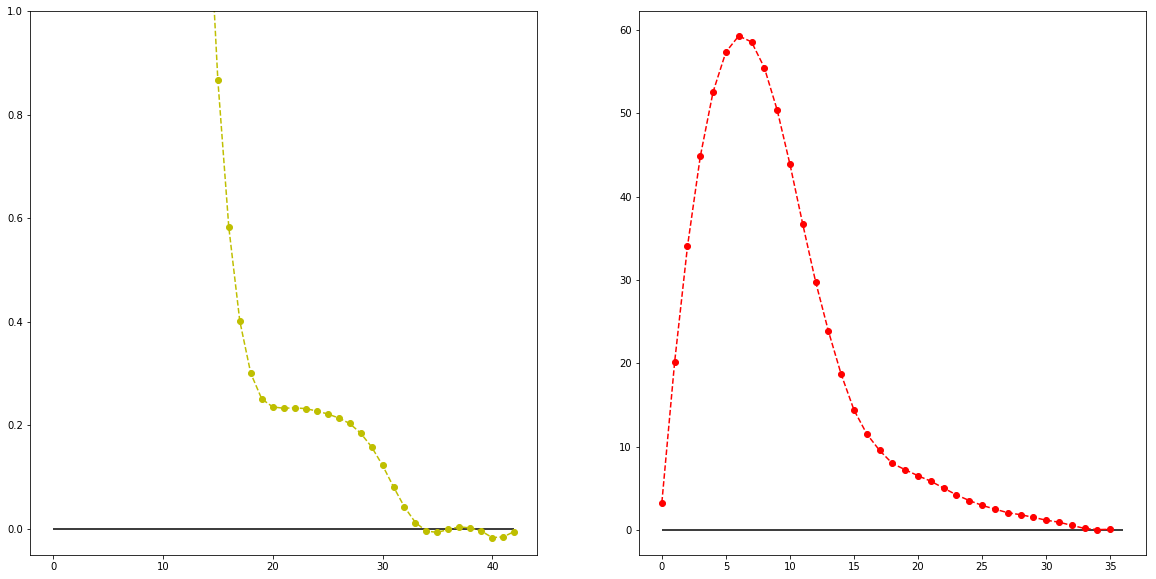

In [182]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
axs[0].plot(np.array(b_all[1:1+len(pair_knots)])*(6*0.1**3) , 'yo--')
axs[0].set_ylim(-0.05,1.0)
axs[0].hlines(0.0, 0, 42)
axs[1].plot(np.array(b_all[1+len(pair_knots):])*(6*0.1**3) , 'ro--')
axs[1].hlines(0.0, 0, 36)

11
[-1139.189, 0.0, -1136.407, -1136.748, -1190.27, -1127.182]


TypeError: type numpy.ndarray doesn't define __round__ method

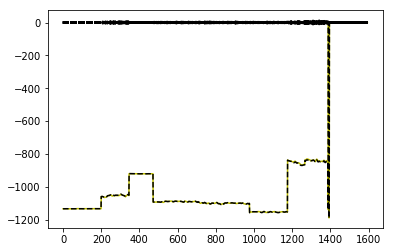

In [183]:
plt.plot(energy(b_all, X), 'y')
plt.plot(y, 'k--')
print(len(bounds))
#plt.xlim(1448,)
print([round(z, 3) for z in energy(b_all, X)[bounds[9]]])
print([round(z, 3) for z in y[bounds[9]]])

In [ ]:
stats_file = 'stats_bs_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpfx = pickle.load(fi, encoding='latin1')

stats_bsplinex = tpf_to_bsplines(stats_tpfx)

target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targetsx = pickle.load(fi, encoding='latin1')

In [184]:
stats_listx = [downselect(stats_bsplinex, pair_knots, edens_knots, bspline=True)]

for key in targets.keys():
    targetsx[key]['weight'] = 1.0
    
for i, stat in enumerate(stats_listx[-1:]):
    Xall, yall, weights, beta, bounds = make_input_matrices(targetsx, stat, keytrj=tkeys)

NameError: name 'stats_bsplinex' is not defined

NameError: name 'Xall' is not defined

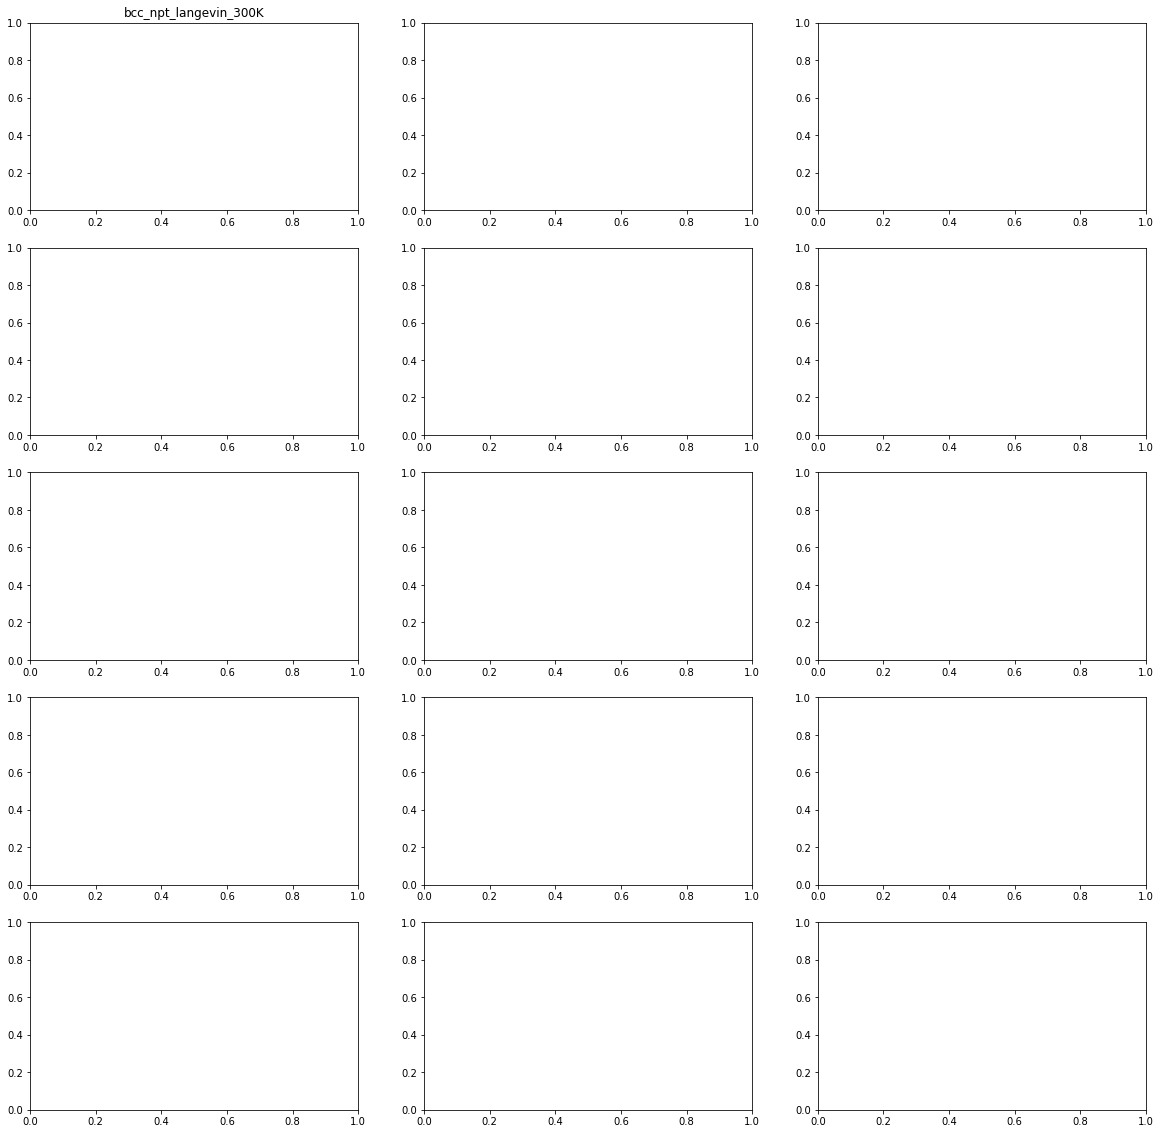

In [185]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
    rr = list(range(len(Xall[0])))[bounds[k]][:]

    axes[i,j].plot(rr, energy(b_all, Xall)[bounds[k]][:], 'b.--', lw=2, label='model')

    axes[i,j].plot(rr, yall[bounds[k]][:], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
        
    if trj == 'vacint':
        axes[i,j].set_ylim(-3835, -3815)
#        axes[i,j].set_xlim(1390,1392)
        
    if trj == 'eos':
        axes[i,j].set_ylim(-1200,1000)
        #axes[i,j].set_xlim(1395,)
    if trj == 'eos':
        axes[i,j].set_ylim(-1200,1000)
        #axes[i,j].set_xlim(1395,)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [273]:
p_knots = np.array(pair_knots)+0.4
print(p_knots)
e_knots = np.array(edens_knots)+0.4
print(e_knots)
n_edens = len(e_knots)

[1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65 4.75 4.85 4.95 5.05 5.15 5.25 5.35 5.45 5.55
 5.65]
[1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65 4.75 4.85 4.95]


In [75]:
def _bspline_coeffs_to_tpf(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = 4
    P = np.zeros((n_tot+4, n_tot), dtype=float)
    for i in range(n_tot+4):
        #ii = i - 4
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot-1:
                continue
            P[i, i+j-o] = p

    return P

In [76]:
M = _bspline_coeffs_to_tpf(41)

In [77]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
b11_ext = np.array(list(b_all[1:-n_edens]))#*(6*0.1**3)
print(b11_ext)
tpf_coeff = M.dot(b11_ext)
print(tpf_coeff)

[ 4.92289978e+03  4.28664798e+03  3.69999163e+03  3.16311467e+03
  2.67608939e+03  2.23839624e+03  1.84881977e+03  1.50589970e+03
  1.20778052e+03  9.52282853e+02  7.36530568e+02  5.57111521e+02
  4.10960084e+02  2.95508852e+02  2.08130623e+02  1.44541442e+02
  9.96768568e+01  6.96951354e+01  5.06228309e+01  3.99962745e+01
  3.53891378e+01  3.46071715e+01  3.59324447e+01  3.77369519e+01
  3.94987352e+01  4.01578637e+01  3.91318371e+01  3.63124833e+01
  3.14272545e+01  2.49184281e+01  1.78357608e+01  1.13388135e+01
  6.44203352e+00  3.33752646e+00  1.73021319e+00  2.06024594e+00
  3.67123592e+00  4.83362071e+00  3.78725430e+00  2.56284050e+00
 -7.24322230e-01]
[ 4.92289978e+03 -1.54049511e+04  1.60907984e+04 -5.60856309e+03
 -1.11639787e-01 -5.91871115e-01 -6.95861877e-01 -2.44846931e-01
 -3.95255159e-01 -3.23814594e-01 -6.96798605e-01 -5.35992726e-01
  3.46512223e-01  4.98221467e-01 -5.97953419e-02 -1.65675237e+00
 -7.80498977e-01  1.22272056e+00 -1.31714317e-01  1.50977796e+00
  3.734

In [78]:
Medens = _bspline_coeffs_to_tpf(35)

In [79]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
ed11_ext = np.array(list(b_all[-n_edens:]))#*(6*0.1**3)
print(ed11_ext)
edens_coeff = Medens.dot(ed11_ext)
print(edens_coeff)

[-1.59290128e+04 -9.88089691e+03 -4.74588467e+03 -5.25041507e+02
  2.79716306e+03  5.24204825e+03  6.84702625e+03  7.65728503e+03
  7.76189085e+03  7.29408376e+03  6.45203078e+03  5.46957529e+03
  4.56593549e+03  3.79746313e+03  3.04952817e+03  2.41000539e+03
  2.00897110e+03  1.65815401e+03  1.39308056e+03  1.23349356e+03
  1.08108126e+03  9.40528262e+02  8.13591973e+02  7.22463551e+02
  5.95888186e+02  5.18878817e+02  4.88408897e+02  4.10192363e+02
  3.29473407e+02  2.33075475e+02  1.50170292e+02  1.08071867e+02
  5.86321048e+01  8.47998479e+00 -9.59805992e+00]
[-1.59290128e+04  5.38351542e+04 -6.07963738e+04  2.28891669e+04
  1.65958911e+01  5.78875369e+00  1.60929531e+01  7.77581929e+00
  4.38782379e+01  4.41738316e+01  6.49269556e+01  3.56763601e+01
 -1.46251877e+01 -1.62866430e+02 -1.70981812e+02  2.02504824e+02
  4.22015424e+01 -3.18347595e+02  2.23797699e+02 -1.57836056e+01
 -1.18054567e+02  1.02996367e+02 -2.92722254e+00  2.04337691e+01
 -9.34459720e+01  1.56267748e+02 -8.8039

In [80]:
p_knot = [1.05, 1.15, 1.25, 1.35] + list(p_knots)
print(len(tpf_coeff), len(p_knot))
e_knot = [1.05, 1.15, 1.25, 1.35] + list(e_knots)
print(len(edens_coeff), len(e_knot))

45 45
39 39


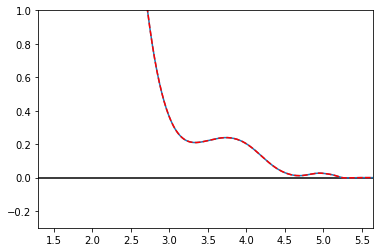

In [81]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[1:-n_edens], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[1:-n_edens], p_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, tpf_coeff, p_knot) for r in rr], 'r--')
plt.ylim(-0.3,1)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

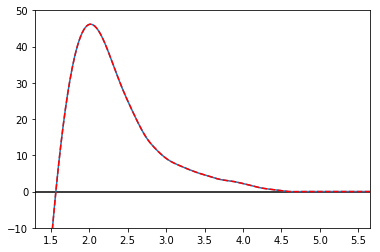

In [82]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[-n_edens:], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[-n_edens:], e_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, edens_coeff, e_knot) for r in rr], 'r--')
plt.ylim(-10,50)
plt.xlim(4,5)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

In [1051]:
tpf_coeff

array([ 4.93218697e+03, -1.54368622e+04,  1.61274254e+04, -5.62274833e+03,
       -1.47906946e-01, -3.13620165e-01, -4.08286684e-01, -5.19216357e-01,
       -1.07142531e-01, -9.78111874e-01, -5.65040881e-01, -5.76428841e-01,
       -8.73166970e-02,  6.43932880e-01,  3.68489519e-01, -1.69483753e+00,
        2.80375065e-02,  7.46931302e-01, -3.85956855e-02,  7.21828595e-01,
        3.67567888e-01,  3.01756357e-01,  2.24032521e-01,  6.60075966e-01,
        7.91887470e-01, -7.41342637e-02,  5.82311980e-01,  1.33485657e-01,
       -2.78216008e-01,  4.67844416e-01,  4.71539397e-01, -3.10649519e-02,
        8.81061163e-02, -8.55529107e-01,  4.75554556e-01, -3.06920406e-01,
       -6.50017472e-01, -9.51269250e-01, -1.97333172e-01,  3.90442475e+00,
       -4.33438903e+00,  7.99138005e+00, -1.00539559e+01,  4.64897825e+00,
       -4.50700625e-01])

In [1052]:
edens_coeff

array([-1.63236674e+04,  5.52716069e+04, -6.25859363e+04,  2.36444082e+04,
        2.48841097e+01,  2.27463178e+01,  5.13777578e+00,  3.03826064e+01,
        1.20928483e+01,  4.00974110e+01,  3.76133057e+01,  4.46071681e+01,
       -1.70561970e+01, -1.62813120e+02, -1.86474253e+02,  2.69099401e+02,
       -3.93947988e+00, -3.00478168e+02,  2.24367638e+02, -6.11834429e+01,
       -6.03324114e+01,  6.38041398e+01,  3.30624420e+01, -9.47598615e+00,
       -9.15580302e+01,  1.69855123e+02, -8.26720584e+01, -1.06145284e+02,
        1.39248441e+02, -3.53257164e+01,  2.88901244e+00,  8.94012477e+00,
       -4.79738520e+01,  1.02747729e+01,  8.09051718e+01, -8.54107011e+01,
        1.61770241e+00,  2.83272850e+01, -5.52559051e+00])

In [1053]:
params = {
    'hyperparams':{'pair':[], 'edens':[]},
    'params':{'pair':[], 'edens':[]}}
params['hyperparams']['pair'] = p_knot
params['params']['pair'] = tpf_coeff
params['hyperparams']['edens'] = e_knot
params['params']['edens'] = edens_coeff
params['params']['embed'] = [-1.0, b_all[0]]

In [334]:
param_list = [params]
#param_list

NameError: name 'params' is not defined

In [1055]:
file_name = os.path.join(working, "params_final_from_marica.pickle")

for params in param_list[-1:]:
    params_to_pickle(params, file_name)#, encoding='latin1', protocol=3)

No existing params file, creating a new one.


In [1056]:
file_name = os.path.join(working, "params_final_from_marica.pickle")

with open(file_name, 'rb') as fi:
    params_store = pickle.load(fi)
#params_store[-1]

In [1057]:
print('pair')

for c, k in zip(tpf_coeff, p_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))

print('edens') 
for c, k in zip(edens_coeff, e_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
        
print('embed')
print(-1.0, b_all[0])
#print(-4.42166597e-01,  1.12818607e-04)
#print(-4.49779872e-01,  1.09664665e-04)

pair
+4932.1869694107445d0*(1.05d0 - r)**3*H(1.05d0 - r)
-15436.862211702473d0*(1.15d0 - r)**3*H(1.15d0 - r)
+16127.425437218692d0*(1.25d0 - r)**3*H(1.25d0 - r)
-5622.748325763732d0*(1.35d0 - r)**3*H(1.35d0 - r)
-0.14790694554176298d0*(1.45d0 - r)**3*H(1.45d0 - r)
-0.31362016483035404d0*(1.55d0 - r)**3*H(1.55d0 - r)
-0.4082866838243717d0*(1.65d0 - r)**3*H(1.65d0 - r)
-0.5192163570127377d0*(1.75d0 - r)**3*H(1.75d0 - r)
-0.10714253090918646d0*(1.85d0 - r)**3*H(1.85d0 - r)
-0.9781118739119847d0*(1.95d0 - r)**3*H(1.95d0 - r)
-0.5650408805331608d0*(2.05d0 - r)**3*H(2.05d0 - r)
-0.5764288405721345d0*(2.15d0 - r)**3*H(2.15d0 - r)
-0.08731669696499011d0*(2.25d0 - r)**3*H(2.25d0 - r)
+0.6439328795590882d0*(2.35d0 - r)**3*H(2.35d0 - r)
+0.3684895193171087d0*(2.45d0 - r)**3*H(2.45d0 - r)
-1.6948375332796104d0*(2.55d0 - r)**3*H(2.55d0 - r)
+0.028037506535497414d0*(2.65d0 - r)**3*H(2.65d0 - r)
+0.7469313024511166d0*(2.75d0 - r)**3*H(2.75d0 - r)
-0.03859568546306491d0*(2.85d0 - r)**3*H(2.85d0 - r)
+

In [ ]:
par = param_list[2]
print('pair')
for c, k in zip(par['params']['pair'], par['hyperparams']['pair']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('edens')   
for c, k in zip(par['params']['edens'], par['hyperparams']['edens']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('embed')    
par['params']['embed']